In [1]:
from utils_1551 import Corpus, load_train_and_test, text2tokens

from bpemb import BPEmb
from uk_stopwords import STOP_WORDS
from typing import List, Dict
import numpy as np
import random

In [2]:
train, test = load_train_and_test()

In [3]:
dim = 300
bpemb_ua = BPEmb(lang="uk", dim=dim)

In [4]:
print(bpemb_ua.embed('щось там').shape)
print(bpemb_ua.encode('щось там'))

(3, 300)
['▁що', 'сь', '▁там']


In [5]:
s = "Ваша відповідь:  Повідомляємо, що відповідно до п. 5.7 Державного стандарту України 4123-2006 «Пристрій примусового зниження швидкості дорожньо-транспортної техніки на вулицях і дорогах. Загальні технічні вимоги» заборонено встановлювати пристрої примусового зниження швидкості руху транспортних засобів на магістральних вулицях, а просп. Григоренка має категорію магістральної вулиці районного значення."
print(text2tokens(s))

['Ваша', 'відповідь', 'Повідомляємо', 'що', 'відповідно', 'до', 'п', '5', '7', 'Державного', 'стандарту', 'України', '4123', '2006', 'Пристрій', 'примусового', 'зниження', 'швидкості', 'дорожньо', 'транспортної', 'техніки', 'на', 'вулицях', 'і', 'дорогах', 'Загальні', 'технічні', 'вимоги', 'заборонено', 'встановлювати', 'пристрої', 'примусового', 'зниження', 'швидкості', 'руху', 'транспортних', 'засобів', 'на', 'магістральних', 'вулицях', 'а', 'просп', 'Григоренка', 'має', 'категорію', 'магістральної', 'вулиці', 'районного', 'значення']


In [6]:
def text2vec(text: str):
    res = np.zeros(dim)
    words = text2tokens(text.lower())
    for w in words:
        if w in STOP_WORDS:
            continue
        for v in bpemb_ua.embed(w):
            res += v
    res /= max(np.linalg.norm(res), 1e-6)
    return res

print(text2vec(s).shape)

(300,)


In [7]:
def corpus2xy(corpus: Corpus)->(np.array, np.array):
    x, y = [], []
    for name, messages in corpus.items():
        for id_, text in messages:
            vec = text2vec(text)
            x.append(vec)
            y.append(name)
    return np.array(x), np.array(y)

def extract_labels(corpus: Corpus)->Dict[str, int]:
    res = {name:i for i, name in enumerate(corpus.keys())}
    return res

labels_dict = extract_labels(train)
def labels_to_ind(y: np.array)->np.array:
    return np.array([labels_dict[name] for name in y])

def shuffle_xy(x: np.array, y:np.array)->(np.array, np.array):
    assert len(x) == len(y)
    p = np.random.permutation(len(x))
    return x[p], y[p]

In [8]:
x_train, y_train = corpus2xy(train)

#print(x_train[:3])
print(y_train[:3])

['Інші-Подяки' 'Інші-Подяки' 'Інші-Подяки']


In [9]:
x_train, y_train = shuffle_xy(x_train, y_train)
#print(x_train[:3])
print(y_train[:3])

['Відсутність-ГВП'
 'Перевірка-наявності-дозволів-на-виконання-будівельних-робіт'
 'Відсутність-освітлення-на-опорних-стовпах-за-відсутності-несправності-лампочок']


In [10]:
y_train_idx = labels_to_ind(y_train)

In [11]:
print(x_train.shape, x_train.dtype)
print(y_train_idx.shape, y_train_idx.dtype)

(48120, 300) float64
(48120,) int32


In [12]:
x_test, y_test = corpus2xy(test)
y_test_idx = labels_to_ind(y_test)

In [18]:
print(x_test.shape, x_test.dtype)
print(y_test_idx.shape, y_test_idx.dtype)

(16147, 300) float64
(16147,) int32


In [13]:
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

In [19]:
one_hot_train_labels = to_categorical(y_train_idx) 
one_hot_test_labels = to_categorical(y_test_idx)

x_val = x_train[:8000]
partial_x_train = x_train[8000:]
y_val = one_hot_train_labels[:8000]
partial_y_train = one_hot_train_labels[8000:]

In [17]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(dim,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(labels_dict), activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
history = model.fit(
            partial_x_train,
            partial_y_train,
            epochs=100,
            batch_size=256,
            validation_data=(x_val, y_val)
          )

Train on 40120 samples, validate on 8000 samples
Epoch 1/100
40120/40120 [==============================] - ETA: 0s - loss: 1.6833 - acc: 0.574 - ETA: 0s - loss: 1.7803 - acc: 0.523 - ETA: 0s - loss: 1.7991 - acc: 0.521 - ETA: 0s - loss: 1.8030 - acc: 0.518 - ETA: 0s - loss: 1.8134 - acc: 0.518 - ETA: 0s - loss: 1.8300 - acc: 0.515 - ETA: 0s - loss: 1.8302 - acc: 0.515 - ETA: 0s - loss: 1.8353 - acc: 0.515 - ETA: 0s - loss: 1.8413 - acc: 0.513 - ETA: 0s - loss: 1.8381 - acc: 0.513 - ETA: 0s - loss: 1.8377 - acc: 0.514 - ETA: 0s - loss: 1.8362 - acc: 0.515 - ETA: 0s - loss: 1.8360 - acc: 0.515 - ETA: 0s - loss: 1.8361 - acc: 0.516 - ETA: 0s - loss: 1.8363 - acc: 0.516 - ETA: 0s - loss: 1.8388 - acc: 0.516 - 1s 23us/sample - loss: 1.8381 - acc: 0.5159 - val_loss: 1.9650 - val_acc: 0.4920
Epoch 2/100
40120/40120 [==============================] - ETA: 1s - loss: 1.8063 - acc: 0.515 - ETA: 0s - loss: 1.8344 - acc: 0.519 - ETA: 0s - loss: 1.8371 - acc: 0.516 - ETA: 0s - loss: 1.8410 - acc: 

40120/40120 [==============================] - ETA: 1s - loss: 1.8028 - acc: 0.527 - ETA: 0s - loss: 1.7431 - acc: 0.524 - ETA: 0s - loss: 1.6850 - acc: 0.539 - ETA: 0s - loss: 1.7004 - acc: 0.538 - ETA: 0s - loss: 1.6868 - acc: 0.542 - ETA: 0s - loss: 1.6949 - acc: 0.542 - ETA: 0s - loss: 1.6922 - acc: 0.541 - ETA: 0s - loss: 1.6904 - acc: 0.542 - ETA: 0s - loss: 1.6906 - acc: 0.543 - ETA: 0s - loss: 1.6870 - acc: 0.545 - ETA: 0s - loss: 1.6850 - acc: 0.546 - ETA: 0s - loss: 1.6834 - acc: 0.546 - ETA: 0s - loss: 1.6811 - acc: 0.547 - ETA: 0s - loss: 1.6805 - acc: 0.548 - ETA: 0s - loss: 1.6805 - acc: 0.549 - ETA: 0s - loss: 1.6795 - acc: 0.549 - ETA: 0s - loss: 1.6787 - acc: 0.550 - ETA: 0s - loss: 1.6794 - acc: 0.549 - 1s 26us/sample - loss: 1.6802 - acc: 0.5498 - val_loss: 1.8644 - val_acc: 0.5104
Epoch 12/100
40120/40120 [==============================] - ETA: 1s - loss: 1.5795 - acc: 0.613 - ETA: 0s - loss: 1.6326 - acc: 0.551 - ETA: 0s - loss: 1.6278 - acc: 0.560 - ETA: 0s - loss

40120/40120 [==============================] - ETA: 1s - loss: 1.7012 - acc: 0.550 - ETA: 1s - loss: 1.5798 - acc: 0.568 - ETA: 0s - loss: 1.5435 - acc: 0.576 - ETA: 0s - loss: 1.5416 - acc: 0.580 - ETA: 0s - loss: 1.5495 - acc: 0.579 - ETA: 0s - loss: 1.5537 - acc: 0.579 - ETA: 0s - loss: 1.5467 - acc: 0.578 - ETA: 0s - loss: 1.5474 - acc: 0.580 - ETA: 0s - loss: 1.5515 - acc: 0.577 - ETA: 0s - loss: 1.5454 - acc: 0.579 - ETA: 0s - loss: 1.5496 - acc: 0.579 - ETA: 0s - loss: 1.5529 - acc: 0.578 - ETA: 0s - loss: 1.5567 - acc: 0.576 - ETA: 0s - loss: 1.5556 - acc: 0.576 - ETA: 0s - loss: 1.5602 - acc: 0.575 - ETA: 0s - loss: 1.5629 - acc: 0.574 - ETA: 0s - loss: 1.5677 - acc: 0.573 - ETA: 0s - loss: 1.5702 - acc: 0.572 - ETA: 0s - loss: 1.5713 - acc: 0.572 - ETA: 0s - loss: 1.5715 - acc: 0.572 - 1s 28us/sample - loss: 1.5721 - acc: 0.5722 - val_loss: 1.8114 - val_acc: 0.5222
Epoch 22/100
40120/40120 [==============================] - ETA: 1s - loss: 1.5598 - acc: 0.617 - ETA: 1s - loss

40120/40120 [==============================] - ETA: 1s - loss: 1.3372 - acc: 0.597 - ETA: 0s - loss: 1.4984 - acc: 0.582 - ETA: 0s - loss: 1.4788 - acc: 0.591 - ETA: 0s - loss: 1.4583 - acc: 0.598 - ETA: 0s - loss: 1.4744 - acc: 0.594 - ETA: 0s - loss: 1.4772 - acc: 0.595 - ETA: 0s - loss: 1.4792 - acc: 0.594 - ETA: 0s - loss: 1.4825 - acc: 0.594 - ETA: 0s - loss: 1.4923 - acc: 0.591 - ETA: 0s - loss: 1.4938 - acc: 0.592 - ETA: 0s - loss: 1.4967 - acc: 0.592 - ETA: 0s - loss: 1.4952 - acc: 0.591 - ETA: 0s - loss: 1.4915 - acc: 0.592 - ETA: 0s - loss: 1.4895 - acc: 0.592 - ETA: 0s - loss: 1.4942 - acc: 0.591 - ETA: 0s - loss: 1.4962 - acc: 0.590 - ETA: 0s - loss: 1.4986 - acc: 0.589 - ETA: 0s - loss: 1.4973 - acc: 0.590 - ETA: 0s - loss: 1.4979 - acc: 0.590 - 1s 27us/sample - loss: 1.4982 - acc: 0.5897 - val_loss: 1.7817 - val_acc: 0.5304
Epoch 31/100
40120/40120 [==============================] - ETA: 1s - loss: 1.5122 - acc: 0.574 - ETA: 1s - loss: 1.4965 - acc: 0.585 - ETA: 0s - loss

40120/40120 [==============================] - ETA: 1s - loss: 1.4483 - acc: 0.585 - ETA: 0s - loss: 1.3852 - acc: 0.615 - ETA: 0s - loss: 1.4360 - acc: 0.596 - ETA: 0s - loss: 1.4452 - acc: 0.596 - ETA: 0s - loss: 1.4291 - acc: 0.602 - ETA: 0s - loss: 1.4270 - acc: 0.602 - ETA: 0s - loss: 1.4305 - acc: 0.603 - ETA: 0s - loss: 1.4347 - acc: 0.604 - ETA: 0s - loss: 1.4317 - acc: 0.605 - ETA: 0s - loss: 1.4328 - acc: 0.604 - ETA: 0s - loss: 1.4424 - acc: 0.603 - ETA: 0s - loss: 1.4357 - acc: 0.604 - ETA: 0s - loss: 1.4376 - acc: 0.604 - ETA: 0s - loss: 1.4386 - acc: 0.605 - ETA: 0s - loss: 1.4370 - acc: 0.604 - ETA: 0s - loss: 1.4372 - acc: 0.603 - ETA: 0s - loss: 1.4374 - acc: 0.603 - ETA: 0s - loss: 1.4378 - acc: 0.604 - ETA: 0s - loss: 1.4416 - acc: 0.602 - 1s 28us/sample - loss: 1.4402 - acc: 0.6028 - val_loss: 1.7751 - val_acc: 0.5364
Epoch 40/100
40120/40120 [==============================] - ETA: 1s - loss: 1.5956 - acc: 0.605 - ETA: 0s - loss: 1.4491 - acc: 0.599 - ETA: 0s - loss

40120/40120 [==============================] - ETA: 1s - loss: 1.4931 - acc: 0.613 - ETA: 0s - loss: 1.3238 - acc: 0.632 - ETA: 0s - loss: 1.3465 - acc: 0.629 - ETA: 0s - loss: 1.3755 - acc: 0.621 - ETA: 0s - loss: 1.3802 - acc: 0.620 - ETA: 0s - loss: 1.3796 - acc: 0.619 - ETA: 0s - loss: 1.3690 - acc: 0.621 - ETA: 0s - loss: 1.3766 - acc: 0.619 - ETA: 0s - loss: 1.3762 - acc: 0.618 - ETA: 0s - loss: 1.3806 - acc: 0.617 - ETA: 0s - loss: 1.3844 - acc: 0.616 - ETA: 0s - loss: 1.3830 - acc: 0.616 - ETA: 0s - loss: 1.3802 - acc: 0.616 - ETA: 0s - loss: 1.3909 - acc: 0.614 - ETA: 0s - loss: 1.3923 - acc: 0.613 - ETA: 0s - loss: 1.3901 - acc: 0.613 - ETA: 0s - loss: 1.3904 - acc: 0.614 - ETA: 0s - loss: 1.3913 - acc: 0.614 - ETA: 0s - loss: 1.3898 - acc: 0.614 - ETA: 0s - loss: 1.3903 - acc: 0.614 - 1s 29us/sample - loss: 1.3889 - acc: 0.6150 - val_loss: 1.7558 - val_acc: 0.5411
Epoch 49/100
40120/40120 [==============================] - ETA: 1s - loss: 1.5826 - acc: 0.585 - ETA: 1s - loss

40120/40120 [==============================] - ETA: 1s - loss: 1.3137 - acc: 0.613 - ETA: 1s - loss: 1.2716 - acc: 0.651 - ETA: 1s - loss: 1.2632 - acc: 0.646 - ETA: 1s - loss: 1.2875 - acc: 0.640 - ETA: 0s - loss: 1.3135 - acc: 0.632 - ETA: 0s - loss: 1.3211 - acc: 0.632 - ETA: 0s - loss: 1.3266 - acc: 0.630 - ETA: 0s - loss: 1.3213 - acc: 0.630 - ETA: 0s - loss: 1.3266 - acc: 0.628 - ETA: 0s - loss: 1.3301 - acc: 0.628 - ETA: 0s - loss: 1.3295 - acc: 0.629 - ETA: 0s - loss: 1.3308 - acc: 0.629 - ETA: 0s - loss: 1.3333 - acc: 0.629 - ETA: 0s - loss: 1.3361 - acc: 0.628 - ETA: 0s - loss: 1.3413 - acc: 0.627 - ETA: 0s - loss: 1.3405 - acc: 0.627 - ETA: 0s - loss: 1.3381 - acc: 0.626 - ETA: 0s - loss: 1.3353 - acc: 0.627 - ETA: 0s - loss: 1.3393 - acc: 0.626 - ETA: 0s - loss: 1.3428 - acc: 0.625 - ETA: 0s - loss: 1.3431 - acc: 0.625 - 1s 30us/sample - loss: 1.3452 - acc: 0.6246 - val_loss: 1.7586 - val_acc: 0.5441
Epoch 58/100
40120/40120 [==============================] - ETA: 1s - loss

40120/40120 [==============================] - ETA: 1s - loss: 1.3708 - acc: 0.632 - ETA: 0s - loss: 1.3151 - acc: 0.638 - ETA: 0s - loss: 1.2895 - acc: 0.641 - ETA: 0s - loss: 1.2629 - acc: 0.642 - ETA: 0s - loss: 1.2685 - acc: 0.643 - ETA: 0s - loss: 1.2723 - acc: 0.643 - ETA: 0s - loss: 1.2780 - acc: 0.640 - ETA: 0s - loss: 1.2823 - acc: 0.638 - ETA: 0s - loss: 1.2794 - acc: 0.638 - ETA: 0s - loss: 1.2798 - acc: 0.639 - ETA: 0s - loss: 1.2807 - acc: 0.638 - ETA: 0s - loss: 1.2882 - acc: 0.636 - ETA: 0s - loss: 1.2874 - acc: 0.637 - ETA: 0s - loss: 1.2911 - acc: 0.634 - ETA: 0s - loss: 1.2932 - acc: 0.634 - ETA: 0s - loss: 1.2992 - acc: 0.633 - ETA: 0s - loss: 1.3039 - acc: 0.633 - ETA: 0s - loss: 1.3060 - acc: 0.633 - ETA: 0s - loss: 1.3066 - acc: 0.633 - 1s 27us/sample - loss: 1.3057 - acc: 0.6342 - val_loss: 1.7460 - val_acc: 0.5501
Epoch 67/100
40120/40120 [==============================] - ETA: 1s - loss: 1.3434 - acc: 0.621 - ETA: 0s - loss: 1.2945 - acc: 0.628 - ETA: 0s - loss

40120/40120 [==============================] - ETA: 1s - loss: 1.2542 - acc: 0.632 - ETA: 0s - loss: 1.2265 - acc: 0.654 - ETA: 0s - loss: 1.2566 - acc: 0.647 - ETA: 0s - loss: 1.2631 - acc: 0.646 - ETA: 0s - loss: 1.2506 - acc: 0.650 - ETA: 0s - loss: 1.2520 - acc: 0.649 - ETA: 0s - loss: 1.2649 - acc: 0.647 - ETA: 0s - loss: 1.2708 - acc: 0.644 - ETA: 0s - loss: 1.2673 - acc: 0.644 - ETA: 0s - loss: 1.2692 - acc: 0.644 - ETA: 0s - loss: 1.2674 - acc: 0.644 - ETA: 0s - loss: 1.2633 - acc: 0.645 - ETA: 0s - loss: 1.2638 - acc: 0.644 - ETA: 0s - loss: 1.2613 - acc: 0.645 - ETA: 0s - loss: 1.2615 - acc: 0.645 - ETA: 0s - loss: 1.2672 - acc: 0.643 - ETA: 0s - loss: 1.2658 - acc: 0.643 - ETA: 0s - loss: 1.2681 - acc: 0.644 - ETA: 0s - loss: 1.2674 - acc: 0.644 - ETA: 0s - loss: 1.2700 - acc: 0.644 - 1s 28us/sample - loss: 1.2706 - acc: 0.6440 - val_loss: 1.7641 - val_acc: 0.5476
Epoch 76/100
40120/40120 [==============================] - ETA: 1s - loss: 1.2303 - acc: 0.644 - ETA: 0s - loss

40120/40120 [==============================] - ETA: 1s - loss: 1.2482 - acc: 0.644 - ETA: 0s - loss: 1.2332 - acc: 0.651 - ETA: 0s - loss: 1.2269 - acc: 0.654 - ETA: 0s - loss: 1.2304 - acc: 0.654 - ETA: 0s - loss: 1.2226 - acc: 0.652 - ETA: 0s - loss: 1.2275 - acc: 0.652 - ETA: 0s - loss: 1.2240 - acc: 0.653 - ETA: 0s - loss: 1.2189 - acc: 0.654 - ETA: 0s - loss: 1.2239 - acc: 0.653 - ETA: 0s - loss: 1.2255 - acc: 0.653 - ETA: 0s - loss: 1.2220 - acc: 0.653 - ETA: 0s - loss: 1.2235 - acc: 0.653 - ETA: 0s - loss: 1.2220 - acc: 0.654 - ETA: 0s - loss: 1.2243 - acc: 0.653 - ETA: 0s - loss: 1.2273 - acc: 0.652 - ETA: 0s - loss: 1.2252 - acc: 0.653 - ETA: 0s - loss: 1.2285 - acc: 0.652 - ETA: 0s - loss: 1.2296 - acc: 0.653 - ETA: 0s - loss: 1.2293 - acc: 0.652 - ETA: 0s - loss: 1.2288 - acc: 0.652 - ETA: 0s - loss: 1.2304 - acc: 0.651 - ETA: 0s - loss: 1.2361 - acc: 0.650 - ETA: 0s - loss: 1.2355 - acc: 0.650 - 1s 33us/sample - loss: 1.2374 - acc: 0.6501 - val_loss: 1.7664 - val_acc: 0.545

40120/40120 [==============================] - ETA: 1s - loss: 1.2448 - acc: 0.656 - ETA: 0s - loss: 1.2064 - acc: 0.661 - ETA: 0s - loss: 1.1953 - acc: 0.662 - ETA: 0s - loss: 1.2114 - acc: 0.658 - ETA: 0s - loss: 1.2017 - acc: 0.662 - ETA: 0s - loss: 1.2043 - acc: 0.659 - ETA: 0s - loss: 1.2077 - acc: 0.657 - ETA: 0s - loss: 1.2105 - acc: 0.657 - ETA: 0s - loss: 1.2152 - acc: 0.656 - ETA: 0s - loss: 1.2141 - acc: 0.657 - ETA: 0s - loss: 1.2105 - acc: 0.659 - ETA: 0s - loss: 1.2103 - acc: 0.658 - ETA: 0s - loss: 1.2106 - acc: 0.658 - ETA: 0s - loss: 1.2112 - acc: 0.657 - ETA: 0s - loss: 1.2145 - acc: 0.657 - ETA: 0s - loss: 1.2146 - acc: 0.657 - ETA: 0s - loss: 1.2172 - acc: 0.655 - ETA: 0s - loss: 1.2166 - acc: 0.655 - ETA: 0s - loss: 1.2160 - acc: 0.656 - ETA: 0s - loss: 1.2143 - acc: 0.656 - ETA: 0s - loss: 1.2104 - acc: 0.657 - ETA: 0s - loss: 1.2122 - acc: 0.657 - 1s 32us/sample - loss: 1.2119 - acc: 0.6575 - val_loss: 1.7766 - val_acc: 0.5454
Epoch 93/100
40120/40120 [==========

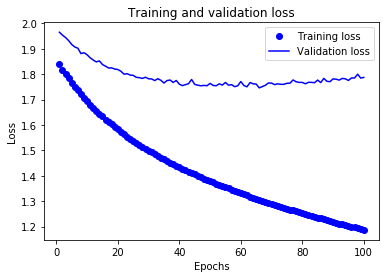

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

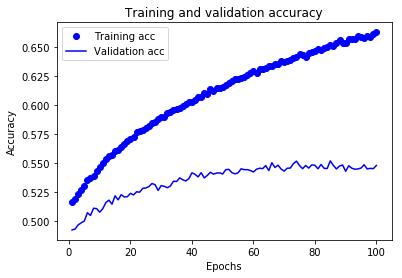

In [25]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
results = model.evaluate(x_test, one_hot_test_labels)
results

16147/16147 [==============================] - ETA: 1s - loss: 3.9950 - acc: 0.312 - ETA: 0s - loss: 2.2086 - acc: 0.477 - ETA: 0s - loss: 1.8660 - acc: 0.528 - ETA: 0s - loss: 1.4445 - acc: 0.631 - ETA: 0s - loss: 1.3646 - acc: 0.623 - ETA: 0s - loss: 1.4500 - acc: 0.606 - ETA: 0s - loss: 1.5692 - acc: 0.586 - ETA: 0s - loss: 1.5633 - acc: 0.588 - ETA: 0s - loss: 1.6827 - acc: 0.567 - ETA: 0s - loss: 1.7436 - acc: 0.558 - ETA: 0s - loss: 1.7765 - acc: 0.551 - ETA: 0s - loss: 1.7511 - acc: 0.555 - 1s 36us/sample - loss: 1.7717 - acc: 0.5516


[1.7717103467324558, 0.55161947]

In [36]:
y_pred_one_hot = model.predict(x_test)
print(y_pred_one_hot.shape)
y_pred = np.argmax(y_pred_one_hot, axis=1)
print(y_pred.shape)
print(y_pred[:5])

(16147, 188)
(16147,)
[114 125   0  89   0]


In [37]:
from sklearn.metrics import classification_report

print(classification_report(y_test_idx, y_pred))

              precision    recall  f1-score   support

           0       0.24      0.28      0.26        78
           1       0.38      0.39      0.38       182
           2       0.21      0.10      0.13        73
           3       0.58      0.74      0.65        19
           4       0.58      0.32      0.41        22
           5       0.57      0.48      0.52        25
           6       0.45      0.33      0.38        15
           7       0.60      0.73      0.66       161
           8       0.57      0.52      0.54        33
           9       0.44      0.17      0.24        24
          10       0.25      0.09      0.13        22
          11       0.44      0.67      0.53        82
          12       0.31      0.22      0.26        23
          13       0.57      0.88      0.69        34
          14       0.35      0.29      0.32        55
          15       0.27      0.19      0.22        16
          16       0.66      0.50      0.57       109
          17       0.65    

Improved model

In [86]:
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD

In [87]:
model2 = models.Sequential()
model2.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(0.0001, 0.0001), input_shape=(dim,)))
model2.add(layers.Dropout(rate = 0.5))
model2.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(0.0001, 0.0001)))
model2.add(layers.Dropout(rate = 0.5))
model2.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(0.0001, 0.0001)))
model2.add(layers.Dense(len(labels_dict), activation='softmax'))
model2.compile(optimizer=SGD(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [98]:
history2 = model2.fit(
            partial_x_train,
            partial_y_train,
            epochs=2000,
            batch_size=256,
            validation_data=(x_val, y_val)
          )

Train on 40120 samples, validate on 8000 samples
Epoch 1/2000
40120/40120 [==============================] - ETA: 1s - loss: 2.8030 - acc: 0.382 - ETA: 1s - loss: 2.6913 - acc: 0.428 - ETA: 1s - loss: 2.7019 - acc: 0.417 - ETA: 1s - loss: 2.6948 - acc: 0.421 - ETA: 1s - loss: 2.6870 - acc: 0.419 - ETA: 1s - loss: 2.6849 - acc: 0.418 - ETA: 1s - loss: 2.6809 - acc: 0.419 - ETA: 1s - loss: 2.6813 - acc: 0.421 - ETA: 1s - loss: 2.6683 - acc: 0.422 - ETA: 0s - loss: 2.6630 - acc: 0.423 - ETA: 0s - loss: 2.6633 - acc: 0.421 - ETA: 0s - loss: 2.6609 - acc: 0.422 - ETA: 0s - loss: 2.6583 - acc: 0.423 - ETA: 0s - loss: 2.6574 - acc: 0.423 - ETA: 0s - loss: 2.6599 - acc: 0.422 - ETA: 0s - loss: 2.6590 - acc: 0.422 - ETA: 0s - loss: 2.6575 - acc: 0.422 - ETA: 0s - loss: 2.6563 - acc: 0.423 - ETA: 0s - loss: 2.6584 - acc: 0.424 - ETA: 0s - loss: 2.6541 - acc: 0.426 - ETA: 0s - loss: 2.6548 - acc: 0.426 - ETA: 0s - loss: 2.6536 - acc: 0.426 - ETA: 0s - loss: 2.6527 - acc: 0.426 - ETA: 0s - loss: 2

40120/40120 [==============================] - ETA: 1s - loss: 2.6808 - acc: 0.394 - ETA: 1s - loss: 2.6671 - acc: 0.410 - ETA: 1s - loss: 2.6466 - acc: 0.412 - ETA: 1s - loss: 2.6316 - acc: 0.426 - ETA: 1s - loss: 2.6258 - acc: 0.434 - ETA: 1s - loss: 2.6208 - acc: 0.435 - ETA: 1s - loss: 2.6275 - acc: 0.430 - ETA: 1s - loss: 2.6298 - acc: 0.429 - ETA: 1s - loss: 2.6343 - acc: 0.427 - ETA: 1s - loss: 2.6315 - acc: 0.427 - ETA: 1s - loss: 2.6350 - acc: 0.426 - ETA: 0s - loss: 2.6421 - acc: 0.423 - ETA: 0s - loss: 2.6421 - acc: 0.423 - ETA: 0s - loss: 2.6437 - acc: 0.421 - ETA: 0s - loss: 2.6459 - acc: 0.422 - ETA: 0s - loss: 2.6480 - acc: 0.421 - ETA: 0s - loss: 2.6481 - acc: 0.422 - ETA: 0s - loss: 2.6482 - acc: 0.422 - ETA: 0s - loss: 2.6443 - acc: 0.424 - ETA: 0s - loss: 2.6448 - acc: 0.425 - ETA: 0s - loss: 2.6461 - acc: 0.425 - ETA: 0s - loss: 2.6453 - acc: 0.425 - ETA: 0s - loss: 2.6467 - acc: 0.425 - ETA: 0s - loss: 2.6488 - acc: 0.425 - ETA: 0s - loss: 2.6511 - acc: 0.425 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6880 - acc: 0.406 - ETA: 1s - loss: 2.6885 - acc: 0.423 - ETA: 1s - loss: 2.6307 - acc: 0.435 - ETA: 1s - loss: 2.6412 - acc: 0.429 - ETA: 1s - loss: 2.6410 - acc: 0.430 - ETA: 1s - loss: 2.6435 - acc: 0.430 - ETA: 1s - loss: 2.6276 - acc: 0.434 - ETA: 1s - loss: 2.6368 - acc: 0.430 - ETA: 1s - loss: 2.6303 - acc: 0.433 - ETA: 1s - loss: 2.6374 - acc: 0.432 - ETA: 1s - loss: 2.6421 - acc: 0.430 - ETA: 1s - loss: 2.6491 - acc: 0.428 - ETA: 1s - loss: 2.6433 - acc: 0.430 - ETA: 1s - loss: 2.6453 - acc: 0.429 - ETA: 1s - loss: 2.6439 - acc: 0.429 - ETA: 1s - loss: 2.6481 - acc: 0.428 - ETA: 1s - loss: 2.6462 - acc: 0.428 - ETA: 1s - loss: 2.6435 - acc: 0.428 - ETA: 1s - loss: 2.6444 - acc: 0.429 - ETA: 0s - loss: 2.6414 - acc: 0.429 - ETA: 0s - loss: 2.6480 - acc: 0.427 - ETA: 0s - loss: 2.6451 - acc: 0.427 - ETA: 0s - loss: 2.6484 - acc: 0.426 - ETA: 0s - loss: 2.6505 - acc: 0.425 - ETA: 0s - loss: 2.6517 - acc: 0.426 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.7838 - acc: 0.402 - ETA: 1s - loss: 2.6013 - acc: 0.450 - ETA: 1s - loss: 2.6366 - acc: 0.436 - ETA: 1s - loss: 2.6560 - acc: 0.431 - ETA: 1s - loss: 2.6672 - acc: 0.429 - ETA: 1s - loss: 2.6600 - acc: 0.432 - ETA: 1s - loss: 2.6616 - acc: 0.432 - ETA: 1s - loss: 2.6536 - acc: 0.434 - ETA: 1s - loss: 2.6571 - acc: 0.432 - ETA: 1s - loss: 2.6541 - acc: 0.431 - ETA: 1s - loss: 2.6571 - acc: 0.429 - ETA: 1s - loss: 2.6494 - acc: 0.431 - ETA: 1s - loss: 2.6498 - acc: 0.429 - ETA: 1s - loss: 2.6554 - acc: 0.429 - ETA: 1s - loss: 2.6543 - acc: 0.429 - ETA: 0s - loss: 2.6567 - acc: 0.429 - ETA: 0s - loss: 2.6582 - acc: 0.429 - ETA: 0s - loss: 2.6526 - acc: 0.431 - ETA: 0s - loss: 2.6576 - acc: 0.430 - ETA: 0s - loss: 2.6599 - acc: 0.430 - ETA: 0s - loss: 2.6580 - acc: 0.430 - ETA: 0s - loss: 2.6565 - acc: 0.431 - ETA: 0s - loss: 2.6564 - acc: 0.430 - ETA: 0s - loss: 2.6527 - acc: 0.430 - ETA: 0s - loss: 2.6503 - acc: 0.431 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5800 - acc: 0.468 - ETA: 1s - loss: 2.6645 - acc: 0.454 - ETA: 1s - loss: 2.6393 - acc: 0.451 - ETA: 1s - loss: 2.6330 - acc: 0.444 - ETA: 1s - loss: 2.6397 - acc: 0.440 - ETA: 1s - loss: 2.6479 - acc: 0.436 - ETA: 1s - loss: 2.6424 - acc: 0.438 - ETA: 1s - loss: 2.6363 - acc: 0.437 - ETA: 1s - loss: 2.6408 - acc: 0.435 - ETA: 1s - loss: 2.6380 - acc: 0.436 - ETA: 1s - loss: 2.6410 - acc: 0.435 - ETA: 1s - loss: 2.6428 - acc: 0.434 - ETA: 1s - loss: 2.6405 - acc: 0.433 - ETA: 0s - loss: 2.6408 - acc: 0.433 - ETA: 0s - loss: 2.6400 - acc: 0.432 - ETA: 0s - loss: 2.6430 - acc: 0.432 - ETA: 0s - loss: 2.6454 - acc: 0.431 - ETA: 0s - loss: 2.6483 - acc: 0.429 - ETA: 0s - loss: 2.6480 - acc: 0.429 - ETA: 0s - loss: 2.6477 - acc: 0.429 - ETA: 0s - loss: 2.6454 - acc: 0.429 - ETA: 0s - loss: 2.6508 - acc: 0.428 - ETA: 0s - loss: 2.6511 - acc: 0.428 - ETA: 0s - loss: 2.6510 - acc: 0.428 - ETA: 0s - loss: 2.6492 - acc: 0.428 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6708 - acc: 0.398 - ETA: 1s - loss: 2.6732 - acc: 0.419 - ETA: 1s - loss: 2.6353 - acc: 0.431 - ETA: 1s - loss: 2.6348 - acc: 0.435 - ETA: 1s - loss: 2.6320 - acc: 0.438 - ETA: 1s - loss: 2.6250 - acc: 0.433 - ETA: 1s - loss: 2.6474 - acc: 0.430 - ETA: 1s - loss: 2.6493 - acc: 0.430 - ETA: 1s - loss: 2.6483 - acc: 0.431 - ETA: 1s - loss: 2.6510 - acc: 0.429 - ETA: 1s - loss: 2.6459 - acc: 0.430 - ETA: 1s - loss: 2.6455 - acc: 0.430 - ETA: 1s - loss: 2.6466 - acc: 0.429 - ETA: 1s - loss: 2.6449 - acc: 0.430 - ETA: 1s - loss: 2.6437 - acc: 0.430 - ETA: 0s - loss: 2.6394 - acc: 0.430 - ETA: 0s - loss: 2.6382 - acc: 0.430 - ETA: 0s - loss: 2.6428 - acc: 0.430 - ETA: 0s - loss: 2.6415 - acc: 0.430 - ETA: 0s - loss: 2.6443 - acc: 0.429 - ETA: 0s - loss: 2.6474 - acc: 0.428 - ETA: 0s - loss: 2.6515 - acc: 0.426 - ETA: 0s - loss: 2.6480 - acc: 0.428 - ETA: 0s - loss: 2.6509 - acc: 0.428 - ETA: 0s - loss: 2.6476 - acc: 0.429 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.6117 - acc: 0.421 - ETA: 1s - loss: 2.6346 - acc: 0.434 - ETA: 1s - loss: 2.6300 - acc: 0.433 - ETA: 1s - loss: 2.6219 - acc: 0.433 - ETA: 1s - loss: 2.6207 - acc: 0.428 - ETA: 1s - loss: 2.6293 - acc: 0.428 - ETA: 1s - loss: 2.6284 - acc: 0.427 - ETA: 1s - loss: 2.6311 - acc: 0.426 - ETA: 1s - loss: 2.6278 - acc: 0.425 - ETA: 1s - loss: 2.6378 - acc: 0.424 - ETA: 1s - loss: 2.6390 - acc: 0.424 - ETA: 1s - loss: 2.6389 - acc: 0.425 - ETA: 1s - loss: 2.6320 - acc: 0.426 - ETA: 1s - loss: 2.6323 - acc: 0.425 - ETA: 0s - loss: 2.6403 - acc: 0.424 - ETA: 0s - loss: 2.6403 - acc: 0.425 - ETA: 0s - loss: 2.6412 - acc: 0.426 - ETA: 0s - loss: 2.6383 - acc: 0.426 - ETA: 0s - loss: 2.6412 - acc: 0.426 - ETA: 0s - loss: 2.6427 - acc: 0.426 - ETA: 0s - loss: 2.6424 - acc: 0.427 - ETA: 0s - loss: 2.6439 - acc: 0.426 - ETA: 0s - loss: 2.6472 - acc: 0.426 - ETA: 0s - loss: 2.6483 - acc: 0.427 - ETA: 0s - loss: 2.6483 - acc: 0.427 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.5952 - acc: 0.441 - ETA: 1s - loss: 2.6724 - acc: 0.415 - ETA: 1s - loss: 2.6594 - acc: 0.423 - ETA: 1s - loss: 2.6500 - acc: 0.433 - ETA: 1s - loss: 2.6549 - acc: 0.429 - ETA: 1s - loss: 2.6579 - acc: 0.425 - ETA: 1s - loss: 2.6631 - acc: 0.422 - ETA: 1s - loss: 2.6702 - acc: 0.420 - ETA: 1s - loss: 2.6640 - acc: 0.422 - ETA: 1s - loss: 2.6665 - acc: 0.423 - ETA: 1s - loss: 2.6637 - acc: 0.425 - ETA: 1s - loss: 2.6635 - acc: 0.426 - ETA: 1s - loss: 2.6606 - acc: 0.426 - ETA: 1s - loss: 2.6582 - acc: 0.428 - ETA: 0s - loss: 2.6533 - acc: 0.430 - ETA: 0s - loss: 2.6534 - acc: 0.430 - ETA: 0s - loss: 2.6502 - acc: 0.430 - ETA: 0s - loss: 2.6499 - acc: 0.431 - ETA: 0s - loss: 2.6492 - acc: 0.431 - ETA: 0s - loss: 2.6463 - acc: 0.431 - ETA: 0s - loss: 2.6443 - acc: 0.431 - ETA: 0s - loss: 2.6433 - acc: 0.431 - ETA: 0s - loss: 2.6446 - acc: 0.430 - ETA: 0s - loss: 2.6421 - acc: 0.431 - ETA: 0s - loss: 2.6436 - acc: 0.431 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.7362 - acc: 0.464 - ETA: 1s - loss: 2.6327 - acc: 0.442 - ETA: 1s - loss: 2.6255 - acc: 0.437 - ETA: 1s - loss: 2.6186 - acc: 0.433 - ETA: 1s - loss: 2.6236 - acc: 0.435 - ETA: 1s - loss: 2.6303 - acc: 0.436 - ETA: 1s - loss: 2.6252 - acc: 0.436 - ETA: 1s - loss: 2.6207 - acc: 0.438 - ETA: 1s - loss: 2.6306 - acc: 0.435 - ETA: 1s - loss: 2.6301 - acc: 0.435 - ETA: 1s - loss: 2.6410 - acc: 0.431 - ETA: 1s - loss: 2.6424 - acc: 0.430 - ETA: 1s - loss: 2.6425 - acc: 0.430 - ETA: 1s - loss: 2.6355 - acc: 0.432 - ETA: 0s - loss: 2.6307 - acc: 0.434 - ETA: 0s - loss: 2.6297 - acc: 0.434 - ETA: 0s - loss: 2.6324 - acc: 0.434 - ETA: 0s - loss: 2.6339 - acc: 0.433 - ETA: 0s - loss: 2.6320 - acc: 0.433 - ETA: 0s - loss: 2.6341 - acc: 0.432 - ETA: 0s - loss: 2.6396 - acc: 0.431 - ETA: 0s - loss: 2.6373 - acc: 0.432 - ETA: 0s - loss: 2.6365 - acc: 0.433 - ETA: 0s - loss: 2.6393 - acc: 0.432 - ETA: 0s - loss: 2.6420 - acc: 0.431 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.6597 - acc: 0.406 - ETA: 1s - loss: 2.5850 - acc: 0.442 - ETA: 1s - loss: 2.6076 - acc: 0.434 - ETA: 1s - loss: 2.6081 - acc: 0.429 - ETA: 1s - loss: 2.6021 - acc: 0.432 - ETA: 1s - loss: 2.6059 - acc: 0.432 - ETA: 1s - loss: 2.6077 - acc: 0.432 - ETA: 1s - loss: 2.6194 - acc: 0.432 - ETA: 1s - loss: 2.6276 - acc: 0.431 - ETA: 1s - loss: 2.6372 - acc: 0.429 - ETA: 1s - loss: 2.6327 - acc: 0.429 - ETA: 1s - loss: 2.6427 - acc: 0.428 - ETA: 1s - loss: 2.6354 - acc: 0.429 - ETA: 1s - loss: 2.6385 - acc: 0.429 - ETA: 0s - loss: 2.6447 - acc: 0.427 - ETA: 0s - loss: 2.6463 - acc: 0.426 - ETA: 0s - loss: 2.6425 - acc: 0.426 - ETA: 0s - loss: 2.6387 - acc: 0.427 - ETA: 0s - loss: 2.6425 - acc: 0.427 - ETA: 0s - loss: 2.6416 - acc: 0.428 - ETA: 0s - loss: 2.6424 - acc: 0.427 - ETA: 0s - loss: 2.6477 - acc: 0.427 - ETA: 0s - loss: 2.6487 - acc: 0.427 - ETA: 0s - loss: 2.6462 - acc: 0.427 - ETA: 0s - loss: 2.6458 - acc: 0.427 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5951 - acc: 0.476 - ETA: 1s - loss: 2.6215 - acc: 0.434 - ETA: 1s - loss: 2.6465 - acc: 0.433 - ETA: 1s - loss: 2.6650 - acc: 0.432 - ETA: 1s - loss: 2.6517 - acc: 0.433 - ETA: 1s - loss: 2.6319 - acc: 0.434 - ETA: 1s - loss: 2.6334 - acc: 0.431 - ETA: 1s - loss: 2.6504 - acc: 0.429 - ETA: 1s - loss: 2.6538 - acc: 0.431 - ETA: 1s - loss: 2.6571 - acc: 0.429 - ETA: 1s - loss: 2.6564 - acc: 0.429 - ETA: 1s - loss: 2.6506 - acc: 0.431 - ETA: 1s - loss: 2.6492 - acc: 0.432 - ETA: 1s - loss: 2.6570 - acc: 0.429 - ETA: 1s - loss: 2.6558 - acc: 0.429 - ETA: 0s - loss: 2.6555 - acc: 0.430 - ETA: 0s - loss: 2.6540 - acc: 0.431 - ETA: 0s - loss: 2.6516 - acc: 0.430 - ETA: 0s - loss: 2.6563 - acc: 0.429 - ETA: 0s - loss: 2.6593 - acc: 0.427 - ETA: 0s - loss: 2.6588 - acc: 0.428 - ETA: 0s - loss: 2.6587 - acc: 0.428 - ETA: 0s - loss: 2.6607 - acc: 0.428 - ETA: 0s - loss: 2.6546 - acc: 0.428 - ETA: 0s - loss: 2.6584 - acc: 0.428 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.4815 - acc: 0.500 - ETA: 1s - loss: 2.6065 - acc: 0.438 - ETA: 1s - loss: 2.6498 - acc: 0.429 - ETA: 1s - loss: 2.6713 - acc: 0.425 - ETA: 1s - loss: 2.6370 - acc: 0.434 - ETA: 1s - loss: 2.6479 - acc: 0.430 - ETA: 1s - loss: 2.6500 - acc: 0.428 - ETA: 1s - loss: 2.6475 - acc: 0.430 - ETA: 1s - loss: 2.6367 - acc: 0.431 - ETA: 1s - loss: 2.6390 - acc: 0.428 - ETA: 1s - loss: 2.6376 - acc: 0.429 - ETA: 1s - loss: 2.6310 - acc: 0.431 - ETA: 1s - loss: 2.6336 - acc: 0.431 - ETA: 1s - loss: 2.6392 - acc: 0.432 - ETA: 0s - loss: 2.6387 - acc: 0.432 - ETA: 0s - loss: 2.6416 - acc: 0.432 - ETA: 0s - loss: 2.6414 - acc: 0.432 - ETA: 0s - loss: 2.6443 - acc: 0.432 - ETA: 0s - loss: 2.6461 - acc: 0.432 - ETA: 0s - loss: 2.6447 - acc: 0.431 - ETA: 0s - loss: 2.6425 - acc: 0.431 - ETA: 0s - loss: 2.6442 - acc: 0.431 - ETA: 0s - loss: 2.6459 - acc: 0.431 - ETA: 0s - loss: 2.6484 - acc: 0.430 - ETA: 0s - loss: 2.6492 - acc: 0.430 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6200 - acc: 0.425 - ETA: 1s - loss: 2.6795 - acc: 0.415 - ETA: 1s - loss: 2.6952 - acc: 0.418 - ETA: 1s - loss: 2.6687 - acc: 0.425 - ETA: 1s - loss: 2.6618 - acc: 0.422 - ETA: 1s - loss: 2.6620 - acc: 0.424 - ETA: 1s - loss: 2.6549 - acc: 0.427 - ETA: 1s - loss: 2.6465 - acc: 0.427 - ETA: 1s - loss: 2.6548 - acc: 0.427 - ETA: 1s - loss: 2.6640 - acc: 0.424 - ETA: 1s - loss: 2.6668 - acc: 0.424 - ETA: 1s - loss: 2.6647 - acc: 0.424 - ETA: 1s - loss: 2.6610 - acc: 0.427 - ETA: 1s - loss: 2.6547 - acc: 0.429 - ETA: 0s - loss: 2.6604 - acc: 0.427 - ETA: 0s - loss: 2.6552 - acc: 0.428 - ETA: 0s - loss: 2.6611 - acc: 0.427 - ETA: 0s - loss: 2.6635 - acc: 0.426 - ETA: 0s - loss: 2.6578 - acc: 0.426 - ETA: 0s - loss: 2.6570 - acc: 0.426 - ETA: 0s - loss: 2.6511 - acc: 0.427 - ETA: 0s - loss: 2.6512 - acc: 0.428 - ETA: 0s - loss: 2.6503 - acc: 0.428 - ETA: 0s - loss: 2.6495 - acc: 0.429 - ETA: 0s - loss: 2.6484 - acc: 0.428 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5805 - acc: 0.382 - ETA: 1s - loss: 2.6421 - acc: 0.434 - ETA: 1s - loss: 2.6465 - acc: 0.433 - ETA: 1s - loss: 2.6407 - acc: 0.434 - ETA: 1s - loss: 2.6483 - acc: 0.429 - ETA: 1s - loss: 2.6361 - acc: 0.427 - ETA: 1s - loss: 2.6437 - acc: 0.426 - ETA: 1s - loss: 2.6450 - acc: 0.426 - ETA: 1s - loss: 2.6556 - acc: 0.426 - ETA: 1s - loss: 2.6561 - acc: 0.426 - ETA: 1s - loss: 2.6605 - acc: 0.425 - ETA: 1s - loss: 2.6554 - acc: 0.425 - ETA: 1s - loss: 2.6536 - acc: 0.426 - ETA: 1s - loss: 2.6503 - acc: 0.427 - ETA: 0s - loss: 2.6428 - acc: 0.427 - ETA: 0s - loss: 2.6361 - acc: 0.428 - ETA: 0s - loss: 2.6418 - acc: 0.428 - ETA: 0s - loss: 2.6371 - acc: 0.429 - ETA: 0s - loss: 2.6395 - acc: 0.430 - ETA: 0s - loss: 2.6429 - acc: 0.429 - ETA: 0s - loss: 2.6439 - acc: 0.429 - ETA: 0s - loss: 2.6436 - acc: 0.429 - ETA: 0s - loss: 2.6459 - acc: 0.429 - ETA: 0s - loss: 2.6454 - acc: 0.429 - ETA: 0s - loss: 2.6444 - acc: 0.429 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.3219 - acc: 0.503 - ETA: 1s - loss: 2.5637 - acc: 0.441 - ETA: 1s - loss: 2.6011 - acc: 0.438 - ETA: 1s - loss: 2.6205 - acc: 0.433 - ETA: 1s - loss: 2.6256 - acc: 0.431 - ETA: 1s - loss: 2.6409 - acc: 0.430 - ETA: 1s - loss: 2.6386 - acc: 0.431 - ETA: 1s - loss: 2.6288 - acc: 0.432 - ETA: 1s - loss: 2.6293 - acc: 0.434 - ETA: 1s - loss: 2.6274 - acc: 0.433 - ETA: 1s - loss: 2.6264 - acc: 0.435 - ETA: 1s - loss: 2.6322 - acc: 0.433 - ETA: 1s - loss: 2.6377 - acc: 0.432 - ETA: 1s - loss: 2.6312 - acc: 0.434 - ETA: 1s - loss: 2.6214 - acc: 0.436 - ETA: 0s - loss: 2.6367 - acc: 0.434 - ETA: 0s - loss: 2.6324 - acc: 0.435 - ETA: 0s - loss: 2.6308 - acc: 0.435 - ETA: 0s - loss: 2.6278 - acc: 0.435 - ETA: 0s - loss: 2.6286 - acc: 0.435 - ETA: 0s - loss: 2.6337 - acc: 0.434 - ETA: 0s - loss: 2.6322 - acc: 0.434 - ETA: 0s - loss: 2.6358 - acc: 0.433 - ETA: 0s - loss: 2.6336 - acc: 0.434 - ETA: 0s - loss: 2.6334 - acc: 0.434 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6750 - acc: 0.441 - ETA: 1s - loss: 2.6092 - acc: 0.446 - ETA: 1s - loss: 2.6095 - acc: 0.432 - ETA: 1s - loss: 2.6127 - acc: 0.435 - ETA: 1s - loss: 2.6191 - acc: 0.435 - ETA: 1s - loss: 2.6223 - acc: 0.434 - ETA: 1s - loss: 2.6178 - acc: 0.432 - ETA: 1s - loss: 2.6205 - acc: 0.430 - ETA: 1s - loss: 2.6080 - acc: 0.436 - ETA: 1s - loss: 2.6164 - acc: 0.436 - ETA: 1s - loss: 2.6210 - acc: 0.435 - ETA: 1s - loss: 2.6188 - acc: 0.437 - ETA: 1s - loss: 2.6222 - acc: 0.437 - ETA: 1s - loss: 2.6211 - acc: 0.436 - ETA: 0s - loss: 2.6235 - acc: 0.435 - ETA: 0s - loss: 2.6224 - acc: 0.436 - ETA: 0s - loss: 2.6271 - acc: 0.435 - ETA: 0s - loss: 2.6225 - acc: 0.437 - ETA: 0s - loss: 2.6239 - acc: 0.436 - ETA: 0s - loss: 2.6231 - acc: 0.437 - ETA: 0s - loss: 2.6206 - acc: 0.437 - ETA: 0s - loss: 2.6219 - acc: 0.437 - ETA: 0s - loss: 2.6212 - acc: 0.437 - ETA: 0s - loss: 2.6238 - acc: 0.437 - ETA: 0s - loss: 2.6295 - acc: 0.436 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.4652 - acc: 0.488 - ETA: 1s - loss: 2.5758 - acc: 0.456 - ETA: 1s - loss: 2.5812 - acc: 0.448 - ETA: 1s - loss: 2.5922 - acc: 0.445 - ETA: 1s - loss: 2.5966 - acc: 0.441 - ETA: 1s - loss: 2.6071 - acc: 0.437 - ETA: 1s - loss: 2.6244 - acc: 0.433 - ETA: 1s - loss: 2.6254 - acc: 0.433 - ETA: 1s - loss: 2.6207 - acc: 0.436 - ETA: 1s - loss: 2.6213 - acc: 0.435 - ETA: 1s - loss: 2.6254 - acc: 0.434 - ETA: 1s - loss: 2.6318 - acc: 0.432 - ETA: 1s - loss: 2.6316 - acc: 0.432 - ETA: 1s - loss: 2.6326 - acc: 0.432 - ETA: 0s - loss: 2.6381 - acc: 0.431 - ETA: 0s - loss: 2.6396 - acc: 0.430 - ETA: 0s - loss: 2.6409 - acc: 0.430 - ETA: 0s - loss: 2.6435 - acc: 0.429 - ETA: 0s - loss: 2.6482 - acc: 0.428 - ETA: 0s - loss: 2.6467 - acc: 0.428 - ETA: 0s - loss: 2.6435 - acc: 0.430 - ETA: 0s - loss: 2.6378 - acc: 0.431 - ETA: 0s - loss: 2.6376 - acc: 0.431 - ETA: 0s - loss: 2.6381 - acc: 0.430 - ETA: 0s - loss: 2.6366 - acc: 0.431 - ETA

40120/40120 [==============================] - ETA: 3s - loss: 2.5201 - acc: 0.476 - ETA: 2s - loss: 2.5595 - acc: 0.454 - ETA: 1s - loss: 2.5826 - acc: 0.450 - ETA: 1s - loss: 2.6097 - acc: 0.445 - ETA: 1s - loss: 2.6340 - acc: 0.439 - ETA: 1s - loss: 2.6089 - acc: 0.447 - ETA: 1s - loss: 2.6144 - acc: 0.445 - ETA: 1s - loss: 2.6250 - acc: 0.442 - ETA: 1s - loss: 2.6252 - acc: 0.442 - ETA: 1s - loss: 2.6137 - acc: 0.443 - ETA: 1s - loss: 2.6093 - acc: 0.442 - ETA: 1s - loss: 2.6152 - acc: 0.440 - ETA: 1s - loss: 2.6231 - acc: 0.438 - ETA: 1s - loss: 2.6238 - acc: 0.439 - ETA: 1s - loss: 2.6207 - acc: 0.439 - ETA: 0s - loss: 2.6225 - acc: 0.438 - ETA: 0s - loss: 2.6289 - acc: 0.436 - ETA: 0s - loss: 2.6302 - acc: 0.436 - ETA: 0s - loss: 2.6269 - acc: 0.437 - ETA: 0s - loss: 2.6297 - acc: 0.436 - ETA: 0s - loss: 2.6241 - acc: 0.438 - ETA: 0s - loss: 2.6282 - acc: 0.437 - ETA: 0s - loss: 2.6306 - acc: 0.436 - ETA: 0s - loss: 2.6314 - acc: 0.436 - ETA: 0s - loss: 2.6322 - acc: 0.435 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.6704 - acc: 0.445 - ETA: 1s - loss: 2.6233 - acc: 0.432 - ETA: 1s - loss: 2.6183 - acc: 0.434 - ETA: 1s - loss: 2.6177 - acc: 0.433 - ETA: 1s - loss: 2.6212 - acc: 0.432 - ETA: 1s - loss: 2.6320 - acc: 0.432 - ETA: 1s - loss: 2.6458 - acc: 0.427 - ETA: 1s - loss: 2.6448 - acc: 0.426 - ETA: 1s - loss: 2.6432 - acc: 0.428 - ETA: 1s - loss: 2.6374 - acc: 0.428 - ETA: 1s - loss: 2.6303 - acc: 0.431 - ETA: 1s - loss: 2.6290 - acc: 0.432 - ETA: 1s - loss: 2.6320 - acc: 0.432 - ETA: 1s - loss: 2.6271 - acc: 0.432 - ETA: 0s - loss: 2.6308 - acc: 0.432 - ETA: 0s - loss: 2.6221 - acc: 0.433 - ETA: 0s - loss: 2.6280 - acc: 0.432 - ETA: 0s - loss: 2.6262 - acc: 0.433 - ETA: 0s - loss: 2.6289 - acc: 0.433 - ETA: 0s - loss: 2.6330 - acc: 0.433 - ETA: 0s - loss: 2.6364 - acc: 0.432 - ETA: 0s - loss: 2.6306 - acc: 0.433 - ETA: 0s - loss: 2.6288 - acc: 0.433 - ETA: 0s - loss: 2.6277 - acc: 0.434 - ETA: 0s - loss: 2.6257 - acc: 0.434 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.6469 - acc: 0.429 - ETA: 1s - loss: 2.6251 - acc: 0.424 - ETA: 1s - loss: 2.6174 - acc: 0.433 - ETA: 1s - loss: 2.6057 - acc: 0.438 - ETA: 1s - loss: 2.6030 - acc: 0.440 - ETA: 1s - loss: 2.6176 - acc: 0.430 - ETA: 1s - loss: 2.6058 - acc: 0.433 - ETA: 1s - loss: 2.6096 - acc: 0.432 - ETA: 1s - loss: 2.6182 - acc: 0.434 - ETA: 1s - loss: 2.6171 - acc: 0.436 - ETA: 1s - loss: 2.6186 - acc: 0.436 - ETA: 1s - loss: 2.6184 - acc: 0.435 - ETA: 1s - loss: 2.6276 - acc: 0.433 - ETA: 1s - loss: 2.6295 - acc: 0.433 - ETA: 1s - loss: 2.6242 - acc: 0.434 - ETA: 0s - loss: 2.6258 - acc: 0.434 - ETA: 0s - loss: 2.6258 - acc: 0.434 - ETA: 0s - loss: 2.6240 - acc: 0.434 - ETA: 0s - loss: 2.6273 - acc: 0.433 - ETA: 0s - loss: 2.6319 - acc: 0.432 - ETA: 0s - loss: 2.6325 - acc: 0.432 - ETA: 0s - loss: 2.6319 - acc: 0.432 - ETA: 0s - loss: 2.6296 - acc: 0.432 - ETA: 0s - loss: 2.6295 - acc: 0.433 - ETA: 0s - loss: 2.6289 - acc: 0.433 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.7476 - acc: 0.441 - ETA: 1s - loss: 2.6351 - acc: 0.437 - ETA: 1s - loss: 2.6329 - acc: 0.438 - ETA: 1s - loss: 2.6305 - acc: 0.431 - ETA: 1s - loss: 2.6347 - acc: 0.430 - ETA: 1s - loss: 2.6229 - acc: 0.433 - ETA: 1s - loss: 2.6288 - acc: 0.432 - ETA: 1s - loss: 2.6314 - acc: 0.434 - ETA: 1s - loss: 2.6359 - acc: 0.431 - ETA: 1s - loss: 2.6429 - acc: 0.431 - ETA: 1s - loss: 2.6450 - acc: 0.431 - ETA: 1s - loss: 2.6357 - acc: 0.433 - ETA: 1s - loss: 2.6362 - acc: 0.433 - ETA: 1s - loss: 2.6388 - acc: 0.433 - ETA: 1s - loss: 2.6322 - acc: 0.435 - ETA: 0s - loss: 2.6349 - acc: 0.436 - ETA: 0s - loss: 2.6361 - acc: 0.435 - ETA: 0s - loss: 2.6337 - acc: 0.435 - ETA: 0s - loss: 2.6292 - acc: 0.437 - ETA: 0s - loss: 2.6313 - acc: 0.437 - ETA: 0s - loss: 2.6337 - acc: 0.436 - ETA: 0s - loss: 2.6302 - acc: 0.436 - ETA: 0s - loss: 2.6320 - acc: 0.436 - ETA: 0s - loss: 2.6314 - acc: 0.436 - ETA: 0s - loss: 2.6330 - acc: 0.436 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.9748 - acc: 0.378 - ETA: 1s - loss: 2.6601 - acc: 0.409 - ETA: 1s - loss: 2.6315 - acc: 0.426 - ETA: 1s - loss: 2.6465 - acc: 0.419 - ETA: 1s - loss: 2.6387 - acc: 0.425 - ETA: 1s - loss: 2.6240 - acc: 0.428 - ETA: 1s - loss: 2.6311 - acc: 0.427 - ETA: 1s - loss: 2.6388 - acc: 0.425 - ETA: 1s - loss: 2.6369 - acc: 0.428 - ETA: 1s - loss: 2.6343 - acc: 0.431 - ETA: 1s - loss: 2.6274 - acc: 0.433 - ETA: 1s - loss: 2.6258 - acc: 0.434 - ETA: 1s - loss: 2.6222 - acc: 0.435 - ETA: 1s - loss: 2.6166 - acc: 0.435 - ETA: 1s - loss: 2.6226 - acc: 0.434 - ETA: 0s - loss: 2.6188 - acc: 0.435 - ETA: 0s - loss: 2.6152 - acc: 0.436 - ETA: 0s - loss: 2.6228 - acc: 0.435 - ETA: 0s - loss: 2.6211 - acc: 0.435 - ETA: 0s - loss: 2.6247 - acc: 0.435 - ETA: 0s - loss: 2.6239 - acc: 0.436 - ETA: 0s - loss: 2.6279 - acc: 0.434 - ETA: 0s - loss: 2.6277 - acc: 0.435 - ETA: 0s - loss: 2.6272 - acc: 0.435 - ETA: 0s - loss: 2.6279 - acc: 0.433 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5758 - acc: 0.449 - ETA: 1s - loss: 2.6193 - acc: 0.445 - ETA: 1s - loss: 2.5864 - acc: 0.440 - ETA: 1s - loss: 2.5907 - acc: 0.438 - ETA: 1s - loss: 2.6097 - acc: 0.435 - ETA: 1s - loss: 2.6139 - acc: 0.434 - ETA: 1s - loss: 2.6166 - acc: 0.435 - ETA: 1s - loss: 2.6102 - acc: 0.435 - ETA: 1s - loss: 2.6102 - acc: 0.435 - ETA: 1s - loss: 2.6082 - acc: 0.435 - ETA: 1s - loss: 2.6071 - acc: 0.436 - ETA: 1s - loss: 2.6075 - acc: 0.435 - ETA: 1s - loss: 2.6145 - acc: 0.433 - ETA: 1s - loss: 2.6214 - acc: 0.432 - ETA: 0s - loss: 2.6218 - acc: 0.432 - ETA: 0s - loss: 2.6248 - acc: 0.432 - ETA: 0s - loss: 2.6204 - acc: 0.434 - ETA: 0s - loss: 2.6247 - acc: 0.433 - ETA: 0s - loss: 2.6228 - acc: 0.433 - ETA: 0s - loss: 2.6206 - acc: 0.433 - ETA: 0s - loss: 2.6249 - acc: 0.432 - ETA: 0s - loss: 2.6263 - acc: 0.431 - ETA: 0s - loss: 2.6241 - acc: 0.432 - ETA: 0s - loss: 2.6269 - acc: 0.431 - ETA: 0s - loss: 2.6244 - acc: 0.431 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6563 - acc: 0.418 - ETA: 1s - loss: 2.6441 - acc: 0.440 - ETA: 1s - loss: 2.6647 - acc: 0.435 - ETA: 1s - loss: 2.6462 - acc: 0.438 - ETA: 1s - loss: 2.6412 - acc: 0.439 - ETA: 1s - loss: 2.6471 - acc: 0.434 - ETA: 1s - loss: 2.6384 - acc: 0.433 - ETA: 1s - loss: 2.6353 - acc: 0.434 - ETA: 1s - loss: 2.6341 - acc: 0.432 - ETA: 1s - loss: 2.6324 - acc: 0.433 - ETA: 1s - loss: 2.6325 - acc: 0.432 - ETA: 1s - loss: 2.6332 - acc: 0.431 - ETA: 1s - loss: 2.6373 - acc: 0.430 - ETA: 1s - loss: 2.6370 - acc: 0.429 - ETA: 1s - loss: 2.6390 - acc: 0.429 - ETA: 0s - loss: 2.6346 - acc: 0.430 - ETA: 0s - loss: 2.6332 - acc: 0.430 - ETA: 0s - loss: 2.6324 - acc: 0.430 - ETA: 0s - loss: 2.6270 - acc: 0.430 - ETA: 0s - loss: 2.6267 - acc: 0.432 - ETA: 0s - loss: 2.6233 - acc: 0.432 - ETA: 0s - loss: 2.6240 - acc: 0.431 - ETA: 0s - loss: 2.6251 - acc: 0.431 - ETA: 0s - loss: 2.6205 - acc: 0.433 - ETA: 0s - loss: 2.6199 - acc: 0.433 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.7151 - acc: 0.414 - ETA: 1s - loss: 2.5449 - acc: 0.455 - ETA: 1s - loss: 2.5686 - acc: 0.447 - ETA: 1s - loss: 2.5824 - acc: 0.445 - ETA: 1s - loss: 2.5854 - acc: 0.443 - ETA: 1s - loss: 2.5844 - acc: 0.443 - ETA: 1s - loss: 2.5981 - acc: 0.441 - ETA: 1s - loss: 2.6031 - acc: 0.441 - ETA: 1s - loss: 2.6032 - acc: 0.440 - ETA: 1s - loss: 2.5997 - acc: 0.442 - ETA: 1s - loss: 2.6014 - acc: 0.440 - ETA: 1s - loss: 2.6118 - acc: 0.437 - ETA: 1s - loss: 2.6193 - acc: 0.435 - ETA: 1s - loss: 2.6256 - acc: 0.435 - ETA: 0s - loss: 2.6264 - acc: 0.435 - ETA: 0s - loss: 2.6233 - acc: 0.436 - ETA: 0s - loss: 2.6253 - acc: 0.436 - ETA: 0s - loss: 2.6271 - acc: 0.436 - ETA: 0s - loss: 2.6226 - acc: 0.438 - ETA: 0s - loss: 2.6238 - acc: 0.437 - ETA: 0s - loss: 2.6293 - acc: 0.436 - ETA: 0s - loss: 2.6317 - acc: 0.435 - ETA: 0s - loss: 2.6286 - acc: 0.435 - ETA: 0s - loss: 2.6298 - acc: 0.435 - ETA: 0s - loss: 2.6283 - acc: 0.434 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6254 - acc: 0.449 - ETA: 1s - loss: 2.5574 - acc: 0.442 - ETA: 1s - loss: 2.6069 - acc: 0.435 - ETA: 1s - loss: 2.6164 - acc: 0.432 - ETA: 1s - loss: 2.6246 - acc: 0.433 - ETA: 1s - loss: 2.6284 - acc: 0.434 - ETA: 1s - loss: 2.6185 - acc: 0.434 - ETA: 1s - loss: 2.6198 - acc: 0.434 - ETA: 1s - loss: 2.6276 - acc: 0.434 - ETA: 1s - loss: 2.6373 - acc: 0.433 - ETA: 1s - loss: 2.6412 - acc: 0.432 - ETA: 1s - loss: 2.6439 - acc: 0.431 - ETA: 1s - loss: 2.6329 - acc: 0.434 - ETA: 1s - loss: 2.6296 - acc: 0.435 - ETA: 0s - loss: 2.6216 - acc: 0.438 - ETA: 0s - loss: 2.6222 - acc: 0.437 - ETA: 0s - loss: 2.6220 - acc: 0.437 - ETA: 0s - loss: 2.6251 - acc: 0.437 - ETA: 0s - loss: 2.6234 - acc: 0.437 - ETA: 0s - loss: 2.6237 - acc: 0.437 - ETA: 0s - loss: 2.6270 - acc: 0.437 - ETA: 0s - loss: 2.6274 - acc: 0.436 - ETA: 0s - loss: 2.6264 - acc: 0.436 - ETA: 0s - loss: 2.6213 - acc: 0.437 - ETA: 0s - loss: 2.6230 - acc: 0.437 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5854 - acc: 0.468 - ETA: 1s - loss: 2.6768 - acc: 0.435 - ETA: 1s - loss: 2.6791 - acc: 0.440 - ETA: 1s - loss: 2.6819 - acc: 0.436 - ETA: 1s - loss: 2.6687 - acc: 0.439 - ETA: 1s - loss: 2.6586 - acc: 0.437 - ETA: 1s - loss: 2.6489 - acc: 0.439 - ETA: 1s - loss: 2.6523 - acc: 0.438 - ETA: 1s - loss: 2.6507 - acc: 0.438 - ETA: 1s - loss: 2.6447 - acc: 0.439 - ETA: 1s - loss: 2.6520 - acc: 0.435 - ETA: 1s - loss: 2.6491 - acc: 0.436 - ETA: 1s - loss: 2.6528 - acc: 0.435 - ETA: 1s - loss: 2.6469 - acc: 0.436 - ETA: 1s - loss: 2.6544 - acc: 0.435 - ETA: 0s - loss: 2.6513 - acc: 0.435 - ETA: 0s - loss: 2.6494 - acc: 0.434 - ETA: 0s - loss: 2.6430 - acc: 0.435 - ETA: 0s - loss: 2.6405 - acc: 0.436 - ETA: 0s - loss: 2.6421 - acc: 0.435 - ETA: 0s - loss: 2.6391 - acc: 0.436 - ETA: 0s - loss: 2.6414 - acc: 0.435 - ETA: 0s - loss: 2.6404 - acc: 0.436 - ETA: 0s - loss: 2.6370 - acc: 0.436 - ETA: 0s - loss: 2.6346 - acc: 0.436 - ETA

Epoch 154/2000
40120/40120 [==============================] - ETA: 1s - loss: 2.7569 - acc: 0.441 - ETA: 1s - loss: 2.6646 - acc: 0.420 - ETA: 1s - loss: 2.6196 - acc: 0.441 - ETA: 1s - loss: 2.6128 - acc: 0.441 - ETA: 1s - loss: 2.6107 - acc: 0.437 - ETA: 1s - loss: 2.6205 - acc: 0.433 - ETA: 1s - loss: 2.6172 - acc: 0.434 - ETA: 1s - loss: 2.6225 - acc: 0.434 - ETA: 1s - loss: 2.6249 - acc: 0.435 - ETA: 1s - loss: 2.6314 - acc: 0.433 - ETA: 1s - loss: 2.6306 - acc: 0.432 - ETA: 1s - loss: 2.6349 - acc: 0.431 - ETA: 1s - loss: 2.6365 - acc: 0.432 - ETA: 1s - loss: 2.6292 - acc: 0.434 - ETA: 0s - loss: 2.6286 - acc: 0.434 - ETA: 0s - loss: 2.6263 - acc: 0.435 - ETA: 0s - loss: 2.6279 - acc: 0.435 - ETA: 0s - loss: 2.6258 - acc: 0.434 - ETA: 0s - loss: 2.6256 - acc: 0.435 - ETA: 0s - loss: 2.6231 - acc: 0.435 - ETA: 0s - loss: 2.6252 - acc: 0.434 - ETA: 0s - loss: 2.6269 - acc: 0.434 - ETA: 0s - loss: 2.6272 - acc: 0.434 - ETA: 0s - loss: 2.6277 - acc: 0.434 - ETA: 0s - loss: 2.6281 - a

40120/40120 [==============================] - ETA: 2s - loss: 2.5295 - acc: 0.433 - ETA: 2s - loss: 2.5432 - acc: 0.450 - ETA: 1s - loss: 2.5930 - acc: 0.440 - ETA: 1s - loss: 2.5939 - acc: 0.443 - ETA: 1s - loss: 2.6112 - acc: 0.438 - ETA: 1s - loss: 2.6070 - acc: 0.439 - ETA: 1s - loss: 2.6135 - acc: 0.435 - ETA: 1s - loss: 2.6216 - acc: 0.433 - ETA: 1s - loss: 2.6233 - acc: 0.432 - ETA: 1s - loss: 2.6296 - acc: 0.430 - ETA: 1s - loss: 2.6198 - acc: 0.432 - ETA: 1s - loss: 2.6152 - acc: 0.433 - ETA: 1s - loss: 2.6076 - acc: 0.435 - ETA: 1s - loss: 2.6099 - acc: 0.434 - ETA: 0s - loss: 2.6141 - acc: 0.434 - ETA: 0s - loss: 2.6111 - acc: 0.436 - ETA: 0s - loss: 2.6109 - acc: 0.436 - ETA: 0s - loss: 2.6076 - acc: 0.437 - ETA: 0s - loss: 2.6070 - acc: 0.437 - ETA: 0s - loss: 2.6119 - acc: 0.437 - ETA: 0s - loss: 2.6114 - acc: 0.437 - ETA: 0s - loss: 2.6170 - acc: 0.435 - ETA: 0s - loss: 2.6202 - acc: 0.435 - ETA: 0s - loss: 2.6214 - acc: 0.435 - ETA: 0s - loss: 2.6188 - acc: 0.436 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.7449 - acc: 0.406 - ETA: 1s - loss: 2.6088 - acc: 0.428 - ETA: 2s - loss: 2.6177 - acc: 0.422 - ETA: 1s - loss: 2.6122 - acc: 0.426 - ETA: 1s - loss: 2.6044 - acc: 0.432 - ETA: 1s - loss: 2.6206 - acc: 0.431 - ETA: 1s - loss: 2.6360 - acc: 0.425 - ETA: 1s - loss: 2.6427 - acc: 0.425 - ETA: 1s - loss: 2.6355 - acc: 0.426 - ETA: 1s - loss: 2.6337 - acc: 0.429 - ETA: 1s - loss: 2.6264 - acc: 0.430 - ETA: 1s - loss: 2.6245 - acc: 0.430 - ETA: 1s - loss: 2.6240 - acc: 0.431 - ETA: 1s - loss: 2.6228 - acc: 0.432 - ETA: 1s - loss: 2.6251 - acc: 0.434 - ETA: 1s - loss: 2.6235 - acc: 0.433 - ETA: 1s - loss: 2.6245 - acc: 0.434 - ETA: 0s - loss: 2.6239 - acc: 0.435 - ETA: 0s - loss: 2.6234 - acc: 0.435 - ETA: 0s - loss: 2.6260 - acc: 0.435 - ETA: 0s - loss: 2.6274 - acc: 0.434 - ETA: 0s - loss: 2.6257 - acc: 0.434 - ETA: 0s - loss: 2.6276 - acc: 0.434 - ETA: 0s - loss: 2.6251 - acc: 0.435 - ETA: 0s - loss: 2.6273 - acc: 0.435 - ETA

Epoch 171/2000
40120/40120 [==============================] - ETA: 1s - loss: 2.7511 - acc: 0.394 - ETA: 1s - loss: 2.5121 - acc: 0.460 - ETA: 1s - loss: 2.5529 - acc: 0.450 - ETA: 1s - loss: 2.5930 - acc: 0.450 - ETA: 1s - loss: 2.5947 - acc: 0.448 - ETA: 1s - loss: 2.5986 - acc: 0.443 - ETA: 1s - loss: 2.6099 - acc: 0.439 - ETA: 1s - loss: 2.6126 - acc: 0.437 - ETA: 1s - loss: 2.6151 - acc: 0.438 - ETA: 1s - loss: 2.6143 - acc: 0.438 - ETA: 1s - loss: 2.6139 - acc: 0.440 - ETA: 1s - loss: 2.6139 - acc: 0.439 - ETA: 1s - loss: 2.6210 - acc: 0.437 - ETA: 1s - loss: 2.6190 - acc: 0.437 - ETA: 0s - loss: 2.6205 - acc: 0.437 - ETA: 0s - loss: 2.6157 - acc: 0.438 - ETA: 0s - loss: 2.6147 - acc: 0.439 - ETA: 0s - loss: 2.6149 - acc: 0.438 - ETA: 0s - loss: 2.6211 - acc: 0.437 - ETA: 0s - loss: 2.6211 - acc: 0.437 - ETA: 0s - loss: 2.6197 - acc: 0.437 - ETA: 0s - loss: 2.6214 - acc: 0.437 - ETA: 0s - loss: 2.6227 - acc: 0.436 - ETA: 0s - loss: 2.6231 - acc: 0.436 - ETA: 0s - loss: 2.6220 - a

40120/40120 [==============================] - ETA: 2s - loss: 2.5616 - acc: 0.457 - ETA: 1s - loss: 2.5578 - acc: 0.449 - ETA: 1s - loss: 2.6159 - acc: 0.440 - ETA: 1s - loss: 2.6208 - acc: 0.438 - ETA: 1s - loss: 2.6092 - acc: 0.442 - ETA: 1s - loss: 2.6132 - acc: 0.439 - ETA: 1s - loss: 2.6050 - acc: 0.438 - ETA: 1s - loss: 2.6049 - acc: 0.439 - ETA: 1s - loss: 2.6111 - acc: 0.439 - ETA: 1s - loss: 2.6115 - acc: 0.438 - ETA: 1s - loss: 2.6153 - acc: 0.437 - ETA: 1s - loss: 2.6199 - acc: 0.435 - ETA: 1s - loss: 2.6142 - acc: 0.437 - ETA: 1s - loss: 2.6174 - acc: 0.436 - ETA: 1s - loss: 2.6212 - acc: 0.435 - ETA: 0s - loss: 2.6204 - acc: 0.435 - ETA: 0s - loss: 2.6198 - acc: 0.434 - ETA: 0s - loss: 2.6213 - acc: 0.434 - ETA: 0s - loss: 2.6194 - acc: 0.435 - ETA: 0s - loss: 2.6174 - acc: 0.436 - ETA: 0s - loss: 2.6169 - acc: 0.435 - ETA: 0s - loss: 2.6218 - acc: 0.433 - ETA: 0s - loss: 2.6231 - acc: 0.433 - ETA: 0s - loss: 2.6231 - acc: 0.432 - ETA: 0s - loss: 2.6213 - acc: 0.432 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6328 - acc: 0.425 - ETA: 2s - loss: 2.6557 - acc: 0.414 - ETA: 2s - loss: 2.6345 - acc: 0.427 - ETA: 2s - loss: 2.6632 - acc: 0.424 - ETA: 2s - loss: 2.6589 - acc: 0.427 - ETA: 2s - loss: 2.6374 - acc: 0.431 - ETA: 2s - loss: 2.6350 - acc: 0.430 - ETA: 1s - loss: 2.6429 - acc: 0.428 - ETA: 1s - loss: 2.6418 - acc: 0.429 - ETA: 1s - loss: 2.6360 - acc: 0.431 - ETA: 1s - loss: 2.6331 - acc: 0.433 - ETA: 1s - loss: 2.6342 - acc: 0.432 - ETA: 1s - loss: 2.6314 - acc: 0.431 - ETA: 1s - loss: 2.6242 - acc: 0.436 - ETA: 1s - loss: 2.6217 - acc: 0.438 - ETA: 1s - loss: 2.6239 - acc: 0.437 - ETA: 1s - loss: 2.6300 - acc: 0.434 - ETA: 1s - loss: 2.6242 - acc: 0.435 - ETA: 0s - loss: 2.6190 - acc: 0.435 - ETA: 0s - loss: 2.6241 - acc: 0.434 - ETA: 0s - loss: 2.6275 - acc: 0.433 - ETA: 0s - loss: 2.6268 - acc: 0.433 - ETA: 0s - loss: 2.6242 - acc: 0.433 - ETA: 0s - loss: 2.6231 - acc: 0.434 - ETA: 0s - loss: 2.6213 - acc: 0.435 - ETA

Epoch 188/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.2544 - acc: 0.527 - ETA: 1s - loss: 2.5867 - acc: 0.442 - ETA: 1s - loss: 2.6030 - acc: 0.444 - ETA: 1s - loss: 2.6060 - acc: 0.439 - ETA: 1s - loss: 2.6095 - acc: 0.438 - ETA: 1s - loss: 2.6043 - acc: 0.442 - ETA: 1s - loss: 2.6177 - acc: 0.439 - ETA: 1s - loss: 2.6142 - acc: 0.439 - ETA: 1s - loss: 2.6058 - acc: 0.442 - ETA: 1s - loss: 2.6086 - acc: 0.441 - ETA: 1s - loss: 2.6114 - acc: 0.440 - ETA: 1s - loss: 2.6173 - acc: 0.439 - ETA: 1s - loss: 2.6194 - acc: 0.437 - ETA: 1s - loss: 2.6155 - acc: 0.439 - ETA: 0s - loss: 2.6129 - acc: 0.439 - ETA: 0s - loss: 2.6105 - acc: 0.439 - ETA: 0s - loss: 2.6066 - acc: 0.438 - ETA: 0s - loss: 2.6127 - acc: 0.436 - ETA: 0s - loss: 2.6124 - acc: 0.437 - ETA: 0s - loss: 2.6137 - acc: 0.438 - ETA: 0s - loss: 2.6146 - acc: 0.437 - ETA: 0s - loss: 2.6103 - acc: 0.438 - ETA: 0s - loss: 2.6078 - acc: 0.439 - ETA: 0s - loss: 2.6083 - acc: 0.438 - ETA: 0s - loss: 2.6081 - a

40120/40120 [==============================] - ETA: 2s - loss: 2.6649 - acc: 0.437 - ETA: 1s - loss: 2.6697 - acc: 0.429 - ETA: 1s - loss: 2.6278 - acc: 0.431 - ETA: 1s - loss: 2.6247 - acc: 0.430 - ETA: 1s - loss: 2.6149 - acc: 0.431 - ETA: 1s - loss: 2.6185 - acc: 0.434 - ETA: 1s - loss: 2.6228 - acc: 0.432 - ETA: 1s - loss: 2.6247 - acc: 0.432 - ETA: 1s - loss: 2.6235 - acc: 0.434 - ETA: 1s - loss: 2.6194 - acc: 0.436 - ETA: 1s - loss: 2.6148 - acc: 0.437 - ETA: 1s - loss: 2.6170 - acc: 0.436 - ETA: 1s - loss: 2.6184 - acc: 0.435 - ETA: 1s - loss: 2.6162 - acc: 0.436 - ETA: 0s - loss: 2.6164 - acc: 0.435 - ETA: 0s - loss: 2.6148 - acc: 0.435 - ETA: 0s - loss: 2.6188 - acc: 0.435 - ETA: 0s - loss: 2.6188 - acc: 0.435 - ETA: 0s - loss: 2.6160 - acc: 0.435 - ETA: 0s - loss: 2.6150 - acc: 0.435 - ETA: 0s - loss: 2.6106 - acc: 0.436 - ETA: 0s - loss: 2.6135 - acc: 0.436 - ETA: 0s - loss: 2.6114 - acc: 0.436 - ETA: 0s - loss: 2.6125 - acc: 0.435 - ETA: 0s - loss: 2.6136 - acc: 0.435 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5462 - acc: 0.457 - ETA: 1s - loss: 2.6356 - acc: 0.431 - ETA: 1s - loss: 2.6068 - acc: 0.438 - ETA: 1s - loss: 2.6125 - acc: 0.441 - ETA: 1s - loss: 2.6008 - acc: 0.447 - ETA: 1s - loss: 2.6194 - acc: 0.444 - ETA: 1s - loss: 2.6154 - acc: 0.442 - ETA: 1s - loss: 2.6235 - acc: 0.439 - ETA: 1s - loss: 2.6287 - acc: 0.437 - ETA: 1s - loss: 2.6297 - acc: 0.433 - ETA: 1s - loss: 2.6317 - acc: 0.432 - ETA: 1s - loss: 2.6306 - acc: 0.434 - ETA: 1s - loss: 2.6287 - acc: 0.435 - ETA: 1s - loss: 2.6301 - acc: 0.435 - ETA: 0s - loss: 2.6319 - acc: 0.435 - ETA: 0s - loss: 2.6295 - acc: 0.436 - ETA: 0s - loss: 2.6265 - acc: 0.436 - ETA: 0s - loss: 2.6242 - acc: 0.436 - ETA: 0s - loss: 2.6234 - acc: 0.437 - ETA: 0s - loss: 2.6213 - acc: 0.436 - ETA: 0s - loss: 2.6205 - acc: 0.435 - ETA: 0s - loss: 2.6220 - acc: 0.435 - ETA: 0s - loss: 2.6219 - acc: 0.434 - ETA: 0s - loss: 2.6199 - acc: 0.434 - ETA: 0s - loss: 2.6169 - acc: 0.435 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.8083 - acc: 0.359 - ETA: 1s - loss: 2.6955 - acc: 0.408 - ETA: 1s - loss: 2.6285 - acc: 0.419 - ETA: 1s - loss: 2.5897 - acc: 0.431 - ETA: 1s - loss: 2.6079 - acc: 0.432 - ETA: 1s - loss: 2.6067 - acc: 0.434 - ETA: 1s - loss: 2.5995 - acc: 0.439 - ETA: 1s - loss: 2.6081 - acc: 0.437 - ETA: 1s - loss: 2.6127 - acc: 0.435 - ETA: 1s - loss: 2.6156 - acc: 0.436 - ETA: 1s - loss: 2.6114 - acc: 0.437 - ETA: 1s - loss: 2.6078 - acc: 0.438 - ETA: 1s - loss: 2.6132 - acc: 0.436 - ETA: 1s - loss: 2.6174 - acc: 0.436 - ETA: 1s - loss: 2.6211 - acc: 0.435 - ETA: 1s - loss: 2.6177 - acc: 0.436 - ETA: 0s - loss: 2.6168 - acc: 0.435 - ETA: 0s - loss: 2.6107 - acc: 0.437 - ETA: 0s - loss: 2.6095 - acc: 0.436 - ETA: 0s - loss: 2.6067 - acc: 0.436 - ETA: 0s - loss: 2.6019 - acc: 0.437 - ETA: 0s - loss: 2.6043 - acc: 0.438 - ETA: 0s - loss: 2.6082 - acc: 0.438 - ETA: 0s - loss: 2.6041 - acc: 0.439 - ETA: 0s - loss: 2.6047 - acc: 0.439 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6267 - acc: 0.402 - ETA: 1s - loss: 2.6080 - acc: 0.429 - ETA: 1s - loss: 2.5967 - acc: 0.436 - ETA: 1s - loss: 2.5951 - acc: 0.437 - ETA: 1s - loss: 2.5804 - acc: 0.438 - ETA: 1s - loss: 2.6039 - acc: 0.434 - ETA: 1s - loss: 2.6039 - acc: 0.436 - ETA: 1s - loss: 2.6054 - acc: 0.436 - ETA: 1s - loss: 2.6038 - acc: 0.437 - ETA: 1s - loss: 2.5988 - acc: 0.440 - ETA: 1s - loss: 2.5997 - acc: 0.440 - ETA: 1s - loss: 2.6046 - acc: 0.439 - ETA: 1s - loss: 2.6002 - acc: 0.440 - ETA: 1s - loss: 2.6018 - acc: 0.439 - ETA: 0s - loss: 2.6013 - acc: 0.440 - ETA: 0s - loss: 2.5983 - acc: 0.441 - ETA: 0s - loss: 2.5994 - acc: 0.440 - ETA: 0s - loss: 2.5994 - acc: 0.440 - ETA: 0s - loss: 2.6049 - acc: 0.440 - ETA: 0s - loss: 2.6060 - acc: 0.439 - ETA: 0s - loss: 2.6027 - acc: 0.440 - ETA: 0s - loss: 2.6046 - acc: 0.440 - ETA: 0s - loss: 2.6063 - acc: 0.439 - ETA: 0s - loss: 2.6088 - acc: 0.438 - ETA: 0s - loss: 2.6090 - acc: 0.438 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.7061 - acc: 0.410 - ETA: 2s - loss: 2.5815 - acc: 0.446 - ETA: 1s - loss: 2.6178 - acc: 0.436 - ETA: 1s - loss: 2.6275 - acc: 0.433 - ETA: 1s - loss: 2.6219 - acc: 0.439 - ETA: 1s - loss: 2.6209 - acc: 0.438 - ETA: 1s - loss: 2.6159 - acc: 0.437 - ETA: 1s - loss: 2.6064 - acc: 0.438 - ETA: 1s - loss: 2.6177 - acc: 0.437 - ETA: 1s - loss: 2.6180 - acc: 0.434 - ETA: 1s - loss: 2.6192 - acc: 0.435 - ETA: 1s - loss: 2.6193 - acc: 0.435 - ETA: 1s - loss: 2.6185 - acc: 0.436 - ETA: 1s - loss: 2.6188 - acc: 0.436 - ETA: 0s - loss: 2.6103 - acc: 0.438 - ETA: 0s - loss: 2.6161 - acc: 0.437 - ETA: 0s - loss: 2.6160 - acc: 0.436 - ETA: 0s - loss: 2.6132 - acc: 0.437 - ETA: 0s - loss: 2.6073 - acc: 0.438 - ETA: 0s - loss: 2.6067 - acc: 0.438 - ETA: 0s - loss: 2.6051 - acc: 0.437 - ETA: 0s - loss: 2.6045 - acc: 0.437 - ETA: 0s - loss: 2.6049 - acc: 0.437 - ETA: 0s - loss: 2.6036 - acc: 0.438 - ETA: 0s - loss: 2.6028 - acc: 0.439 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.7100 - acc: 0.437 - ETA: 1s - loss: 2.6510 - acc: 0.429 - ETA: 1s - loss: 2.5966 - acc: 0.442 - ETA: 1s - loss: 2.5975 - acc: 0.439 - ETA: 1s - loss: 2.6025 - acc: 0.441 - ETA: 1s - loss: 2.6128 - acc: 0.437 - ETA: 1s - loss: 2.6100 - acc: 0.436 - ETA: 1s - loss: 2.6083 - acc: 0.436 - ETA: 1s - loss: 2.6061 - acc: 0.439 - ETA: 1s - loss: 2.5973 - acc: 0.439 - ETA: 1s - loss: 2.5986 - acc: 0.439 - ETA: 1s - loss: 2.6001 - acc: 0.437 - ETA: 1s - loss: 2.6035 - acc: 0.438 - ETA: 1s - loss: 2.6103 - acc: 0.440 - ETA: 0s - loss: 2.6151 - acc: 0.438 - ETA: 0s - loss: 2.6173 - acc: 0.438 - ETA: 0s - loss: 2.6148 - acc: 0.438 - ETA: 0s - loss: 2.6140 - acc: 0.437 - ETA: 0s - loss: 2.6162 - acc: 0.437 - ETA: 0s - loss: 2.6171 - acc: 0.436 - ETA: 0s - loss: 2.6156 - acc: 0.436 - ETA: 0s - loss: 2.6148 - acc: 0.437 - ETA: 0s - loss: 2.6139 - acc: 0.437 - ETA: 0s - loss: 2.6170 - acc: 0.436 - ETA: 0s - loss: 2.6163 - acc: 0.436 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6095 - acc: 0.437 - ETA: 1s - loss: 2.6385 - acc: 0.437 - ETA: 1s - loss: 2.6109 - acc: 0.445 - ETA: 1s - loss: 2.5725 - acc: 0.448 - ETA: 1s - loss: 2.5775 - acc: 0.444 - ETA: 1s - loss: 2.5909 - acc: 0.443 - ETA: 1s - loss: 2.5921 - acc: 0.444 - ETA: 1s - loss: 2.5954 - acc: 0.442 - ETA: 1s - loss: 2.6000 - acc: 0.441 - ETA: 1s - loss: 2.6069 - acc: 0.438 - ETA: 1s - loss: 2.6058 - acc: 0.438 - ETA: 1s - loss: 2.6061 - acc: 0.438 - ETA: 1s - loss: 2.6032 - acc: 0.439 - ETA: 1s - loss: 2.6014 - acc: 0.440 - ETA: 1s - loss: 2.5993 - acc: 0.442 - ETA: 0s - loss: 2.6006 - acc: 0.441 - ETA: 0s - loss: 2.6040 - acc: 0.440 - ETA: 0s - loss: 2.6038 - acc: 0.440 - ETA: 0s - loss: 2.6108 - acc: 0.439 - ETA: 0s - loss: 2.6102 - acc: 0.438 - ETA: 0s - loss: 2.6168 - acc: 0.438 - ETA: 0s - loss: 2.6170 - acc: 0.436 - ETA: 0s - loss: 2.6109 - acc: 0.438 - ETA: 0s - loss: 2.6111 - acc: 0.438 - ETA: 0s - loss: 2.6076 - acc: 0.439 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.8646 - acc: 0.398 - ETA: 1s - loss: 2.7360 - acc: 0.416 - ETA: 1s - loss: 2.6921 - acc: 0.424 - ETA: 1s - loss: 2.6609 - acc: 0.426 - ETA: 1s - loss: 2.6463 - acc: 0.436 - ETA: 1s - loss: 2.6443 - acc: 0.438 - ETA: 1s - loss: 2.6246 - acc: 0.441 - ETA: 1s - loss: 2.6282 - acc: 0.438 - ETA: 1s - loss: 2.6240 - acc: 0.436 - ETA: 1s - loss: 2.6244 - acc: 0.437 - ETA: 1s - loss: 2.6234 - acc: 0.435 - ETA: 1s - loss: 2.6261 - acc: 0.433 - ETA: 1s - loss: 2.6244 - acc: 0.433 - ETA: 0s - loss: 2.6244 - acc: 0.433 - ETA: 0s - loss: 2.6239 - acc: 0.434 - ETA: 0s - loss: 2.6207 - acc: 0.435 - ETA: 0s - loss: 2.6142 - acc: 0.437 - ETA: 0s - loss: 2.6110 - acc: 0.436 - ETA: 0s - loss: 2.6170 - acc: 0.436 - ETA: 0s - loss: 2.6171 - acc: 0.436 - ETA: 0s - loss: 2.6133 - acc: 0.436 - ETA: 0s - loss: 2.6134 - acc: 0.437 - ETA: 0s - loss: 2.6146 - acc: 0.436 - ETA: 0s - loss: 2.6161 - acc: 0.437 - ETA: 0s - loss: 2.6154 - acc: 0.437 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6041 - acc: 0.445 - ETA: 1s - loss: 2.6449 - acc: 0.436 - ETA: 1s - loss: 2.6117 - acc: 0.439 - ETA: 1s - loss: 2.6151 - acc: 0.440 - ETA: 1s - loss: 2.6100 - acc: 0.439 - ETA: 1s - loss: 2.6095 - acc: 0.438 - ETA: 1s - loss: 2.6037 - acc: 0.437 - ETA: 1s - loss: 2.6036 - acc: 0.438 - ETA: 1s - loss: 2.5996 - acc: 0.437 - ETA: 1s - loss: 2.5965 - acc: 0.438 - ETA: 1s - loss: 2.5948 - acc: 0.438 - ETA: 1s - loss: 2.5967 - acc: 0.439 - ETA: 1s - loss: 2.5919 - acc: 0.441 - ETA: 1s - loss: 2.5930 - acc: 0.440 - ETA: 0s - loss: 2.5899 - acc: 0.441 - ETA: 0s - loss: 2.5904 - acc: 0.441 - ETA: 0s - loss: 2.5853 - acc: 0.442 - ETA: 0s - loss: 2.5880 - acc: 0.442 - ETA: 0s - loss: 2.5889 - acc: 0.442 - ETA: 0s - loss: 2.5928 - acc: 0.441 - ETA: 0s - loss: 2.5946 - acc: 0.440 - ETA: 0s - loss: 2.5910 - acc: 0.441 - ETA: 0s - loss: 2.5930 - acc: 0.441 - ETA: 0s - loss: 2.5979 - acc: 0.440 - ETA: 0s - loss: 2.5939 - acc: 0.441 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.6135 - acc: 0.460 - ETA: 1s - loss: 2.5331 - acc: 0.458 - ETA: 1s - loss: 2.5800 - acc: 0.447 - ETA: 1s - loss: 2.5569 - acc: 0.454 - ETA: 1s - loss: 2.5628 - acc: 0.448 - ETA: 1s - loss: 2.5839 - acc: 0.444 - ETA: 1s - loss: 2.5775 - acc: 0.447 - ETA: 1s - loss: 2.5837 - acc: 0.444 - ETA: 1s - loss: 2.5824 - acc: 0.444 - ETA: 1s - loss: 2.5844 - acc: 0.444 - ETA: 1s - loss: 2.5844 - acc: 0.444 - ETA: 1s - loss: 2.5909 - acc: 0.442 - ETA: 1s - loss: 2.5870 - acc: 0.444 - ETA: 1s - loss: 2.5929 - acc: 0.442 - ETA: 0s - loss: 2.5882 - acc: 0.442 - ETA: 0s - loss: 2.5889 - acc: 0.442 - ETA: 0s - loss: 2.5907 - acc: 0.442 - ETA: 0s - loss: 2.5891 - acc: 0.443 - ETA: 0s - loss: 2.5892 - acc: 0.443 - ETA: 0s - loss: 2.5930 - acc: 0.441 - ETA: 0s - loss: 2.5943 - acc: 0.440 - ETA: 0s - loss: 2.5915 - acc: 0.441 - ETA: 0s - loss: 2.5907 - acc: 0.442 - ETA: 0s - loss: 2.5914 - acc: 0.440 - ETA: 0s - loss: 2.5951 - acc: 0.440 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.5713 - acc: 0.418 - ETA: 1s - loss: 2.6174 - acc: 0.432 - ETA: 1s - loss: 2.5773 - acc: 0.444 - ETA: 1s - loss: 2.5827 - acc: 0.446 - ETA: 1s - loss: 2.5839 - acc: 0.443 - ETA: 1s - loss: 2.5802 - acc: 0.444 - ETA: 1s - loss: 2.5900 - acc: 0.442 - ETA: 1s - loss: 2.6054 - acc: 0.440 - ETA: 1s - loss: 2.6150 - acc: 0.438 - ETA: 1s - loss: 2.6160 - acc: 0.438 - ETA: 1s - loss: 2.6119 - acc: 0.438 - ETA: 1s - loss: 2.6081 - acc: 0.441 - ETA: 1s - loss: 2.6146 - acc: 0.440 - ETA: 1s - loss: 2.6199 - acc: 0.439 - ETA: 0s - loss: 2.6232 - acc: 0.438 - ETA: 0s - loss: 2.6203 - acc: 0.438 - ETA: 0s - loss: 2.6170 - acc: 0.438 - ETA: 0s - loss: 2.6145 - acc: 0.438 - ETA: 0s - loss: 2.6125 - acc: 0.438 - ETA: 0s - loss: 2.6125 - acc: 0.438 - ETA: 0s - loss: 2.6129 - acc: 0.437 - ETA: 0s - loss: 2.6078 - acc: 0.439 - ETA: 0s - loss: 2.6075 - acc: 0.438 - ETA: 0s - loss: 2.6083 - acc: 0.438 - ETA: 0s - loss: 2.6084 - acc: 0.438 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5239 - acc: 0.484 - ETA: 1s - loss: 2.6295 - acc: 0.439 - ETA: 1s - loss: 2.5780 - acc: 0.452 - ETA: 1s - loss: 2.5860 - acc: 0.445 - ETA: 1s - loss: 2.5912 - acc: 0.445 - ETA: 1s - loss: 2.5932 - acc: 0.447 - ETA: 1s - loss: 2.5870 - acc: 0.450 - ETA: 1s - loss: 2.5792 - acc: 0.452 - ETA: 1s - loss: 2.5894 - acc: 0.448 - ETA: 1s - loss: 2.5778 - acc: 0.450 - ETA: 1s - loss: 2.5806 - acc: 0.449 - ETA: 1s - loss: 2.5894 - acc: 0.447 - ETA: 1s - loss: 2.5888 - acc: 0.446 - ETA: 1s - loss: 2.5908 - acc: 0.445 - ETA: 1s - loss: 2.5894 - acc: 0.444 - ETA: 0s - loss: 2.5945 - acc: 0.443 - ETA: 0s - loss: 2.5947 - acc: 0.443 - ETA: 0s - loss: 2.5944 - acc: 0.442 - ETA: 0s - loss: 2.5974 - acc: 0.442 - ETA: 0s - loss: 2.6023 - acc: 0.441 - ETA: 0s - loss: 2.6032 - acc: 0.441 - ETA: 0s - loss: 2.6064 - acc: 0.440 - ETA: 0s - loss: 2.6046 - acc: 0.440 - ETA: 0s - loss: 2.6063 - acc: 0.440 - ETA: 0s - loss: 2.6068 - acc: 0.439 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.3279 - acc: 0.472 - ETA: 1s - loss: 2.6000 - acc: 0.418 - ETA: 1s - loss: 2.5793 - acc: 0.433 - ETA: 1s - loss: 2.6049 - acc: 0.432 - ETA: 1s - loss: 2.6061 - acc: 0.433 - ETA: 1s - loss: 2.6140 - acc: 0.432 - ETA: 1s - loss: 2.6005 - acc: 0.436 - ETA: 1s - loss: 2.6005 - acc: 0.435 - ETA: 1s - loss: 2.5937 - acc: 0.436 - ETA: 1s - loss: 2.6046 - acc: 0.436 - ETA: 1s - loss: 2.6036 - acc: 0.437 - ETA: 1s - loss: 2.6042 - acc: 0.438 - ETA: 1s - loss: 2.6131 - acc: 0.438 - ETA: 1s - loss: 2.6179 - acc: 0.436 - ETA: 1s - loss: 2.6155 - acc: 0.436 - ETA: 1s - loss: 2.6166 - acc: 0.437 - ETA: 1s - loss: 2.6128 - acc: 0.437 - ETA: 0s - loss: 2.6082 - acc: 0.438 - ETA: 0s - loss: 2.6080 - acc: 0.438 - ETA: 0s - loss: 2.6086 - acc: 0.437 - ETA: 0s - loss: 2.6143 - acc: 0.436 - ETA: 0s - loss: 2.6117 - acc: 0.437 - ETA: 0s - loss: 2.6138 - acc: 0.437 - ETA: 0s - loss: 2.6112 - acc: 0.437 - ETA: 0s - loss: 2.6097 - acc: 0.438 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5489 - acc: 0.449 - ETA: 1s - loss: 2.6269 - acc: 0.438 - ETA: 1s - loss: 2.5808 - acc: 0.445 - ETA: 1s - loss: 2.5945 - acc: 0.437 - ETA: 1s - loss: 2.6091 - acc: 0.437 - ETA: 1s - loss: 2.6074 - acc: 0.438 - ETA: 1s - loss: 2.6152 - acc: 0.436 - ETA: 1s - loss: 2.6192 - acc: 0.436 - ETA: 1s - loss: 2.6215 - acc: 0.436 - ETA: 1s - loss: 2.6197 - acc: 0.434 - ETA: 1s - loss: 2.6170 - acc: 0.434 - ETA: 1s - loss: 2.6155 - acc: 0.435 - ETA: 1s - loss: 2.6117 - acc: 0.435 - ETA: 0s - loss: 2.6087 - acc: 0.436 - ETA: 0s - loss: 2.6009 - acc: 0.438 - ETA: 0s - loss: 2.6042 - acc: 0.438 - ETA: 0s - loss: 2.6025 - acc: 0.438 - ETA: 0s - loss: 2.6031 - acc: 0.438 - ETA: 0s - loss: 2.5977 - acc: 0.440 - ETA: 0s - loss: 2.5935 - acc: 0.441 - ETA: 0s - loss: 2.5966 - acc: 0.441 - ETA: 0s - loss: 2.5966 - acc: 0.441 - ETA: 0s - loss: 2.6008 - acc: 0.441 - ETA: 0s - loss: 2.5980 - acc: 0.441 - ETA: 0s - loss: 2.5977 - acc: 0.441 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5984 - acc: 0.441 - ETA: 1s - loss: 2.5943 - acc: 0.437 - ETA: 1s - loss: 2.5869 - acc: 0.446 - ETA: 1s - loss: 2.5777 - acc: 0.439 - ETA: 1s - loss: 2.5717 - acc: 0.441 - ETA: 1s - loss: 2.5716 - acc: 0.440 - ETA: 1s - loss: 2.5778 - acc: 0.443 - ETA: 1s - loss: 2.5814 - acc: 0.444 - ETA: 1s - loss: 2.5849 - acc: 0.443 - ETA: 1s - loss: 2.5863 - acc: 0.442 - ETA: 1s - loss: 2.5895 - acc: 0.441 - ETA: 1s - loss: 2.5887 - acc: 0.443 - ETA: 1s - loss: 2.5950 - acc: 0.441 - ETA: 1s - loss: 2.5927 - acc: 0.441 - ETA: 0s - loss: 2.5873 - acc: 0.443 - ETA: 0s - loss: 2.5865 - acc: 0.442 - ETA: 0s - loss: 2.5855 - acc: 0.443 - ETA: 0s - loss: 2.5910 - acc: 0.442 - ETA: 0s - loss: 2.5919 - acc: 0.442 - ETA: 0s - loss: 2.5945 - acc: 0.442 - ETA: 0s - loss: 2.5951 - acc: 0.442 - ETA: 0s - loss: 2.6005 - acc: 0.441 - ETA: 0s - loss: 2.5962 - acc: 0.441 - ETA: 0s - loss: 2.5945 - acc: 0.442 - ETA: 0s - loss: 2.5944 - acc: 0.442 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.7697 - acc: 0.394 - ETA: 1s - loss: 2.6479 - acc: 0.419 - ETA: 1s - loss: 2.6311 - acc: 0.427 - ETA: 1s - loss: 2.6038 - acc: 0.439 - ETA: 1s - loss: 2.5948 - acc: 0.443 - ETA: 1s - loss: 2.6055 - acc: 0.442 - ETA: 1s - loss: 2.6163 - acc: 0.439 - ETA: 1s - loss: 2.6230 - acc: 0.436 - ETA: 1s - loss: 2.6191 - acc: 0.436 - ETA: 1s - loss: 2.6154 - acc: 0.436 - ETA: 1s - loss: 2.6130 - acc: 0.438 - ETA: 1s - loss: 2.6109 - acc: 0.437 - ETA: 1s - loss: 2.6070 - acc: 0.439 - ETA: 1s - loss: 2.6090 - acc: 0.438 - ETA: 0s - loss: 2.6041 - acc: 0.439 - ETA: 0s - loss: 2.5994 - acc: 0.440 - ETA: 0s - loss: 2.5997 - acc: 0.440 - ETA: 0s - loss: 2.6033 - acc: 0.440 - ETA: 0s - loss: 2.6041 - acc: 0.440 - ETA: 0s - loss: 2.6049 - acc: 0.441 - ETA: 0s - loss: 2.6043 - acc: 0.441 - ETA: 0s - loss: 2.6000 - acc: 0.441 - ETA: 0s - loss: 2.5976 - acc: 0.442 - ETA: 0s - loss: 2.6000 - acc: 0.441 - ETA: 0s - loss: 2.6009 - acc: 0.440 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6285 - acc: 0.414 - ETA: 1s - loss: 2.6305 - acc: 0.438 - ETA: 1s - loss: 2.5932 - acc: 0.446 - ETA: 1s - loss: 2.6123 - acc: 0.440 - ETA: 1s - loss: 2.6233 - acc: 0.443 - ETA: 1s - loss: 2.6233 - acc: 0.444 - ETA: 1s - loss: 2.6197 - acc: 0.445 - ETA: 1s - loss: 2.6132 - acc: 0.447 - ETA: 1s - loss: 2.6133 - acc: 0.445 - ETA: 1s - loss: 2.6132 - acc: 0.444 - ETA: 1s - loss: 2.6044 - acc: 0.445 - ETA: 1s - loss: 2.6035 - acc: 0.444 - ETA: 1s - loss: 2.5989 - acc: 0.445 - ETA: 1s - loss: 2.5967 - acc: 0.445 - ETA: 0s - loss: 2.5962 - acc: 0.445 - ETA: 0s - loss: 2.5998 - acc: 0.445 - ETA: 0s - loss: 2.5988 - acc: 0.445 - ETA: 0s - loss: 2.5987 - acc: 0.444 - ETA: 0s - loss: 2.6024 - acc: 0.442 - ETA: 0s - loss: 2.6012 - acc: 0.442 - ETA: 0s - loss: 2.6018 - acc: 0.443 - ETA: 0s - loss: 2.6057 - acc: 0.443 - ETA: 0s - loss: 2.6058 - acc: 0.442 - ETA: 0s - loss: 2.6030 - acc: 0.443 - ETA: 0s - loss: 2.5987 - acc: 0.444 - ETA

Epoch 294/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.6355 - acc: 0.457 - ETA: 1s - loss: 2.6416 - acc: 0.441 - ETA: 1s - loss: 2.6080 - acc: 0.451 - ETA: 1s - loss: 2.6271 - acc: 0.446 - ETA: 1s - loss: 2.6156 - acc: 0.447 - ETA: 1s - loss: 2.6205 - acc: 0.444 - ETA: 1s - loss: 2.6270 - acc: 0.446 - ETA: 1s - loss: 2.6077 - acc: 0.448 - ETA: 1s - loss: 2.6060 - acc: 0.447 - ETA: 1s - loss: 2.6022 - acc: 0.446 - ETA: 1s - loss: 2.5991 - acc: 0.447 - ETA: 1s - loss: 2.5978 - acc: 0.446 - ETA: 1s - loss: 2.6032 - acc: 0.444 - ETA: 1s - loss: 2.6075 - acc: 0.443 - ETA: 0s - loss: 2.6070 - acc: 0.443 - ETA: 0s - loss: 2.6054 - acc: 0.442 - ETA: 0s - loss: 2.6061 - acc: 0.443 - ETA: 0s - loss: 2.6003 - acc: 0.443 - ETA: 0s - loss: 2.6048 - acc: 0.441 - ETA: 0s - loss: 2.6049 - acc: 0.441 - ETA: 0s - loss: 2.6070 - acc: 0.441 - ETA: 0s - loss: 2.6073 - acc: 0.441 - ETA: 0s - loss: 2.6059 - acc: 0.441 - ETA: 0s - loss: 2.6053 - acc: 0.441 - ETA: 0s - loss: 2.6044 - a

40120/40120 [==============================] - ETA: 2s - loss: 2.6488 - acc: 0.410 - ETA: 1s - loss: 2.5375 - acc: 0.447 - ETA: 1s - loss: 2.5259 - acc: 0.452 - ETA: 1s - loss: 2.5556 - acc: 0.447 - ETA: 1s - loss: 2.5802 - acc: 0.440 - ETA: 1s - loss: 2.5683 - acc: 0.444 - ETA: 1s - loss: 2.5724 - acc: 0.443 - ETA: 1s - loss: 2.5837 - acc: 0.440 - ETA: 1s - loss: 2.5963 - acc: 0.438 - ETA: 1s - loss: 2.5992 - acc: 0.437 - ETA: 1s - loss: 2.6080 - acc: 0.436 - ETA: 1s - loss: 2.6104 - acc: 0.436 - ETA: 1s - loss: 2.6137 - acc: 0.435 - ETA: 1s - loss: 2.6100 - acc: 0.436 - ETA: 0s - loss: 2.6106 - acc: 0.437 - ETA: 0s - loss: 2.6129 - acc: 0.437 - ETA: 0s - loss: 2.6037 - acc: 0.438 - ETA: 0s - loss: 2.6020 - acc: 0.439 - ETA: 0s - loss: 2.6016 - acc: 0.439 - ETA: 0s - loss: 2.6043 - acc: 0.439 - ETA: 0s - loss: 2.6037 - acc: 0.440 - ETA: 0s - loss: 2.6060 - acc: 0.439 - ETA: 0s - loss: 2.6020 - acc: 0.440 - ETA: 0s - loss: 2.6020 - acc: 0.440 - ETA: 0s - loss: 2.6028 - acc: 0.441 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5878 - acc: 0.464 - ETA: 1s - loss: 2.5739 - acc: 0.449 - ETA: 1s - loss: 2.5729 - acc: 0.454 - ETA: 1s - loss: 2.5707 - acc: 0.446 - ETA: 1s - loss: 2.5688 - acc: 0.447 - ETA: 1s - loss: 2.5803 - acc: 0.443 - ETA: 1s - loss: 2.6045 - acc: 0.439 - ETA: 1s - loss: 2.5945 - acc: 0.442 - ETA: 1s - loss: 2.6066 - acc: 0.440 - ETA: 1s - loss: 2.6083 - acc: 0.439 - ETA: 1s - loss: 2.6093 - acc: 0.439 - ETA: 1s - loss: 2.6071 - acc: 0.441 - ETA: 1s - loss: 2.6046 - acc: 0.440 - ETA: 1s - loss: 2.6012 - acc: 0.440 - ETA: 1s - loss: 2.5984 - acc: 0.440 - ETA: 0s - loss: 2.6029 - acc: 0.441 - ETA: 0s - loss: 2.6089 - acc: 0.440 - ETA: 0s - loss: 2.6129 - acc: 0.439 - ETA: 0s - loss: 2.6103 - acc: 0.438 - ETA: 0s - loss: 2.6060 - acc: 0.439 - ETA: 0s - loss: 2.6020 - acc: 0.440 - ETA: 0s - loss: 2.6017 - acc: 0.441 - ETA: 0s - loss: 2.6000 - acc: 0.442 - ETA: 0s - loss: 2.6002 - acc: 0.442 - ETA: 0s - loss: 2.5971 - acc: 0.442 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6240 - acc: 0.441 - ETA: 1s - loss: 2.5782 - acc: 0.449 - ETA: 1s - loss: 2.5987 - acc: 0.448 - ETA: 1s - loss: 2.6113 - acc: 0.438 - ETA: 1s - loss: 2.5964 - acc: 0.442 - ETA: 1s - loss: 2.5922 - acc: 0.442 - ETA: 1s - loss: 2.5895 - acc: 0.441 - ETA: 1s - loss: 2.5949 - acc: 0.440 - ETA: 1s - loss: 2.5996 - acc: 0.438 - ETA: 1s - loss: 2.5903 - acc: 0.441 - ETA: 1s - loss: 2.5936 - acc: 0.440 - ETA: 1s - loss: 2.5925 - acc: 0.442 - ETA: 1s - loss: 2.5882 - acc: 0.443 - ETA: 1s - loss: 2.5840 - acc: 0.444 - ETA: 0s - loss: 2.5833 - acc: 0.445 - ETA: 0s - loss: 2.5850 - acc: 0.443 - ETA: 0s - loss: 2.5856 - acc: 0.443 - ETA: 0s - loss: 2.5838 - acc: 0.443 - ETA: 0s - loss: 2.5880 - acc: 0.443 - ETA: 0s - loss: 2.5821 - acc: 0.444 - ETA: 0s - loss: 2.5787 - acc: 0.444 - ETA: 0s - loss: 2.5792 - acc: 0.443 - ETA: 0s - loss: 2.5775 - acc: 0.445 - ETA: 0s - loss: 2.5808 - acc: 0.444 - ETA: 0s - loss: 2.5803 - acc: 0.444 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5686 - acc: 0.460 - ETA: 1s - loss: 2.5438 - acc: 0.458 - ETA: 1s - loss: 2.5595 - acc: 0.454 - ETA: 1s - loss: 2.5735 - acc: 0.449 - ETA: 1s - loss: 2.5877 - acc: 0.444 - ETA: 1s - loss: 2.5972 - acc: 0.442 - ETA: 1s - loss: 2.5927 - acc: 0.442 - ETA: 1s - loss: 2.5878 - acc: 0.443 - ETA: 1s - loss: 2.5834 - acc: 0.444 - ETA: 1s - loss: 2.5792 - acc: 0.447 - ETA: 1s - loss: 2.5696 - acc: 0.448 - ETA: 1s - loss: 2.5731 - acc: 0.448 - ETA: 1s - loss: 2.5731 - acc: 0.449 - ETA: 1s - loss: 2.5801 - acc: 0.449 - ETA: 1s - loss: 2.5792 - acc: 0.448 - ETA: 1s - loss: 2.5786 - acc: 0.449 - ETA: 1s - loss: 2.5767 - acc: 0.450 - ETA: 0s - loss: 2.5797 - acc: 0.450 - ETA: 0s - loss: 2.5811 - acc: 0.450 - ETA: 0s - loss: 2.5866 - acc: 0.449 - ETA: 0s - loss: 2.5890 - acc: 0.448 - ETA: 0s - loss: 2.5893 - acc: 0.447 - ETA: 0s - loss: 2.5882 - acc: 0.448 - ETA: 0s - loss: 2.5887 - acc: 0.447 - ETA: 0s - loss: 2.5906 - acc: 0.447 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.7103 - acc: 0.433 - ETA: 2s - loss: 2.6611 - acc: 0.440 - ETA: 1s - loss: 2.6428 - acc: 0.434 - ETA: 1s - loss: 2.6440 - acc: 0.431 - ETA: 1s - loss: 2.6335 - acc: 0.431 - ETA: 1s - loss: 2.6409 - acc: 0.427 - ETA: 1s - loss: 2.6266 - acc: 0.431 - ETA: 1s - loss: 2.6208 - acc: 0.432 - ETA: 1s - loss: 2.6142 - acc: 0.435 - ETA: 1s - loss: 2.6193 - acc: 0.433 - ETA: 1s - loss: 2.6199 - acc: 0.433 - ETA: 1s - loss: 2.6156 - acc: 0.435 - ETA: 1s - loss: 2.6200 - acc: 0.435 - ETA: 1s - loss: 2.6064 - acc: 0.438 - ETA: 1s - loss: 2.6046 - acc: 0.438 - ETA: 1s - loss: 2.6046 - acc: 0.438 - ETA: 1s - loss: 2.6054 - acc: 0.438 - ETA: 1s - loss: 2.5996 - acc: 0.439 - ETA: 0s - loss: 2.5937 - acc: 0.440 - ETA: 0s - loss: 2.5948 - acc: 0.441 - ETA: 0s - loss: 2.5976 - acc: 0.440 - ETA: 0s - loss: 2.5981 - acc: 0.440 - ETA: 0s - loss: 2.5970 - acc: 0.439 - ETA: 0s - loss: 2.5977 - acc: 0.440 - ETA: 0s - loss: 2.5971 - acc: 0.440 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5375 - acc: 0.468 - ETA: 1s - loss: 2.5646 - acc: 0.447 - ETA: 1s - loss: 2.5741 - acc: 0.445 - ETA: 1s - loss: 2.5955 - acc: 0.441 - ETA: 1s - loss: 2.5857 - acc: 0.445 - ETA: 1s - loss: 2.5825 - acc: 0.444 - ETA: 1s - loss: 2.5786 - acc: 0.444 - ETA: 1s - loss: 2.5836 - acc: 0.445 - ETA: 1s - loss: 2.5866 - acc: 0.445 - ETA: 1s - loss: 2.5963 - acc: 0.442 - ETA: 1s - loss: 2.5929 - acc: 0.442 - ETA: 1s - loss: 2.5898 - acc: 0.441 - ETA: 1s - loss: 2.5951 - acc: 0.440 - ETA: 1s - loss: 2.5957 - acc: 0.440 - ETA: 1s - loss: 2.5989 - acc: 0.439 - ETA: 0s - loss: 2.5989 - acc: 0.439 - ETA: 0s - loss: 2.5989 - acc: 0.439 - ETA: 0s - loss: 2.5995 - acc: 0.439 - ETA: 0s - loss: 2.5988 - acc: 0.439 - ETA: 0s - loss: 2.6015 - acc: 0.439 - ETA: 0s - loss: 2.5981 - acc: 0.441 - ETA: 0s - loss: 2.6038 - acc: 0.439 - ETA: 0s - loss: 2.6041 - acc: 0.440 - ETA: 0s - loss: 2.6048 - acc: 0.440 - ETA: 0s - loss: 2.6030 - acc: 0.440 - ETA

Epoch 332/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.5572 - acc: 0.484 - ETA: 1s - loss: 2.5393 - acc: 0.464 - ETA: 1s - loss: 2.5080 - acc: 0.463 - ETA: 1s - loss: 2.5162 - acc: 0.461 - ETA: 1s - loss: 2.5498 - acc: 0.455 - ETA: 1s - loss: 2.5678 - acc: 0.454 - ETA: 1s - loss: 2.5770 - acc: 0.452 - ETA: 1s - loss: 2.5761 - acc: 0.452 - ETA: 1s - loss: 2.5845 - acc: 0.449 - ETA: 1s - loss: 2.5843 - acc: 0.448 - ETA: 1s - loss: 2.5864 - acc: 0.448 - ETA: 1s - loss: 2.5927 - acc: 0.447 - ETA: 1s - loss: 2.5875 - acc: 0.446 - ETA: 1s - loss: 2.5833 - acc: 0.446 - ETA: 0s - loss: 2.5866 - acc: 0.445 - ETA: 0s - loss: 2.5898 - acc: 0.445 - ETA: 0s - loss: 2.5863 - acc: 0.445 - ETA: 0s - loss: 2.5884 - acc: 0.444 - ETA: 0s - loss: 2.5907 - acc: 0.443 - ETA: 0s - loss: 2.5917 - acc: 0.443 - ETA: 0s - loss: 2.5885 - acc: 0.444 - ETA: 0s - loss: 2.5894 - acc: 0.444 - ETA: 0s - loss: 2.5869 - acc: 0.443 - ETA: 0s - loss: 2.5875 - acc: 0.443 - ETA: 0s - loss: 2.5902 - a

40120/40120 [==============================] - ETA: 2s - loss: 2.5228 - acc: 0.460 - ETA: 2s - loss: 2.6116 - acc: 0.446 - ETA: 1s - loss: 2.6306 - acc: 0.433 - ETA: 1s - loss: 2.6144 - acc: 0.434 - ETA: 1s - loss: 2.6077 - acc: 0.435 - ETA: 1s - loss: 2.6047 - acc: 0.437 - ETA: 1s - loss: 2.5990 - acc: 0.440 - ETA: 1s - loss: 2.6017 - acc: 0.437 - ETA: 1s - loss: 2.5925 - acc: 0.440 - ETA: 1s - loss: 2.6018 - acc: 0.436 - ETA: 1s - loss: 2.6105 - acc: 0.435 - ETA: 1s - loss: 2.6059 - acc: 0.437 - ETA: 1s - loss: 2.6015 - acc: 0.438 - ETA: 1s - loss: 2.6012 - acc: 0.438 - ETA: 1s - loss: 2.6017 - acc: 0.437 - ETA: 1s - loss: 2.6030 - acc: 0.437 - ETA: 0s - loss: 2.6021 - acc: 0.438 - ETA: 0s - loss: 2.6028 - acc: 0.438 - ETA: 0s - loss: 2.6028 - acc: 0.437 - ETA: 0s - loss: 2.5998 - acc: 0.438 - ETA: 0s - loss: 2.5980 - acc: 0.439 - ETA: 0s - loss: 2.5944 - acc: 0.440 - ETA: 0s - loss: 2.5959 - acc: 0.440 - ETA: 0s - loss: 2.5965 - acc: 0.440 - ETA: 0s - loss: 2.6002 - acc: 0.438 - ETA

Epoch 343/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.9047 - acc: 0.367 - ETA: 1s - loss: 2.6352 - acc: 0.434 - ETA: 1s - loss: 2.6295 - acc: 0.438 - ETA: 1s - loss: 2.6456 - acc: 0.430 - ETA: 1s - loss: 2.6285 - acc: 0.435 - ETA: 1s - loss: 2.6113 - acc: 0.439 - ETA: 1s - loss: 2.6184 - acc: 0.438 - ETA: 1s - loss: 2.6113 - acc: 0.439 - ETA: 1s - loss: 2.5977 - acc: 0.442 - ETA: 1s - loss: 2.6039 - acc: 0.440 - ETA: 1s - loss: 2.5989 - acc: 0.440 - ETA: 1s - loss: 2.5936 - acc: 0.442 - ETA: 1s - loss: 2.5955 - acc: 0.440 - ETA: 1s - loss: 2.5925 - acc: 0.440 - ETA: 0s - loss: 2.5940 - acc: 0.439 - ETA: 0s - loss: 2.5913 - acc: 0.439 - ETA: 0s - loss: 2.5917 - acc: 0.440 - ETA: 0s - loss: 2.5932 - acc: 0.440 - ETA: 0s - loss: 2.5907 - acc: 0.440 - ETA: 0s - loss: 2.5900 - acc: 0.441 - ETA: 0s - loss: 2.5906 - acc: 0.441 - ETA: 0s - loss: 2.5889 - acc: 0.441 - ETA: 0s - loss: 2.5862 - acc: 0.442 - ETA: 0s - loss: 2.5830 - acc: 0.443 - ETA: 0s - loss: 2.5829 - a

Epoch 349/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.4774 - acc: 0.468 - ETA: 1s - loss: 2.5653 - acc: 0.447 - ETA: 1s - loss: 2.6030 - acc: 0.427 - ETA: 1s - loss: 2.5677 - acc: 0.439 - ETA: 1s - loss: 2.5649 - acc: 0.439 - ETA: 1s - loss: 2.5888 - acc: 0.437 - ETA: 1s - loss: 2.5939 - acc: 0.434 - ETA: 1s - loss: 2.5973 - acc: 0.435 - ETA: 1s - loss: 2.5829 - acc: 0.440 - ETA: 1s - loss: 2.5969 - acc: 0.438 - ETA: 1s - loss: 2.5783 - acc: 0.443 - ETA: 1s - loss: 2.5815 - acc: 0.443 - ETA: 1s - loss: 2.5830 - acc: 0.441 - ETA: 0s - loss: 2.5779 - acc: 0.443 - ETA: 0s - loss: 2.5806 - acc: 0.443 - ETA: 0s - loss: 2.5837 - acc: 0.442 - ETA: 0s - loss: 2.5863 - acc: 0.443 - ETA: 0s - loss: 2.5868 - acc: 0.443 - ETA: 0s - loss: 2.5875 - acc: 0.443 - ETA: 0s - loss: 2.5878 - acc: 0.442 - ETA: 0s - loss: 2.5887 - acc: 0.442 - ETA: 0s - loss: 2.5868 - acc: 0.442 - ETA: 0s - loss: 2.5903 - acc: 0.441 - ETA: 0s - loss: 2.5927 - acc: 0.441 - ETA: 0s - loss: 2.5936 - a

40120/40120 [==============================] - ETA: 1s - loss: 2.4779 - acc: 0.472 - ETA: 1s - loss: 2.5207 - acc: 0.451 - ETA: 1s - loss: 2.5516 - acc: 0.445 - ETA: 1s - loss: 2.5596 - acc: 0.441 - ETA: 1s - loss: 2.5666 - acc: 0.441 - ETA: 1s - loss: 2.5595 - acc: 0.442 - ETA: 1s - loss: 2.5671 - acc: 0.441 - ETA: 1s - loss: 2.5779 - acc: 0.439 - ETA: 1s - loss: 2.5845 - acc: 0.438 - ETA: 1s - loss: 2.5825 - acc: 0.438 - ETA: 1s - loss: 2.5846 - acc: 0.439 - ETA: 1s - loss: 2.5820 - acc: 0.439 - ETA: 1s - loss: 2.5814 - acc: 0.439 - ETA: 1s - loss: 2.5836 - acc: 0.438 - ETA: 0s - loss: 2.5852 - acc: 0.438 - ETA: 0s - loss: 2.5845 - acc: 0.439 - ETA: 0s - loss: 2.5850 - acc: 0.438 - ETA: 0s - loss: 2.5851 - acc: 0.439 - ETA: 0s - loss: 2.5895 - acc: 0.439 - ETA: 0s - loss: 2.5888 - acc: 0.438 - ETA: 0s - loss: 2.5888 - acc: 0.438 - ETA: 0s - loss: 2.5873 - acc: 0.439 - ETA: 0s - loss: 2.5884 - acc: 0.439 - ETA: 0s - loss: 2.5880 - acc: 0.439 - ETA: 0s - loss: 2.5873 - acc: 0.440 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.4373 - acc: 0.429 - ETA: 1s - loss: 2.5288 - acc: 0.446 - ETA: 1s - loss: 2.5621 - acc: 0.438 - ETA: 1s - loss: 2.5902 - acc: 0.435 - ETA: 1s - loss: 2.6009 - acc: 0.434 - ETA: 1s - loss: 2.5961 - acc: 0.437 - ETA: 1s - loss: 2.5907 - acc: 0.438 - ETA: 1s - loss: 2.5811 - acc: 0.439 - ETA: 1s - loss: 2.5907 - acc: 0.436 - ETA: 1s - loss: 2.5884 - acc: 0.438 - ETA: 1s - loss: 2.5917 - acc: 0.439 - ETA: 1s - loss: 2.5898 - acc: 0.440 - ETA: 1s - loss: 2.5865 - acc: 0.441 - ETA: 1s - loss: 2.5822 - acc: 0.443 - ETA: 0s - loss: 2.5819 - acc: 0.441 - ETA: 0s - loss: 2.5796 - acc: 0.443 - ETA: 0s - loss: 2.5769 - acc: 0.443 - ETA: 0s - loss: 2.5791 - acc: 0.442 - ETA: 0s - loss: 2.5772 - acc: 0.442 - ETA: 0s - loss: 2.5740 - acc: 0.444 - ETA: 0s - loss: 2.5762 - acc: 0.443 - ETA: 0s - loss: 2.5764 - acc: 0.444 - ETA: 0s - loss: 2.5755 - acc: 0.445 - ETA: 0s - loss: 2.5755 - acc: 0.445 - ETA: 0s - loss: 2.5786 - acc: 0.444 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.5574 - acc: 0.437 - ETA: 1s - loss: 2.5807 - acc: 0.443 - ETA: 1s - loss: 2.5917 - acc: 0.438 - ETA: 1s - loss: 2.5851 - acc: 0.435 - ETA: 1s - loss: 2.5694 - acc: 0.439 - ETA: 1s - loss: 2.5708 - acc: 0.439 - ETA: 1s - loss: 2.5776 - acc: 0.441 - ETA: 1s - loss: 2.5834 - acc: 0.439 - ETA: 1s - loss: 2.5838 - acc: 0.439 - ETA: 1s - loss: 2.5820 - acc: 0.439 - ETA: 1s - loss: 2.5819 - acc: 0.440 - ETA: 1s - loss: 2.5811 - acc: 0.442 - ETA: 1s - loss: 2.5863 - acc: 0.442 - ETA: 1s - loss: 2.5863 - acc: 0.442 - ETA: 1s - loss: 2.5793 - acc: 0.444 - ETA: 1s - loss: 2.5812 - acc: 0.444 - ETA: 0s - loss: 2.5829 - acc: 0.444 - ETA: 0s - loss: 2.5855 - acc: 0.445 - ETA: 0s - loss: 2.5891 - acc: 0.444 - ETA: 0s - loss: 2.5906 - acc: 0.444 - ETA: 0s - loss: 2.5868 - acc: 0.445 - ETA: 0s - loss: 2.5852 - acc: 0.446 - ETA: 0s - loss: 2.5825 - acc: 0.445 - ETA: 0s - loss: 2.5857 - acc: 0.444 - ETA: 0s - loss: 2.5871 - acc: 0.444 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.6083 - acc: 0.433 - ETA: 2s - loss: 2.5887 - acc: 0.437 - ETA: 2s - loss: 2.6286 - acc: 0.428 - ETA: 1s - loss: 2.6215 - acc: 0.432 - ETA: 1s - loss: 2.6235 - acc: 0.435 - ETA: 1s - loss: 2.6239 - acc: 0.438 - ETA: 1s - loss: 2.6142 - acc: 0.439 - ETA: 1s - loss: 2.6083 - acc: 0.442 - ETA: 1s - loss: 2.6111 - acc: 0.440 - ETA: 1s - loss: 2.5941 - acc: 0.442 - ETA: 1s - loss: 2.5823 - acc: 0.445 - ETA: 1s - loss: 2.5696 - acc: 0.445 - ETA: 1s - loss: 2.5716 - acc: 0.446 - ETA: 1s - loss: 2.5674 - acc: 0.446 - ETA: 1s - loss: 2.5718 - acc: 0.444 - ETA: 1s - loss: 2.5765 - acc: 0.443 - ETA: 1s - loss: 2.5750 - acc: 0.443 - ETA: 0s - loss: 2.5766 - acc: 0.443 - ETA: 0s - loss: 2.5759 - acc: 0.444 - ETA: 0s - loss: 2.5777 - acc: 0.443 - ETA: 0s - loss: 2.5767 - acc: 0.443 - ETA: 0s - loss: 2.5799 - acc: 0.443 - ETA: 0s - loss: 2.5847 - acc: 0.442 - ETA: 0s - loss: 2.5857 - acc: 0.443 - ETA: 0s - loss: 2.5806 - acc: 0.444 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5706 - acc: 0.449 - ETA: 1s - loss: 2.5449 - acc: 0.449 - ETA: 1s - loss: 2.6040 - acc: 0.429 - ETA: 1s - loss: 2.6024 - acc: 0.433 - ETA: 1s - loss: 2.6171 - acc: 0.434 - ETA: 1s - loss: 2.6041 - acc: 0.437 - ETA: 1s - loss: 2.5929 - acc: 0.437 - ETA: 1s - loss: 2.5969 - acc: 0.439 - ETA: 1s - loss: 2.6047 - acc: 0.437 - ETA: 1s - loss: 2.6096 - acc: 0.436 - ETA: 1s - loss: 2.6052 - acc: 0.436 - ETA: 1s - loss: 2.6031 - acc: 0.436 - ETA: 1s - loss: 2.5987 - acc: 0.437 - ETA: 1s - loss: 2.5919 - acc: 0.437 - ETA: 0s - loss: 2.5894 - acc: 0.440 - ETA: 0s - loss: 2.5851 - acc: 0.441 - ETA: 0s - loss: 2.5817 - acc: 0.442 - ETA: 0s - loss: 2.5787 - acc: 0.442 - ETA: 0s - loss: 2.5804 - acc: 0.443 - ETA: 0s - loss: 2.5802 - acc: 0.444 - ETA: 0s - loss: 2.5782 - acc: 0.444 - ETA: 0s - loss: 2.5790 - acc: 0.443 - ETA: 0s - loss: 2.5787 - acc: 0.444 - ETA: 0s - loss: 2.5794 - acc: 0.443 - ETA: 0s - loss: 2.5784 - acc: 0.444 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.5814 - acc: 0.425 - ETA: 1s - loss: 2.6150 - acc: 0.438 - ETA: 1s - loss: 2.6331 - acc: 0.431 - ETA: 1s - loss: 2.6094 - acc: 0.434 - ETA: 1s - loss: 2.5961 - acc: 0.439 - ETA: 1s - loss: 2.5946 - acc: 0.440 - ETA: 1s - loss: 2.6000 - acc: 0.442 - ETA: 1s - loss: 2.6076 - acc: 0.439 - ETA: 1s - loss: 2.5979 - acc: 0.441 - ETA: 1s - loss: 2.5989 - acc: 0.440 - ETA: 1s - loss: 2.6033 - acc: 0.439 - ETA: 1s - loss: 2.6003 - acc: 0.439 - ETA: 1s - loss: 2.6003 - acc: 0.440 - ETA: 1s - loss: 2.5995 - acc: 0.441 - ETA: 0s - loss: 2.5995 - acc: 0.440 - ETA: 0s - loss: 2.5980 - acc: 0.440 - ETA: 0s - loss: 2.5976 - acc: 0.441 - ETA: 0s - loss: 2.5978 - acc: 0.441 - ETA: 0s - loss: 2.5964 - acc: 0.440 - ETA: 0s - loss: 2.5984 - acc: 0.440 - ETA: 0s - loss: 2.5994 - acc: 0.440 - ETA: 0s - loss: 2.5990 - acc: 0.441 - ETA: 0s - loss: 2.5978 - acc: 0.442 - ETA: 0s - loss: 2.5986 - acc: 0.443 - ETA: 0s - loss: 2.5976 - acc: 0.443 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6770 - acc: 0.382 - ETA: 1s - loss: 2.5986 - acc: 0.429 - ETA: 1s - loss: 2.5859 - acc: 0.440 - ETA: 1s - loss: 2.5796 - acc: 0.444 - ETA: 1s - loss: 2.5744 - acc: 0.443 - ETA: 1s - loss: 2.5807 - acc: 0.442 - ETA: 1s - loss: 2.5881 - acc: 0.441 - ETA: 1s - loss: 2.5872 - acc: 0.443 - ETA: 1s - loss: 2.5892 - acc: 0.441 - ETA: 1s - loss: 2.5923 - acc: 0.441 - ETA: 1s - loss: 2.6000 - acc: 0.438 - ETA: 1s - loss: 2.6002 - acc: 0.439 - ETA: 1s - loss: 2.5959 - acc: 0.439 - ETA: 1s - loss: 2.5936 - acc: 0.441 - ETA: 0s - loss: 2.5876 - acc: 0.441 - ETA: 0s - loss: 2.5932 - acc: 0.439 - ETA: 0s - loss: 2.5946 - acc: 0.440 - ETA: 0s - loss: 2.5968 - acc: 0.440 - ETA: 0s - loss: 2.5957 - acc: 0.441 - ETA: 0s - loss: 2.5899 - acc: 0.442 - ETA: 0s - loss: 2.5935 - acc: 0.441 - ETA: 0s - loss: 2.5891 - acc: 0.442 - ETA: 0s - loss: 2.5895 - acc: 0.442 - ETA: 0s - loss: 2.5892 - acc: 0.443 - ETA: 0s - loss: 2.5900 - acc: 0.443 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.6825 - acc: 0.390 - ETA: 1s - loss: 2.6356 - acc: 0.431 - ETA: 1s - loss: 2.5909 - acc: 0.445 - ETA: 1s - loss: 2.6029 - acc: 0.442 - ETA: 1s - loss: 2.6201 - acc: 0.436 - ETA: 1s - loss: 2.6123 - acc: 0.437 - ETA: 1s - loss: 2.6177 - acc: 0.436 - ETA: 1s - loss: 2.6046 - acc: 0.439 - ETA: 1s - loss: 2.6066 - acc: 0.439 - ETA: 1s - loss: 2.6076 - acc: 0.438 - ETA: 1s - loss: 2.6043 - acc: 0.440 - ETA: 1s - loss: 2.5959 - acc: 0.443 - ETA: 1s - loss: 2.5926 - acc: 0.443 - ETA: 0s - loss: 2.5914 - acc: 0.442 - ETA: 0s - loss: 2.5903 - acc: 0.442 - ETA: 0s - loss: 2.5906 - acc: 0.442 - ETA: 0s - loss: 2.5946 - acc: 0.441 - ETA: 0s - loss: 2.5890 - acc: 0.443 - ETA: 0s - loss: 2.5905 - acc: 0.444 - ETA: 0s - loss: 2.5875 - acc: 0.444 - ETA: 0s - loss: 2.5883 - acc: 0.444 - ETA: 0s - loss: 2.5856 - acc: 0.445 - ETA: 0s - loss: 2.5857 - acc: 0.444 - ETA: 0s - loss: 2.5872 - acc: 0.444 - ETA: 0s - loss: 2.5875 - acc: 0.444 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5266 - acc: 0.464 - ETA: 1s - loss: 2.4767 - acc: 0.470 - ETA: 1s - loss: 2.5317 - acc: 0.456 - ETA: 1s - loss: 2.5278 - acc: 0.459 - ETA: 1s - loss: 2.5403 - acc: 0.456 - ETA: 1s - loss: 2.5447 - acc: 0.456 - ETA: 1s - loss: 2.5504 - acc: 0.454 - ETA: 1s - loss: 2.5524 - acc: 0.451 - ETA: 1s - loss: 2.5625 - acc: 0.450 - ETA: 1s - loss: 2.5598 - acc: 0.450 - ETA: 1s - loss: 2.5655 - acc: 0.449 - ETA: 1s - loss: 2.5707 - acc: 0.449 - ETA: 1s - loss: 2.5702 - acc: 0.448 - ETA: 1s - loss: 2.5739 - acc: 0.448 - ETA: 0s - loss: 2.5731 - acc: 0.449 - ETA: 0s - loss: 2.5776 - acc: 0.448 - ETA: 0s - loss: 2.5715 - acc: 0.448 - ETA: 0s - loss: 2.5699 - acc: 0.447 - ETA: 0s - loss: 2.5707 - acc: 0.447 - ETA: 0s - loss: 2.5696 - acc: 0.446 - ETA: 0s - loss: 2.5700 - acc: 0.446 - ETA: 0s - loss: 2.5716 - acc: 0.446 - ETA: 0s - loss: 2.5736 - acc: 0.446 - ETA: 0s - loss: 2.5754 - acc: 0.445 - ETA: 0s - loss: 2.5740 - acc: 0.446 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6763 - acc: 0.421 - ETA: 1s - loss: 2.5470 - acc: 0.452 - ETA: 1s - loss: 2.5629 - acc: 0.449 - ETA: 1s - loss: 2.5764 - acc: 0.444 - ETA: 1s - loss: 2.5828 - acc: 0.445 - ETA: 1s - loss: 2.5723 - acc: 0.444 - ETA: 1s - loss: 2.5540 - acc: 0.448 - ETA: 1s - loss: 2.5581 - acc: 0.448 - ETA: 1s - loss: 2.5589 - acc: 0.449 - ETA: 1s - loss: 2.5549 - acc: 0.448 - ETA: 1s - loss: 2.5594 - acc: 0.446 - ETA: 1s - loss: 2.5579 - acc: 0.446 - ETA: 1s - loss: 2.5600 - acc: 0.446 - ETA: 1s - loss: 2.5631 - acc: 0.447 - ETA: 0s - loss: 2.5665 - acc: 0.447 - ETA: 0s - loss: 2.5689 - acc: 0.446 - ETA: 0s - loss: 2.5685 - acc: 0.446 - ETA: 0s - loss: 2.5720 - acc: 0.445 - ETA: 0s - loss: 2.5742 - acc: 0.444 - ETA: 0s - loss: 2.5742 - acc: 0.444 - ETA: 0s - loss: 2.5727 - acc: 0.444 - ETA: 0s - loss: 2.5732 - acc: 0.444 - ETA: 0s - loss: 2.5746 - acc: 0.444 - ETA: 0s - loss: 2.5755 - acc: 0.443 - ETA: 0s - loss: 2.5774 - acc: 0.443 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5990 - acc: 0.421 - ETA: 1s - loss: 2.5387 - acc: 0.446 - ETA: 1s - loss: 2.5639 - acc: 0.436 - ETA: 1s - loss: 2.5923 - acc: 0.434 - ETA: 1s - loss: 2.5799 - acc: 0.441 - ETA: 1s - loss: 2.5812 - acc: 0.442 - ETA: 1s - loss: 2.5683 - acc: 0.447 - ETA: 1s - loss: 2.5728 - acc: 0.446 - ETA: 1s - loss: 2.5647 - acc: 0.446 - ETA: 1s - loss: 2.5652 - acc: 0.447 - ETA: 1s - loss: 2.5675 - acc: 0.448 - ETA: 1s - loss: 2.5682 - acc: 0.447 - ETA: 1s - loss: 2.5641 - acc: 0.448 - ETA: 1s - loss: 2.5628 - acc: 0.449 - ETA: 1s - loss: 2.5656 - acc: 0.448 - ETA: 1s - loss: 2.5619 - acc: 0.448 - ETA: 1s - loss: 2.5645 - acc: 0.448 - ETA: 1s - loss: 2.5615 - acc: 0.448 - ETA: 0s - loss: 2.5662 - acc: 0.446 - ETA: 0s - loss: 2.5718 - acc: 0.444 - ETA: 0s - loss: 2.5727 - acc: 0.443 - ETA: 0s - loss: 2.5770 - acc: 0.443 - ETA: 0s - loss: 2.5765 - acc: 0.444 - ETA: 0s - loss: 2.5804 - acc: 0.443 - ETA: 0s - loss: 2.5760 - acc: 0.444 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.3773 - acc: 0.492 - ETA: 1s - loss: 2.5743 - acc: 0.444 - ETA: 1s - loss: 2.5796 - acc: 0.445 - ETA: 1s - loss: 2.5725 - acc: 0.448 - ETA: 1s - loss: 2.5646 - acc: 0.451 - ETA: 1s - loss: 2.5621 - acc: 0.449 - ETA: 1s - loss: 2.5695 - acc: 0.443 - ETA: 1s - loss: 2.5637 - acc: 0.445 - ETA: 1s - loss: 2.5640 - acc: 0.447 - ETA: 1s - loss: 2.5621 - acc: 0.446 - ETA: 1s - loss: 2.5689 - acc: 0.446 - ETA: 1s - loss: 2.5609 - acc: 0.447 - ETA: 1s - loss: 2.5638 - acc: 0.446 - ETA: 1s - loss: 2.5703 - acc: 0.446 - ETA: 1s - loss: 2.5734 - acc: 0.445 - ETA: 0s - loss: 2.5734 - acc: 0.444 - ETA: 0s - loss: 2.5707 - acc: 0.445 - ETA: 0s - loss: 2.5726 - acc: 0.446 - ETA: 0s - loss: 2.5732 - acc: 0.445 - ETA: 0s - loss: 2.5742 - acc: 0.445 - ETA: 0s - loss: 2.5735 - acc: 0.445 - ETA: 0s - loss: 2.5748 - acc: 0.445 - ETA: 0s - loss: 2.5760 - acc: 0.445 - ETA: 0s - loss: 2.5770 - acc: 0.444 - ETA: 0s - loss: 2.5786 - acc: 0.444 - ETA

Epoch 423/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.3984 - acc: 0.464 - ETA: 1s - loss: 2.5508 - acc: 0.457 - ETA: 1s - loss: 2.5651 - acc: 0.457 - ETA: 1s - loss: 2.5707 - acc: 0.449 - ETA: 1s - loss: 2.5782 - acc: 0.442 - ETA: 1s - loss: 2.5743 - acc: 0.444 - ETA: 1s - loss: 2.5701 - acc: 0.447 - ETA: 1s - loss: 2.5677 - acc: 0.449 - ETA: 1s - loss: 2.5697 - acc: 0.448 - ETA: 1s - loss: 2.5704 - acc: 0.449 - ETA: 1s - loss: 2.5700 - acc: 0.450 - ETA: 1s - loss: 2.5746 - acc: 0.449 - ETA: 1s - loss: 2.5813 - acc: 0.447 - ETA: 1s - loss: 2.5857 - acc: 0.448 - ETA: 0s - loss: 2.5871 - acc: 0.447 - ETA: 0s - loss: 2.5876 - acc: 0.446 - ETA: 0s - loss: 2.5865 - acc: 0.447 - ETA: 0s - loss: 2.5843 - acc: 0.446 - ETA: 0s - loss: 2.5828 - acc: 0.446 - ETA: 0s - loss: 2.5842 - acc: 0.446 - ETA: 0s - loss: 2.5809 - acc: 0.446 - ETA: 0s - loss: 2.5831 - acc: 0.446 - ETA: 0s - loss: 2.5819 - acc: 0.446 - ETA: 0s - loss: 2.5800 - acc: 0.447 - ETA: 0s - loss: 2.5818 - a

Epoch 429/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.6643 - acc: 0.418 - ETA: 2s - loss: 2.6755 - acc: 0.432 - ETA: 2s - loss: 2.6653 - acc: 0.438 - ETA: 1s - loss: 2.6342 - acc: 0.440 - ETA: 1s - loss: 2.6289 - acc: 0.439 - ETA: 1s - loss: 2.6194 - acc: 0.443 - ETA: 1s - loss: 2.6247 - acc: 0.441 - ETA: 1s - loss: 2.6049 - acc: 0.447 - ETA: 1s - loss: 2.6012 - acc: 0.447 - ETA: 1s - loss: 2.5918 - acc: 0.447 - ETA: 1s - loss: 2.5858 - acc: 0.448 - ETA: 1s - loss: 2.5873 - acc: 0.448 - ETA: 1s - loss: 2.5839 - acc: 0.448 - ETA: 1s - loss: 2.5862 - acc: 0.448 - ETA: 0s - loss: 2.5827 - acc: 0.449 - ETA: 0s - loss: 2.5858 - acc: 0.448 - ETA: 0s - loss: 2.5872 - acc: 0.447 - ETA: 0s - loss: 2.5850 - acc: 0.446 - ETA: 0s - loss: 2.5862 - acc: 0.445 - ETA: 0s - loss: 2.5904 - acc: 0.445 - ETA: 0s - loss: 2.5883 - acc: 0.446 - ETA: 0s - loss: 2.5852 - acc: 0.446 - ETA: 0s - loss: 2.5834 - acc: 0.447 - ETA: 0s - loss: 2.5813 - acc: 0.448 - ETA: 0s - loss: 2.5814 - a

40120/40120 [==============================] - ETA: 2s - loss: 2.5624 - acc: 0.464 - ETA: 1s - loss: 2.5544 - acc: 0.461 - ETA: 1s - loss: 2.5513 - acc: 0.453 - ETA: 1s - loss: 2.5661 - acc: 0.450 - ETA: 1s - loss: 2.5747 - acc: 0.445 - ETA: 1s - loss: 2.5592 - acc: 0.451 - ETA: 1s - loss: 2.5442 - acc: 0.454 - ETA: 1s - loss: 2.5468 - acc: 0.453 - ETA: 1s - loss: 2.5605 - acc: 0.450 - ETA: 1s - loss: 2.5563 - acc: 0.451 - ETA: 1s - loss: 2.5580 - acc: 0.450 - ETA: 1s - loss: 2.5585 - acc: 0.450 - ETA: 1s - loss: 2.5630 - acc: 0.449 - ETA: 1s - loss: 2.5679 - acc: 0.449 - ETA: 0s - loss: 2.5649 - acc: 0.449 - ETA: 0s - loss: 2.5665 - acc: 0.449 - ETA: 0s - loss: 2.5661 - acc: 0.449 - ETA: 0s - loss: 2.5687 - acc: 0.449 - ETA: 0s - loss: 2.5706 - acc: 0.448 - ETA: 0s - loss: 2.5662 - acc: 0.449 - ETA: 0s - loss: 2.5661 - acc: 0.449 - ETA: 0s - loss: 2.5666 - acc: 0.449 - ETA: 0s - loss: 2.5672 - acc: 0.448 - ETA: 0s - loss: 2.5702 - acc: 0.447 - ETA: 0s - loss: 2.5724 - acc: 0.446 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.4584 - acc: 0.488 - ETA: 1s - loss: 2.4989 - acc: 0.454 - ETA: 1s - loss: 2.5675 - acc: 0.446 - ETA: 1s - loss: 2.5835 - acc: 0.446 - ETA: 1s - loss: 2.5887 - acc: 0.444 - ETA: 1s - loss: 2.5919 - acc: 0.443 - ETA: 1s - loss: 2.5872 - acc: 0.442 - ETA: 1s - loss: 2.5858 - acc: 0.442 - ETA: 1s - loss: 2.5901 - acc: 0.440 - ETA: 1s - loss: 2.5896 - acc: 0.439 - ETA: 1s - loss: 2.5896 - acc: 0.440 - ETA: 1s - loss: 2.5901 - acc: 0.440 - ETA: 1s - loss: 2.5876 - acc: 0.440 - ETA: 1s - loss: 2.5864 - acc: 0.440 - ETA: 0s - loss: 2.5884 - acc: 0.440 - ETA: 0s - loss: 2.5914 - acc: 0.440 - ETA: 0s - loss: 2.5882 - acc: 0.441 - ETA: 0s - loss: 2.5895 - acc: 0.441 - ETA: 0s - loss: 2.5827 - acc: 0.443 - ETA: 0s - loss: 2.5838 - acc: 0.443 - ETA: 0s - loss: 2.5813 - acc: 0.444 - ETA: 0s - loss: 2.5790 - acc: 0.444 - ETA: 0s - loss: 2.5767 - acc: 0.444 - ETA: 0s - loss: 2.5810 - acc: 0.443 - ETA: 0s - loss: 2.5824 - acc: 0.443 - ETA

Epoch 447/2000
40120/40120 [==============================] - ETA: 1s - loss: 2.7636 - acc: 0.406 - ETA: 1s - loss: 2.5995 - acc: 0.435 - ETA: 1s - loss: 2.6346 - acc: 0.433 - ETA: 1s - loss: 2.6322 - acc: 0.435 - ETA: 1s - loss: 2.6270 - acc: 0.437 - ETA: 1s - loss: 2.6126 - acc: 0.439 - ETA: 1s - loss: 2.5997 - acc: 0.443 - ETA: 1s - loss: 2.6073 - acc: 0.440 - ETA: 1s - loss: 2.6089 - acc: 0.441 - ETA: 1s - loss: 2.6062 - acc: 0.442 - ETA: 1s - loss: 2.6024 - acc: 0.441 - ETA: 1s - loss: 2.5984 - acc: 0.441 - ETA: 1s - loss: 2.5970 - acc: 0.441 - ETA: 1s - loss: 2.5966 - acc: 0.443 - ETA: 1s - loss: 2.6019 - acc: 0.442 - ETA: 0s - loss: 2.5969 - acc: 0.444 - ETA: 0s - loss: 2.5934 - acc: 0.444 - ETA: 0s - loss: 2.5903 - acc: 0.444 - ETA: 0s - loss: 2.5867 - acc: 0.445 - ETA: 0s - loss: 2.5870 - acc: 0.444 - ETA: 0s - loss: 2.5886 - acc: 0.444 - ETA: 0s - loss: 2.5869 - acc: 0.444 - ETA: 0s - loss: 2.5870 - acc: 0.444 - ETA: 0s - loss: 2.5877 - acc: 0.444 - ETA: 0s - loss: 2.5864 - a

Epoch 453/2000
40120/40120 [==============================] - ETA: 1s - loss: 2.6150 - acc: 0.445 - ETA: 1s - loss: 2.6255 - acc: 0.444 - ETA: 1s - loss: 2.5623 - acc: 0.453 - ETA: 1s - loss: 2.5766 - acc: 0.448 - ETA: 1s - loss: 2.5628 - acc: 0.454 - ETA: 1s - loss: 2.5735 - acc: 0.453 - ETA: 1s - loss: 2.5749 - acc: 0.449 - ETA: 1s - loss: 2.5884 - acc: 0.442 - ETA: 1s - loss: 2.5921 - acc: 0.440 - ETA: 1s - loss: 2.5987 - acc: 0.440 - ETA: 1s - loss: 2.5942 - acc: 0.440 - ETA: 1s - loss: 2.5891 - acc: 0.442 - ETA: 1s - loss: 2.5847 - acc: 0.444 - ETA: 0s - loss: 2.5830 - acc: 0.444 - ETA: 0s - loss: 2.5807 - acc: 0.444 - ETA: 0s - loss: 2.5847 - acc: 0.444 - ETA: 0s - loss: 2.5824 - acc: 0.445 - ETA: 0s - loss: 2.5847 - acc: 0.444 - ETA: 0s - loss: 2.5842 - acc: 0.445 - ETA: 0s - loss: 2.5866 - acc: 0.444 - ETA: 0s - loss: 2.5868 - acc: 0.443 - ETA: 0s - loss: 2.5870 - acc: 0.443 - ETA: 0s - loss: 2.5845 - acc: 0.443 - ETA: 0s - loss: 2.5837 - acc: 0.443 - ETA: 0s - loss: 2.5852 - a

40120/40120 [==============================] - ETA: 1s - loss: 2.6145 - acc: 0.406 - ETA: 1s - loss: 2.5932 - acc: 0.446 - ETA: 1s - loss: 2.5407 - acc: 0.452 - ETA: 1s - loss: 2.5406 - acc: 0.454 - ETA: 1s - loss: 2.5647 - acc: 0.450 - ETA: 1s - loss: 2.5617 - acc: 0.449 - ETA: 1s - loss: 2.5663 - acc: 0.449 - ETA: 1s - loss: 2.5598 - acc: 0.448 - ETA: 1s - loss: 2.5649 - acc: 0.446 - ETA: 1s - loss: 2.5603 - acc: 0.448 - ETA: 1s - loss: 2.5577 - acc: 0.448 - ETA: 1s - loss: 2.5600 - acc: 0.447 - ETA: 1s - loss: 2.5602 - acc: 0.448 - ETA: 1s - loss: 2.5586 - acc: 0.448 - ETA: 0s - loss: 2.5537 - acc: 0.448 - ETA: 0s - loss: 2.5587 - acc: 0.446 - ETA: 0s - loss: 2.5599 - acc: 0.447 - ETA: 0s - loss: 2.5625 - acc: 0.447 - ETA: 0s - loss: 2.5632 - acc: 0.447 - ETA: 0s - loss: 2.5643 - acc: 0.447 - ETA: 0s - loss: 2.5640 - acc: 0.446 - ETA: 0s - loss: 2.5661 - acc: 0.446 - ETA: 0s - loss: 2.5676 - acc: 0.446 - ETA: 0s - loss: 2.5705 - acc: 0.445 - ETA: 0s - loss: 2.5673 - acc: 0.445 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.5216 - acc: 0.449 - ETA: 1s - loss: 2.5419 - acc: 0.449 - ETA: 1s - loss: 2.5519 - acc: 0.452 - ETA: 1s - loss: 2.5837 - acc: 0.439 - ETA: 1s - loss: 2.5827 - acc: 0.444 - ETA: 1s - loss: 2.5862 - acc: 0.445 - ETA: 1s - loss: 2.5881 - acc: 0.441 - ETA: 1s - loss: 2.6013 - acc: 0.437 - ETA: 1s - loss: 2.6045 - acc: 0.439 - ETA: 1s - loss: 2.6007 - acc: 0.439 - ETA: 1s - loss: 2.5976 - acc: 0.440 - ETA: 1s - loss: 2.5961 - acc: 0.440 - ETA: 1s - loss: 2.5919 - acc: 0.441 - ETA: 1s - loss: 2.5884 - acc: 0.443 - ETA: 0s - loss: 2.5871 - acc: 0.443 - ETA: 0s - loss: 2.5839 - acc: 0.445 - ETA: 0s - loss: 2.5810 - acc: 0.447 - ETA: 0s - loss: 2.5850 - acc: 0.447 - ETA: 0s - loss: 2.5844 - acc: 0.447 - ETA: 0s - loss: 2.5867 - acc: 0.447 - ETA: 0s - loss: 2.5856 - acc: 0.447 - ETA: 0s - loss: 2.5818 - acc: 0.448 - ETA: 0s - loss: 2.5816 - acc: 0.448 - ETA: 0s - loss: 2.5807 - acc: 0.448 - ETA: 0s - loss: 2.5804 - acc: 0.448 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.4887 - acc: 0.441 - ETA: 1s - loss: 2.5986 - acc: 0.434 - ETA: 1s - loss: 2.5565 - acc: 0.443 - ETA: 1s - loss: 2.5439 - acc: 0.445 - ETA: 1s - loss: 2.5385 - acc: 0.448 - ETA: 1s - loss: 2.5462 - acc: 0.446 - ETA: 1s - loss: 2.5484 - acc: 0.445 - ETA: 1s - loss: 2.5447 - acc: 0.445 - ETA: 1s - loss: 2.5553 - acc: 0.444 - ETA: 1s - loss: 2.5565 - acc: 0.445 - ETA: 1s - loss: 2.5589 - acc: 0.446 - ETA: 1s - loss: 2.5647 - acc: 0.446 - ETA: 1s - loss: 2.5588 - acc: 0.447 - ETA: 1s - loss: 2.5619 - acc: 0.445 - ETA: 1s - loss: 2.5610 - acc: 0.444 - ETA: 1s - loss: 2.5616 - acc: 0.445 - ETA: 0s - loss: 2.5601 - acc: 0.445 - ETA: 0s - loss: 2.5622 - acc: 0.446 - ETA: 0s - loss: 2.5611 - acc: 0.447 - ETA: 0s - loss: 2.5646 - acc: 0.446 - ETA: 0s - loss: 2.5660 - acc: 0.446 - ETA: 0s - loss: 2.5657 - acc: 0.446 - ETA: 0s - loss: 2.5736 - acc: 0.444 - ETA: 0s - loss: 2.5739 - acc: 0.445 - ETA: 0s - loss: 2.5729 - acc: 0.445 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6703 - acc: 0.425 - ETA: 1s - loss: 2.5518 - acc: 0.437 - ETA: 1s - loss: 2.5585 - acc: 0.448 - ETA: 1s - loss: 2.5353 - acc: 0.452 - ETA: 1s - loss: 2.5337 - acc: 0.452 - ETA: 1s - loss: 2.5281 - acc: 0.454 - ETA: 1s - loss: 2.5313 - acc: 0.453 - ETA: 1s - loss: 2.5437 - acc: 0.453 - ETA: 1s - loss: 2.5447 - acc: 0.453 - ETA: 1s - loss: 2.5493 - acc: 0.450 - ETA: 1s - loss: 2.5466 - acc: 0.450 - ETA: 1s - loss: 2.5464 - acc: 0.452 - ETA: 1s - loss: 2.5518 - acc: 0.450 - ETA: 1s - loss: 2.5517 - acc: 0.451 - ETA: 0s - loss: 2.5457 - acc: 0.453 - ETA: 0s - loss: 2.5507 - acc: 0.451 - ETA: 0s - loss: 2.5497 - acc: 0.451 - ETA: 0s - loss: 2.5530 - acc: 0.452 - ETA: 0s - loss: 2.5549 - acc: 0.451 - ETA: 0s - loss: 2.5634 - acc: 0.449 - ETA: 0s - loss: 2.5666 - acc: 0.448 - ETA: 0s - loss: 2.5649 - acc: 0.448 - ETA: 0s - loss: 2.5660 - acc: 0.448 - ETA: 0s - loss: 2.5689 - acc: 0.448 - ETA: 0s - loss: 2.5686 - acc: 0.448 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5792 - acc: 0.421 - ETA: 1s - loss: 2.6188 - acc: 0.440 - ETA: 1s - loss: 2.5687 - acc: 0.452 - ETA: 1s - loss: 2.5890 - acc: 0.445 - ETA: 1s - loss: 2.5725 - acc: 0.444 - ETA: 1s - loss: 2.5924 - acc: 0.440 - ETA: 1s - loss: 2.5772 - acc: 0.442 - ETA: 1s - loss: 2.5791 - acc: 0.442 - ETA: 1s - loss: 2.5673 - acc: 0.442 - ETA: 1s - loss: 2.5661 - acc: 0.444 - ETA: 1s - loss: 2.5690 - acc: 0.446 - ETA: 1s - loss: 2.5727 - acc: 0.444 - ETA: 1s - loss: 2.5683 - acc: 0.446 - ETA: 1s - loss: 2.5694 - acc: 0.446 - ETA: 0s - loss: 2.5738 - acc: 0.445 - ETA: 0s - loss: 2.5695 - acc: 0.444 - ETA: 0s - loss: 2.5766 - acc: 0.442 - ETA: 0s - loss: 2.5720 - acc: 0.444 - ETA: 0s - loss: 2.5715 - acc: 0.443 - ETA: 0s - loss: 2.5733 - acc: 0.443 - ETA: 0s - loss: 2.5733 - acc: 0.443 - ETA: 0s - loss: 2.5724 - acc: 0.444 - ETA: 0s - loss: 2.5715 - acc: 0.445 - ETA: 0s - loss: 2.5730 - acc: 0.445 - ETA: 0s - loss: 2.5729 - acc: 0.445 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.3892 - acc: 0.476 - ETA: 1s - loss: 2.5344 - acc: 0.462 - ETA: 1s - loss: 2.6008 - acc: 0.447 - ETA: 1s - loss: 2.5591 - acc: 0.455 - ETA: 1s - loss: 2.5583 - acc: 0.453 - ETA: 1s - loss: 2.5506 - acc: 0.451 - ETA: 1s - loss: 2.5446 - acc: 0.452 - ETA: 1s - loss: 2.5518 - acc: 0.452 - ETA: 1s - loss: 2.5587 - acc: 0.451 - ETA: 1s - loss: 2.5671 - acc: 0.450 - ETA: 1s - loss: 2.5696 - acc: 0.450 - ETA: 1s - loss: 2.5660 - acc: 0.450 - ETA: 1s - loss: 2.5608 - acc: 0.449 - ETA: 1s - loss: 2.5598 - acc: 0.451 - ETA: 1s - loss: 2.5605 - acc: 0.449 - ETA: 1s - loss: 2.5626 - acc: 0.449 - ETA: 0s - loss: 2.5649 - acc: 0.448 - ETA: 0s - loss: 2.5617 - acc: 0.448 - ETA: 0s - loss: 2.5606 - acc: 0.449 - ETA: 0s - loss: 2.5661 - acc: 0.448 - ETA: 0s - loss: 2.5664 - acc: 0.448 - ETA: 0s - loss: 2.5633 - acc: 0.448 - ETA: 0s - loss: 2.5646 - acc: 0.447 - ETA: 0s - loss: 2.5655 - acc: 0.447 - ETA: 0s - loss: 2.5678 - acc: 0.446 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5624 - acc: 0.390 - ETA: 2s - loss: 2.5933 - acc: 0.432 - ETA: 2s - loss: 2.5789 - acc: 0.443 - ETA: 2s - loss: 2.5640 - acc: 0.450 - ETA: 2s - loss: 2.5726 - acc: 0.444 - ETA: 2s - loss: 2.5650 - acc: 0.444 - ETA: 2s - loss: 2.5399 - acc: 0.450 - ETA: 1s - loss: 2.5388 - acc: 0.451 - ETA: 1s - loss: 2.5429 - acc: 0.452 - ETA: 1s - loss: 2.5433 - acc: 0.453 - ETA: 1s - loss: 2.5502 - acc: 0.452 - ETA: 1s - loss: 2.5536 - acc: 0.449 - ETA: 1s - loss: 2.5521 - acc: 0.450 - ETA: 1s - loss: 2.5620 - acc: 0.450 - ETA: 1s - loss: 2.5664 - acc: 0.449 - ETA: 1s - loss: 2.5681 - acc: 0.449 - ETA: 1s - loss: 2.5729 - acc: 0.448 - ETA: 1s - loss: 2.5719 - acc: 0.448 - ETA: 1s - loss: 2.5751 - acc: 0.448 - ETA: 1s - loss: 2.5794 - acc: 0.446 - ETA: 1s - loss: 2.5779 - acc: 0.446 - ETA: 1s - loss: 2.5782 - acc: 0.446 - ETA: 0s - loss: 2.5801 - acc: 0.446 - ETA: 0s - loss: 2.5785 - acc: 0.446 - ETA: 0s - loss: 2.5795 - acc: 0.446 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.4936 - acc: 0.464 - ETA: 1s - loss: 2.5609 - acc: 0.455 - ETA: 1s - loss: 2.5898 - acc: 0.442 - ETA: 1s - loss: 2.6009 - acc: 0.439 - ETA: 1s - loss: 2.6054 - acc: 0.439 - ETA: 1s - loss: 2.6073 - acc: 0.441 - ETA: 1s - loss: 2.6056 - acc: 0.441 - ETA: 1s - loss: 2.5928 - acc: 0.441 - ETA: 1s - loss: 2.5793 - acc: 0.442 - ETA: 1s - loss: 2.5696 - acc: 0.442 - ETA: 1s - loss: 2.5706 - acc: 0.442 - ETA: 1s - loss: 2.5735 - acc: 0.441 - ETA: 1s - loss: 2.5776 - acc: 0.441 - ETA: 1s - loss: 2.5778 - acc: 0.442 - ETA: 1s - loss: 2.5751 - acc: 0.443 - ETA: 0s - loss: 2.5823 - acc: 0.443 - ETA: 0s - loss: 2.5791 - acc: 0.443 - ETA: 0s - loss: 2.5791 - acc: 0.443 - ETA: 0s - loss: 2.5760 - acc: 0.444 - ETA: 0s - loss: 2.5779 - acc: 0.444 - ETA: 0s - loss: 2.5770 - acc: 0.445 - ETA: 0s - loss: 2.5772 - acc: 0.444 - ETA: 0s - loss: 2.5732 - acc: 0.445 - ETA: 0s - loss: 2.5733 - acc: 0.445 - ETA: 0s - loss: 2.5748 - acc: 0.445 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6696 - acc: 0.449 - ETA: 1s - loss: 2.5298 - acc: 0.463 - ETA: 1s - loss: 2.5584 - acc: 0.457 - ETA: 1s - loss: 2.5825 - acc: 0.451 - ETA: 1s - loss: 2.5867 - acc: 0.450 - ETA: 1s - loss: 2.5730 - acc: 0.454 - ETA: 1s - loss: 2.5694 - acc: 0.456 - ETA: 1s - loss: 2.5601 - acc: 0.456 - ETA: 1s - loss: 2.5629 - acc: 0.456 - ETA: 1s - loss: 2.5622 - acc: 0.456 - ETA: 1s - loss: 2.5539 - acc: 0.456 - ETA: 1s - loss: 2.5517 - acc: 0.456 - ETA: 1s - loss: 2.5521 - acc: 0.454 - ETA: 1s - loss: 2.5551 - acc: 0.453 - ETA: 0s - loss: 2.5540 - acc: 0.452 - ETA: 0s - loss: 2.5560 - acc: 0.452 - ETA: 0s - loss: 2.5590 - acc: 0.450 - ETA: 0s - loss: 2.5592 - acc: 0.450 - ETA: 0s - loss: 2.5587 - acc: 0.449 - ETA: 0s - loss: 2.5583 - acc: 0.449 - ETA: 0s - loss: 2.5610 - acc: 0.449 - ETA: 0s - loss: 2.5617 - acc: 0.449 - ETA: 0s - loss: 2.5660 - acc: 0.448 - ETA: 0s - loss: 2.5651 - acc: 0.448 - ETA: 0s - loss: 2.5696 - acc: 0.446 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6119 - acc: 0.414 - ETA: 1s - loss: 2.5838 - acc: 0.433 - ETA: 1s - loss: 2.5935 - acc: 0.435 - ETA: 1s - loss: 2.5663 - acc: 0.439 - ETA: 1s - loss: 2.5690 - acc: 0.439 - ETA: 1s - loss: 2.5642 - acc: 0.441 - ETA: 1s - loss: 2.5671 - acc: 0.442 - ETA: 1s - loss: 2.5631 - acc: 0.444 - ETA: 1s - loss: 2.5602 - acc: 0.444 - ETA: 1s - loss: 2.5614 - acc: 0.445 - ETA: 1s - loss: 2.5540 - acc: 0.446 - ETA: 1s - loss: 2.5538 - acc: 0.446 - ETA: 1s - loss: 2.5541 - acc: 0.447 - ETA: 1s - loss: 2.5515 - acc: 0.448 - ETA: 0s - loss: 2.5510 - acc: 0.448 - ETA: 0s - loss: 2.5545 - acc: 0.447 - ETA: 0s - loss: 2.5584 - acc: 0.446 - ETA: 0s - loss: 2.5604 - acc: 0.446 - ETA: 0s - loss: 2.5643 - acc: 0.446 - ETA: 0s - loss: 2.5641 - acc: 0.447 - ETA: 0s - loss: 2.5643 - acc: 0.447 - ETA: 0s - loss: 2.5678 - acc: 0.445 - ETA: 0s - loss: 2.5672 - acc: 0.445 - ETA: 0s - loss: 2.5678 - acc: 0.445 - ETA: 0s - loss: 2.5656 - acc: 0.446 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.4585 - acc: 0.445 - ETA: 1s - loss: 2.5248 - acc: 0.446 - ETA: 1s - loss: 2.5379 - acc: 0.447 - ETA: 1s - loss: 2.5313 - acc: 0.449 - ETA: 1s - loss: 2.5477 - acc: 0.448 - ETA: 1s - loss: 2.5442 - acc: 0.455 - ETA: 1s - loss: 2.5451 - acc: 0.454 - ETA: 1s - loss: 2.5442 - acc: 0.453 - ETA: 1s - loss: 2.5481 - acc: 0.454 - ETA: 1s - loss: 2.5567 - acc: 0.453 - ETA: 1s - loss: 2.5536 - acc: 0.453 - ETA: 1s - loss: 2.5611 - acc: 0.452 - ETA: 1s - loss: 2.5631 - acc: 0.451 - ETA: 0s - loss: 2.5677 - acc: 0.451 - ETA: 0s - loss: 2.5642 - acc: 0.450 - ETA: 0s - loss: 2.5650 - acc: 0.450 - ETA: 0s - loss: 2.5635 - acc: 0.451 - ETA: 0s - loss: 2.5579 - acc: 0.452 - ETA: 0s - loss: 2.5522 - acc: 0.452 - ETA: 0s - loss: 2.5534 - acc: 0.451 - ETA: 0s - loss: 2.5544 - acc: 0.450 - ETA: 0s - loss: 2.5549 - acc: 0.449 - ETA: 0s - loss: 2.5608 - acc: 0.449 - ETA: 0s - loss: 2.5586 - acc: 0.449 - ETA: 0s - loss: 2.5630 - acc: 0.448 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.4492 - acc: 0.460 - ETA: 1s - loss: 2.4661 - acc: 0.457 - ETA: 1s - loss: 2.4974 - acc: 0.457 - ETA: 1s - loss: 2.5233 - acc: 0.456 - ETA: 1s - loss: 2.5331 - acc: 0.454 - ETA: 1s - loss: 2.5438 - acc: 0.451 - ETA: 1s - loss: 2.5532 - acc: 0.449 - ETA: 1s - loss: 2.5488 - acc: 0.450 - ETA: 1s - loss: 2.5426 - acc: 0.451 - ETA: 1s - loss: 2.5568 - acc: 0.451 - ETA: 1s - loss: 2.5498 - acc: 0.454 - ETA: 1s - loss: 2.5485 - acc: 0.453 - ETA: 1s - loss: 2.5546 - acc: 0.452 - ETA: 1s - loss: 2.5557 - acc: 0.452 - ETA: 0s - loss: 2.5578 - acc: 0.451 - ETA: 0s - loss: 2.5505 - acc: 0.452 - ETA: 0s - loss: 2.5542 - acc: 0.451 - ETA: 0s - loss: 2.5556 - acc: 0.450 - ETA: 0s - loss: 2.5587 - acc: 0.451 - ETA: 0s - loss: 2.5595 - acc: 0.450 - ETA: 0s - loss: 2.5589 - acc: 0.450 - ETA: 0s - loss: 2.5586 - acc: 0.450 - ETA: 0s - loss: 2.5623 - acc: 0.450 - ETA: 0s - loss: 2.5622 - acc: 0.450 - ETA: 0s - loss: 2.5634 - acc: 0.451 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.4583 - acc: 0.468 - ETA: 1s - loss: 2.5038 - acc: 0.457 - ETA: 1s - loss: 2.5562 - acc: 0.444 - ETA: 1s - loss: 2.5855 - acc: 0.443 - ETA: 1s - loss: 2.5630 - acc: 0.445 - ETA: 1s - loss: 2.5464 - acc: 0.451 - ETA: 1s - loss: 2.5574 - acc: 0.452 - ETA: 1s - loss: 2.5694 - acc: 0.453 - ETA: 1s - loss: 2.5658 - acc: 0.452 - ETA: 1s - loss: 2.5595 - acc: 0.454 - ETA: 1s - loss: 2.5594 - acc: 0.453 - ETA: 1s - loss: 2.5644 - acc: 0.451 - ETA: 1s - loss: 2.5632 - acc: 0.450 - ETA: 1s - loss: 2.5637 - acc: 0.452 - ETA: 0s - loss: 2.5651 - acc: 0.452 - ETA: 0s - loss: 2.5692 - acc: 0.450 - ETA: 0s - loss: 2.5695 - acc: 0.450 - ETA: 0s - loss: 2.5691 - acc: 0.450 - ETA: 0s - loss: 2.5666 - acc: 0.451 - ETA: 0s - loss: 2.5633 - acc: 0.451 - ETA: 0s - loss: 2.5612 - acc: 0.451 - ETA: 0s - loss: 2.5627 - acc: 0.451 - ETA: 0s - loss: 2.5628 - acc: 0.450 - ETA: 0s - loss: 2.5652 - acc: 0.450 - ETA: 0s - loss: 2.5677 - acc: 0.449 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.7293 - acc: 0.425 - ETA: 2s - loss: 2.6119 - acc: 0.439 - ETA: 1s - loss: 2.5612 - acc: 0.450 - ETA: 1s - loss: 2.5468 - acc: 0.454 - ETA: 1s - loss: 2.5478 - acc: 0.452 - ETA: 1s - loss: 2.5510 - acc: 0.452 - ETA: 1s - loss: 2.5467 - acc: 0.451 - ETA: 1s - loss: 2.5325 - acc: 0.453 - ETA: 1s - loss: 2.5367 - acc: 0.453 - ETA: 1s - loss: 2.5382 - acc: 0.453 - ETA: 1s - loss: 2.5402 - acc: 0.452 - ETA: 1s - loss: 2.5436 - acc: 0.452 - ETA: 1s - loss: 2.5461 - acc: 0.452 - ETA: 1s - loss: 2.5547 - acc: 0.450 - ETA: 0s - loss: 2.5541 - acc: 0.451 - ETA: 0s - loss: 2.5518 - acc: 0.451 - ETA: 0s - loss: 2.5514 - acc: 0.451 - ETA: 0s - loss: 2.5521 - acc: 0.452 - ETA: 0s - loss: 2.5488 - acc: 0.453 - ETA: 0s - loss: 2.5542 - acc: 0.451 - ETA: 0s - loss: 2.5574 - acc: 0.451 - ETA: 0s - loss: 2.5558 - acc: 0.451 - ETA: 0s - loss: 2.5587 - acc: 0.450 - ETA: 0s - loss: 2.5587 - acc: 0.451 - ETA: 0s - loss: 2.5619 - acc: 0.450 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5279 - acc: 0.460 - ETA: 1s - loss: 2.6192 - acc: 0.419 - ETA: 1s - loss: 2.5851 - acc: 0.437 - ETA: 1s - loss: 2.5754 - acc: 0.444 - ETA: 1s - loss: 2.5717 - acc: 0.444 - ETA: 1s - loss: 2.5677 - acc: 0.444 - ETA: 1s - loss: 2.5774 - acc: 0.442 - ETA: 1s - loss: 2.5824 - acc: 0.443 - ETA: 1s - loss: 2.5768 - acc: 0.444 - ETA: 1s - loss: 2.5771 - acc: 0.445 - ETA: 1s - loss: 2.5699 - acc: 0.448 - ETA: 1s - loss: 2.5674 - acc: 0.449 - ETA: 1s - loss: 2.5619 - acc: 0.450 - ETA: 1s - loss: 2.5711 - acc: 0.448 - ETA: 0s - loss: 2.5707 - acc: 0.447 - ETA: 0s - loss: 2.5724 - acc: 0.447 - ETA: 0s - loss: 2.5698 - acc: 0.448 - ETA: 0s - loss: 2.5669 - acc: 0.449 - ETA: 0s - loss: 2.5690 - acc: 0.448 - ETA: 0s - loss: 2.5658 - acc: 0.449 - ETA: 0s - loss: 2.5639 - acc: 0.450 - ETA: 0s - loss: 2.5627 - acc: 0.450 - ETA: 0s - loss: 2.5658 - acc: 0.450 - ETA: 0s - loss: 2.5665 - acc: 0.450 - ETA: 0s - loss: 2.5700 - acc: 0.449 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.7099 - acc: 0.410 - ETA: 1s - loss: 2.6428 - acc: 0.419 - ETA: 1s - loss: 2.6065 - acc: 0.437 - ETA: 1s - loss: 2.5798 - acc: 0.442 - ETA: 1s - loss: 2.5612 - acc: 0.448 - ETA: 1s - loss: 2.5445 - acc: 0.453 - ETA: 1s - loss: 2.5428 - acc: 0.451 - ETA: 1s - loss: 2.5389 - acc: 0.452 - ETA: 1s - loss: 2.5532 - acc: 0.447 - ETA: 1s - loss: 2.5454 - acc: 0.448 - ETA: 1s - loss: 2.5486 - acc: 0.446 - ETA: 1s - loss: 2.5474 - acc: 0.447 - ETA: 1s - loss: 2.5458 - acc: 0.448 - ETA: 0s - loss: 2.5554 - acc: 0.446 - ETA: 0s - loss: 2.5570 - acc: 0.447 - ETA: 0s - loss: 2.5587 - acc: 0.447 - ETA: 0s - loss: 2.5628 - acc: 0.446 - ETA: 0s - loss: 2.5649 - acc: 0.446 - ETA: 0s - loss: 2.5643 - acc: 0.447 - ETA: 0s - loss: 2.5638 - acc: 0.447 - ETA: 0s - loss: 2.5638 - acc: 0.448 - ETA: 0s - loss: 2.5701 - acc: 0.446 - ETA: 0s - loss: 2.5734 - acc: 0.446 - ETA: 0s - loss: 2.5737 - acc: 0.446 - ETA: 0s - loss: 2.5705 - acc: 0.447 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.4777 - acc: 0.480 - ETA: 1s - loss: 2.5463 - acc: 0.459 - ETA: 1s - loss: 2.5464 - acc: 0.456 - ETA: 1s - loss: 2.5680 - acc: 0.448 - ETA: 1s - loss: 2.5755 - acc: 0.447 - ETA: 1s - loss: 2.5779 - acc: 0.450 - ETA: 1s - loss: 2.5812 - acc: 0.451 - ETA: 1s - loss: 2.5632 - acc: 0.455 - ETA: 1s - loss: 2.5597 - acc: 0.453 - ETA: 1s - loss: 2.5647 - acc: 0.452 - ETA: 1s - loss: 2.5678 - acc: 0.452 - ETA: 1s - loss: 2.5713 - acc: 0.450 - ETA: 1s - loss: 2.5694 - acc: 0.450 - ETA: 1s - loss: 2.5589 - acc: 0.452 - ETA: 0s - loss: 2.5600 - acc: 0.451 - ETA: 0s - loss: 2.5572 - acc: 0.453 - ETA: 0s - loss: 2.5530 - acc: 0.454 - ETA: 0s - loss: 2.5558 - acc: 0.453 - ETA: 0s - loss: 2.5554 - acc: 0.454 - ETA: 0s - loss: 2.5562 - acc: 0.453 - ETA: 0s - loss: 2.5552 - acc: 0.453 - ETA: 0s - loss: 2.5593 - acc: 0.453 - ETA: 0s - loss: 2.5599 - acc: 0.451 - ETA: 0s - loss: 2.5621 - acc: 0.451 - ETA: 0s - loss: 2.5619 - acc: 0.451 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.5907 - acc: 0.480 - ETA: 1s - loss: 2.5843 - acc: 0.455 - ETA: 1s - loss: 2.5630 - acc: 0.455 - ETA: 1s - loss: 2.6066 - acc: 0.447 - ETA: 1s - loss: 2.6140 - acc: 0.446 - ETA: 1s - loss: 2.6150 - acc: 0.441 - ETA: 1s - loss: 2.6104 - acc: 0.441 - ETA: 1s - loss: 2.6205 - acc: 0.438 - ETA: 1s - loss: 2.6108 - acc: 0.440 - ETA: 1s - loss: 2.6045 - acc: 0.440 - ETA: 1s - loss: 2.6051 - acc: 0.438 - ETA: 1s - loss: 2.6012 - acc: 0.438 - ETA: 1s - loss: 2.5979 - acc: 0.438 - ETA: 1s - loss: 2.5982 - acc: 0.438 - ETA: 1s - loss: 2.6000 - acc: 0.438 - ETA: 0s - loss: 2.6025 - acc: 0.438 - ETA: 0s - loss: 2.5974 - acc: 0.439 - ETA: 0s - loss: 2.5917 - acc: 0.441 - ETA: 0s - loss: 2.5899 - acc: 0.441 - ETA: 0s - loss: 2.5926 - acc: 0.442 - ETA: 0s - loss: 2.5872 - acc: 0.442 - ETA: 0s - loss: 2.5817 - acc: 0.444 - ETA: 0s - loss: 2.5824 - acc: 0.443 - ETA: 0s - loss: 2.5789 - acc: 0.445 - ETA: 0s - loss: 2.5739 - acc: 0.446 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.5661 - acc: 0.453 - ETA: 1s - loss: 2.5382 - acc: 0.455 - ETA: 1s - loss: 2.5586 - acc: 0.448 - ETA: 1s - loss: 2.5829 - acc: 0.442 - ETA: 1s - loss: 2.5686 - acc: 0.447 - ETA: 1s - loss: 2.5596 - acc: 0.450 - ETA: 1s - loss: 2.5657 - acc: 0.447 - ETA: 1s - loss: 2.5628 - acc: 0.449 - ETA: 1s - loss: 2.5602 - acc: 0.449 - ETA: 1s - loss: 2.5587 - acc: 0.449 - ETA: 1s - loss: 2.5623 - acc: 0.446 - ETA: 1s - loss: 2.5551 - acc: 0.448 - ETA: 1s - loss: 2.5501 - acc: 0.449 - ETA: 0s - loss: 2.5560 - acc: 0.448 - ETA: 0s - loss: 2.5610 - acc: 0.447 - ETA: 0s - loss: 2.5588 - acc: 0.447 - ETA: 0s - loss: 2.5573 - acc: 0.448 - ETA: 0s - loss: 2.5561 - acc: 0.449 - ETA: 0s - loss: 2.5547 - acc: 0.450 - ETA: 0s - loss: 2.5540 - acc: 0.450 - ETA: 0s - loss: 2.5508 - acc: 0.450 - ETA: 0s - loss: 2.5513 - acc: 0.450 - ETA: 0s - loss: 2.5508 - acc: 0.450 - ETA: 0s - loss: 2.5520 - acc: 0.450 - ETA: 0s - loss: 2.5515 - acc: 0.451 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.4554 - acc: 0.476 - ETA: 1s - loss: 2.4906 - acc: 0.454 - ETA: 1s - loss: 2.5187 - acc: 0.459 - ETA: 1s - loss: 2.5480 - acc: 0.448 - ETA: 1s - loss: 2.5255 - acc: 0.449 - ETA: 1s - loss: 2.5216 - acc: 0.451 - ETA: 1s - loss: 2.5165 - acc: 0.450 - ETA: 1s - loss: 2.5421 - acc: 0.446 - ETA: 1s - loss: 2.5520 - acc: 0.446 - ETA: 1s - loss: 2.5593 - acc: 0.449 - ETA: 1s - loss: 2.5637 - acc: 0.447 - ETA: 1s - loss: 2.5615 - acc: 0.447 - ETA: 1s - loss: 2.5608 - acc: 0.449 - ETA: 1s - loss: 2.5561 - acc: 0.451 - ETA: 1s - loss: 2.5547 - acc: 0.451 - ETA: 1s - loss: 2.5617 - acc: 0.448 - ETA: 1s - loss: 2.5621 - acc: 0.447 - ETA: 1s - loss: 2.5649 - acc: 0.447 - ETA: 0s - loss: 2.5666 - acc: 0.446 - ETA: 0s - loss: 2.5661 - acc: 0.446 - ETA: 0s - loss: 2.5648 - acc: 0.446 - ETA: 0s - loss: 2.5632 - acc: 0.447 - ETA: 0s - loss: 2.5648 - acc: 0.446 - ETA: 0s - loss: 2.5664 - acc: 0.446 - ETA: 0s - loss: 2.5634 - acc: 0.447 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.3704 - acc: 0.500 - ETA: 1s - loss: 2.5583 - acc: 0.432 - ETA: 1s - loss: 2.5206 - acc: 0.443 - ETA: 1s - loss: 2.5118 - acc: 0.449 - ETA: 1s - loss: 2.5341 - acc: 0.445 - ETA: 1s - loss: 2.5434 - acc: 0.448 - ETA: 1s - loss: 2.5346 - acc: 0.449 - ETA: 1s - loss: 2.5396 - acc: 0.451 - ETA: 1s - loss: 2.5431 - acc: 0.450 - ETA: 1s - loss: 2.5558 - acc: 0.450 - ETA: 1s - loss: 2.5582 - acc: 0.449 - ETA: 1s - loss: 2.5587 - acc: 0.449 - ETA: 1s - loss: 2.5625 - acc: 0.449 - ETA: 1s - loss: 2.5571 - acc: 0.449 - ETA: 1s - loss: 2.5538 - acc: 0.448 - ETA: 1s - loss: 2.5542 - acc: 0.448 - ETA: 1s - loss: 2.5544 - acc: 0.450 - ETA: 1s - loss: 2.5593 - acc: 0.448 - ETA: 1s - loss: 2.5570 - acc: 0.449 - ETA: 1s - loss: 2.5613 - acc: 0.448 - ETA: 1s - loss: 2.5663 - acc: 0.447 - ETA: 1s - loss: 2.5636 - acc: 0.447 - ETA: 1s - loss: 2.5596 - acc: 0.448 - ETA: 1s - loss: 2.5587 - acc: 0.448 - ETA: 0s - loss: 2.5590 - acc: 0.448 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5026 - acc: 0.449 - ETA: 1s - loss: 2.5017 - acc: 0.463 - ETA: 1s - loss: 2.5204 - acc: 0.465 - ETA: 1s - loss: 2.5288 - acc: 0.457 - ETA: 1s - loss: 2.5406 - acc: 0.454 - ETA: 1s - loss: 2.5440 - acc: 0.454 - ETA: 1s - loss: 2.5261 - acc: 0.459 - ETA: 1s - loss: 2.5402 - acc: 0.459 - ETA: 1s - loss: 2.5418 - acc: 0.460 - ETA: 1s - loss: 2.5552 - acc: 0.456 - ETA: 1s - loss: 2.5505 - acc: 0.455 - ETA: 1s - loss: 2.5596 - acc: 0.452 - ETA: 1s - loss: 2.5667 - acc: 0.451 - ETA: 1s - loss: 2.5706 - acc: 0.450 - ETA: 1s - loss: 2.5621 - acc: 0.451 - ETA: 0s - loss: 2.5616 - acc: 0.451 - ETA: 0s - loss: 2.5611 - acc: 0.451 - ETA: 0s - loss: 2.5572 - acc: 0.453 - ETA: 0s - loss: 2.5559 - acc: 0.452 - ETA: 0s - loss: 2.5568 - acc: 0.452 - ETA: 0s - loss: 2.5578 - acc: 0.451 - ETA: 0s - loss: 2.5550 - acc: 0.451 - ETA: 0s - loss: 2.5553 - acc: 0.451 - ETA: 0s - loss: 2.5586 - acc: 0.451 - ETA: 0s - loss: 2.5603 - acc: 0.451 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.3081 - acc: 0.496 - ETA: 1s - loss: 2.4807 - acc: 0.471 - ETA: 1s - loss: 2.5183 - acc: 0.455 - ETA: 1s - loss: 2.5333 - acc: 0.453 - ETA: 1s - loss: 2.5563 - acc: 0.451 - ETA: 1s - loss: 2.5512 - acc: 0.454 - ETA: 1s - loss: 2.5495 - acc: 0.454 - ETA: 1s - loss: 2.5696 - acc: 0.450 - ETA: 1s - loss: 2.5701 - acc: 0.451 - ETA: 1s - loss: 2.5645 - acc: 0.450 - ETA: 1s - loss: 2.5576 - acc: 0.449 - ETA: 1s - loss: 2.5593 - acc: 0.449 - ETA: 1s - loss: 2.5624 - acc: 0.448 - ETA: 1s - loss: 2.5591 - acc: 0.449 - ETA: 0s - loss: 2.5641 - acc: 0.448 - ETA: 0s - loss: 2.5644 - acc: 0.449 - ETA: 0s - loss: 2.5637 - acc: 0.449 - ETA: 0s - loss: 2.5616 - acc: 0.450 - ETA: 0s - loss: 2.5617 - acc: 0.449 - ETA: 0s - loss: 2.5654 - acc: 0.447 - ETA: 0s - loss: 2.5624 - acc: 0.448 - ETA: 0s - loss: 2.5616 - acc: 0.448 - ETA: 0s - loss: 2.5609 - acc: 0.449 - ETA: 0s - loss: 2.5580 - acc: 0.449 - ETA: 0s - loss: 2.5578 - acc: 0.450 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.5374 - acc: 0.445 - ETA: 1s - loss: 2.5107 - acc: 0.451 - ETA: 1s - loss: 2.5257 - acc: 0.454 - ETA: 1s - loss: 2.5311 - acc: 0.451 - ETA: 1s - loss: 2.5455 - acc: 0.452 - ETA: 1s - loss: 2.5492 - acc: 0.452 - ETA: 1s - loss: 2.5631 - acc: 0.449 - ETA: 1s - loss: 2.5471 - acc: 0.449 - ETA: 1s - loss: 2.5381 - acc: 0.452 - ETA: 1s - loss: 2.5372 - acc: 0.452 - ETA: 1s - loss: 2.5440 - acc: 0.450 - ETA: 1s - loss: 2.5458 - acc: 0.450 - ETA: 1s - loss: 2.5467 - acc: 0.450 - ETA: 1s - loss: 2.5479 - acc: 0.450 - ETA: 1s - loss: 2.5467 - acc: 0.449 - ETA: 1s - loss: 2.5476 - acc: 0.449 - ETA: 1s - loss: 2.5486 - acc: 0.449 - ETA: 0s - loss: 2.5476 - acc: 0.450 - ETA: 0s - loss: 2.5484 - acc: 0.450 - ETA: 0s - loss: 2.5486 - acc: 0.451 - ETA: 0s - loss: 2.5486 - acc: 0.451 - ETA: 0s - loss: 2.5510 - acc: 0.451 - ETA: 0s - loss: 2.5522 - acc: 0.450 - ETA: 0s - loss: 2.5501 - acc: 0.450 - ETA: 0s - loss: 2.5515 - acc: 0.450 - ETA

Epoch 593/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.6754 - acc: 0.429 - ETA: 1s - loss: 2.5521 - acc: 0.458 - ETA: 1s - loss: 2.5736 - acc: 0.444 - ETA: 1s - loss: 2.5952 - acc: 0.437 - ETA: 1s - loss: 2.5900 - acc: 0.439 - ETA: 1s - loss: 2.5791 - acc: 0.439 - ETA: 1s - loss: 2.5821 - acc: 0.438 - ETA: 1s - loss: 2.5764 - acc: 0.437 - ETA: 1s - loss: 2.5729 - acc: 0.441 - ETA: 1s - loss: 2.5786 - acc: 0.440 - ETA: 1s - loss: 2.5719 - acc: 0.442 - ETA: 1s - loss: 2.5708 - acc: 0.442 - ETA: 1s - loss: 2.5726 - acc: 0.441 - ETA: 1s - loss: 2.5736 - acc: 0.443 - ETA: 0s - loss: 2.5765 - acc: 0.442 - ETA: 0s - loss: 2.5747 - acc: 0.443 - ETA: 0s - loss: 2.5664 - acc: 0.444 - ETA: 0s - loss: 2.5665 - acc: 0.445 - ETA: 0s - loss: 2.5645 - acc: 0.446 - ETA: 0s - loss: 2.5641 - acc: 0.446 - ETA: 0s - loss: 2.5625 - acc: 0.447 - ETA: 0s - loss: 2.5637 - acc: 0.447 - ETA: 0s - loss: 2.5625 - acc: 0.447 - ETA: 0s - loss: 2.5628 - acc: 0.448 - ETA: 0s - loss: 2.5630 - a

40120/40120 [==============================] - ETA: 1s - loss: 2.5622 - acc: 0.488 - ETA: 1s - loss: 2.5889 - acc: 0.447 - ETA: 1s - loss: 2.6184 - acc: 0.440 - ETA: 1s - loss: 2.6106 - acc: 0.439 - ETA: 1s - loss: 2.6100 - acc: 0.437 - ETA: 1s - loss: 2.6039 - acc: 0.439 - ETA: 1s - loss: 2.6006 - acc: 0.438 - ETA: 1s - loss: 2.5900 - acc: 0.442 - ETA: 1s - loss: 2.5806 - acc: 0.445 - ETA: 1s - loss: 2.5764 - acc: 0.444 - ETA: 1s - loss: 2.5757 - acc: 0.445 - ETA: 1s - loss: 2.5751 - acc: 0.445 - ETA: 1s - loss: 2.5700 - acc: 0.446 - ETA: 1s - loss: 2.5733 - acc: 0.445 - ETA: 0s - loss: 2.5766 - acc: 0.444 - ETA: 0s - loss: 2.5729 - acc: 0.446 - ETA: 0s - loss: 2.5690 - acc: 0.447 - ETA: 0s - loss: 2.5669 - acc: 0.447 - ETA: 0s - loss: 2.5669 - acc: 0.448 - ETA: 0s - loss: 2.5625 - acc: 0.449 - ETA: 0s - loss: 2.5593 - acc: 0.449 - ETA: 0s - loss: 2.5571 - acc: 0.450 - ETA: 0s - loss: 2.5551 - acc: 0.450 - ETA: 0s - loss: 2.5556 - acc: 0.450 - ETA: 0s - loss: 2.5555 - acc: 0.450 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.7393 - acc: 0.394 - ETA: 1s - loss: 2.6208 - acc: 0.431 - ETA: 1s - loss: 2.6149 - acc: 0.430 - ETA: 1s - loss: 2.5890 - acc: 0.445 - ETA: 1s - loss: 2.5840 - acc: 0.448 - ETA: 1s - loss: 2.5775 - acc: 0.447 - ETA: 1s - loss: 2.5669 - acc: 0.449 - ETA: 1s - loss: 2.5669 - acc: 0.450 - ETA: 1s - loss: 2.5667 - acc: 0.451 - ETA: 1s - loss: 2.5659 - acc: 0.450 - ETA: 1s - loss: 2.5668 - acc: 0.450 - ETA: 1s - loss: 2.5600 - acc: 0.451 - ETA: 1s - loss: 2.5582 - acc: 0.451 - ETA: 1s - loss: 2.5565 - acc: 0.451 - ETA: 0s - loss: 2.5574 - acc: 0.450 - ETA: 0s - loss: 2.5575 - acc: 0.450 - ETA: 0s - loss: 2.5586 - acc: 0.450 - ETA: 0s - loss: 2.5606 - acc: 0.450 - ETA: 0s - loss: 2.5572 - acc: 0.451 - ETA: 0s - loss: 2.5564 - acc: 0.450 - ETA: 0s - loss: 2.5581 - acc: 0.451 - ETA: 0s - loss: 2.5521 - acc: 0.452 - ETA: 0s - loss: 2.5527 - acc: 0.452 - ETA: 0s - loss: 2.5542 - acc: 0.451 - ETA: 0s - loss: 2.5545 - acc: 0.451 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5334 - acc: 0.468 - ETA: 1s - loss: 2.5732 - acc: 0.446 - ETA: 1s - loss: 2.5201 - acc: 0.458 - ETA: 1s - loss: 2.5211 - acc: 0.460 - ETA: 1s - loss: 2.5326 - acc: 0.457 - ETA: 1s - loss: 2.5418 - acc: 0.453 - ETA: 1s - loss: 2.5403 - acc: 0.453 - ETA: 1s - loss: 2.5381 - acc: 0.452 - ETA: 1s - loss: 2.5416 - acc: 0.454 - ETA: 1s - loss: 2.5519 - acc: 0.451 - ETA: 1s - loss: 2.5473 - acc: 0.453 - ETA: 1s - loss: 2.5383 - acc: 0.456 - ETA: 1s - loss: 2.5434 - acc: 0.455 - ETA: 1s - loss: 2.5424 - acc: 0.455 - ETA: 0s - loss: 2.5382 - acc: 0.455 - ETA: 0s - loss: 2.5386 - acc: 0.454 - ETA: 0s - loss: 2.5394 - acc: 0.454 - ETA: 0s - loss: 2.5398 - acc: 0.453 - ETA: 0s - loss: 2.5412 - acc: 0.453 - ETA: 0s - loss: 2.5420 - acc: 0.453 - ETA: 0s - loss: 2.5427 - acc: 0.453 - ETA: 0s - loss: 2.5432 - acc: 0.453 - ETA: 0s - loss: 2.5432 - acc: 0.453 - ETA: 0s - loss: 2.5448 - acc: 0.453 - ETA: 0s - loss: 2.5473 - acc: 0.453 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.4844 - acc: 0.460 - ETA: 1s - loss: 2.4999 - acc: 0.468 - ETA: 1s - loss: 2.5246 - acc: 0.455 - ETA: 1s - loss: 2.5286 - acc: 0.456 - ETA: 1s - loss: 2.5353 - acc: 0.459 - ETA: 1s - loss: 2.5287 - acc: 0.460 - ETA: 1s - loss: 2.5398 - acc: 0.455 - ETA: 1s - loss: 2.5352 - acc: 0.453 - ETA: 1s - loss: 2.5369 - acc: 0.453 - ETA: 1s - loss: 2.5342 - acc: 0.452 - ETA: 1s - loss: 2.5341 - acc: 0.452 - ETA: 1s - loss: 2.5362 - acc: 0.451 - ETA: 1s - loss: 2.5386 - acc: 0.451 - ETA: 1s - loss: 2.5378 - acc: 0.451 - ETA: 0s - loss: 2.5413 - acc: 0.451 - ETA: 0s - loss: 2.5390 - acc: 0.452 - ETA: 0s - loss: 2.5373 - acc: 0.453 - ETA: 0s - loss: 2.5344 - acc: 0.453 - ETA: 0s - loss: 2.5361 - acc: 0.453 - ETA: 0s - loss: 2.5383 - acc: 0.453 - ETA: 0s - loss: 2.5379 - acc: 0.453 - ETA: 0s - loss: 2.5382 - acc: 0.454 - ETA: 0s - loss: 2.5410 - acc: 0.454 - ETA: 0s - loss: 2.5392 - acc: 0.454 - ETA: 0s - loss: 2.5383 - acc: 0.454 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.4479 - acc: 0.460 - ETA: 1s - loss: 2.5270 - acc: 0.462 - ETA: 1s - loss: 2.5386 - acc: 0.454 - ETA: 1s - loss: 2.5334 - acc: 0.461 - ETA: 1s - loss: 2.5415 - acc: 0.460 - ETA: 1s - loss: 2.5345 - acc: 0.459 - ETA: 1s - loss: 2.5157 - acc: 0.460 - ETA: 1s - loss: 2.4948 - acc: 0.464 - ETA: 1s - loss: 2.5043 - acc: 0.462 - ETA: 1s - loss: 2.5154 - acc: 0.458 - ETA: 1s - loss: 2.5179 - acc: 0.458 - ETA: 1s - loss: 2.5158 - acc: 0.458 - ETA: 1s - loss: 2.5186 - acc: 0.458 - ETA: 1s - loss: 2.5192 - acc: 0.457 - ETA: 1s - loss: 2.5199 - acc: 0.457 - ETA: 1s - loss: 2.5271 - acc: 0.455 - ETA: 1s - loss: 2.5343 - acc: 0.453 - ETA: 1s - loss: 2.5312 - acc: 0.453 - ETA: 1s - loss: 2.5312 - acc: 0.454 - ETA: 1s - loss: 2.5367 - acc: 0.453 - ETA: 1s - loss: 2.5383 - acc: 0.453 - ETA: 0s - loss: 2.5326 - acc: 0.454 - ETA: 0s - loss: 2.5388 - acc: 0.453 - ETA: 0s - loss: 2.5419 - acc: 0.454 - ETA: 0s - loss: 2.5410 - acc: 0.454 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.3855 - acc: 0.484 - ETA: 1s - loss: 2.6125 - acc: 0.427 - ETA: 1s - loss: 2.5937 - acc: 0.440 - ETA: 1s - loss: 2.5747 - acc: 0.446 - ETA: 1s - loss: 2.5661 - acc: 0.450 - ETA: 1s - loss: 2.5782 - acc: 0.446 - ETA: 1s - loss: 2.5921 - acc: 0.445 - ETA: 1s - loss: 2.5803 - acc: 0.447 - ETA: 1s - loss: 2.5772 - acc: 0.445 - ETA: 1s - loss: 2.5795 - acc: 0.445 - ETA: 1s - loss: 2.5801 - acc: 0.446 - ETA: 1s - loss: 2.5722 - acc: 0.447 - ETA: 1s - loss: 2.5719 - acc: 0.447 - ETA: 1s - loss: 2.5722 - acc: 0.448 - ETA: 1s - loss: 2.5679 - acc: 0.448 - ETA: 0s - loss: 2.5643 - acc: 0.448 - ETA: 0s - loss: 2.5657 - acc: 0.448 - ETA: 0s - loss: 2.5645 - acc: 0.449 - ETA: 0s - loss: 2.5634 - acc: 0.448 - ETA: 0s - loss: 2.5685 - acc: 0.448 - ETA: 0s - loss: 2.5660 - acc: 0.449 - ETA: 0s - loss: 2.5670 - acc: 0.449 - ETA: 0s - loss: 2.5633 - acc: 0.448 - ETA: 0s - loss: 2.5602 - acc: 0.449 - ETA: 0s - loss: 2.5595 - acc: 0.449 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6501 - acc: 0.460 - ETA: 1s - loss: 2.5731 - acc: 0.449 - ETA: 1s - loss: 2.5554 - acc: 0.454 - ETA: 1s - loss: 2.5728 - acc: 0.450 - ETA: 1s - loss: 2.5683 - acc: 0.452 - ETA: 1s - loss: 2.5694 - acc: 0.451 - ETA: 1s - loss: 2.5493 - acc: 0.452 - ETA: 1s - loss: 2.5423 - acc: 0.453 - ETA: 1s - loss: 2.5402 - acc: 0.454 - ETA: 1s - loss: 2.5412 - acc: 0.453 - ETA: 1s - loss: 2.5453 - acc: 0.451 - ETA: 1s - loss: 2.5434 - acc: 0.449 - ETA: 1s - loss: 2.5478 - acc: 0.448 - ETA: 1s - loss: 2.5549 - acc: 0.447 - ETA: 0s - loss: 2.5575 - acc: 0.448 - ETA: 0s - loss: 2.5561 - acc: 0.448 - ETA: 0s - loss: 2.5568 - acc: 0.448 - ETA: 0s - loss: 2.5561 - acc: 0.448 - ETA: 0s - loss: 2.5542 - acc: 0.449 - ETA: 0s - loss: 2.5573 - acc: 0.448 - ETA: 0s - loss: 2.5607 - acc: 0.447 - ETA: 0s - loss: 2.5596 - acc: 0.447 - ETA: 0s - loss: 2.5585 - acc: 0.448 - ETA: 0s - loss: 2.5568 - acc: 0.448 - ETA: 0s - loss: 2.5559 - acc: 0.449 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.3553 - acc: 0.468 - ETA: 1s - loss: 2.4629 - acc: 0.473 - ETA: 1s - loss: 2.5316 - acc: 0.453 - ETA: 1s - loss: 2.5505 - acc: 0.454 - ETA: 1s - loss: 2.5478 - acc: 0.454 - ETA: 1s - loss: 2.5585 - acc: 0.456 - ETA: 1s - loss: 2.5452 - acc: 0.458 - ETA: 1s - loss: 2.5390 - acc: 0.459 - ETA: 1s - loss: 2.5489 - acc: 0.459 - ETA: 1s - loss: 2.5543 - acc: 0.458 - ETA: 1s - loss: 2.5569 - acc: 0.456 - ETA: 1s - loss: 2.5507 - acc: 0.458 - ETA: 1s - loss: 2.5514 - acc: 0.456 - ETA: 1s - loss: 2.5509 - acc: 0.456 - ETA: 1s - loss: 2.5493 - acc: 0.456 - ETA: 0s - loss: 2.5503 - acc: 0.456 - ETA: 0s - loss: 2.5488 - acc: 0.457 - ETA: 0s - loss: 2.5507 - acc: 0.456 - ETA: 0s - loss: 2.5470 - acc: 0.457 - ETA: 0s - loss: 2.5555 - acc: 0.455 - ETA: 0s - loss: 2.5541 - acc: 0.454 - ETA: 0s - loss: 2.5513 - acc: 0.455 - ETA: 0s - loss: 2.5531 - acc: 0.454 - ETA: 0s - loss: 2.5479 - acc: 0.456 - ETA: 0s - loss: 2.5463 - acc: 0.457 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5807 - acc: 0.418 - ETA: 1s - loss: 2.5466 - acc: 0.452 - ETA: 1s - loss: 2.5438 - acc: 0.452 - ETA: 1s - loss: 2.5631 - acc: 0.452 - ETA: 1s - loss: 2.5508 - acc: 0.454 - ETA: 1s - loss: 2.5579 - acc: 0.454 - ETA: 1s - loss: 2.5436 - acc: 0.453 - ETA: 1s - loss: 2.5421 - acc: 0.452 - ETA: 1s - loss: 2.5410 - acc: 0.451 - ETA: 1s - loss: 2.5397 - acc: 0.454 - ETA: 1s - loss: 2.5494 - acc: 0.453 - ETA: 1s - loss: 2.5489 - acc: 0.453 - ETA: 1s - loss: 2.5548 - acc: 0.451 - ETA: 1s - loss: 2.5547 - acc: 0.452 - ETA: 1s - loss: 2.5547 - acc: 0.452 - ETA: 0s - loss: 2.5572 - acc: 0.452 - ETA: 0s - loss: 2.5529 - acc: 0.452 - ETA: 0s - loss: 2.5548 - acc: 0.452 - ETA: 0s - loss: 2.5515 - acc: 0.452 - ETA: 0s - loss: 2.5523 - acc: 0.452 - ETA: 0s - loss: 2.5515 - acc: 0.452 - ETA: 0s - loss: 2.5505 - acc: 0.452 - ETA: 0s - loss: 2.5495 - acc: 0.453 - ETA: 0s - loss: 2.5491 - acc: 0.453 - ETA: 0s - loss: 2.5514 - acc: 0.453 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6837 - acc: 0.390 - ETA: 1s - loss: 2.6058 - acc: 0.434 - ETA: 1s - loss: 2.5533 - acc: 0.448 - ETA: 1s - loss: 2.5578 - acc: 0.443 - ETA: 1s - loss: 2.5435 - acc: 0.446 - ETA: 1s - loss: 2.5518 - acc: 0.447 - ETA: 1s - loss: 2.5546 - acc: 0.445 - ETA: 1s - loss: 2.5542 - acc: 0.446 - ETA: 1s - loss: 2.5514 - acc: 0.449 - ETA: 1s - loss: 2.5472 - acc: 0.451 - ETA: 1s - loss: 2.5416 - acc: 0.453 - ETA: 1s - loss: 2.5489 - acc: 0.452 - ETA: 1s - loss: 2.5572 - acc: 0.450 - ETA: 1s - loss: 2.5516 - acc: 0.453 - ETA: 0s - loss: 2.5556 - acc: 0.452 - ETA: 0s - loss: 2.5520 - acc: 0.454 - ETA: 0s - loss: 2.5525 - acc: 0.453 - ETA: 0s - loss: 2.5556 - acc: 0.453 - ETA: 0s - loss: 2.5526 - acc: 0.453 - ETA: 0s - loss: 2.5509 - acc: 0.453 - ETA: 0s - loss: 2.5502 - acc: 0.454 - ETA: 0s - loss: 2.5470 - acc: 0.454 - ETA: 0s - loss: 2.5499 - acc: 0.454 - ETA: 0s - loss: 2.5521 - acc: 0.453 - ETA: 0s - loss: 2.5517 - acc: 0.453 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6749 - acc: 0.464 - ETA: 1s - loss: 2.5615 - acc: 0.470 - ETA: 1s - loss: 2.5329 - acc: 0.472 - ETA: 1s - loss: 2.5323 - acc: 0.464 - ETA: 1s - loss: 2.5268 - acc: 0.463 - ETA: 1s - loss: 2.5247 - acc: 0.460 - ETA: 1s - loss: 2.5217 - acc: 0.462 - ETA: 1s - loss: 2.5273 - acc: 0.462 - ETA: 1s - loss: 2.5345 - acc: 0.462 - ETA: 1s - loss: 2.5450 - acc: 0.459 - ETA: 1s - loss: 2.5446 - acc: 0.459 - ETA: 1s - loss: 2.5413 - acc: 0.459 - ETA: 1s - loss: 2.5477 - acc: 0.457 - ETA: 1s - loss: 2.5452 - acc: 0.457 - ETA: 0s - loss: 2.5473 - acc: 0.455 - ETA: 0s - loss: 2.5493 - acc: 0.454 - ETA: 0s - loss: 2.5499 - acc: 0.453 - ETA: 0s - loss: 2.5510 - acc: 0.454 - ETA: 0s - loss: 2.5483 - acc: 0.454 - ETA: 0s - loss: 2.5459 - acc: 0.455 - ETA: 0s - loss: 2.5467 - acc: 0.454 - ETA: 0s - loss: 2.5491 - acc: 0.454 - ETA: 0s - loss: 2.5481 - acc: 0.454 - ETA: 0s - loss: 2.5442 - acc: 0.455 - ETA: 0s - loss: 2.5409 - acc: 0.455 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.5467 - acc: 0.449 - ETA: 1s - loss: 2.6193 - acc: 0.451 - ETA: 1s - loss: 2.6033 - acc: 0.451 - ETA: 1s - loss: 2.5948 - acc: 0.443 - ETA: 1s - loss: 2.5895 - acc: 0.441 - ETA: 1s - loss: 2.5773 - acc: 0.445 - ETA: 1s - loss: 2.5725 - acc: 0.446 - ETA: 1s - loss: 2.5637 - acc: 0.445 - ETA: 1s - loss: 2.5603 - acc: 0.447 - ETA: 1s - loss: 2.5629 - acc: 0.447 - ETA: 1s - loss: 2.5622 - acc: 0.447 - ETA: 1s - loss: 2.5557 - acc: 0.449 - ETA: 1s - loss: 2.5615 - acc: 0.448 - ETA: 1s - loss: 2.5615 - acc: 0.448 - ETA: 0s - loss: 2.5543 - acc: 0.449 - ETA: 0s - loss: 2.5551 - acc: 0.450 - ETA: 0s - loss: 2.5523 - acc: 0.451 - ETA: 0s - loss: 2.5508 - acc: 0.451 - ETA: 0s - loss: 2.5513 - acc: 0.451 - ETA: 0s - loss: 2.5516 - acc: 0.451 - ETA: 0s - loss: 2.5540 - acc: 0.450 - ETA: 0s - loss: 2.5574 - acc: 0.450 - ETA: 0s - loss: 2.5604 - acc: 0.450 - ETA: 0s - loss: 2.5579 - acc: 0.450 - ETA: 0s - loss: 2.5566 - acc: 0.450 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6284 - acc: 0.449 - ETA: 1s - loss: 2.5460 - acc: 0.468 - ETA: 1s - loss: 2.5610 - acc: 0.456 - ETA: 1s - loss: 2.5342 - acc: 0.460 - ETA: 1s - loss: 2.5447 - acc: 0.458 - ETA: 1s - loss: 2.5416 - acc: 0.458 - ETA: 1s - loss: 2.5422 - acc: 0.459 - ETA: 1s - loss: 2.5352 - acc: 0.461 - ETA: 1s - loss: 2.5368 - acc: 0.460 - ETA: 1s - loss: 2.5266 - acc: 0.461 - ETA: 1s - loss: 2.5277 - acc: 0.460 - ETA: 1s - loss: 2.5316 - acc: 0.459 - ETA: 1s - loss: 2.5395 - acc: 0.457 - ETA: 0s - loss: 2.5376 - acc: 0.457 - ETA: 0s - loss: 2.5397 - acc: 0.456 - ETA: 0s - loss: 2.5507 - acc: 0.455 - ETA: 0s - loss: 2.5482 - acc: 0.455 - ETA: 0s - loss: 2.5497 - acc: 0.455 - ETA: 0s - loss: 2.5516 - acc: 0.454 - ETA: 0s - loss: 2.5469 - acc: 0.456 - ETA: 0s - loss: 2.5485 - acc: 0.455 - ETA: 0s - loss: 2.5484 - acc: 0.456 - ETA: 0s - loss: 2.5485 - acc: 0.455 - ETA: 0s - loss: 2.5502 - acc: 0.455 - ETA: 0s - loss: 2.5480 - acc: 0.455 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.5670 - acc: 0.472 - ETA: 1s - loss: 2.5512 - acc: 0.444 - ETA: 1s - loss: 2.5599 - acc: 0.444 - ETA: 1s - loss: 2.5514 - acc: 0.449 - ETA: 1s - loss: 2.5418 - acc: 0.450 - ETA: 1s - loss: 2.5514 - acc: 0.450 - ETA: 1s - loss: 2.5403 - acc: 0.454 - ETA: 1s - loss: 2.5378 - acc: 0.454 - ETA: 1s - loss: 2.5324 - acc: 0.454 - ETA: 1s - loss: 2.5333 - acc: 0.454 - ETA: 1s - loss: 2.5285 - acc: 0.456 - ETA: 1s - loss: 2.5281 - acc: 0.455 - ETA: 1s - loss: 2.5339 - acc: 0.454 - ETA: 1s - loss: 2.5361 - acc: 0.454 - ETA: 0s - loss: 2.5340 - acc: 0.453 - ETA: 0s - loss: 2.5388 - acc: 0.451 - ETA: 0s - loss: 2.5402 - acc: 0.452 - ETA: 0s - loss: 2.5394 - acc: 0.452 - ETA: 0s - loss: 2.5408 - acc: 0.452 - ETA: 0s - loss: 2.5430 - acc: 0.452 - ETA: 0s - loss: 2.5426 - acc: 0.453 - ETA: 0s - loss: 2.5463 - acc: 0.452 - ETA: 0s - loss: 2.5454 - acc: 0.452 - ETA: 0s - loss: 2.5454 - acc: 0.452 - ETA: 0s - loss: 2.5470 - acc: 0.452 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5203 - acc: 0.453 - ETA: 1s - loss: 2.5776 - acc: 0.441 - ETA: 1s - loss: 2.5710 - acc: 0.450 - ETA: 1s - loss: 2.5485 - acc: 0.455 - ETA: 1s - loss: 2.5451 - acc: 0.453 - ETA: 1s - loss: 2.5578 - acc: 0.451 - ETA: 1s - loss: 2.5687 - acc: 0.448 - ETA: 1s - loss: 2.5630 - acc: 0.448 - ETA: 1s - loss: 2.5519 - acc: 0.452 - ETA: 1s - loss: 2.5447 - acc: 0.453 - ETA: 1s - loss: 2.5537 - acc: 0.451 - ETA: 1s - loss: 2.5589 - acc: 0.451 - ETA: 1s - loss: 2.5599 - acc: 0.450 - ETA: 1s - loss: 2.5616 - acc: 0.449 - ETA: 0s - loss: 2.5606 - acc: 0.450 - ETA: 0s - loss: 2.5671 - acc: 0.449 - ETA: 0s - loss: 2.5667 - acc: 0.449 - ETA: 0s - loss: 2.5625 - acc: 0.450 - ETA: 0s - loss: 2.5575 - acc: 0.452 - ETA: 0s - loss: 2.5524 - acc: 0.452 - ETA: 0s - loss: 2.5496 - acc: 0.453 - ETA: 0s - loss: 2.5459 - acc: 0.455 - ETA: 0s - loss: 2.5490 - acc: 0.454 - ETA: 0s - loss: 2.5543 - acc: 0.453 - ETA: 0s - loss: 2.5535 - acc: 0.452 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5205 - acc: 0.468 - ETA: 1s - loss: 2.5096 - acc: 0.449 - ETA: 1s - loss: 2.5419 - acc: 0.442 - ETA: 1s - loss: 2.5288 - acc: 0.453 - ETA: 1s - loss: 2.5301 - acc: 0.453 - ETA: 1s - loss: 2.5395 - acc: 0.449 - ETA: 1s - loss: 2.5396 - acc: 0.449 - ETA: 1s - loss: 2.5445 - acc: 0.450 - ETA: 1s - loss: 2.5485 - acc: 0.447 - ETA: 1s - loss: 2.5441 - acc: 0.449 - ETA: 1s - loss: 2.5426 - acc: 0.448 - ETA: 1s - loss: 2.5430 - acc: 0.450 - ETA: 1s - loss: 2.5479 - acc: 0.450 - ETA: 1s - loss: 2.5520 - acc: 0.450 - ETA: 1s - loss: 2.5522 - acc: 0.449 - ETA: 0s - loss: 2.5556 - acc: 0.449 - ETA: 0s - loss: 2.5563 - acc: 0.450 - ETA: 0s - loss: 2.5555 - acc: 0.451 - ETA: 0s - loss: 2.5545 - acc: 0.450 - ETA: 0s - loss: 2.5573 - acc: 0.449 - ETA: 0s - loss: 2.5574 - acc: 0.449 - ETA: 0s - loss: 2.5540 - acc: 0.450 - ETA: 0s - loss: 2.5520 - acc: 0.451 - ETA: 0s - loss: 2.5509 - acc: 0.452 - ETA: 0s - loss: 2.5513 - acc: 0.452 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5524 - acc: 0.425 - ETA: 1s - loss: 2.5825 - acc: 0.425 - ETA: 1s - loss: 2.5383 - acc: 0.459 - ETA: 1s - loss: 2.5282 - acc: 0.468 - ETA: 1s - loss: 2.5246 - acc: 0.463 - ETA: 1s - loss: 2.5101 - acc: 0.465 - ETA: 1s - loss: 2.5252 - acc: 0.462 - ETA: 1s - loss: 2.5324 - acc: 0.461 - ETA: 1s - loss: 2.5374 - acc: 0.460 - ETA: 1s - loss: 2.5573 - acc: 0.457 - ETA: 1s - loss: 2.5615 - acc: 0.456 - ETA: 1s - loss: 2.5632 - acc: 0.457 - ETA: 1s - loss: 2.5633 - acc: 0.457 - ETA: 1s - loss: 2.5567 - acc: 0.458 - ETA: 1s - loss: 2.5489 - acc: 0.459 - ETA: 0s - loss: 2.5501 - acc: 0.458 - ETA: 0s - loss: 2.5499 - acc: 0.458 - ETA: 0s - loss: 2.5494 - acc: 0.458 - ETA: 0s - loss: 2.5453 - acc: 0.458 - ETA: 0s - loss: 2.5444 - acc: 0.459 - ETA: 0s - loss: 2.5446 - acc: 0.459 - ETA: 0s - loss: 2.5448 - acc: 0.458 - ETA: 0s - loss: 2.5495 - acc: 0.457 - ETA: 0s - loss: 2.5483 - acc: 0.458 - ETA: 0s - loss: 2.5481 - acc: 0.457 - ETA

Epoch 695/2000
40120/40120 [==============================] - ETA: 1s - loss: 2.5078 - acc: 0.453 - ETA: 1s - loss: 2.4952 - acc: 0.466 - ETA: 1s - loss: 2.5042 - acc: 0.459 - ETA: 1s - loss: 2.5206 - acc: 0.459 - ETA: 1s - loss: 2.5333 - acc: 0.458 - ETA: 1s - loss: 2.5397 - acc: 0.454 - ETA: 1s - loss: 2.5345 - acc: 0.454 - ETA: 1s - loss: 2.5229 - acc: 0.456 - ETA: 1s - loss: 2.5259 - acc: 0.456 - ETA: 1s - loss: 2.5243 - acc: 0.455 - ETA: 1s - loss: 2.5239 - acc: 0.454 - ETA: 1s - loss: 2.5209 - acc: 0.456 - ETA: 1s - loss: 2.5239 - acc: 0.455 - ETA: 1s - loss: 2.5259 - acc: 0.454 - ETA: 1s - loss: 2.5247 - acc: 0.456 - ETA: 1s - loss: 2.5274 - acc: 0.455 - ETA: 1s - loss: 2.5308 - acc: 0.455 - ETA: 1s - loss: 2.5377 - acc: 0.453 - ETA: 1s - loss: 2.5392 - acc: 0.453 - ETA: 0s - loss: 2.5377 - acc: 0.454 - ETA: 0s - loss: 2.5381 - acc: 0.454 - ETA: 0s - loss: 2.5374 - acc: 0.454 - ETA: 0s - loss: 2.5341 - acc: 0.454 - ETA: 0s - loss: 2.5313 - acc: 0.455 - ETA: 0s - loss: 2.5296 - a

40120/40120 [==============================] - ETA: 2s - loss: 2.5685 - acc: 0.429 - ETA: 1s - loss: 2.5360 - acc: 0.468 - ETA: 1s - loss: 2.5499 - acc: 0.460 - ETA: 1s - loss: 2.5334 - acc: 0.462 - ETA: 1s - loss: 2.5459 - acc: 0.461 - ETA: 1s - loss: 2.5477 - acc: 0.460 - ETA: 1s - loss: 2.5448 - acc: 0.460 - ETA: 1s - loss: 2.5540 - acc: 0.460 - ETA: 1s - loss: 2.5529 - acc: 0.457 - ETA: 1s - loss: 2.5489 - acc: 0.456 - ETA: 1s - loss: 2.5469 - acc: 0.458 - ETA: 1s - loss: 2.5504 - acc: 0.457 - ETA: 1s - loss: 2.5562 - acc: 0.454 - ETA: 1s - loss: 2.5474 - acc: 0.455 - ETA: 1s - loss: 2.5427 - acc: 0.456 - ETA: 1s - loss: 2.5421 - acc: 0.457 - ETA: 0s - loss: 2.5457 - acc: 0.456 - ETA: 0s - loss: 2.5444 - acc: 0.458 - ETA: 0s - loss: 2.5435 - acc: 0.458 - ETA: 0s - loss: 2.5427 - acc: 0.459 - ETA: 0s - loss: 2.5419 - acc: 0.458 - ETA: 0s - loss: 2.5449 - acc: 0.456 - ETA: 0s - loss: 2.5427 - acc: 0.457 - ETA: 0s - loss: 2.5442 - acc: 0.457 - ETA: 0s - loss: 2.5395 - acc: 0.458 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5201 - acc: 0.457 - ETA: 1s - loss: 2.5427 - acc: 0.446 - ETA: 1s - loss: 2.5593 - acc: 0.449 - ETA: 1s - loss: 2.5765 - acc: 0.451 - ETA: 1s - loss: 2.5625 - acc: 0.455 - ETA: 1s - loss: 2.5538 - acc: 0.457 - ETA: 1s - loss: 2.5486 - acc: 0.457 - ETA: 1s - loss: 2.5443 - acc: 0.457 - ETA: 1s - loss: 2.5444 - acc: 0.458 - ETA: 1s - loss: 2.5436 - acc: 0.458 - ETA: 1s - loss: 2.5423 - acc: 0.458 - ETA: 1s - loss: 2.5381 - acc: 0.457 - ETA: 1s - loss: 2.5394 - acc: 0.456 - ETA: 1s - loss: 2.5367 - acc: 0.456 - ETA: 0s - loss: 2.5312 - acc: 0.457 - ETA: 0s - loss: 2.5348 - acc: 0.455 - ETA: 0s - loss: 2.5392 - acc: 0.455 - ETA: 0s - loss: 2.5401 - acc: 0.455 - ETA: 0s - loss: 2.5402 - acc: 0.456 - ETA: 0s - loss: 2.5393 - acc: 0.455 - ETA: 0s - loss: 2.5391 - acc: 0.455 - ETA: 0s - loss: 2.5404 - acc: 0.456 - ETA: 0s - loss: 2.5405 - acc: 0.456 - ETA: 0s - loss: 2.5450 - acc: 0.455 - ETA: 0s - loss: 2.5428 - acc: 0.455 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.7774 - acc: 0.414 - ETA: 1s - loss: 2.6208 - acc: 0.441 - ETA: 1s - loss: 2.5823 - acc: 0.454 - ETA: 1s - loss: 2.5783 - acc: 0.446 - ETA: 1s - loss: 2.5572 - acc: 0.452 - ETA: 1s - loss: 2.5453 - acc: 0.453 - ETA: 1s - loss: 2.5405 - acc: 0.455 - ETA: 1s - loss: 2.5380 - acc: 0.452 - ETA: 1s - loss: 2.5389 - acc: 0.451 - ETA: 1s - loss: 2.5322 - acc: 0.453 - ETA: 1s - loss: 2.5382 - acc: 0.452 - ETA: 1s - loss: 2.5394 - acc: 0.452 - ETA: 1s - loss: 2.5464 - acc: 0.451 - ETA: 1s - loss: 2.5446 - acc: 0.454 - ETA: 1s - loss: 2.5465 - acc: 0.453 - ETA: 1s - loss: 2.5429 - acc: 0.453 - ETA: 1s - loss: 2.5398 - acc: 0.454 - ETA: 1s - loss: 2.5453 - acc: 0.453 - ETA: 0s - loss: 2.5481 - acc: 0.452 - ETA: 0s - loss: 2.5505 - acc: 0.452 - ETA: 0s - loss: 2.5480 - acc: 0.453 - ETA: 0s - loss: 2.5513 - acc: 0.453 - ETA: 0s - loss: 2.5480 - acc: 0.454 - ETA: 0s - loss: 2.5490 - acc: 0.453 - ETA: 0s - loss: 2.5466 - acc: 0.454 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.3211 - acc: 0.507 - ETA: 2s - loss: 2.4823 - acc: 0.464 - ETA: 2s - loss: 2.5238 - acc: 0.458 - ETA: 2s - loss: 2.5742 - acc: 0.447 - ETA: 1s - loss: 2.5810 - acc: 0.446 - ETA: 1s - loss: 2.5676 - acc: 0.448 - ETA: 1s - loss: 2.5515 - acc: 0.451 - ETA: 1s - loss: 2.5493 - acc: 0.452 - ETA: 1s - loss: 2.5466 - acc: 0.451 - ETA: 1s - loss: 2.5456 - acc: 0.452 - ETA: 1s - loss: 2.5530 - acc: 0.451 - ETA: 1s - loss: 2.5587 - acc: 0.450 - ETA: 1s - loss: 2.5589 - acc: 0.451 - ETA: 1s - loss: 2.5542 - acc: 0.452 - ETA: 1s - loss: 2.5552 - acc: 0.452 - ETA: 1s - loss: 2.5555 - acc: 0.452 - ETA: 1s - loss: 2.5541 - acc: 0.452 - ETA: 1s - loss: 2.5509 - acc: 0.452 - ETA: 1s - loss: 2.5478 - acc: 0.451 - ETA: 1s - loss: 2.5530 - acc: 0.451 - ETA: 1s - loss: 2.5542 - acc: 0.451 - ETA: 1s - loss: 2.5526 - acc: 0.451 - ETA: 1s - loss: 2.5554 - acc: 0.451 - ETA: 0s - loss: 2.5564 - acc: 0.450 - ETA: 0s - loss: 2.5553 - acc: 0.451 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.4750 - acc: 0.484 - ETA: 1s - loss: 2.4593 - acc: 0.474 - ETA: 1s - loss: 2.4764 - acc: 0.471 - ETA: 1s - loss: 2.4913 - acc: 0.461 - ETA: 1s - loss: 2.5002 - acc: 0.460 - ETA: 1s - loss: 2.4951 - acc: 0.463 - ETA: 1s - loss: 2.5038 - acc: 0.459 - ETA: 1s - loss: 2.5131 - acc: 0.458 - ETA: 1s - loss: 2.5283 - acc: 0.455 - ETA: 1s - loss: 2.5287 - acc: 0.455 - ETA: 1s - loss: 2.5343 - acc: 0.454 - ETA: 1s - loss: 2.5457 - acc: 0.452 - ETA: 1s - loss: 2.5386 - acc: 0.454 - ETA: 1s - loss: 2.5388 - acc: 0.454 - ETA: 0s - loss: 2.5378 - acc: 0.453 - ETA: 0s - loss: 2.5432 - acc: 0.451 - ETA: 0s - loss: 2.5434 - acc: 0.451 - ETA: 0s - loss: 2.5438 - acc: 0.451 - ETA: 0s - loss: 2.5427 - acc: 0.451 - ETA: 0s - loss: 2.5398 - acc: 0.451 - ETA: 0s - loss: 2.5413 - acc: 0.451 - ETA: 0s - loss: 2.5420 - acc: 0.452 - ETA: 0s - loss: 2.5417 - acc: 0.452 - ETA: 0s - loss: 2.5407 - acc: 0.453 - ETA: 0s - loss: 2.5416 - acc: 0.452 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5061 - acc: 0.476 - ETA: 1s - loss: 2.4795 - acc: 0.462 - ETA: 1s - loss: 2.5174 - acc: 0.462 - ETA: 1s - loss: 2.5229 - acc: 0.458 - ETA: 1s - loss: 2.5128 - acc: 0.461 - ETA: 1s - loss: 2.5304 - acc: 0.457 - ETA: 1s - loss: 2.5387 - acc: 0.457 - ETA: 1s - loss: 2.5411 - acc: 0.457 - ETA: 1s - loss: 2.5449 - acc: 0.453 - ETA: 1s - loss: 2.5430 - acc: 0.454 - ETA: 1s - loss: 2.5364 - acc: 0.455 - ETA: 1s - loss: 2.5346 - acc: 0.455 - ETA: 1s - loss: 2.5346 - acc: 0.455 - ETA: 1s - loss: 2.5376 - acc: 0.454 - ETA: 0s - loss: 2.5389 - acc: 0.454 - ETA: 0s - loss: 2.5335 - acc: 0.455 - ETA: 0s - loss: 2.5363 - acc: 0.454 - ETA: 0s - loss: 2.5400 - acc: 0.454 - ETA: 0s - loss: 2.5403 - acc: 0.454 - ETA: 0s - loss: 2.5399 - acc: 0.454 - ETA: 0s - loss: 2.5384 - acc: 0.453 - ETA: 0s - loss: 2.5426 - acc: 0.452 - ETA: 0s - loss: 2.5442 - acc: 0.452 - ETA: 0s - loss: 2.5448 - acc: 0.453 - ETA: 0s - loss: 2.5463 - acc: 0.453 - ETA

Epoch 733/2000
40120/40120 [==============================] - ETA: 1s - loss: 2.6029 - acc: 0.457 - ETA: 1s - loss: 2.6365 - acc: 0.432 - ETA: 1s - loss: 2.5823 - acc: 0.441 - ETA: 1s - loss: 2.5426 - acc: 0.452 - ETA: 1s - loss: 2.5572 - acc: 0.452 - ETA: 1s - loss: 2.5687 - acc: 0.449 - ETA: 1s - loss: 2.5652 - acc: 0.451 - ETA: 1s - loss: 2.5630 - acc: 0.449 - ETA: 1s - loss: 2.5622 - acc: 0.449 - ETA: 1s - loss: 2.5519 - acc: 0.452 - ETA: 1s - loss: 2.5503 - acc: 0.450 - ETA: 1s - loss: 2.5522 - acc: 0.450 - ETA: 1s - loss: 2.5454 - acc: 0.451 - ETA: 1s - loss: 2.5364 - acc: 0.454 - ETA: 0s - loss: 2.5342 - acc: 0.454 - ETA: 0s - loss: 2.5314 - acc: 0.454 - ETA: 0s - loss: 2.5328 - acc: 0.454 - ETA: 0s - loss: 2.5346 - acc: 0.453 - ETA: 0s - loss: 2.5316 - acc: 0.453 - ETA: 0s - loss: 2.5342 - acc: 0.453 - ETA: 0s - loss: 2.5317 - acc: 0.453 - ETA: 0s - loss: 2.5351 - acc: 0.453 - ETA: 0s - loss: 2.5364 - acc: 0.453 - ETA: 0s - loss: 2.5394 - acc: 0.453 - ETA: 0s - loss: 2.5405 - a

40120/40120 [==============================] - ETA: 2s - loss: 2.5606 - acc: 0.460 - ETA: 1s - loss: 2.6183 - acc: 0.442 - ETA: 1s - loss: 2.5464 - acc: 0.453 - ETA: 1s - loss: 2.5411 - acc: 0.458 - ETA: 1s - loss: 2.5670 - acc: 0.457 - ETA: 1s - loss: 2.5523 - acc: 0.459 - ETA: 1s - loss: 2.5518 - acc: 0.457 - ETA: 1s - loss: 2.5444 - acc: 0.459 - ETA: 1s - loss: 2.5402 - acc: 0.459 - ETA: 1s - loss: 2.5560 - acc: 0.457 - ETA: 1s - loss: 2.5541 - acc: 0.455 - ETA: 1s - loss: 2.5459 - acc: 0.457 - ETA: 1s - loss: 2.5465 - acc: 0.457 - ETA: 0s - loss: 2.5472 - acc: 0.456 - ETA: 0s - loss: 2.5390 - acc: 0.456 - ETA: 0s - loss: 2.5414 - acc: 0.456 - ETA: 0s - loss: 2.5421 - acc: 0.457 - ETA: 0s - loss: 2.5358 - acc: 0.458 - ETA: 0s - loss: 2.5403 - acc: 0.457 - ETA: 0s - loss: 2.5413 - acc: 0.456 - ETA: 0s - loss: 2.5437 - acc: 0.456 - ETA: 0s - loss: 2.5452 - acc: 0.455 - ETA: 0s - loss: 2.5409 - acc: 0.455 - ETA: 0s - loss: 2.5424 - acc: 0.454 - ETA: 0s - loss: 2.5432 - acc: 0.454 - ETA

40120/40120 [==============================] - ETA: 3s - loss: 2.5757 - acc: 0.472 - ETA: 2s - loss: 2.4951 - acc: 0.452 - ETA: 1s - loss: 2.4997 - acc: 0.447 - ETA: 1s - loss: 2.5577 - acc: 0.437 - ETA: 1s - loss: 2.5586 - acc: 0.443 - ETA: 1s - loss: 2.5619 - acc: 0.443 - ETA: 1s - loss: 2.5637 - acc: 0.444 - ETA: 1s - loss: 2.5690 - acc: 0.444 - ETA: 1s - loss: 2.5703 - acc: 0.446 - ETA: 1s - loss: 2.5531 - acc: 0.450 - ETA: 1s - loss: 2.5477 - acc: 0.453 - ETA: 1s - loss: 2.5396 - acc: 0.452 - ETA: 1s - loss: 2.5485 - acc: 0.453 - ETA: 1s - loss: 2.5454 - acc: 0.454 - ETA: 0s - loss: 2.5459 - acc: 0.452 - ETA: 0s - loss: 2.5487 - acc: 0.451 - ETA: 0s - loss: 2.5481 - acc: 0.452 - ETA: 0s - loss: 2.5512 - acc: 0.451 - ETA: 0s - loss: 2.5465 - acc: 0.452 - ETA: 0s - loss: 2.5449 - acc: 0.452 - ETA: 0s - loss: 2.5438 - acc: 0.453 - ETA: 0s - loss: 2.5433 - acc: 0.453 - ETA: 0s - loss: 2.5426 - acc: 0.453 - ETA: 0s - loss: 2.5431 - acc: 0.452 - ETA: 0s - loss: 2.5392 - acc: 0.453 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.4886 - acc: 0.449 - ETA: 1s - loss: 2.5482 - acc: 0.462 - ETA: 1s - loss: 2.5344 - acc: 0.460 - ETA: 1s - loss: 2.5265 - acc: 0.460 - ETA: 1s - loss: 2.5316 - acc: 0.460 - ETA: 1s - loss: 2.5490 - acc: 0.456 - ETA: 1s - loss: 2.5372 - acc: 0.457 - ETA: 1s - loss: 2.5470 - acc: 0.455 - ETA: 1s - loss: 2.5470 - acc: 0.455 - ETA: 1s - loss: 2.5440 - acc: 0.455 - ETA: 1s - loss: 2.5376 - acc: 0.456 - ETA: 1s - loss: 2.5385 - acc: 0.457 - ETA: 1s - loss: 2.5428 - acc: 0.457 - ETA: 1s - loss: 2.5439 - acc: 0.457 - ETA: 0s - loss: 2.5483 - acc: 0.456 - ETA: 0s - loss: 2.5462 - acc: 0.456 - ETA: 0s - loss: 2.5421 - acc: 0.457 - ETA: 0s - loss: 2.5435 - acc: 0.457 - ETA: 0s - loss: 2.5437 - acc: 0.457 - ETA: 0s - loss: 2.5420 - acc: 0.457 - ETA: 0s - loss: 2.5418 - acc: 0.456 - ETA: 0s - loss: 2.5379 - acc: 0.457 - ETA: 0s - loss: 2.5379 - acc: 0.457 - ETA: 0s - loss: 2.5364 - acc: 0.457 - ETA: 0s - loss: 2.5335 - acc: 0.457 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6679 - acc: 0.418 - ETA: 1s - loss: 2.4661 - acc: 0.455 - ETA: 1s - loss: 2.5305 - acc: 0.450 - ETA: 1s - loss: 2.5463 - acc: 0.449 - ETA: 1s - loss: 2.5436 - acc: 0.449 - ETA: 1s - loss: 2.5513 - acc: 0.446 - ETA: 1s - loss: 2.5365 - acc: 0.449 - ETA: 1s - loss: 2.5398 - acc: 0.450 - ETA: 1s - loss: 2.5486 - acc: 0.450 - ETA: 1s - loss: 2.5405 - acc: 0.452 - ETA: 1s - loss: 2.5331 - acc: 0.452 - ETA: 1s - loss: 2.5357 - acc: 0.452 - ETA: 1s - loss: 2.5412 - acc: 0.454 - ETA: 1s - loss: 2.5418 - acc: 0.454 - ETA: 0s - loss: 2.5492 - acc: 0.452 - ETA: 0s - loss: 2.5479 - acc: 0.453 - ETA: 0s - loss: 2.5415 - acc: 0.454 - ETA: 0s - loss: 2.5437 - acc: 0.454 - ETA: 0s - loss: 2.5458 - acc: 0.453 - ETA: 0s - loss: 2.5399 - acc: 0.455 - ETA: 0s - loss: 2.5409 - acc: 0.455 - ETA: 0s - loss: 2.5420 - acc: 0.455 - ETA: 0s - loss: 2.5427 - acc: 0.455 - ETA: 0s - loss: 2.5428 - acc: 0.455 - ETA: 0s - loss: 2.5416 - acc: 0.456 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6291 - acc: 0.425 - ETA: 1s - loss: 2.6389 - acc: 0.416 - ETA: 1s - loss: 2.6076 - acc: 0.423 - ETA: 1s - loss: 2.5808 - acc: 0.435 - ETA: 1s - loss: 2.5688 - acc: 0.442 - ETA: 1s - loss: 2.5539 - acc: 0.447 - ETA: 1s - loss: 2.5561 - acc: 0.444 - ETA: 1s - loss: 2.5441 - acc: 0.449 - ETA: 1s - loss: 2.5424 - acc: 0.449 - ETA: 1s - loss: 2.5441 - acc: 0.449 - ETA: 1s - loss: 2.5390 - acc: 0.452 - ETA: 1s - loss: 2.5333 - acc: 0.454 - ETA: 1s - loss: 2.5329 - acc: 0.454 - ETA: 0s - loss: 2.5314 - acc: 0.455 - ETA: 0s - loss: 2.5314 - acc: 0.455 - ETA: 0s - loss: 2.5384 - acc: 0.454 - ETA: 0s - loss: 2.5355 - acc: 0.456 - ETA: 0s - loss: 2.5367 - acc: 0.453 - ETA: 0s - loss: 2.5359 - acc: 0.453 - ETA: 0s - loss: 2.5335 - acc: 0.454 - ETA: 0s - loss: 2.5365 - acc: 0.454 - ETA: 0s - loss: 2.5376 - acc: 0.454 - ETA: 0s - loss: 2.5423 - acc: 0.453 - ETA: 0s - loss: 2.5393 - acc: 0.454 - ETA: 0s - loss: 2.5366 - acc: 0.454 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.4088 - acc: 0.484 - ETA: 1s - loss: 2.5272 - acc: 0.464 - ETA: 1s - loss: 2.5170 - acc: 0.458 - ETA: 1s - loss: 2.5243 - acc: 0.455 - ETA: 1s - loss: 2.5307 - acc: 0.457 - ETA: 1s - loss: 2.5347 - acc: 0.453 - ETA: 1s - loss: 2.5211 - acc: 0.457 - ETA: 1s - loss: 2.5236 - acc: 0.457 - ETA: 1s - loss: 2.5246 - acc: 0.454 - ETA: 1s - loss: 2.5288 - acc: 0.455 - ETA: 1s - loss: 2.5321 - acc: 0.454 - ETA: 1s - loss: 2.5297 - acc: 0.454 - ETA: 1s - loss: 2.5267 - acc: 0.454 - ETA: 1s - loss: 2.5277 - acc: 0.453 - ETA: 0s - loss: 2.5353 - acc: 0.452 - ETA: 0s - loss: 2.5309 - acc: 0.452 - ETA: 0s - loss: 2.5252 - acc: 0.454 - ETA: 0s - loss: 2.5251 - acc: 0.454 - ETA: 0s - loss: 2.5284 - acc: 0.455 - ETA: 0s - loss: 2.5313 - acc: 0.454 - ETA: 0s - loss: 2.5319 - acc: 0.454 - ETA: 0s - loss: 2.5313 - acc: 0.454 - ETA: 0s - loss: 2.5309 - acc: 0.454 - ETA: 0s - loss: 2.5323 - acc: 0.454 - ETA: 0s - loss: 2.5335 - acc: 0.453 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6499 - acc: 0.394 - ETA: 1s - loss: 2.5202 - acc: 0.444 - ETA: 1s - loss: 2.5410 - acc: 0.456 - ETA: 1s - loss: 2.5482 - acc: 0.460 - ETA: 1s - loss: 2.5443 - acc: 0.459 - ETA: 1s - loss: 2.5513 - acc: 0.461 - ETA: 1s - loss: 2.5464 - acc: 0.460 - ETA: 1s - loss: 2.5509 - acc: 0.460 - ETA: 1s - loss: 2.5468 - acc: 0.461 - ETA: 1s - loss: 2.5496 - acc: 0.461 - ETA: 1s - loss: 2.5477 - acc: 0.462 - ETA: 1s - loss: 2.5478 - acc: 0.461 - ETA: 1s - loss: 2.5508 - acc: 0.459 - ETA: 1s - loss: 2.5508 - acc: 0.459 - ETA: 1s - loss: 2.5527 - acc: 0.458 - ETA: 0s - loss: 2.5542 - acc: 0.457 - ETA: 0s - loss: 2.5570 - acc: 0.456 - ETA: 0s - loss: 2.5506 - acc: 0.458 - ETA: 0s - loss: 2.5468 - acc: 0.458 - ETA: 0s - loss: 2.5460 - acc: 0.458 - ETA: 0s - loss: 2.5451 - acc: 0.458 - ETA: 0s - loss: 2.5446 - acc: 0.459 - ETA: 0s - loss: 2.5461 - acc: 0.458 - ETA: 0s - loss: 2.5432 - acc: 0.458 - ETA: 0s - loss: 2.5447 - acc: 0.458 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.4970 - acc: 0.472 - ETA: 1s - loss: 2.4689 - acc: 0.474 - ETA: 1s - loss: 2.4973 - acc: 0.468 - ETA: 1s - loss: 2.5291 - acc: 0.454 - ETA: 1s - loss: 2.5302 - acc: 0.453 - ETA: 1s - loss: 2.5249 - acc: 0.456 - ETA: 1s - loss: 2.5260 - acc: 0.457 - ETA: 1s - loss: 2.5255 - acc: 0.459 - ETA: 1s - loss: 2.5303 - acc: 0.458 - ETA: 1s - loss: 2.5306 - acc: 0.458 - ETA: 1s - loss: 2.5336 - acc: 0.456 - ETA: 1s - loss: 2.5335 - acc: 0.457 - ETA: 1s - loss: 2.5296 - acc: 0.458 - ETA: 1s - loss: 2.5336 - acc: 0.457 - ETA: 0s - loss: 2.5351 - acc: 0.457 - ETA: 0s - loss: 2.5354 - acc: 0.456 - ETA: 0s - loss: 2.5314 - acc: 0.457 - ETA: 0s - loss: 2.5305 - acc: 0.457 - ETA: 0s - loss: 2.5303 - acc: 0.456 - ETA: 0s - loss: 2.5324 - acc: 0.456 - ETA: 0s - loss: 2.5294 - acc: 0.456 - ETA: 0s - loss: 2.5273 - acc: 0.457 - ETA: 0s - loss: 2.5273 - acc: 0.457 - ETA: 0s - loss: 2.5278 - acc: 0.458 - ETA: 0s - loss: 2.5274 - acc: 0.458 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.7293 - acc: 0.433 - ETA: 1s - loss: 2.4993 - acc: 0.465 - ETA: 1s - loss: 2.5241 - acc: 0.459 - ETA: 1s - loss: 2.5165 - acc: 0.462 - ETA: 1s - loss: 2.5380 - acc: 0.455 - ETA: 1s - loss: 2.5432 - acc: 0.455 - ETA: 1s - loss: 2.5404 - acc: 0.454 - ETA: 1s - loss: 2.5515 - acc: 0.452 - ETA: 1s - loss: 2.5515 - acc: 0.452 - ETA: 1s - loss: 2.5542 - acc: 0.451 - ETA: 1s - loss: 2.5486 - acc: 0.452 - ETA: 1s - loss: 2.5494 - acc: 0.453 - ETA: 1s - loss: 2.5469 - acc: 0.453 - ETA: 1s - loss: 2.5462 - acc: 0.454 - ETA: 0s - loss: 2.5430 - acc: 0.455 - ETA: 0s - loss: 2.5425 - acc: 0.456 - ETA: 0s - loss: 2.5419 - acc: 0.456 - ETA: 0s - loss: 2.5410 - acc: 0.456 - ETA: 0s - loss: 2.5402 - acc: 0.455 - ETA: 0s - loss: 2.5397 - acc: 0.454 - ETA: 0s - loss: 2.5359 - acc: 0.455 - ETA: 0s - loss: 2.5344 - acc: 0.456 - ETA: 0s - loss: 2.5343 - acc: 0.456 - ETA: 0s - loss: 2.5308 - acc: 0.456 - ETA: 0s - loss: 2.5321 - acc: 0.456 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.4804 - acc: 0.441 - ETA: 2s - loss: 2.5977 - acc: 0.428 - ETA: 2s - loss: 2.6025 - acc: 0.429 - ETA: 2s - loss: 2.5530 - acc: 0.446 - ETA: 2s - loss: 2.5612 - acc: 0.449 - ETA: 2s - loss: 2.5646 - acc: 0.448 - ETA: 2s - loss: 2.5636 - acc: 0.446 - ETA: 2s - loss: 2.5676 - acc: 0.447 - ETA: 2s - loss: 2.5596 - acc: 0.450 - ETA: 1s - loss: 2.5581 - acc: 0.451 - ETA: 1s - loss: 2.5582 - acc: 0.452 - ETA: 1s - loss: 2.5558 - acc: 0.454 - ETA: 1s - loss: 2.5532 - acc: 0.454 - ETA: 1s - loss: 2.5534 - acc: 0.454 - ETA: 1s - loss: 2.5508 - acc: 0.453 - ETA: 1s - loss: 2.5486 - acc: 0.453 - ETA: 1s - loss: 2.5430 - acc: 0.454 - ETA: 1s - loss: 2.5446 - acc: 0.453 - ETA: 1s - loss: 2.5499 - acc: 0.452 - ETA: 1s - loss: 2.5484 - acc: 0.452 - ETA: 1s - loss: 2.5463 - acc: 0.453 - ETA: 1s - loss: 2.5452 - acc: 0.454 - ETA: 0s - loss: 2.5458 - acc: 0.453 - ETA: 0s - loss: 2.5443 - acc: 0.454 - ETA: 0s - loss: 2.5420 - acc: 0.455 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.5764 - acc: 0.445 - ETA: 1s - loss: 2.5210 - acc: 0.455 - ETA: 1s - loss: 2.5271 - acc: 0.456 - ETA: 1s - loss: 2.5178 - acc: 0.461 - ETA: 1s - loss: 2.5153 - acc: 0.456 - ETA: 1s - loss: 2.5248 - acc: 0.453 - ETA: 1s - loss: 2.5242 - acc: 0.455 - ETA: 1s - loss: 2.5213 - acc: 0.454 - ETA: 1s - loss: 2.5362 - acc: 0.450 - ETA: 1s - loss: 2.5418 - acc: 0.450 - ETA: 1s - loss: 2.5470 - acc: 0.449 - ETA: 1s - loss: 2.5448 - acc: 0.449 - ETA: 1s - loss: 2.5450 - acc: 0.450 - ETA: 1s - loss: 2.5431 - acc: 0.451 - ETA: 1s - loss: 2.5416 - acc: 0.451 - ETA: 0s - loss: 2.5456 - acc: 0.450 - ETA: 0s - loss: 2.5450 - acc: 0.450 - ETA: 0s - loss: 2.5403 - acc: 0.451 - ETA: 0s - loss: 2.5389 - acc: 0.451 - ETA: 0s - loss: 2.5356 - acc: 0.451 - ETA: 0s - loss: 2.5322 - acc: 0.452 - ETA: 0s - loss: 2.5315 - acc: 0.453 - ETA: 0s - loss: 2.5330 - acc: 0.452 - ETA: 0s - loss: 2.5319 - acc: 0.452 - ETA: 0s - loss: 2.5322 - acc: 0.453 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6761 - acc: 0.476 - ETA: 1s - loss: 2.5958 - acc: 0.473 - ETA: 1s - loss: 2.5606 - acc: 0.459 - ETA: 1s - loss: 2.5051 - acc: 0.462 - ETA: 1s - loss: 2.4954 - acc: 0.468 - ETA: 1s - loss: 2.5074 - acc: 0.466 - ETA: 1s - loss: 2.5010 - acc: 0.469 - ETA: 1s - loss: 2.5026 - acc: 0.470 - ETA: 1s - loss: 2.4924 - acc: 0.472 - ETA: 1s - loss: 2.5019 - acc: 0.471 - ETA: 1s - loss: 2.5041 - acc: 0.472 - ETA: 1s - loss: 2.5042 - acc: 0.471 - ETA: 1s - loss: 2.5119 - acc: 0.469 - ETA: 1s - loss: 2.5155 - acc: 0.466 - ETA: 0s - loss: 2.5122 - acc: 0.467 - ETA: 0s - loss: 2.5084 - acc: 0.467 - ETA: 0s - loss: 2.5092 - acc: 0.467 - ETA: 0s - loss: 2.5113 - acc: 0.467 - ETA: 0s - loss: 2.5143 - acc: 0.465 - ETA: 0s - loss: 2.5131 - acc: 0.465 - ETA: 0s - loss: 2.5118 - acc: 0.465 - ETA: 0s - loss: 2.5191 - acc: 0.463 - ETA: 0s - loss: 2.5201 - acc: 0.463 - ETA: 0s - loss: 2.5185 - acc: 0.463 - ETA: 0s - loss: 2.5191 - acc: 0.463 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.4641 - acc: 0.488 - ETA: 1s - loss: 2.5137 - acc: 0.465 - ETA: 1s - loss: 2.5049 - acc: 0.460 - ETA: 1s - loss: 2.5072 - acc: 0.462 - ETA: 1s - loss: 2.5306 - acc: 0.458 - ETA: 1s - loss: 2.5252 - acc: 0.458 - ETA: 1s - loss: 2.5265 - acc: 0.458 - ETA: 1s - loss: 2.5296 - acc: 0.457 - ETA: 1s - loss: 2.5328 - acc: 0.455 - ETA: 1s - loss: 2.5224 - acc: 0.456 - ETA: 1s - loss: 2.5271 - acc: 0.457 - ETA: 1s - loss: 2.5286 - acc: 0.457 - ETA: 1s - loss: 2.5260 - acc: 0.457 - ETA: 1s - loss: 2.5231 - acc: 0.458 - ETA: 0s - loss: 2.5172 - acc: 0.459 - ETA: 0s - loss: 2.5201 - acc: 0.458 - ETA: 0s - loss: 2.5216 - acc: 0.458 - ETA: 0s - loss: 2.5246 - acc: 0.459 - ETA: 0s - loss: 2.5265 - acc: 0.458 - ETA: 0s - loss: 2.5251 - acc: 0.458 - ETA: 0s - loss: 2.5251 - acc: 0.457 - ETA: 0s - loss: 2.5235 - acc: 0.457 - ETA: 0s - loss: 2.5243 - acc: 0.458 - ETA: 0s - loss: 2.5243 - acc: 0.457 - ETA: 0s - loss: 2.5256 - acc: 0.456 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.4431 - acc: 0.484 - ETA: 1s - loss: 2.6017 - acc: 0.457 - ETA: 1s - loss: 2.5760 - acc: 0.458 - ETA: 1s - loss: 2.5475 - acc: 0.466 - ETA: 1s - loss: 2.5274 - acc: 0.472 - ETA: 1s - loss: 2.5197 - acc: 0.472 - ETA: 1s - loss: 2.5151 - acc: 0.470 - ETA: 1s - loss: 2.5149 - acc: 0.468 - ETA: 1s - loss: 2.5249 - acc: 0.464 - ETA: 1s - loss: 2.5369 - acc: 0.461 - ETA: 1s - loss: 2.5374 - acc: 0.459 - ETA: 1s - loss: 2.5273 - acc: 0.461 - ETA: 1s - loss: 2.5269 - acc: 0.460 - ETA: 0s - loss: 2.5243 - acc: 0.461 - ETA: 0s - loss: 2.5330 - acc: 0.458 - ETA: 0s - loss: 2.5343 - acc: 0.457 - ETA: 0s - loss: 2.5318 - acc: 0.458 - ETA: 0s - loss: 2.5325 - acc: 0.457 - ETA: 0s - loss: 2.5306 - acc: 0.458 - ETA: 0s - loss: 2.5297 - acc: 0.458 - ETA: 0s - loss: 2.5337 - acc: 0.457 - ETA: 0s - loss: 2.5317 - acc: 0.458 - ETA: 0s - loss: 2.5305 - acc: 0.458 - ETA: 0s - loss: 2.5244 - acc: 0.459 - ETA: 0s - loss: 2.5240 - acc: 0.460 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.4906 - acc: 0.472 - ETA: 1s - loss: 2.5465 - acc: 0.456 - ETA: 1s - loss: 2.5311 - acc: 0.462 - ETA: 1s - loss: 2.5480 - acc: 0.455 - ETA: 1s - loss: 2.5254 - acc: 0.460 - ETA: 1s - loss: 2.5113 - acc: 0.463 - ETA: 1s - loss: 2.5138 - acc: 0.463 - ETA: 1s - loss: 2.5169 - acc: 0.462 - ETA: 1s - loss: 2.5194 - acc: 0.462 - ETA: 1s - loss: 2.5232 - acc: 0.461 - ETA: 1s - loss: 2.5351 - acc: 0.459 - ETA: 1s - loss: 2.5355 - acc: 0.459 - ETA: 1s - loss: 2.5371 - acc: 0.458 - ETA: 1s - loss: 2.5239 - acc: 0.461 - ETA: 0s - loss: 2.5269 - acc: 0.462 - ETA: 0s - loss: 2.5319 - acc: 0.460 - ETA: 0s - loss: 2.5318 - acc: 0.459 - ETA: 0s - loss: 2.5314 - acc: 0.459 - ETA: 0s - loss: 2.5257 - acc: 0.460 - ETA: 0s - loss: 2.5292 - acc: 0.460 - ETA: 0s - loss: 2.5260 - acc: 0.460 - ETA: 0s - loss: 2.5270 - acc: 0.460 - ETA: 0s - loss: 2.5242 - acc: 0.460 - ETA: 0s - loss: 2.5258 - acc: 0.459 - ETA: 0s - loss: 2.5248 - acc: 0.459 - ETA

Epoch 825/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.5628 - acc: 0.429 - ETA: 1s - loss: 2.5674 - acc: 0.457 - ETA: 1s - loss: 2.5373 - acc: 0.460 - ETA: 1s - loss: 2.5659 - acc: 0.456 - ETA: 1s - loss: 2.5679 - acc: 0.457 - ETA: 1s - loss: 2.5667 - acc: 0.451 - ETA: 1s - loss: 2.5577 - acc: 0.454 - ETA: 1s - loss: 2.5585 - acc: 0.453 - ETA: 1s - loss: 2.5553 - acc: 0.451 - ETA: 1s - loss: 2.5533 - acc: 0.450 - ETA: 1s - loss: 2.5581 - acc: 0.450 - ETA: 1s - loss: 2.5491 - acc: 0.453 - ETA: 1s - loss: 2.5481 - acc: 0.455 - ETA: 1s - loss: 2.5462 - acc: 0.456 - ETA: 1s - loss: 2.5432 - acc: 0.456 - ETA: 1s - loss: 2.5400 - acc: 0.457 - ETA: 1s - loss: 2.5379 - acc: 0.456 - ETA: 0s - loss: 2.5333 - acc: 0.457 - ETA: 0s - loss: 2.5303 - acc: 0.458 - ETA: 0s - loss: 2.5306 - acc: 0.458 - ETA: 0s - loss: 2.5339 - acc: 0.457 - ETA: 0s - loss: 2.5329 - acc: 0.457 - ETA: 0s - loss: 2.5363 - acc: 0.456 - ETA: 0s - loss: 2.5388 - acc: 0.456 - ETA: 0s - loss: 2.5369 - a

40120/40120 [==============================] - ETA: 2s - loss: 2.4701 - acc: 0.441 - ETA: 1s - loss: 2.5832 - acc: 0.451 - ETA: 1s - loss: 2.5481 - acc: 0.457 - ETA: 1s - loss: 2.5261 - acc: 0.463 - ETA: 1s - loss: 2.5182 - acc: 0.466 - ETA: 1s - loss: 2.5270 - acc: 0.461 - ETA: 1s - loss: 2.5380 - acc: 0.457 - ETA: 1s - loss: 2.5487 - acc: 0.455 - ETA: 1s - loss: 2.5489 - acc: 0.456 - ETA: 1s - loss: 2.5453 - acc: 0.456 - ETA: 1s - loss: 2.5333 - acc: 0.460 - ETA: 1s - loss: 2.5362 - acc: 0.459 - ETA: 1s - loss: 2.5323 - acc: 0.458 - ETA: 1s - loss: 2.5343 - acc: 0.458 - ETA: 0s - loss: 2.5369 - acc: 0.458 - ETA: 0s - loss: 2.5375 - acc: 0.458 - ETA: 0s - loss: 2.5385 - acc: 0.457 - ETA: 0s - loss: 2.5388 - acc: 0.457 - ETA: 0s - loss: 2.5396 - acc: 0.457 - ETA: 0s - loss: 2.5385 - acc: 0.457 - ETA: 0s - loss: 2.5364 - acc: 0.457 - ETA: 0s - loss: 2.5380 - acc: 0.456 - ETA: 0s - loss: 2.5356 - acc: 0.457 - ETA: 0s - loss: 2.5350 - acc: 0.456 - ETA: 0s - loss: 2.5317 - acc: 0.457 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5860 - acc: 0.418 - ETA: 1s - loss: 2.6110 - acc: 0.446 - ETA: 1s - loss: 2.5425 - acc: 0.454 - ETA: 1s - loss: 2.5206 - acc: 0.456 - ETA: 1s - loss: 2.5196 - acc: 0.456 - ETA: 1s - loss: 2.5152 - acc: 0.457 - ETA: 1s - loss: 2.5229 - acc: 0.456 - ETA: 1s - loss: 2.5204 - acc: 0.457 - ETA: 1s - loss: 2.5203 - acc: 0.457 - ETA: 1s - loss: 2.5187 - acc: 0.460 - ETA: 1s - loss: 2.5189 - acc: 0.459 - ETA: 1s - loss: 2.5264 - acc: 0.458 - ETA: 1s - loss: 2.5233 - acc: 0.460 - ETA: 0s - loss: 2.5234 - acc: 0.460 - ETA: 0s - loss: 2.5307 - acc: 0.460 - ETA: 0s - loss: 2.5332 - acc: 0.460 - ETA: 0s - loss: 2.5272 - acc: 0.461 - ETA: 0s - loss: 2.5332 - acc: 0.459 - ETA: 0s - loss: 2.5308 - acc: 0.459 - ETA: 0s - loss: 2.5317 - acc: 0.459 - ETA: 0s - loss: 2.5313 - acc: 0.460 - ETA: 0s - loss: 2.5337 - acc: 0.459 - ETA: 0s - loss: 2.5337 - acc: 0.458 - ETA: 0s - loss: 2.5355 - acc: 0.458 - ETA: 0s - loss: 2.5345 - acc: 0.458 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5870 - acc: 0.445 - ETA: 2s - loss: 2.6045 - acc: 0.439 - ETA: 1s - loss: 2.5551 - acc: 0.455 - ETA: 1s - loss: 2.5472 - acc: 0.452 - ETA: 1s - loss: 2.5444 - acc: 0.449 - ETA: 1s - loss: 2.5373 - acc: 0.451 - ETA: 1s - loss: 2.5423 - acc: 0.451 - ETA: 1s - loss: 2.5433 - acc: 0.453 - ETA: 1s - loss: 2.5354 - acc: 0.455 - ETA: 1s - loss: 2.5305 - acc: 0.454 - ETA: 1s - loss: 2.5221 - acc: 0.458 - ETA: 1s - loss: 2.5196 - acc: 0.459 - ETA: 1s - loss: 2.5229 - acc: 0.459 - ETA: 1s - loss: 2.5232 - acc: 0.459 - ETA: 0s - loss: 2.5236 - acc: 0.459 - ETA: 0s - loss: 2.5225 - acc: 0.459 - ETA: 0s - loss: 2.5209 - acc: 0.459 - ETA: 0s - loss: 2.5170 - acc: 0.460 - ETA: 0s - loss: 2.5205 - acc: 0.459 - ETA: 0s - loss: 2.5231 - acc: 0.459 - ETA: 0s - loss: 2.5264 - acc: 0.458 - ETA: 0s - loss: 2.5238 - acc: 0.459 - ETA: 0s - loss: 2.5269 - acc: 0.458 - ETA: 0s - loss: 2.5252 - acc: 0.458 - ETA: 0s - loss: 2.5228 - acc: 0.458 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6511 - acc: 0.425 - ETA: 1s - loss: 2.5182 - acc: 0.462 - ETA: 1s - loss: 2.4907 - acc: 0.467 - ETA: 1s - loss: 2.5167 - acc: 0.460 - ETA: 1s - loss: 2.4906 - acc: 0.466 - ETA: 1s - loss: 2.4943 - acc: 0.468 - ETA: 1s - loss: 2.5089 - acc: 0.464 - ETA: 1s - loss: 2.5152 - acc: 0.460 - ETA: 1s - loss: 2.5225 - acc: 0.457 - ETA: 1s - loss: 2.5189 - acc: 0.459 - ETA: 1s - loss: 2.5187 - acc: 0.458 - ETA: 1s - loss: 2.5260 - acc: 0.457 - ETA: 1s - loss: 2.5232 - acc: 0.456 - ETA: 1s - loss: 2.5185 - acc: 0.457 - ETA: 0s - loss: 2.5146 - acc: 0.458 - ETA: 0s - loss: 2.5177 - acc: 0.457 - ETA: 0s - loss: 2.5173 - acc: 0.456 - ETA: 0s - loss: 2.5198 - acc: 0.456 - ETA: 0s - loss: 2.5186 - acc: 0.457 - ETA: 0s - loss: 2.5224 - acc: 0.456 - ETA: 0s - loss: 2.5234 - acc: 0.457 - ETA: 0s - loss: 2.5260 - acc: 0.457 - ETA: 0s - loss: 2.5223 - acc: 0.457 - ETA: 0s - loss: 2.5193 - acc: 0.457 - ETA: 0s - loss: 2.5158 - acc: 0.458 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5538 - acc: 0.492 - ETA: 1s - loss: 2.4996 - acc: 0.458 - ETA: 1s - loss: 2.4995 - acc: 0.468 - ETA: 1s - loss: 2.5220 - acc: 0.466 - ETA: 1s - loss: 2.5199 - acc: 0.468 - ETA: 1s - loss: 2.5192 - acc: 0.467 - ETA: 1s - loss: 2.5290 - acc: 0.464 - ETA: 1s - loss: 2.5263 - acc: 0.463 - ETA: 1s - loss: 2.5339 - acc: 0.462 - ETA: 1s - loss: 2.5272 - acc: 0.462 - ETA: 1s - loss: 2.5311 - acc: 0.460 - ETA: 1s - loss: 2.5358 - acc: 0.460 - ETA: 1s - loss: 2.5393 - acc: 0.459 - ETA: 1s - loss: 2.5373 - acc: 0.459 - ETA: 0s - loss: 2.5307 - acc: 0.460 - ETA: 0s - loss: 2.5328 - acc: 0.459 - ETA: 0s - loss: 2.5323 - acc: 0.458 - ETA: 0s - loss: 2.5291 - acc: 0.459 - ETA: 0s - loss: 2.5333 - acc: 0.458 - ETA: 0s - loss: 2.5381 - acc: 0.457 - ETA: 0s - loss: 2.5396 - acc: 0.458 - ETA: 0s - loss: 2.5401 - acc: 0.457 - ETA: 0s - loss: 2.5410 - acc: 0.456 - ETA: 0s - loss: 2.5386 - acc: 0.457 - ETA: 0s - loss: 2.5381 - acc: 0.457 - ETA

Epoch 860/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.6020 - acc: 0.460 - ETA: 1s - loss: 2.5286 - acc: 0.471 - ETA: 1s - loss: 2.5488 - acc: 0.458 - ETA: 1s - loss: 2.5499 - acc: 0.456 - ETA: 1s - loss: 2.5622 - acc: 0.456 - ETA: 1s - loss: 2.5480 - acc: 0.460 - ETA: 1s - loss: 2.5396 - acc: 0.460 - ETA: 1s - loss: 2.5386 - acc: 0.461 - ETA: 1s - loss: 2.5289 - acc: 0.466 - ETA: 1s - loss: 2.5271 - acc: 0.467 - ETA: 1s - loss: 2.5288 - acc: 0.465 - ETA: 1s - loss: 2.5283 - acc: 0.463 - ETA: 1s - loss: 2.5296 - acc: 0.464 - ETA: 1s - loss: 2.5277 - acc: 0.464 - ETA: 1s - loss: 2.5253 - acc: 0.463 - ETA: 1s - loss: 2.5275 - acc: 0.461 - ETA: 1s - loss: 2.5275 - acc: 0.462 - ETA: 1s - loss: 2.5247 - acc: 0.462 - ETA: 1s - loss: 2.5225 - acc: 0.463 - ETA: 0s - loss: 2.5268 - acc: 0.462 - ETA: 0s - loss: 2.5292 - acc: 0.460 - ETA: 0s - loss: 2.5265 - acc: 0.461 - ETA: 0s - loss: 2.5214 - acc: 0.462 - ETA: 0s - loss: 2.5183 - acc: 0.463 - ETA: 0s - loss: 2.5180 - a

40120/40120 [==============================] - ETA: 1s - loss: 2.6740 - acc: 0.382 - ETA: 1s - loss: 2.5876 - acc: 0.430 - ETA: 1s - loss: 2.5500 - acc: 0.438 - ETA: 1s - loss: 2.5459 - acc: 0.443 - ETA: 1s - loss: 2.5130 - acc: 0.450 - ETA: 1s - loss: 2.5162 - acc: 0.452 - ETA: 1s - loss: 2.5270 - acc: 0.453 - ETA: 1s - loss: 2.5319 - acc: 0.452 - ETA: 1s - loss: 2.5349 - acc: 0.452 - ETA: 1s - loss: 2.5410 - acc: 0.452 - ETA: 1s - loss: 2.5519 - acc: 0.450 - ETA: 1s - loss: 2.5515 - acc: 0.452 - ETA: 1s - loss: 2.5442 - acc: 0.454 - ETA: 1s - loss: 2.5438 - acc: 0.454 - ETA: 1s - loss: 2.5511 - acc: 0.452 - ETA: 1s - loss: 2.5477 - acc: 0.452 - ETA: 0s - loss: 2.5466 - acc: 0.453 - ETA: 0s - loss: 2.5427 - acc: 0.453 - ETA: 0s - loss: 2.5441 - acc: 0.453 - ETA: 0s - loss: 2.5402 - acc: 0.454 - ETA: 0s - loss: 2.5402 - acc: 0.453 - ETA: 0s - loss: 2.5393 - acc: 0.454 - ETA: 0s - loss: 2.5395 - acc: 0.454 - ETA: 0s - loss: 2.5377 - acc: 0.454 - ETA: 0s - loss: 2.5404 - acc: 0.454 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.6565 - acc: 0.414 - ETA: 1s - loss: 2.4338 - acc: 0.474 - ETA: 1s - loss: 2.4836 - acc: 0.470 - ETA: 1s - loss: 2.4808 - acc: 0.468 - ETA: 1s - loss: 2.4754 - acc: 0.471 - ETA: 1s - loss: 2.4907 - acc: 0.468 - ETA: 1s - loss: 2.4977 - acc: 0.467 - ETA: 1s - loss: 2.5007 - acc: 0.465 - ETA: 1s - loss: 2.4943 - acc: 0.465 - ETA: 1s - loss: 2.5016 - acc: 0.463 - ETA: 1s - loss: 2.5021 - acc: 0.463 - ETA: 1s - loss: 2.5045 - acc: 0.462 - ETA: 1s - loss: 2.5120 - acc: 0.460 - ETA: 1s - loss: 2.5082 - acc: 0.461 - ETA: 1s - loss: 2.5115 - acc: 0.461 - ETA: 1s - loss: 2.5151 - acc: 0.461 - ETA: 0s - loss: 2.5153 - acc: 0.461 - ETA: 0s - loss: 2.5181 - acc: 0.461 - ETA: 0s - loss: 2.5196 - acc: 0.460 - ETA: 0s - loss: 2.5224 - acc: 0.460 - ETA: 0s - loss: 2.5225 - acc: 0.459 - ETA: 0s - loss: 2.5195 - acc: 0.460 - ETA: 0s - loss: 2.5230 - acc: 0.459 - ETA: 0s - loss: 2.5238 - acc: 0.458 - ETA: 0s - loss: 2.5242 - acc: 0.457 - ETA

Epoch 876/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.3918 - acc: 0.472 - ETA: 1s - loss: 2.5264 - acc: 0.453 - ETA: 1s - loss: 2.5138 - acc: 0.462 - ETA: 1s - loss: 2.5329 - acc: 0.456 - ETA: 1s - loss: 2.5291 - acc: 0.460 - ETA: 1s - loss: 2.5157 - acc: 0.464 - ETA: 1s - loss: 2.5048 - acc: 0.466 - ETA: 1s - loss: 2.5104 - acc: 0.468 - ETA: 1s - loss: 2.5055 - acc: 0.468 - ETA: 1s - loss: 2.5161 - acc: 0.464 - ETA: 1s - loss: 2.5117 - acc: 0.463 - ETA: 1s - loss: 2.5145 - acc: 0.462 - ETA: 1s - loss: 2.5158 - acc: 0.461 - ETA: 1s - loss: 2.5161 - acc: 0.461 - ETA: 0s - loss: 2.5171 - acc: 0.462 - ETA: 0s - loss: 2.5141 - acc: 0.463 - ETA: 0s - loss: 2.5174 - acc: 0.461 - ETA: 0s - loss: 2.5207 - acc: 0.460 - ETA: 0s - loss: 2.5196 - acc: 0.461 - ETA: 0s - loss: 2.5208 - acc: 0.461 - ETA: 0s - loss: 2.5212 - acc: 0.460 - ETA: 0s - loss: 2.5202 - acc: 0.461 - ETA: 0s - loss: 2.5203 - acc: 0.461 - ETA: 0s - loss: 2.5206 - acc: 0.461 - ETA: 0s - loss: 2.5221 - a

40120/40120 [==============================] - ETA: 2s - loss: 2.5174 - acc: 0.449 - ETA: 1s - loss: 2.5384 - acc: 0.460 - ETA: 1s - loss: 2.5343 - acc: 0.458 - ETA: 1s - loss: 2.5297 - acc: 0.461 - ETA: 1s - loss: 2.5271 - acc: 0.460 - ETA: 1s - loss: 2.5323 - acc: 0.456 - ETA: 1s - loss: 2.5236 - acc: 0.459 - ETA: 1s - loss: 2.5162 - acc: 0.460 - ETA: 1s - loss: 2.5128 - acc: 0.461 - ETA: 1s - loss: 2.5124 - acc: 0.461 - ETA: 1s - loss: 2.5106 - acc: 0.460 - ETA: 1s - loss: 2.5135 - acc: 0.461 - ETA: 1s - loss: 2.5100 - acc: 0.462 - ETA: 1s - loss: 2.5157 - acc: 0.462 - ETA: 0s - loss: 2.5171 - acc: 0.462 - ETA: 0s - loss: 2.5215 - acc: 0.461 - ETA: 0s - loss: 2.5281 - acc: 0.460 - ETA: 0s - loss: 2.5254 - acc: 0.461 - ETA: 0s - loss: 2.5252 - acc: 0.460 - ETA: 0s - loss: 2.5262 - acc: 0.459 - ETA: 0s - loss: 2.5300 - acc: 0.459 - ETA: 0s - loss: 2.5286 - acc: 0.459 - ETA: 0s - loss: 2.5297 - acc: 0.459 - ETA: 0s - loss: 2.5272 - acc: 0.459 - ETA: 0s - loss: 2.5308 - acc: 0.458 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.4234 - acc: 0.460 - ETA: 1s - loss: 2.5103 - acc: 0.468 - ETA: 1s - loss: 2.5022 - acc: 0.470 - ETA: 1s - loss: 2.4900 - acc: 0.467 - ETA: 1s - loss: 2.5253 - acc: 0.461 - ETA: 1s - loss: 2.5076 - acc: 0.463 - ETA: 1s - loss: 2.5162 - acc: 0.462 - ETA: 1s - loss: 2.5139 - acc: 0.462 - ETA: 1s - loss: 2.5048 - acc: 0.464 - ETA: 1s - loss: 2.5002 - acc: 0.467 - ETA: 1s - loss: 2.4970 - acc: 0.468 - ETA: 1s - loss: 2.4929 - acc: 0.468 - ETA: 1s - loss: 2.4979 - acc: 0.466 - ETA: 1s - loss: 2.5030 - acc: 0.463 - ETA: 0s - loss: 2.5054 - acc: 0.463 - ETA: 0s - loss: 2.5162 - acc: 0.461 - ETA: 0s - loss: 2.5150 - acc: 0.462 - ETA: 0s - loss: 2.5190 - acc: 0.460 - ETA: 0s - loss: 2.5212 - acc: 0.460 - ETA: 0s - loss: 2.5237 - acc: 0.460 - ETA: 0s - loss: 2.5260 - acc: 0.460 - ETA: 0s - loss: 2.5234 - acc: 0.461 - ETA: 0s - loss: 2.5252 - acc: 0.461 - ETA: 0s - loss: 2.5245 - acc: 0.461 - ETA: 0s - loss: 2.5260 - acc: 0.460 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5576 - acc: 0.445 - ETA: 1s - loss: 2.5096 - acc: 0.465 - ETA: 1s - loss: 2.4785 - acc: 0.467 - ETA: 1s - loss: 2.4892 - acc: 0.461 - ETA: 1s - loss: 2.4859 - acc: 0.462 - ETA: 1s - loss: 2.4850 - acc: 0.462 - ETA: 1s - loss: 2.4880 - acc: 0.461 - ETA: 1s - loss: 2.5062 - acc: 0.460 - ETA: 1s - loss: 2.5157 - acc: 0.459 - ETA: 1s - loss: 2.5132 - acc: 0.460 - ETA: 1s - loss: 2.5138 - acc: 0.460 - ETA: 1s - loss: 2.5116 - acc: 0.460 - ETA: 1s - loss: 2.5200 - acc: 0.459 - ETA: 1s - loss: 2.5208 - acc: 0.459 - ETA: 0s - loss: 2.5192 - acc: 0.461 - ETA: 0s - loss: 2.5156 - acc: 0.462 - ETA: 0s - loss: 2.5222 - acc: 0.460 - ETA: 0s - loss: 2.5264 - acc: 0.459 - ETA: 0s - loss: 2.5267 - acc: 0.459 - ETA: 0s - loss: 2.5288 - acc: 0.459 - ETA: 0s - loss: 2.5297 - acc: 0.459 - ETA: 0s - loss: 2.5307 - acc: 0.459 - ETA: 0s - loss: 2.5315 - acc: 0.459 - ETA: 0s - loss: 2.5300 - acc: 0.460 - ETA: 0s - loss: 2.5290 - acc: 0.461 - ETA

Epoch 900/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.4324 - acc: 0.480 - ETA: 1s - loss: 2.4540 - acc: 0.488 - ETA: 1s - loss: 2.5138 - acc: 0.465 - ETA: 1s - loss: 2.5272 - acc: 0.463 - ETA: 1s - loss: 2.5431 - acc: 0.460 - ETA: 1s - loss: 2.5285 - acc: 0.460 - ETA: 1s - loss: 2.5344 - acc: 0.460 - ETA: 1s - loss: 2.5373 - acc: 0.461 - ETA: 1s - loss: 2.5440 - acc: 0.459 - ETA: 1s - loss: 2.5363 - acc: 0.460 - ETA: 1s - loss: 2.5342 - acc: 0.460 - ETA: 1s - loss: 2.5304 - acc: 0.461 - ETA: 1s - loss: 2.5319 - acc: 0.461 - ETA: 1s - loss: 2.5249 - acc: 0.462 - ETA: 0s - loss: 2.5245 - acc: 0.462 - ETA: 0s - loss: 2.5266 - acc: 0.461 - ETA: 0s - loss: 2.5296 - acc: 0.462 - ETA: 0s - loss: 2.5328 - acc: 0.461 - ETA: 0s - loss: 2.5307 - acc: 0.461 - ETA: 0s - loss: 2.5302 - acc: 0.461 - ETA: 0s - loss: 2.5289 - acc: 0.462 - ETA: 0s - loss: 2.5294 - acc: 0.462 - ETA: 0s - loss: 2.5256 - acc: 0.462 - ETA: 0s - loss: 2.5266 - acc: 0.462 - ETA: 0s - loss: 2.5290 - a

40120/40120 [==============================] - ETA: 1s - loss: 2.4684 - acc: 0.468 - ETA: 1s - loss: 2.4879 - acc: 0.475 - ETA: 1s - loss: 2.5355 - acc: 0.462 - ETA: 1s - loss: 2.5358 - acc: 0.461 - ETA: 1s - loss: 2.5279 - acc: 0.462 - ETA: 1s - loss: 2.5254 - acc: 0.462 - ETA: 1s - loss: 2.5284 - acc: 0.460 - ETA: 1s - loss: 2.5335 - acc: 0.458 - ETA: 1s - loss: 2.5291 - acc: 0.460 - ETA: 1s - loss: 2.5300 - acc: 0.461 - ETA: 1s - loss: 2.5271 - acc: 0.462 - ETA: 1s - loss: 2.5344 - acc: 0.460 - ETA: 1s - loss: 2.5354 - acc: 0.459 - ETA: 1s - loss: 2.5308 - acc: 0.459 - ETA: 0s - loss: 2.5232 - acc: 0.462 - ETA: 0s - loss: 2.5241 - acc: 0.460 - ETA: 0s - loss: 2.5248 - acc: 0.459 - ETA: 0s - loss: 2.5241 - acc: 0.460 - ETA: 0s - loss: 2.5266 - acc: 0.459 - ETA: 0s - loss: 2.5240 - acc: 0.459 - ETA: 0s - loss: 2.5193 - acc: 0.459 - ETA: 0s - loss: 2.5176 - acc: 0.461 - ETA: 0s - loss: 2.5202 - acc: 0.460 - ETA: 0s - loss: 2.5218 - acc: 0.460 - ETA: 0s - loss: 2.5237 - acc: 0.460 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5860 - acc: 0.441 - ETA: 1s - loss: 2.5111 - acc: 0.461 - ETA: 1s - loss: 2.4890 - acc: 0.462 - ETA: 1s - loss: 2.5099 - acc: 0.454 - ETA: 1s - loss: 2.5169 - acc: 0.453 - ETA: 1s - loss: 2.5084 - acc: 0.457 - ETA: 1s - loss: 2.5105 - acc: 0.455 - ETA: 1s - loss: 2.5116 - acc: 0.454 - ETA: 1s - loss: 2.5163 - acc: 0.453 - ETA: 1s - loss: 2.5116 - acc: 0.454 - ETA: 1s - loss: 2.5191 - acc: 0.455 - ETA: 1s - loss: 2.5223 - acc: 0.456 - ETA: 1s - loss: 2.5204 - acc: 0.456 - ETA: 1s - loss: 2.5226 - acc: 0.456 - ETA: 0s - loss: 2.5204 - acc: 0.458 - ETA: 0s - loss: 2.5163 - acc: 0.459 - ETA: 0s - loss: 2.5185 - acc: 0.459 - ETA: 0s - loss: 2.5196 - acc: 0.459 - ETA: 0s - loss: 2.5195 - acc: 0.458 - ETA: 0s - loss: 2.5245 - acc: 0.457 - ETA: 0s - loss: 2.5212 - acc: 0.458 - ETA: 0s - loss: 2.5231 - acc: 0.457 - ETA: 0s - loss: 2.5207 - acc: 0.458 - ETA: 0s - loss: 2.5263 - acc: 0.456 - ETA: 0s - loss: 2.5228 - acc: 0.457 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5340 - acc: 0.503 - ETA: 1s - loss: 2.4355 - acc: 0.489 - ETA: 1s - loss: 2.4706 - acc: 0.482 - ETA: 1s - loss: 2.5251 - acc: 0.471 - ETA: 1s - loss: 2.5257 - acc: 0.467 - ETA: 1s - loss: 2.5165 - acc: 0.471 - ETA: 1s - loss: 2.5164 - acc: 0.468 - ETA: 1s - loss: 2.5135 - acc: 0.468 - ETA: 1s - loss: 2.5237 - acc: 0.464 - ETA: 1s - loss: 2.5250 - acc: 0.462 - ETA: 1s - loss: 2.5348 - acc: 0.460 - ETA: 1s - loss: 2.5403 - acc: 0.458 - ETA: 1s - loss: 2.5436 - acc: 0.457 - ETA: 1s - loss: 2.5363 - acc: 0.459 - ETA: 0s - loss: 2.5385 - acc: 0.458 - ETA: 0s - loss: 2.5375 - acc: 0.458 - ETA: 0s - loss: 2.5387 - acc: 0.457 - ETA: 0s - loss: 2.5393 - acc: 0.457 - ETA: 0s - loss: 2.5314 - acc: 0.458 - ETA: 0s - loss: 2.5303 - acc: 0.458 - ETA: 0s - loss: 2.5298 - acc: 0.457 - ETA: 0s - loss: 2.5286 - acc: 0.457 - ETA: 0s - loss: 2.5288 - acc: 0.457 - ETA: 0s - loss: 2.5252 - acc: 0.457 - ETA: 0s - loss: 2.5278 - acc: 0.457 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.4205 - acc: 0.480 - ETA: 1s - loss: 2.4828 - acc: 0.472 - ETA: 1s - loss: 2.4799 - acc: 0.468 - ETA: 1s - loss: 2.5021 - acc: 0.464 - ETA: 1s - loss: 2.5191 - acc: 0.468 - ETA: 1s - loss: 2.5217 - acc: 0.467 - ETA: 1s - loss: 2.5235 - acc: 0.468 - ETA: 1s - loss: 2.5150 - acc: 0.469 - ETA: 1s - loss: 2.5136 - acc: 0.466 - ETA: 1s - loss: 2.5127 - acc: 0.466 - ETA: 1s - loss: 2.5115 - acc: 0.465 - ETA: 1s - loss: 2.5158 - acc: 0.465 - ETA: 1s - loss: 2.5180 - acc: 0.464 - ETA: 1s - loss: 2.5207 - acc: 0.462 - ETA: 1s - loss: 2.5154 - acc: 0.462 - ETA: 1s - loss: 2.5168 - acc: 0.461 - ETA: 0s - loss: 2.5106 - acc: 0.463 - ETA: 0s - loss: 2.5086 - acc: 0.463 - ETA: 0s - loss: 2.5106 - acc: 0.463 - ETA: 0s - loss: 2.5088 - acc: 0.463 - ETA: 0s - loss: 2.5096 - acc: 0.462 - ETA: 0s - loss: 2.5125 - acc: 0.461 - ETA: 0s - loss: 2.5136 - acc: 0.462 - ETA: 0s - loss: 2.5131 - acc: 0.462 - ETA: 0s - loss: 2.5116 - acc: 0.462 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.4038 - acc: 0.449 - ETA: 1s - loss: 2.4718 - acc: 0.464 - ETA: 1s - loss: 2.5326 - acc: 0.470 - ETA: 1s - loss: 2.5265 - acc: 0.466 - ETA: 1s - loss: 2.4976 - acc: 0.469 - ETA: 1s - loss: 2.4856 - acc: 0.475 - ETA: 1s - loss: 2.4952 - acc: 0.472 - ETA: 1s - loss: 2.4964 - acc: 0.471 - ETA: 1s - loss: 2.4972 - acc: 0.470 - ETA: 1s - loss: 2.5052 - acc: 0.468 - ETA: 1s - loss: 2.5057 - acc: 0.468 - ETA: 1s - loss: 2.5123 - acc: 0.467 - ETA: 1s - loss: 2.5137 - acc: 0.466 - ETA: 1s - loss: 2.5128 - acc: 0.465 - ETA: 1s - loss: 2.5222 - acc: 0.461 - ETA: 1s - loss: 2.5285 - acc: 0.460 - ETA: 0s - loss: 2.5293 - acc: 0.460 - ETA: 0s - loss: 2.5332 - acc: 0.459 - ETA: 0s - loss: 2.5350 - acc: 0.457 - ETA: 0s - loss: 2.5357 - acc: 0.457 - ETA: 0s - loss: 2.5364 - acc: 0.457 - ETA: 0s - loss: 2.5368 - acc: 0.457 - ETA: 0s - loss: 2.5352 - acc: 0.457 - ETA: 0s - loss: 2.5380 - acc: 0.457 - ETA: 0s - loss: 2.5358 - acc: 0.457 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.4008 - acc: 0.503 - ETA: 1s - loss: 2.4558 - acc: 0.481 - ETA: 1s - loss: 2.4797 - acc: 0.473 - ETA: 1s - loss: 2.4948 - acc: 0.474 - ETA: 1s - loss: 2.5068 - acc: 0.472 - ETA: 1s - loss: 2.5072 - acc: 0.469 - ETA: 1s - loss: 2.5325 - acc: 0.462 - ETA: 1s - loss: 2.5498 - acc: 0.457 - ETA: 1s - loss: 2.5382 - acc: 0.457 - ETA: 1s - loss: 2.5437 - acc: 0.456 - ETA: 1s - loss: 2.5447 - acc: 0.456 - ETA: 1s - loss: 2.5435 - acc: 0.458 - ETA: 1s - loss: 2.5409 - acc: 0.458 - ETA: 1s - loss: 2.5368 - acc: 0.457 - ETA: 0s - loss: 2.5356 - acc: 0.457 - ETA: 0s - loss: 2.5388 - acc: 0.458 - ETA: 0s - loss: 2.5366 - acc: 0.459 - ETA: 0s - loss: 2.5338 - acc: 0.459 - ETA: 0s - loss: 2.5341 - acc: 0.458 - ETA: 0s - loss: 2.5305 - acc: 0.458 - ETA: 0s - loss: 2.5306 - acc: 0.457 - ETA: 0s - loss: 2.5293 - acc: 0.458 - ETA: 0s - loss: 2.5278 - acc: 0.458 - ETA: 0s - loss: 2.5258 - acc: 0.458 - ETA: 0s - loss: 2.5240 - acc: 0.458 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5858 - acc: 0.453 - ETA: 1s - loss: 2.4736 - acc: 0.481 - ETA: 1s - loss: 2.4928 - acc: 0.480 - ETA: 1s - loss: 2.5348 - acc: 0.468 - ETA: 1s - loss: 2.5132 - acc: 0.469 - ETA: 1s - loss: 2.5153 - acc: 0.467 - ETA: 1s - loss: 2.5207 - acc: 0.464 - ETA: 1s - loss: 2.5119 - acc: 0.463 - ETA: 1s - loss: 2.5220 - acc: 0.462 - ETA: 1s - loss: 2.5211 - acc: 0.460 - ETA: 1s - loss: 2.5231 - acc: 0.458 - ETA: 1s - loss: 2.5231 - acc: 0.458 - ETA: 1s - loss: 2.5168 - acc: 0.460 - ETA: 1s - loss: 2.5145 - acc: 0.459 - ETA: 1s - loss: 2.5146 - acc: 0.460 - ETA: 1s - loss: 2.5104 - acc: 0.460 - ETA: 1s - loss: 2.5119 - acc: 0.460 - ETA: 0s - loss: 2.5114 - acc: 0.460 - ETA: 0s - loss: 2.5117 - acc: 0.459 - ETA: 0s - loss: 2.5209 - acc: 0.457 - ETA: 0s - loss: 2.5275 - acc: 0.456 - ETA: 0s - loss: 2.5269 - acc: 0.457 - ETA: 0s - loss: 2.5234 - acc: 0.458 - ETA: 0s - loss: 2.5209 - acc: 0.459 - ETA: 0s - loss: 2.5204 - acc: 0.458 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.4490 - acc: 0.453 - ETA: 1s - loss: 2.5344 - acc: 0.461 - ETA: 1s - loss: 2.4922 - acc: 0.470 - ETA: 1s - loss: 2.5253 - acc: 0.461 - ETA: 1s - loss: 2.5318 - acc: 0.460 - ETA: 1s - loss: 2.5104 - acc: 0.466 - ETA: 1s - loss: 2.5174 - acc: 0.463 - ETA: 1s - loss: 2.5182 - acc: 0.463 - ETA: 1s - loss: 2.5163 - acc: 0.461 - ETA: 1s - loss: 2.5127 - acc: 0.462 - ETA: 1s - loss: 2.5080 - acc: 0.463 - ETA: 1s - loss: 2.5027 - acc: 0.461 - ETA: 1s - loss: 2.5009 - acc: 0.463 - ETA: 1s - loss: 2.5040 - acc: 0.462 - ETA: 1s - loss: 2.5082 - acc: 0.460 - ETA: 0s - loss: 2.5077 - acc: 0.461 - ETA: 0s - loss: 2.5131 - acc: 0.459 - ETA: 0s - loss: 2.5119 - acc: 0.461 - ETA: 0s - loss: 2.5111 - acc: 0.462 - ETA: 0s - loss: 2.5122 - acc: 0.462 - ETA: 0s - loss: 2.5108 - acc: 0.461 - ETA: 0s - loss: 2.5081 - acc: 0.462 - ETA: 0s - loss: 2.5071 - acc: 0.462 - ETA: 0s - loss: 2.5058 - acc: 0.463 - ETA: 0s - loss: 2.5086 - acc: 0.462 - ETA

Epoch 950/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.5759 - acc: 0.464 - ETA: 1s - loss: 2.5780 - acc: 0.440 - ETA: 1s - loss: 2.4974 - acc: 0.466 - ETA: 1s - loss: 2.4945 - acc: 0.467 - ETA: 1s - loss: 2.4992 - acc: 0.468 - ETA: 1s - loss: 2.5017 - acc: 0.468 - ETA: 1s - loss: 2.5116 - acc: 0.465 - ETA: 1s - loss: 2.5096 - acc: 0.466 - ETA: 1s - loss: 2.5093 - acc: 0.464 - ETA: 1s - loss: 2.5072 - acc: 0.465 - ETA: 1s - loss: 2.5085 - acc: 0.465 - ETA: 1s - loss: 2.5021 - acc: 0.466 - ETA: 1s - loss: 2.5013 - acc: 0.467 - ETA: 1s - loss: 2.5061 - acc: 0.465 - ETA: 0s - loss: 2.5057 - acc: 0.464 - ETA: 0s - loss: 2.5030 - acc: 0.465 - ETA: 0s - loss: 2.5072 - acc: 0.464 - ETA: 0s - loss: 2.5084 - acc: 0.464 - ETA: 0s - loss: 2.5093 - acc: 0.463 - ETA: 0s - loss: 2.5138 - acc: 0.463 - ETA: 0s - loss: 2.5158 - acc: 0.462 - ETA: 0s - loss: 2.5178 - acc: 0.462 - ETA: 0s - loss: 2.5186 - acc: 0.462 - ETA: 0s - loss: 2.5212 - acc: 0.461 - ETA: 0s - loss: 2.5221 - a

40120/40120 [==============================] - ETA: 1s - loss: 2.5251 - acc: 0.433 - ETA: 1s - loss: 2.4255 - acc: 0.470 - ETA: 1s - loss: 2.4752 - acc: 0.472 - ETA: 1s - loss: 2.4517 - acc: 0.477 - ETA: 1s - loss: 2.4589 - acc: 0.476 - ETA: 1s - loss: 2.4647 - acc: 0.474 - ETA: 1s - loss: 2.4753 - acc: 0.470 - ETA: 1s - loss: 2.4705 - acc: 0.468 - ETA: 1s - loss: 2.4782 - acc: 0.464 - ETA: 1s - loss: 2.4792 - acc: 0.464 - ETA: 1s - loss: 2.4789 - acc: 0.465 - ETA: 1s - loss: 2.4873 - acc: 0.464 - ETA: 1s - loss: 2.4964 - acc: 0.463 - ETA: 1s - loss: 2.4951 - acc: 0.463 - ETA: 0s - loss: 2.4991 - acc: 0.463 - ETA: 0s - loss: 2.5036 - acc: 0.463 - ETA: 0s - loss: 2.5063 - acc: 0.463 - ETA: 0s - loss: 2.5106 - acc: 0.462 - ETA: 0s - loss: 2.5089 - acc: 0.463 - ETA: 0s - loss: 2.5097 - acc: 0.463 - ETA: 0s - loss: 2.5098 - acc: 0.463 - ETA: 0s - loss: 2.5116 - acc: 0.462 - ETA: 0s - loss: 2.5121 - acc: 0.462 - ETA: 0s - loss: 2.5150 - acc: 0.461 - ETA: 0s - loss: 2.5178 - acc: 0.461 - ETA

Epoch 962/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.4826 - acc: 0.449 - ETA: 1s - loss: 2.4307 - acc: 0.483 - ETA: 1s - loss: 2.4468 - acc: 0.476 - ETA: 1s - loss: 2.4768 - acc: 0.468 - ETA: 1s - loss: 2.4812 - acc: 0.468 - ETA: 1s - loss: 2.4952 - acc: 0.463 - ETA: 1s - loss: 2.4962 - acc: 0.463 - ETA: 1s - loss: 2.4968 - acc: 0.463 - ETA: 1s - loss: 2.4889 - acc: 0.466 - ETA: 1s - loss: 2.4980 - acc: 0.462 - ETA: 1s - loss: 2.5036 - acc: 0.463 - ETA: 1s - loss: 2.5021 - acc: 0.463 - ETA: 1s - loss: 2.5014 - acc: 0.463 - ETA: 0s - loss: 2.5054 - acc: 0.461 - ETA: 0s - loss: 2.5036 - acc: 0.461 - ETA: 0s - loss: 2.5053 - acc: 0.461 - ETA: 0s - loss: 2.5086 - acc: 0.461 - ETA: 0s - loss: 2.5081 - acc: 0.461 - ETA: 0s - loss: 2.5073 - acc: 0.461 - ETA: 0s - loss: 2.5046 - acc: 0.463 - ETA: 0s - loss: 2.5049 - acc: 0.463 - ETA: 0s - loss: 2.5108 - acc: 0.462 - ETA: 0s - loss: 2.5080 - acc: 0.462 - ETA: 0s - loss: 2.5062 - acc: 0.463 - ETA: 0s - loss: 2.5097 - a

Epoch 968/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.5542 - acc: 0.484 - ETA: 1s - loss: 2.4623 - acc: 0.470 - ETA: 1s - loss: 2.5077 - acc: 0.460 - ETA: 1s - loss: 2.5243 - acc: 0.450 - ETA: 1s - loss: 2.4999 - acc: 0.457 - ETA: 1s - loss: 2.5100 - acc: 0.454 - ETA: 1s - loss: 2.5137 - acc: 0.457 - ETA: 1s - loss: 2.5194 - acc: 0.455 - ETA: 1s - loss: 2.5178 - acc: 0.457 - ETA: 1s - loss: 2.5185 - acc: 0.459 - ETA: 1s - loss: 2.5246 - acc: 0.458 - ETA: 1s - loss: 2.5202 - acc: 0.459 - ETA: 1s - loss: 2.5229 - acc: 0.457 - ETA: 1s - loss: 2.5236 - acc: 0.458 - ETA: 0s - loss: 2.5223 - acc: 0.457 - ETA: 0s - loss: 2.5241 - acc: 0.457 - ETA: 0s - loss: 2.5239 - acc: 0.458 - ETA: 0s - loss: 2.5247 - acc: 0.457 - ETA: 0s - loss: 2.5231 - acc: 0.458 - ETA: 0s - loss: 2.5224 - acc: 0.458 - ETA: 0s - loss: 2.5206 - acc: 0.458 - ETA: 0s - loss: 2.5181 - acc: 0.459 - ETA: 0s - loss: 2.5113 - acc: 0.460 - ETA: 0s - loss: 2.5134 - acc: 0.459 - ETA: 0s - loss: 2.5109 - a

40120/40120 [==============================] - ETA: 2s - loss: 2.5881 - acc: 0.441 - ETA: 1s - loss: 2.6059 - acc: 0.436 - ETA: 1s - loss: 2.5357 - acc: 0.458 - ETA: 1s - loss: 2.5645 - acc: 0.450 - ETA: 1s - loss: 2.5511 - acc: 0.452 - ETA: 1s - loss: 2.5408 - acc: 0.453 - ETA: 1s - loss: 2.5384 - acc: 0.454 - ETA: 1s - loss: 2.5397 - acc: 0.454 - ETA: 1s - loss: 2.5306 - acc: 0.458 - ETA: 1s - loss: 2.5305 - acc: 0.455 - ETA: 1s - loss: 2.5258 - acc: 0.458 - ETA: 1s - loss: 2.5268 - acc: 0.459 - ETA: 1s - loss: 2.5262 - acc: 0.459 - ETA: 1s - loss: 2.5274 - acc: 0.458 - ETA: 0s - loss: 2.5236 - acc: 0.458 - ETA: 0s - loss: 2.5211 - acc: 0.458 - ETA: 0s - loss: 2.5191 - acc: 0.459 - ETA: 0s - loss: 2.5145 - acc: 0.460 - ETA: 0s - loss: 2.5172 - acc: 0.460 - ETA: 0s - loss: 2.5145 - acc: 0.461 - ETA: 0s - loss: 2.5110 - acc: 0.462 - ETA: 0s - loss: 2.5121 - acc: 0.462 - ETA: 0s - loss: 2.5131 - acc: 0.462 - ETA: 0s - loss: 2.5101 - acc: 0.462 - ETA: 0s - loss: 2.5122 - acc: 0.462 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6728 - acc: 0.441 - ETA: 1s - loss: 2.4969 - acc: 0.459 - ETA: 1s - loss: 2.4925 - acc: 0.457 - ETA: 1s - loss: 2.5158 - acc: 0.456 - ETA: 1s - loss: 2.5271 - acc: 0.454 - ETA: 1s - loss: 2.5317 - acc: 0.456 - ETA: 1s - loss: 2.5333 - acc: 0.456 - ETA: 1s - loss: 2.5336 - acc: 0.454 - ETA: 1s - loss: 2.5292 - acc: 0.456 - ETA: 1s - loss: 2.5210 - acc: 0.459 - ETA: 1s - loss: 2.5194 - acc: 0.459 - ETA: 1s - loss: 2.5260 - acc: 0.458 - ETA: 1s - loss: 2.5291 - acc: 0.458 - ETA: 1s - loss: 2.5282 - acc: 0.458 - ETA: 1s - loss: 2.5290 - acc: 0.458 - ETA: 0s - loss: 2.5243 - acc: 0.459 - ETA: 0s - loss: 2.5280 - acc: 0.459 - ETA: 0s - loss: 2.5293 - acc: 0.459 - ETA: 0s - loss: 2.5248 - acc: 0.462 - ETA: 0s - loss: 2.5232 - acc: 0.462 - ETA: 0s - loss: 2.5268 - acc: 0.462 - ETA: 0s - loss: 2.5260 - acc: 0.461 - ETA: 0s - loss: 2.5241 - acc: 0.461 - ETA: 0s - loss: 2.5207 - acc: 0.462 - ETA: 0s - loss: 2.5179 - acc: 0.463 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.4591 - acc: 0.484 - ETA: 1s - loss: 2.4596 - acc: 0.475 - ETA: 1s - loss: 2.5207 - acc: 0.466 - ETA: 1s - loss: 2.5350 - acc: 0.464 - ETA: 1s - loss: 2.5125 - acc: 0.467 - ETA: 1s - loss: 2.5193 - acc: 0.463 - ETA: 1s - loss: 2.5111 - acc: 0.463 - ETA: 1s - loss: 2.5138 - acc: 0.462 - ETA: 1s - loss: 2.5246 - acc: 0.463 - ETA: 1s - loss: 2.5193 - acc: 0.464 - ETA: 1s - loss: 2.5119 - acc: 0.466 - ETA: 1s - loss: 2.5215 - acc: 0.462 - ETA: 1s - loss: 2.5224 - acc: 0.460 - ETA: 1s - loss: 2.5222 - acc: 0.460 - ETA: 0s - loss: 2.5284 - acc: 0.459 - ETA: 0s - loss: 2.5271 - acc: 0.459 - ETA: 0s - loss: 2.5227 - acc: 0.460 - ETA: 0s - loss: 2.5216 - acc: 0.460 - ETA: 0s - loss: 2.5203 - acc: 0.460 - ETA: 0s - loss: 2.5180 - acc: 0.460 - ETA: 0s - loss: 2.5212 - acc: 0.459 - ETA: 0s - loss: 2.5213 - acc: 0.460 - ETA: 0s - loss: 2.5202 - acc: 0.460 - ETA: 0s - loss: 2.5234 - acc: 0.460 - ETA: 0s - loss: 2.5216 - acc: 0.461 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5223 - acc: 0.488 - ETA: 1s - loss: 2.5369 - acc: 0.464 - ETA: 1s - loss: 2.4898 - acc: 0.474 - ETA: 1s - loss: 2.5032 - acc: 0.472 - ETA: 1s - loss: 2.5089 - acc: 0.461 - ETA: 1s - loss: 2.5153 - acc: 0.463 - ETA: 1s - loss: 2.5242 - acc: 0.459 - ETA: 1s - loss: 2.5255 - acc: 0.460 - ETA: 1s - loss: 2.5285 - acc: 0.458 - ETA: 1s - loss: 2.5173 - acc: 0.460 - ETA: 1s - loss: 2.5171 - acc: 0.462 - ETA: 1s - loss: 2.5183 - acc: 0.460 - ETA: 1s - loss: 2.5184 - acc: 0.459 - ETA: 1s - loss: 2.5210 - acc: 0.459 - ETA: 0s - loss: 2.5195 - acc: 0.459 - ETA: 0s - loss: 2.5205 - acc: 0.458 - ETA: 0s - loss: 2.5193 - acc: 0.459 - ETA: 0s - loss: 2.5177 - acc: 0.459 - ETA: 0s - loss: 2.5164 - acc: 0.459 - ETA: 0s - loss: 2.5162 - acc: 0.460 - ETA: 0s - loss: 2.5164 - acc: 0.460 - ETA: 0s - loss: 2.5129 - acc: 0.460 - ETA: 0s - loss: 2.5077 - acc: 0.461 - ETA: 0s - loss: 2.5065 - acc: 0.462 - ETA: 0s - loss: 2.5049 - acc: 0.463 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.4453 - acc: 0.460 - ETA: 1s - loss: 2.4844 - acc: 0.459 - ETA: 1s - loss: 2.5147 - acc: 0.460 - ETA: 1s - loss: 2.5024 - acc: 0.466 - ETA: 1s - loss: 2.5024 - acc: 0.471 - ETA: 1s - loss: 2.5013 - acc: 0.468 - ETA: 1s - loss: 2.5078 - acc: 0.468 - ETA: 1s - loss: 2.4992 - acc: 0.469 - ETA: 1s - loss: 2.5080 - acc: 0.466 - ETA: 1s - loss: 2.5104 - acc: 0.464 - ETA: 1s - loss: 2.5021 - acc: 0.463 - ETA: 1s - loss: 2.5054 - acc: 0.462 - ETA: 1s - loss: 2.5075 - acc: 0.463 - ETA: 1s - loss: 2.5076 - acc: 0.462 - ETA: 1s - loss: 2.5131 - acc: 0.461 - ETA: 1s - loss: 2.5136 - acc: 0.461 - ETA: 0s - loss: 2.5152 - acc: 0.460 - ETA: 0s - loss: 2.5190 - acc: 0.458 - ETA: 0s - loss: 2.5170 - acc: 0.458 - ETA: 0s - loss: 2.5175 - acc: 0.459 - ETA: 0s - loss: 2.5144 - acc: 0.461 - ETA: 0s - loss: 2.5119 - acc: 0.461 - ETA: 0s - loss: 2.5125 - acc: 0.461 - ETA: 0s - loss: 2.5086 - acc: 0.461 - ETA: 0s - loss: 2.5093 - acc: 0.461 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6705 - acc: 0.476 - ETA: 1s - loss: 2.5760 - acc: 0.447 - ETA: 1s - loss: 2.5342 - acc: 0.453 - ETA: 1s - loss: 2.5252 - acc: 0.455 - ETA: 1s - loss: 2.5178 - acc: 0.456 - ETA: 1s - loss: 2.5278 - acc: 0.455 - ETA: 1s - loss: 2.5263 - acc: 0.457 - ETA: 1s - loss: 2.5242 - acc: 0.458 - ETA: 1s - loss: 2.5196 - acc: 0.460 - ETA: 1s - loss: 2.5242 - acc: 0.459 - ETA: 1s - loss: 2.5224 - acc: 0.458 - ETA: 1s - loss: 2.5239 - acc: 0.457 - ETA: 1s - loss: 2.5252 - acc: 0.458 - ETA: 1s - loss: 2.5237 - acc: 0.458 - ETA: 1s - loss: 2.5241 - acc: 0.458 - ETA: 0s - loss: 2.5265 - acc: 0.458 - ETA: 0s - loss: 2.5273 - acc: 0.458 - ETA: 0s - loss: 2.5254 - acc: 0.458 - ETA: 0s - loss: 2.5258 - acc: 0.458 - ETA: 0s - loss: 2.5220 - acc: 0.458 - ETA: 0s - loss: 2.5163 - acc: 0.460 - ETA: 0s - loss: 2.5218 - acc: 0.460 - ETA: 0s - loss: 2.5206 - acc: 0.460 - ETA: 0s - loss: 2.5212 - acc: 0.460 - ETA: 0s - loss: 2.5218 - acc: 0.460 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5291 - acc: 0.476 - ETA: 1s - loss: 2.4865 - acc: 0.482 - ETA: 1s - loss: 2.4848 - acc: 0.475 - ETA: 1s - loss: 2.5064 - acc: 0.464 - ETA: 1s - loss: 2.5036 - acc: 0.463 - ETA: 1s - loss: 2.5060 - acc: 0.463 - ETA: 1s - loss: 2.4919 - acc: 0.464 - ETA: 1s - loss: 2.5036 - acc: 0.461 - ETA: 1s - loss: 2.5063 - acc: 0.461 - ETA: 1s - loss: 2.5045 - acc: 0.459 - ETA: 1s - loss: 2.5104 - acc: 0.458 - ETA: 1s - loss: 2.5024 - acc: 0.460 - ETA: 1s - loss: 2.5069 - acc: 0.457 - ETA: 1s - loss: 2.5031 - acc: 0.458 - ETA: 1s - loss: 2.5050 - acc: 0.459 - ETA: 1s - loss: 2.5004 - acc: 0.460 - ETA: 0s - loss: 2.4998 - acc: 0.461 - ETA: 0s - loss: 2.4991 - acc: 0.462 - ETA: 0s - loss: 2.4987 - acc: 0.463 - ETA: 0s - loss: 2.5011 - acc: 0.462 - ETA: 0s - loss: 2.5076 - acc: 0.461 - ETA: 0s - loss: 2.5071 - acc: 0.460 - ETA: 0s - loss: 2.5041 - acc: 0.460 - ETA: 0s - loss: 2.5060 - acc: 0.460 - ETA: 0s - loss: 2.5078 - acc: 0.460 - ETA

Epoch 1012/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.5006 - acc: 0.421 - ETA: 1s - loss: 2.4981 - acc: 0.456 - ETA: 1s - loss: 2.5316 - acc: 0.453 - ETA: 1s - loss: 2.5222 - acc: 0.457 - ETA: 1s - loss: 2.5217 - acc: 0.454 - ETA: 1s - loss: 2.5181 - acc: 0.457 - ETA: 1s - loss: 2.5116 - acc: 0.457 - ETA: 1s - loss: 2.5068 - acc: 0.459 - ETA: 1s - loss: 2.4966 - acc: 0.462 - ETA: 1s - loss: 2.4948 - acc: 0.465 - ETA: 1s - loss: 2.5019 - acc: 0.463 - ETA: 1s - loss: 2.4978 - acc: 0.465 - ETA: 1s - loss: 2.4956 - acc: 0.466 - ETA: 1s - loss: 2.4987 - acc: 0.466 - ETA: 0s - loss: 2.5017 - acc: 0.465 - ETA: 0s - loss: 2.5030 - acc: 0.464 - ETA: 0s - loss: 2.5049 - acc: 0.465 - ETA: 0s - loss: 2.5092 - acc: 0.463 - ETA: 0s - loss: 2.5140 - acc: 0.462 - ETA: 0s - loss: 2.5126 - acc: 0.461 - ETA: 0s - loss: 2.5166 - acc: 0.460 - ETA: 0s - loss: 2.5199 - acc: 0.460 - ETA: 0s - loss: 2.5204 - acc: 0.459 - ETA: 0s - loss: 2.5192 - acc: 0.460 - ETA: 0s - loss: 2.5193 - 

Epoch 1018/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.5691 - acc: 0.472 - ETA: 1s - loss: 2.5616 - acc: 0.458 - ETA: 1s - loss: 2.5256 - acc: 0.457 - ETA: 1s - loss: 2.5170 - acc: 0.457 - ETA: 1s - loss: 2.5134 - acc: 0.455 - ETA: 1s - loss: 2.5158 - acc: 0.455 - ETA: 1s - loss: 2.5155 - acc: 0.457 - ETA: 1s - loss: 2.5104 - acc: 0.459 - ETA: 1s - loss: 2.5041 - acc: 0.461 - ETA: 1s - loss: 2.4984 - acc: 0.460 - ETA: 1s - loss: 2.5055 - acc: 0.459 - ETA: 1s - loss: 2.5083 - acc: 0.459 - ETA: 1s - loss: 2.5110 - acc: 0.457 - ETA: 1s - loss: 2.5060 - acc: 0.460 - ETA: 1s - loss: 2.5066 - acc: 0.460 - ETA: 1s - loss: 2.5084 - acc: 0.461 - ETA: 1s - loss: 2.5105 - acc: 0.460 - ETA: 1s - loss: 2.5139 - acc: 0.459 - ETA: 0s - loss: 2.5126 - acc: 0.460 - ETA: 0s - loss: 2.5181 - acc: 0.459 - ETA: 0s - loss: 2.5150 - acc: 0.460 - ETA: 0s - loss: 2.5111 - acc: 0.462 - ETA: 0s - loss: 2.5108 - acc: 0.462 - ETA: 0s - loss: 2.5066 - acc: 0.463 - ETA: 0s - loss: 2.5083 - 

40120/40120 [==============================] - ETA: 2s - loss: 2.6412 - acc: 0.429 - ETA: 1s - loss: 2.4979 - acc: 0.470 - ETA: 1s - loss: 2.5009 - acc: 0.464 - ETA: 1s - loss: 2.5259 - acc: 0.455 - ETA: 1s - loss: 2.5132 - acc: 0.459 - ETA: 1s - loss: 2.5168 - acc: 0.460 - ETA: 1s - loss: 2.5091 - acc: 0.459 - ETA: 1s - loss: 2.5092 - acc: 0.459 - ETA: 1s - loss: 2.5053 - acc: 0.460 - ETA: 1s - loss: 2.4968 - acc: 0.461 - ETA: 1s - loss: 2.4952 - acc: 0.461 - ETA: 1s - loss: 2.4907 - acc: 0.464 - ETA: 1s - loss: 2.4949 - acc: 0.464 - ETA: 1s - loss: 2.4969 - acc: 0.464 - ETA: 1s - loss: 2.4983 - acc: 0.464 - ETA: 1s - loss: 2.4966 - acc: 0.465 - ETA: 0s - loss: 2.4968 - acc: 0.465 - ETA: 0s - loss: 2.4935 - acc: 0.466 - ETA: 0s - loss: 2.4967 - acc: 0.464 - ETA: 0s - loss: 2.4999 - acc: 0.464 - ETA: 0s - loss: 2.5061 - acc: 0.463 - ETA: 0s - loss: 2.5103 - acc: 0.462 - ETA: 0s - loss: 2.5153 - acc: 0.462 - ETA: 0s - loss: 2.5155 - acc: 0.462 - ETA: 0s - loss: 2.5142 - acc: 0.462 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5668 - acc: 0.453 - ETA: 1s - loss: 2.5208 - acc: 0.466 - ETA: 1s - loss: 2.5358 - acc: 0.456 - ETA: 1s - loss: 2.5304 - acc: 0.460 - ETA: 1s - loss: 2.5441 - acc: 0.461 - ETA: 1s - loss: 2.5132 - acc: 0.465 - ETA: 1s - loss: 2.5139 - acc: 0.465 - ETA: 1s - loss: 2.5150 - acc: 0.467 - ETA: 1s - loss: 2.5148 - acc: 0.469 - ETA: 1s - loss: 2.5132 - acc: 0.469 - ETA: 1s - loss: 2.5095 - acc: 0.469 - ETA: 1s - loss: 2.5144 - acc: 0.467 - ETA: 1s - loss: 2.5158 - acc: 0.467 - ETA: 1s - loss: 2.5125 - acc: 0.467 - ETA: 1s - loss: 2.5141 - acc: 0.466 - ETA: 1s - loss: 2.5158 - acc: 0.465 - ETA: 1s - loss: 2.5137 - acc: 0.465 - ETA: 0s - loss: 2.5120 - acc: 0.464 - ETA: 0s - loss: 2.5136 - acc: 0.463 - ETA: 0s - loss: 2.5165 - acc: 0.462 - ETA: 0s - loss: 2.5129 - acc: 0.463 - ETA: 0s - loss: 2.5107 - acc: 0.464 - ETA: 0s - loss: 2.5144 - acc: 0.464 - ETA: 0s - loss: 2.5134 - acc: 0.464 - ETA: 0s - loss: 2.5139 - acc: 0.463 - ETA

Epoch 1034/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.3869 - acc: 0.476 - ETA: 1s - loss: 2.4463 - acc: 0.482 - ETA: 1s - loss: 2.4446 - acc: 0.483 - ETA: 1s - loss: 2.4667 - acc: 0.474 - ETA: 1s - loss: 2.4765 - acc: 0.470 - ETA: 1s - loss: 2.4995 - acc: 0.466 - ETA: 1s - loss: 2.5198 - acc: 0.463 - ETA: 1s - loss: 2.5150 - acc: 0.465 - ETA: 1s - loss: 2.5143 - acc: 0.463 - ETA: 1s - loss: 2.5116 - acc: 0.463 - ETA: 1s - loss: 2.5098 - acc: 0.462 - ETA: 1s - loss: 2.5068 - acc: 0.462 - ETA: 1s - loss: 2.5046 - acc: 0.464 - ETA: 1s - loss: 2.5092 - acc: 0.464 - ETA: 0s - loss: 2.5090 - acc: 0.464 - ETA: 0s - loss: 2.5053 - acc: 0.464 - ETA: 0s - loss: 2.5092 - acc: 0.463 - ETA: 0s - loss: 2.5091 - acc: 0.463 - ETA: 0s - loss: 2.5076 - acc: 0.463 - ETA: 0s - loss: 2.5077 - acc: 0.463 - ETA: 0s - loss: 2.5089 - acc: 0.463 - ETA: 0s - loss: 2.5094 - acc: 0.462 - ETA: 0s - loss: 2.5107 - acc: 0.462 - ETA: 0s - loss: 2.5115 - acc: 0.461 - ETA: 0s - loss: 2.5090 - 

40120/40120 [==============================] - ETA: 1s - loss: 2.5682 - acc: 0.445 - ETA: 1s - loss: 2.5281 - acc: 0.470 - ETA: 1s - loss: 2.5263 - acc: 0.467 - ETA: 1s - loss: 2.5168 - acc: 0.470 - ETA: 1s - loss: 2.5314 - acc: 0.462 - ETA: 1s - loss: 2.5434 - acc: 0.458 - ETA: 1s - loss: 2.5500 - acc: 0.460 - ETA: 1s - loss: 2.5500 - acc: 0.458 - ETA: 1s - loss: 2.5464 - acc: 0.461 - ETA: 1s - loss: 2.5393 - acc: 0.462 - ETA: 1s - loss: 2.5287 - acc: 0.463 - ETA: 1s - loss: 2.5255 - acc: 0.464 - ETA: 1s - loss: 2.5236 - acc: 0.466 - ETA: 1s - loss: 2.5248 - acc: 0.464 - ETA: 0s - loss: 2.5201 - acc: 0.465 - ETA: 0s - loss: 2.5149 - acc: 0.464 - ETA: 0s - loss: 2.5118 - acc: 0.465 - ETA: 0s - loss: 2.5112 - acc: 0.464 - ETA: 0s - loss: 2.5099 - acc: 0.465 - ETA: 0s - loss: 2.5109 - acc: 0.465 - ETA: 0s - loss: 2.5073 - acc: 0.465 - ETA: 0s - loss: 2.5127 - acc: 0.464 - ETA: 0s - loss: 2.5165 - acc: 0.463 - ETA: 0s - loss: 2.5150 - acc: 0.464 - ETA: 0s - loss: 2.5152 - acc: 0.463 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.4957 - acc: 0.449 - ETA: 1s - loss: 2.4389 - acc: 0.474 - ETA: 1s - loss: 2.5094 - acc: 0.460 - ETA: 1s - loss: 2.5046 - acc: 0.465 - ETA: 1s - loss: 2.5040 - acc: 0.462 - ETA: 1s - loss: 2.5155 - acc: 0.461 - ETA: 1s - loss: 2.5148 - acc: 0.460 - ETA: 1s - loss: 2.5124 - acc: 0.460 - ETA: 1s - loss: 2.5099 - acc: 0.460 - ETA: 1s - loss: 2.5109 - acc: 0.458 - ETA: 1s - loss: 2.5204 - acc: 0.458 - ETA: 1s - loss: 2.5232 - acc: 0.458 - ETA: 1s - loss: 2.5174 - acc: 0.458 - ETA: 1s - loss: 2.5134 - acc: 0.459 - ETA: 0s - loss: 2.5174 - acc: 0.459 - ETA: 0s - loss: 2.5154 - acc: 0.460 - ETA: 0s - loss: 2.5181 - acc: 0.459 - ETA: 0s - loss: 2.5111 - acc: 0.461 - ETA: 0s - loss: 2.5114 - acc: 0.462 - ETA: 0s - loss: 2.5121 - acc: 0.461 - ETA: 0s - loss: 2.5108 - acc: 0.462 - ETA: 0s - loss: 2.5133 - acc: 0.461 - ETA: 0s - loss: 2.5140 - acc: 0.461 - ETA: 0s - loss: 2.5145 - acc: 0.461 - ETA: 0s - loss: 2.5135 - acc: 0.461 - ETA

Epoch 1052/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.3458 - acc: 0.476 - ETA: 1s - loss: 2.5439 - acc: 0.444 - ETA: 1s - loss: 2.5326 - acc: 0.451 - ETA: 1s - loss: 2.5336 - acc: 0.453 - ETA: 1s - loss: 2.5137 - acc: 0.459 - ETA: 1s - loss: 2.5245 - acc: 0.456 - ETA: 1s - loss: 2.5183 - acc: 0.458 - ETA: 1s - loss: 2.5069 - acc: 0.459 - ETA: 1s - loss: 2.5079 - acc: 0.459 - ETA: 1s - loss: 2.5126 - acc: 0.457 - ETA: 1s - loss: 2.5153 - acc: 0.457 - ETA: 1s - loss: 2.5172 - acc: 0.457 - ETA: 1s - loss: 2.5197 - acc: 0.458 - ETA: 0s - loss: 2.5221 - acc: 0.459 - ETA: 0s - loss: 2.5194 - acc: 0.459 - ETA: 0s - loss: 2.5229 - acc: 0.459 - ETA: 0s - loss: 2.5239 - acc: 0.459 - ETA: 0s - loss: 2.5183 - acc: 0.461 - ETA: 0s - loss: 2.5182 - acc: 0.461 - ETA: 0s - loss: 2.5187 - acc: 0.461 - ETA: 0s - loss: 2.5186 - acc: 0.461 - ETA: 0s - loss: 2.5201 - acc: 0.461 - ETA: 0s - loss: 2.5213 - acc: 0.461 - ETA: 0s - loss: 2.5230 - acc: 0.461 - ETA: 0s - loss: 2.5208 - 

Epoch 1058/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.3248 - acc: 0.464 - ETA: 1s - loss: 2.5059 - acc: 0.452 - ETA: 1s - loss: 2.5069 - acc: 0.451 - ETA: 1s - loss: 2.4926 - acc: 0.460 - ETA: 1s - loss: 2.4817 - acc: 0.461 - ETA: 1s - loss: 2.4880 - acc: 0.461 - ETA: 1s - loss: 2.4994 - acc: 0.460 - ETA: 1s - loss: 2.4915 - acc: 0.460 - ETA: 1s - loss: 2.4997 - acc: 0.459 - ETA: 1s - loss: 2.5006 - acc: 0.460 - ETA: 1s - loss: 2.5030 - acc: 0.459 - ETA: 1s - loss: 2.4997 - acc: 0.460 - ETA: 1s - loss: 2.4989 - acc: 0.460 - ETA: 1s - loss: 2.5061 - acc: 0.460 - ETA: 0s - loss: 2.5094 - acc: 0.460 - ETA: 0s - loss: 2.5086 - acc: 0.460 - ETA: 0s - loss: 2.5098 - acc: 0.460 - ETA: 0s - loss: 2.5078 - acc: 0.461 - ETA: 0s - loss: 2.5114 - acc: 0.460 - ETA: 0s - loss: 2.5124 - acc: 0.460 - ETA: 0s - loss: 2.5116 - acc: 0.459 - ETA: 0s - loss: 2.5111 - acc: 0.459 - ETA: 0s - loss: 2.5133 - acc: 0.458 - ETA: 0s - loss: 2.5132 - acc: 0.458 - ETA: 0s - loss: 2.5111 - 

40120/40120 [==============================] - ETA: 2s - loss: 2.4524 - acc: 0.460 - ETA: 1s - loss: 2.5290 - acc: 0.454 - ETA: 1s - loss: 2.5104 - acc: 0.462 - ETA: 1s - loss: 2.5098 - acc: 0.457 - ETA: 1s - loss: 2.5209 - acc: 0.457 - ETA: 1s - loss: 2.5166 - acc: 0.459 - ETA: 1s - loss: 2.5141 - acc: 0.461 - ETA: 1s - loss: 2.5074 - acc: 0.461 - ETA: 1s - loss: 2.5047 - acc: 0.462 - ETA: 1s - loss: 2.5036 - acc: 0.462 - ETA: 1s - loss: 2.5112 - acc: 0.460 - ETA: 1s - loss: 2.5128 - acc: 0.459 - ETA: 1s - loss: 2.5063 - acc: 0.460 - ETA: 1s - loss: 2.5064 - acc: 0.461 - ETA: 0s - loss: 2.5063 - acc: 0.460 - ETA: 0s - loss: 2.5074 - acc: 0.460 - ETA: 0s - loss: 2.5056 - acc: 0.461 - ETA: 0s - loss: 2.5133 - acc: 0.460 - ETA: 0s - loss: 2.5143 - acc: 0.460 - ETA: 0s - loss: 2.5127 - acc: 0.460 - ETA: 0s - loss: 2.5133 - acc: 0.461 - ETA: 0s - loss: 2.5146 - acc: 0.461 - ETA: 0s - loss: 2.5142 - acc: 0.460 - ETA: 0s - loss: 2.5168 - acc: 0.460 - ETA: 0s - loss: 2.5208 - acc: 0.460 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5210 - acc: 0.406 - ETA: 1s - loss: 2.5389 - acc: 0.451 - ETA: 1s - loss: 2.5556 - acc: 0.449 - ETA: 1s - loss: 2.5216 - acc: 0.459 - ETA: 1s - loss: 2.5118 - acc: 0.458 - ETA: 1s - loss: 2.4978 - acc: 0.461 - ETA: 1s - loss: 2.5010 - acc: 0.462 - ETA: 1s - loss: 2.5183 - acc: 0.459 - ETA: 1s - loss: 2.5040 - acc: 0.464 - ETA: 1s - loss: 2.5060 - acc: 0.466 - ETA: 1s - loss: 2.5003 - acc: 0.466 - ETA: 1s - loss: 2.4994 - acc: 0.465 - ETA: 1s - loss: 2.5043 - acc: 0.463 - ETA: 1s - loss: 2.5047 - acc: 0.463 - ETA: 0s - loss: 2.5018 - acc: 0.464 - ETA: 0s - loss: 2.5024 - acc: 0.464 - ETA: 0s - loss: 2.5021 - acc: 0.464 - ETA: 0s - loss: 2.5082 - acc: 0.463 - ETA: 0s - loss: 2.5084 - acc: 0.463 - ETA: 0s - loss: 2.5059 - acc: 0.463 - ETA: 0s - loss: 2.5066 - acc: 0.463 - ETA: 0s - loss: 2.5056 - acc: 0.463 - ETA: 0s - loss: 2.5078 - acc: 0.463 - ETA: 0s - loss: 2.5014 - acc: 0.464 - ETA: 0s - loss: 2.5036 - acc: 0.464 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.3850 - acc: 0.507 - ETA: 1s - loss: 2.4955 - acc: 0.473 - ETA: 1s - loss: 2.4602 - acc: 0.465 - ETA: 1s - loss: 2.4482 - acc: 0.471 - ETA: 1s - loss: 2.4739 - acc: 0.462 - ETA: 1s - loss: 2.4771 - acc: 0.464 - ETA: 1s - loss: 2.4853 - acc: 0.464 - ETA: 1s - loss: 2.4826 - acc: 0.466 - ETA: 1s - loss: 2.4916 - acc: 0.464 - ETA: 1s - loss: 2.4904 - acc: 0.465 - ETA: 1s - loss: 2.4929 - acc: 0.463 - ETA: 1s - loss: 2.4935 - acc: 0.463 - ETA: 1s - loss: 2.4972 - acc: 0.462 - ETA: 1s - loss: 2.4955 - acc: 0.463 - ETA: 1s - loss: 2.4980 - acc: 0.463 - ETA: 0s - loss: 2.4989 - acc: 0.463 - ETA: 0s - loss: 2.4993 - acc: 0.463 - ETA: 0s - loss: 2.4977 - acc: 0.463 - ETA: 0s - loss: 2.4982 - acc: 0.462 - ETA: 0s - loss: 2.4928 - acc: 0.464 - ETA: 0s - loss: 2.4954 - acc: 0.462 - ETA: 0s - loss: 2.4958 - acc: 0.463 - ETA: 0s - loss: 2.4961 - acc: 0.463 - ETA: 0s - loss: 2.4965 - acc: 0.464 - ETA: 0s - loss: 2.4968 - acc: 0.464 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.4960 - acc: 0.480 - ETA: 2s - loss: 2.4617 - acc: 0.457 - ETA: 1s - loss: 2.4391 - acc: 0.466 - ETA: 1s - loss: 2.4683 - acc: 0.462 - ETA: 1s - loss: 2.4623 - acc: 0.462 - ETA: 1s - loss: 2.4913 - acc: 0.457 - ETA: 1s - loss: 2.4901 - acc: 0.462 - ETA: 1s - loss: 2.4940 - acc: 0.461 - ETA: 1s - loss: 2.5014 - acc: 0.460 - ETA: 1s - loss: 2.5072 - acc: 0.460 - ETA: 1s - loss: 2.5101 - acc: 0.461 - ETA: 1s - loss: 2.5072 - acc: 0.463 - ETA: 1s - loss: 2.5054 - acc: 0.463 - ETA: 1s - loss: 2.5129 - acc: 0.461 - ETA: 1s - loss: 2.5145 - acc: 0.462 - ETA: 0s - loss: 2.5131 - acc: 0.463 - ETA: 0s - loss: 2.5087 - acc: 0.463 - ETA: 0s - loss: 2.5068 - acc: 0.463 - ETA: 0s - loss: 2.5071 - acc: 0.462 - ETA: 0s - loss: 2.5055 - acc: 0.462 - ETA: 0s - loss: 2.5056 - acc: 0.462 - ETA: 0s - loss: 2.5053 - acc: 0.463 - ETA: 0s - loss: 2.5027 - acc: 0.463 - ETA: 0s - loss: 2.5019 - acc: 0.463 - ETA: 0s - loss: 2.5015 - acc: 0.463 - ETA

Epoch 1086/2000
40120/40120 [==============================] - ETA: 1s - loss: 2.3419 - acc: 0.457 - ETA: 1s - loss: 2.4364 - acc: 0.468 - ETA: 1s - loss: 2.4651 - acc: 0.468 - ETA: 1s - loss: 2.4725 - acc: 0.470 - ETA: 1s - loss: 2.4947 - acc: 0.464 - ETA: 1s - loss: 2.5148 - acc: 0.463 - ETA: 1s - loss: 2.5086 - acc: 0.462 - ETA: 1s - loss: 2.5132 - acc: 0.463 - ETA: 1s - loss: 2.5051 - acc: 0.464 - ETA: 1s - loss: 2.5054 - acc: 0.466 - ETA: 1s - loss: 2.5124 - acc: 0.463 - ETA: 1s - loss: 2.5133 - acc: 0.463 - ETA: 1s - loss: 2.5067 - acc: 0.463 - ETA: 0s - loss: 2.5046 - acc: 0.464 - ETA: 0s - loss: 2.5024 - acc: 0.465 - ETA: 0s - loss: 2.5046 - acc: 0.464 - ETA: 0s - loss: 2.5043 - acc: 0.464 - ETA: 0s - loss: 2.5057 - acc: 0.464 - ETA: 0s - loss: 2.5100 - acc: 0.463 - ETA: 0s - loss: 2.5133 - acc: 0.462 - ETA: 0s - loss: 2.5077 - acc: 0.463 - ETA: 0s - loss: 2.5088 - acc: 0.462 - ETA: 0s - loss: 2.5098 - acc: 0.462 - ETA: 0s - loss: 2.5087 - acc: 0.462 - ETA: 0s - loss: 2.5081 - 

40120/40120 [==============================] - ETA: 2s - loss: 2.6114 - acc: 0.445 - ETA: 1s - loss: 2.5079 - acc: 0.455 - ETA: 1s - loss: 2.5033 - acc: 0.457 - ETA: 1s - loss: 2.4889 - acc: 0.464 - ETA: 1s - loss: 2.4984 - acc: 0.465 - ETA: 1s - loss: 2.4959 - acc: 0.465 - ETA: 1s - loss: 2.4892 - acc: 0.467 - ETA: 1s - loss: 2.4770 - acc: 0.468 - ETA: 1s - loss: 2.4856 - acc: 0.468 - ETA: 1s - loss: 2.4866 - acc: 0.467 - ETA: 1s - loss: 2.4861 - acc: 0.468 - ETA: 1s - loss: 2.4890 - acc: 0.467 - ETA: 1s - loss: 2.4972 - acc: 0.465 - ETA: 1s - loss: 2.4971 - acc: 0.464 - ETA: 1s - loss: 2.4967 - acc: 0.464 - ETA: 1s - loss: 2.4967 - acc: 0.464 - ETA: 0s - loss: 2.4980 - acc: 0.463 - ETA: 0s - loss: 2.5046 - acc: 0.461 - ETA: 0s - loss: 2.5071 - acc: 0.461 - ETA: 0s - loss: 2.5065 - acc: 0.462 - ETA: 0s - loss: 2.5069 - acc: 0.462 - ETA: 0s - loss: 2.5034 - acc: 0.463 - ETA: 0s - loss: 2.4984 - acc: 0.463 - ETA: 0s - loss: 2.4984 - acc: 0.463 - ETA: 0s - loss: 2.4999 - acc: 0.463 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.3872 - acc: 0.480 - ETA: 1s - loss: 2.4240 - acc: 0.472 - ETA: 1s - loss: 2.4742 - acc: 0.464 - ETA: 1s - loss: 2.4933 - acc: 0.461 - ETA: 1s - loss: 2.4968 - acc: 0.465 - ETA: 1s - loss: 2.5140 - acc: 0.462 - ETA: 1s - loss: 2.4995 - acc: 0.467 - ETA: 1s - loss: 2.5019 - acc: 0.466 - ETA: 1s - loss: 2.5116 - acc: 0.465 - ETA: 1s - loss: 2.5134 - acc: 0.463 - ETA: 1s - loss: 2.5028 - acc: 0.465 - ETA: 1s - loss: 2.5062 - acc: 0.466 - ETA: 1s - loss: 2.5083 - acc: 0.466 - ETA: 1s - loss: 2.5052 - acc: 0.466 - ETA: 0s - loss: 2.5040 - acc: 0.465 - ETA: 0s - loss: 2.5055 - acc: 0.465 - ETA: 0s - loss: 2.5047 - acc: 0.465 - ETA: 0s - loss: 2.5057 - acc: 0.464 - ETA: 0s - loss: 2.5112 - acc: 0.463 - ETA: 0s - loss: 2.5128 - acc: 0.463 - ETA: 0s - loss: 2.5135 - acc: 0.462 - ETA: 0s - loss: 2.5123 - acc: 0.463 - ETA: 0s - loss: 2.5108 - acc: 0.462 - ETA: 0s - loss: 2.5078 - acc: 0.463 - ETA: 0s - loss: 2.5070 - acc: 0.462 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5703 - acc: 0.425 - ETA: 1s - loss: 2.5328 - acc: 0.468 - ETA: 1s - loss: 2.5257 - acc: 0.461 - ETA: 1s - loss: 2.4868 - acc: 0.467 - ETA: 1s - loss: 2.4676 - acc: 0.471 - ETA: 1s - loss: 2.4796 - acc: 0.466 - ETA: 1s - loss: 2.4908 - acc: 0.464 - ETA: 1s - loss: 2.4881 - acc: 0.466 - ETA: 1s - loss: 2.4952 - acc: 0.464 - ETA: 1s - loss: 2.5010 - acc: 0.462 - ETA: 1s - loss: 2.5048 - acc: 0.462 - ETA: 1s - loss: 2.5071 - acc: 0.462 - ETA: 1s - loss: 2.5004 - acc: 0.463 - ETA: 0s - loss: 2.4981 - acc: 0.464 - ETA: 0s - loss: 2.4891 - acc: 0.466 - ETA: 0s - loss: 2.4914 - acc: 0.466 - ETA: 0s - loss: 2.4901 - acc: 0.466 - ETA: 0s - loss: 2.4889 - acc: 0.466 - ETA: 0s - loss: 2.4873 - acc: 0.466 - ETA: 0s - loss: 2.4820 - acc: 0.467 - ETA: 0s - loss: 2.4821 - acc: 0.468 - ETA: 0s - loss: 2.4867 - acc: 0.467 - ETA: 0s - loss: 2.4882 - acc: 0.467 - ETA: 0s - loss: 2.4887 - acc: 0.466 - ETA: 0s - loss: 2.4911 - acc: 0.465 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.5129 - acc: 0.460 - ETA: 1s - loss: 2.4959 - acc: 0.457 - ETA: 1s - loss: 2.4690 - acc: 0.465 - ETA: 1s - loss: 2.4794 - acc: 0.471 - ETA: 1s - loss: 2.4997 - acc: 0.466 - ETA: 1s - loss: 2.4934 - acc: 0.470 - ETA: 1s - loss: 2.4785 - acc: 0.471 - ETA: 1s - loss: 2.4913 - acc: 0.468 - ETA: 1s - loss: 2.5001 - acc: 0.464 - ETA: 1s - loss: 2.5018 - acc: 0.464 - ETA: 1s - loss: 2.4991 - acc: 0.464 - ETA: 1s - loss: 2.5037 - acc: 0.464 - ETA: 1s - loss: 2.5023 - acc: 0.463 - ETA: 1s - loss: 2.5006 - acc: 0.464 - ETA: 0s - loss: 2.5069 - acc: 0.464 - ETA: 0s - loss: 2.5028 - acc: 0.464 - ETA: 0s - loss: 2.5027 - acc: 0.465 - ETA: 0s - loss: 2.5053 - acc: 0.465 - ETA: 0s - loss: 2.5055 - acc: 0.464 - ETA: 0s - loss: 2.5053 - acc: 0.464 - ETA: 0s - loss: 2.5065 - acc: 0.464 - ETA: 0s - loss: 2.5072 - acc: 0.464 - ETA: 0s - loss: 2.5045 - acc: 0.464 - ETA: 0s - loss: 2.5011 - acc: 0.464 - ETA: 0s - loss: 2.5034 - acc: 0.463 - ETA

Epoch 1114/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.4818 - acc: 0.484 - ETA: 1s - loss: 2.4733 - acc: 0.460 - ETA: 1s - loss: 2.5381 - acc: 0.449 - ETA: 1s - loss: 2.5144 - acc: 0.455 - ETA: 1s - loss: 2.5009 - acc: 0.458 - ETA: 1s - loss: 2.4965 - acc: 0.461 - ETA: 1s - loss: 2.5051 - acc: 0.460 - ETA: 1s - loss: 2.5228 - acc: 0.456 - ETA: 1s - loss: 2.5195 - acc: 0.457 - ETA: 1s - loss: 2.5043 - acc: 0.462 - ETA: 1s - loss: 2.5023 - acc: 0.463 - ETA: 1s - loss: 2.5050 - acc: 0.462 - ETA: 1s - loss: 2.4996 - acc: 0.461 - ETA: 1s - loss: 2.5009 - acc: 0.461 - ETA: 0s - loss: 2.5067 - acc: 0.461 - ETA: 0s - loss: 2.5045 - acc: 0.463 - ETA: 0s - loss: 2.5050 - acc: 0.463 - ETA: 0s - loss: 2.5033 - acc: 0.464 - ETA: 0s - loss: 2.5000 - acc: 0.464 - ETA: 0s - loss: 2.5002 - acc: 0.464 - ETA: 0s - loss: 2.5025 - acc: 0.463 - ETA: 0s - loss: 2.5076 - acc: 0.461 - ETA: 0s - loss: 2.5072 - acc: 0.462 - ETA: 0s - loss: 2.5067 - acc: 0.462 - ETA: 0s - loss: 2.5077 - 

Epoch 1120/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.4565 - acc: 0.480 - ETA: 1s - loss: 2.4712 - acc: 0.466 - ETA: 1s - loss: 2.4809 - acc: 0.464 - ETA: 1s - loss: 2.4700 - acc: 0.462 - ETA: 1s - loss: 2.4859 - acc: 0.464 - ETA: 1s - loss: 2.4937 - acc: 0.461 - ETA: 1s - loss: 2.4944 - acc: 0.461 - ETA: 1s - loss: 2.5065 - acc: 0.460 - ETA: 1s - loss: 2.5024 - acc: 0.460 - ETA: 1s - loss: 2.5024 - acc: 0.461 - ETA: 1s - loss: 2.5039 - acc: 0.462 - ETA: 1s - loss: 2.5083 - acc: 0.462 - ETA: 1s - loss: 2.5057 - acc: 0.462 - ETA: 1s - loss: 2.5083 - acc: 0.462 - ETA: 1s - loss: 2.5105 - acc: 0.462 - ETA: 0s - loss: 2.5049 - acc: 0.464 - ETA: 0s - loss: 2.5053 - acc: 0.463 - ETA: 0s - loss: 2.5050 - acc: 0.464 - ETA: 0s - loss: 2.5068 - acc: 0.463 - ETA: 0s - loss: 2.5078 - acc: 0.462 - ETA: 0s - loss: 2.5073 - acc: 0.463 - ETA: 0s - loss: 2.5034 - acc: 0.464 - ETA: 0s - loss: 2.5005 - acc: 0.465 - ETA: 0s - loss: 2.4974 - acc: 0.465 - ETA: 0s - loss: 2.4969 - 

40120/40120 [==============================] - ETA: 2s - loss: 2.5505 - acc: 0.437 - ETA: 1s - loss: 2.4828 - acc: 0.465 - ETA: 1s - loss: 2.5163 - acc: 0.459 - ETA: 1s - loss: 2.4903 - acc: 0.465 - ETA: 1s - loss: 2.4829 - acc: 0.466 - ETA: 1s - loss: 2.4741 - acc: 0.469 - ETA: 1s - loss: 2.4827 - acc: 0.469 - ETA: 1s - loss: 2.4897 - acc: 0.466 - ETA: 1s - loss: 2.4871 - acc: 0.467 - ETA: 1s - loss: 2.4857 - acc: 0.468 - ETA: 1s - loss: 2.4929 - acc: 0.466 - ETA: 1s - loss: 2.4906 - acc: 0.468 - ETA: 1s - loss: 2.4901 - acc: 0.468 - ETA: 1s - loss: 2.4874 - acc: 0.468 - ETA: 0s - loss: 2.4910 - acc: 0.467 - ETA: 0s - loss: 2.4936 - acc: 0.467 - ETA: 0s - loss: 2.4981 - acc: 0.466 - ETA: 0s - loss: 2.4993 - acc: 0.466 - ETA: 0s - loss: 2.4994 - acc: 0.467 - ETA: 0s - loss: 2.4983 - acc: 0.467 - ETA: 0s - loss: 2.5024 - acc: 0.467 - ETA: 0s - loss: 2.5037 - acc: 0.466 - ETA: 0s - loss: 2.5053 - acc: 0.466 - ETA: 0s - loss: 2.5036 - acc: 0.466 - ETA: 0s - loss: 2.5010 - acc: 0.466 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.4883 - acc: 0.449 - ETA: 1s - loss: 2.5167 - acc: 0.461 - ETA: 1s - loss: 2.5045 - acc: 0.466 - ETA: 1s - loss: 2.4981 - acc: 0.462 - ETA: 1s - loss: 2.5077 - acc: 0.459 - ETA: 1s - loss: 2.5056 - acc: 0.458 - ETA: 1s - loss: 2.5016 - acc: 0.459 - ETA: 1s - loss: 2.5001 - acc: 0.462 - ETA: 1s - loss: 2.4909 - acc: 0.463 - ETA: 1s - loss: 2.4998 - acc: 0.463 - ETA: 1s - loss: 2.4949 - acc: 0.464 - ETA: 1s - loss: 2.4985 - acc: 0.464 - ETA: 1s - loss: 2.4986 - acc: 0.465 - ETA: 1s - loss: 2.5006 - acc: 0.465 - ETA: 0s - loss: 2.4943 - acc: 0.465 - ETA: 0s - loss: 2.4968 - acc: 0.466 - ETA: 0s - loss: 2.4963 - acc: 0.467 - ETA: 0s - loss: 2.4966 - acc: 0.467 - ETA: 0s - loss: 2.4939 - acc: 0.466 - ETA: 0s - loss: 2.4972 - acc: 0.466 - ETA: 0s - loss: 2.4983 - acc: 0.467 - ETA: 0s - loss: 2.4967 - acc: 0.467 - ETA: 0s - loss: 2.4997 - acc: 0.466 - ETA: 0s - loss: 2.4990 - acc: 0.467 - ETA: 0s - loss: 2.5021 - acc: 0.466 - ETA

Epoch 1138/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.4677 - acc: 0.488 - ETA: 1s - loss: 2.5180 - acc: 0.474 - ETA: 1s - loss: 2.5038 - acc: 0.464 - ETA: 1s - loss: 2.4803 - acc: 0.470 - ETA: 1s - loss: 2.4708 - acc: 0.470 - ETA: 1s - loss: 2.4727 - acc: 0.469 - ETA: 1s - loss: 2.4865 - acc: 0.464 - ETA: 1s - loss: 2.4925 - acc: 0.464 - ETA: 1s - loss: 2.4928 - acc: 0.466 - ETA: 1s - loss: 2.4985 - acc: 0.465 - ETA: 1s - loss: 2.4915 - acc: 0.467 - ETA: 1s - loss: 2.4962 - acc: 0.468 - ETA: 1s - loss: 2.4947 - acc: 0.469 - ETA: 1s - loss: 2.4902 - acc: 0.468 - ETA: 0s - loss: 2.4957 - acc: 0.467 - ETA: 0s - loss: 2.4911 - acc: 0.466 - ETA: 0s - loss: 2.4909 - acc: 0.466 - ETA: 0s - loss: 2.4916 - acc: 0.466 - ETA: 0s - loss: 2.4925 - acc: 0.464 - ETA: 0s - loss: 2.4968 - acc: 0.464 - ETA: 0s - loss: 2.4930 - acc: 0.464 - ETA: 0s - loss: 2.4913 - acc: 0.464 - ETA: 0s - loss: 2.4920 - acc: 0.463 - ETA: 0s - loss: 2.4937 - acc: 0.463 - ETA: 0s - loss: 2.4915 - 

Epoch 1144/2000
40120/40120 [==============================] - ETA: 1s - loss: 2.6330 - acc: 0.492 - ETA: 1s - loss: 2.4775 - acc: 0.470 - ETA: 1s - loss: 2.4957 - acc: 0.460 - ETA: 1s - loss: 2.4955 - acc: 0.463 - ETA: 1s - loss: 2.5019 - acc: 0.462 - ETA: 1s - loss: 2.4873 - acc: 0.467 - ETA: 1s - loss: 2.4834 - acc: 0.467 - ETA: 1s - loss: 2.4820 - acc: 0.468 - ETA: 1s - loss: 2.4835 - acc: 0.470 - ETA: 1s - loss: 2.4841 - acc: 0.469 - ETA: 1s - loss: 2.4857 - acc: 0.469 - ETA: 1s - loss: 2.4900 - acc: 0.467 - ETA: 1s - loss: 2.4923 - acc: 0.467 - ETA: 1s - loss: 2.4916 - acc: 0.467 - ETA: 0s - loss: 2.4917 - acc: 0.468 - ETA: 0s - loss: 2.4909 - acc: 0.467 - ETA: 0s - loss: 2.4912 - acc: 0.467 - ETA: 0s - loss: 2.4918 - acc: 0.467 - ETA: 0s - loss: 2.4899 - acc: 0.467 - ETA: 0s - loss: 2.4888 - acc: 0.468 - ETA: 0s - loss: 2.4935 - acc: 0.467 - ETA: 0s - loss: 2.4974 - acc: 0.466 - ETA: 0s - loss: 2.4980 - acc: 0.466 - ETA: 0s - loss: 2.4980 - acc: 0.466 - ETA: 0s - loss: 2.4978 - 

40120/40120 [==============================] - ETA: 2s - loss: 2.3656 - acc: 0.484 - ETA: 1s - loss: 2.4673 - acc: 0.466 - ETA: 1s - loss: 2.4703 - acc: 0.469 - ETA: 1s - loss: 2.4628 - acc: 0.480 - ETA: 1s - loss: 2.4569 - acc: 0.480 - ETA: 1s - loss: 2.4644 - acc: 0.478 - ETA: 1s - loss: 2.4604 - acc: 0.479 - ETA: 1s - loss: 2.4583 - acc: 0.479 - ETA: 1s - loss: 2.4670 - acc: 0.473 - ETA: 1s - loss: 2.4703 - acc: 0.474 - ETA: 1s - loss: 2.4709 - acc: 0.472 - ETA: 1s - loss: 2.4736 - acc: 0.471 - ETA: 1s - loss: 2.4755 - acc: 0.470 - ETA: 1s - loss: 2.4779 - acc: 0.470 - ETA: 0s - loss: 2.4776 - acc: 0.471 - ETA: 0s - loss: 2.4782 - acc: 0.471 - ETA: 0s - loss: 2.4840 - acc: 0.468 - ETA: 0s - loss: 2.4843 - acc: 0.467 - ETA: 0s - loss: 2.4867 - acc: 0.467 - ETA: 0s - loss: 2.4892 - acc: 0.466 - ETA: 0s - loss: 2.4877 - acc: 0.467 - ETA: 0s - loss: 2.4880 - acc: 0.467 - ETA: 0s - loss: 2.4869 - acc: 0.467 - ETA: 0s - loss: 2.4903 - acc: 0.466 - ETA: 0s - loss: 2.4917 - acc: 0.466 - ETA

Epoch 1156/2000
40120/40120 [==============================] - ETA: 1s - loss: 2.6519 - acc: 0.437 - ETA: 1s - loss: 2.5663 - acc: 0.452 - ETA: 1s - loss: 2.5490 - acc: 0.455 - ETA: 1s - loss: 2.5266 - acc: 0.461 - ETA: 1s - loss: 2.5203 - acc: 0.459 - ETA: 1s - loss: 2.5105 - acc: 0.462 - ETA: 1s - loss: 2.5070 - acc: 0.462 - ETA: 1s - loss: 2.4969 - acc: 0.465 - ETA: 1s - loss: 2.5015 - acc: 0.462 - ETA: 1s - loss: 2.5019 - acc: 0.462 - ETA: 1s - loss: 2.5041 - acc: 0.461 - ETA: 1s - loss: 2.4978 - acc: 0.462 - ETA: 1s - loss: 2.5000 - acc: 0.461 - ETA: 1s - loss: 2.4995 - acc: 0.462 - ETA: 1s - loss: 2.4981 - acc: 0.463 - ETA: 0s - loss: 2.4965 - acc: 0.462 - ETA: 0s - loss: 2.4967 - acc: 0.462 - ETA: 0s - loss: 2.4945 - acc: 0.461 - ETA: 0s - loss: 2.4946 - acc: 0.462 - ETA: 0s - loss: 2.4963 - acc: 0.461 - ETA: 0s - loss: 2.4992 - acc: 0.461 - ETA: 0s - loss: 2.4999 - acc: 0.460 - ETA: 0s - loss: 2.4974 - acc: 0.461 - ETA: 0s - loss: 2.4928 - acc: 0.462 - ETA: 0s - loss: 2.4947 - 

Epoch 1162/2000
40120/40120 [==============================] - ETA: 1s - loss: 2.3067 - acc: 0.507 - ETA: 1s - loss: 2.4560 - acc: 0.466 - ETA: 1s - loss: 2.4702 - acc: 0.473 - ETA: 1s - loss: 2.4805 - acc: 0.470 - ETA: 1s - loss: 2.4766 - acc: 0.467 - ETA: 1s - loss: 2.4796 - acc: 0.463 - ETA: 1s - loss: 2.4815 - acc: 0.461 - ETA: 1s - loss: 2.4865 - acc: 0.462 - ETA: 1s - loss: 2.4931 - acc: 0.462 - ETA: 1s - loss: 2.4868 - acc: 0.464 - ETA: 1s - loss: 2.4870 - acc: 0.463 - ETA: 1s - loss: 2.4912 - acc: 0.462 - ETA: 1s - loss: 2.4930 - acc: 0.462 - ETA: 1s - loss: 2.4927 - acc: 0.464 - ETA: 0s - loss: 2.4982 - acc: 0.464 - ETA: 0s - loss: 2.4971 - acc: 0.464 - ETA: 0s - loss: 2.4952 - acc: 0.464 - ETA: 0s - loss: 2.4938 - acc: 0.464 - ETA: 0s - loss: 2.4948 - acc: 0.463 - ETA: 0s - loss: 2.4938 - acc: 0.463 - ETA: 0s - loss: 2.4963 - acc: 0.464 - ETA: 0s - loss: 2.4986 - acc: 0.463 - ETA: 0s - loss: 2.4949 - acc: 0.464 - ETA: 0s - loss: 2.4974 - acc: 0.464 - ETA: 0s - loss: 2.4968 - 

40120/40120 [==============================] - ETA: 2s - loss: 2.4861 - acc: 0.500 - ETA: 1s - loss: 2.5282 - acc: 0.457 - ETA: 1s - loss: 2.5251 - acc: 0.459 - ETA: 1s - loss: 2.4869 - acc: 0.468 - ETA: 1s - loss: 2.4869 - acc: 0.468 - ETA: 1s - loss: 2.4772 - acc: 0.472 - ETA: 1s - loss: 2.4780 - acc: 0.473 - ETA: 1s - loss: 2.4822 - acc: 0.472 - ETA: 1s - loss: 2.4819 - acc: 0.470 - ETA: 1s - loss: 2.4899 - acc: 0.469 - ETA: 1s - loss: 2.4880 - acc: 0.469 - ETA: 1s - loss: 2.4839 - acc: 0.469 - ETA: 1s - loss: 2.4840 - acc: 0.469 - ETA: 1s - loss: 2.4929 - acc: 0.467 - ETA: 0s - loss: 2.4918 - acc: 0.466 - ETA: 0s - loss: 2.4946 - acc: 0.466 - ETA: 0s - loss: 2.4958 - acc: 0.466 - ETA: 0s - loss: 2.4980 - acc: 0.465 - ETA: 0s - loss: 2.4965 - acc: 0.466 - ETA: 0s - loss: 2.5013 - acc: 0.466 - ETA: 0s - loss: 2.5009 - acc: 0.466 - ETA: 0s - loss: 2.5016 - acc: 0.466 - ETA: 0s - loss: 2.5002 - acc: 0.466 - ETA: 0s - loss: 2.4991 - acc: 0.466 - ETA: 0s - loss: 2.4995 - acc: 0.465 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5195 - acc: 0.445 - ETA: 1s - loss: 2.4390 - acc: 0.468 - ETA: 1s - loss: 2.4500 - acc: 0.477 - ETA: 1s - loss: 2.4668 - acc: 0.466 - ETA: 1s - loss: 2.4805 - acc: 0.464 - ETA: 1s - loss: 2.4947 - acc: 0.461 - ETA: 1s - loss: 2.4916 - acc: 0.462 - ETA: 1s - loss: 2.4966 - acc: 0.462 - ETA: 1s - loss: 2.5074 - acc: 0.463 - ETA: 1s - loss: 2.5020 - acc: 0.466 - ETA: 1s - loss: 2.5005 - acc: 0.465 - ETA: 1s - loss: 2.4927 - acc: 0.467 - ETA: 1s - loss: 2.4931 - acc: 0.467 - ETA: 1s - loss: 2.4965 - acc: 0.467 - ETA: 1s - loss: 2.4851 - acc: 0.468 - ETA: 1s - loss: 2.4887 - acc: 0.469 - ETA: 1s - loss: 2.4937 - acc: 0.469 - ETA: 1s - loss: 2.4977 - acc: 0.467 - ETA: 1s - loss: 2.4971 - acc: 0.466 - ETA: 0s - loss: 2.4975 - acc: 0.466 - ETA: 0s - loss: 2.4975 - acc: 0.466 - ETA: 0s - loss: 2.4956 - acc: 0.466 - ETA: 0s - loss: 2.4938 - acc: 0.466 - ETA: 0s - loss: 2.4927 - acc: 0.466 - ETA: 0s - loss: 2.4891 - acc: 0.467 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.5790 - acc: 0.406 - ETA: 1s - loss: 2.4946 - acc: 0.449 - ETA: 1s - loss: 2.4890 - acc: 0.456 - ETA: 1s - loss: 2.4633 - acc: 0.466 - ETA: 1s - loss: 2.4735 - acc: 0.463 - ETA: 1s - loss: 2.4678 - acc: 0.464 - ETA: 1s - loss: 2.4673 - acc: 0.467 - ETA: 1s - loss: 2.4733 - acc: 0.464 - ETA: 1s - loss: 2.4695 - acc: 0.466 - ETA: 1s - loss: 2.4750 - acc: 0.466 - ETA: 1s - loss: 2.4806 - acc: 0.468 - ETA: 1s - loss: 2.4838 - acc: 0.467 - ETA: 1s - loss: 2.4858 - acc: 0.468 - ETA: 1s - loss: 2.4856 - acc: 0.467 - ETA: 1s - loss: 2.4847 - acc: 0.468 - ETA: 0s - loss: 2.4887 - acc: 0.467 - ETA: 0s - loss: 2.4892 - acc: 0.467 - ETA: 0s - loss: 2.4915 - acc: 0.466 - ETA: 0s - loss: 2.4925 - acc: 0.466 - ETA: 0s - loss: 2.4946 - acc: 0.465 - ETA: 0s - loss: 2.4992 - acc: 0.463 - ETA: 0s - loss: 2.5014 - acc: 0.463 - ETA: 0s - loss: 2.5018 - acc: 0.463 - ETA: 0s - loss: 2.5009 - acc: 0.464 - ETA: 0s - loss: 2.5013 - acc: 0.464 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.3895 - acc: 0.453 - ETA: 1s - loss: 2.4599 - acc: 0.459 - ETA: 1s - loss: 2.4599 - acc: 0.460 - ETA: 1s - loss: 2.4920 - acc: 0.457 - ETA: 1s - loss: 2.4934 - acc: 0.458 - ETA: 1s - loss: 2.4640 - acc: 0.466 - ETA: 1s - loss: 2.4757 - acc: 0.465 - ETA: 1s - loss: 2.4866 - acc: 0.464 - ETA: 1s - loss: 2.4866 - acc: 0.464 - ETA: 1s - loss: 2.4808 - acc: 0.466 - ETA: 1s - loss: 2.4812 - acc: 0.468 - ETA: 1s - loss: 2.4835 - acc: 0.470 - ETA: 1s - loss: 2.4802 - acc: 0.471 - ETA: 1s - loss: 2.4811 - acc: 0.470 - ETA: 1s - loss: 2.4820 - acc: 0.470 - ETA: 0s - loss: 2.4806 - acc: 0.471 - ETA: 0s - loss: 2.4832 - acc: 0.471 - ETA: 0s - loss: 2.4872 - acc: 0.470 - ETA: 0s - loss: 2.4817 - acc: 0.471 - ETA: 0s - loss: 2.4858 - acc: 0.471 - ETA: 0s - loss: 2.4847 - acc: 0.471 - ETA: 0s - loss: 2.4852 - acc: 0.471 - ETA: 0s - loss: 2.4835 - acc: 0.471 - ETA: 0s - loss: 2.4865 - acc: 0.471 - ETA: 0s - loss: 2.4870 - acc: 0.471 - ETA

Epoch 1189/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.6511 - acc: 0.433 - ETA: 1s - loss: 2.5457 - acc: 0.441 - ETA: 1s - loss: 2.5401 - acc: 0.451 - ETA: 1s - loss: 2.5042 - acc: 0.464 - ETA: 1s - loss: 2.5198 - acc: 0.458 - ETA: 1s - loss: 2.5067 - acc: 0.461 - ETA: 1s - loss: 2.4915 - acc: 0.465 - ETA: 1s - loss: 2.4887 - acc: 0.465 - ETA: 1s - loss: 2.4952 - acc: 0.463 - ETA: 1s - loss: 2.5014 - acc: 0.462 - ETA: 1s - loss: 2.4945 - acc: 0.464 - ETA: 1s - loss: 2.4912 - acc: 0.464 - ETA: 1s - loss: 2.4936 - acc: 0.464 - ETA: 1s - loss: 2.4909 - acc: 0.464 - ETA: 0s - loss: 2.4849 - acc: 0.466 - ETA: 0s - loss: 2.4833 - acc: 0.466 - ETA: 0s - loss: 2.4826 - acc: 0.467 - ETA: 0s - loss: 2.4845 - acc: 0.466 - ETA: 0s - loss: 2.4858 - acc: 0.466 - ETA: 0s - loss: 2.4867 - acc: 0.466 - ETA: 0s - loss: 2.4885 - acc: 0.465 - ETA: 0s - loss: 2.4906 - acc: 0.466 - ETA: 0s - loss: 2.4914 - acc: 0.465 - ETA: 0s - loss: 2.4957 - acc: 0.464 - ETA: 0s - loss: 2.4960 - 

Epoch 1195/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.4860 - acc: 0.468 - ETA: 1s - loss: 2.5234 - acc: 0.467 - ETA: 1s - loss: 2.5414 - acc: 0.453 - ETA: 1s - loss: 2.5410 - acc: 0.453 - ETA: 1s - loss: 2.5234 - acc: 0.457 - ETA: 1s - loss: 2.5100 - acc: 0.459 - ETA: 1s - loss: 2.5044 - acc: 0.458 - ETA: 1s - loss: 2.4946 - acc: 0.461 - ETA: 1s - loss: 2.4924 - acc: 0.462 - ETA: 1s - loss: 2.4890 - acc: 0.464 - ETA: 1s - loss: 2.4848 - acc: 0.465 - ETA: 1s - loss: 2.4913 - acc: 0.465 - ETA: 1s - loss: 2.4932 - acc: 0.465 - ETA: 1s - loss: 2.4885 - acc: 0.466 - ETA: 0s - loss: 2.4896 - acc: 0.467 - ETA: 0s - loss: 2.4869 - acc: 0.468 - ETA: 0s - loss: 2.4857 - acc: 0.467 - ETA: 0s - loss: 2.4818 - acc: 0.468 - ETA: 0s - loss: 2.4893 - acc: 0.467 - ETA: 0s - loss: 2.4903 - acc: 0.467 - ETA: 0s - loss: 2.4942 - acc: 0.467 - ETA: 0s - loss: 2.4909 - acc: 0.467 - ETA: 0s - loss: 2.4910 - acc: 0.467 - ETA: 0s - loss: 2.4896 - acc: 0.467 - ETA: 0s - loss: 2.4865 - 

Epoch 1201/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.4395 - acc: 0.441 - ETA: 1s - loss: 2.3899 - acc: 0.479 - ETA: 1s - loss: 2.4200 - acc: 0.479 - ETA: 1s - loss: 2.4402 - acc: 0.476 - ETA: 1s - loss: 2.4467 - acc: 0.474 - ETA: 1s - loss: 2.4497 - acc: 0.476 - ETA: 1s - loss: 2.4594 - acc: 0.474 - ETA: 1s - loss: 2.4620 - acc: 0.476 - ETA: 1s - loss: 2.4652 - acc: 0.474 - ETA: 1s - loss: 2.4639 - acc: 0.474 - ETA: 1s - loss: 2.4720 - acc: 0.471 - ETA: 1s - loss: 2.4726 - acc: 0.471 - ETA: 1s - loss: 2.4692 - acc: 0.472 - ETA: 1s - loss: 2.4755 - acc: 0.470 - ETA: 0s - loss: 2.4804 - acc: 0.471 - ETA: 0s - loss: 2.4809 - acc: 0.471 - ETA: 0s - loss: 2.4817 - acc: 0.470 - ETA: 0s - loss: 2.4860 - acc: 0.469 - ETA: 0s - loss: 2.4887 - acc: 0.467 - ETA: 0s - loss: 2.4916 - acc: 0.467 - ETA: 0s - loss: 2.4890 - acc: 0.467 - ETA: 0s - loss: 2.4888 - acc: 0.467 - ETA: 0s - loss: 2.4884 - acc: 0.467 - ETA: 0s - loss: 2.4899 - acc: 0.467 - ETA: 0s - loss: 2.4881 - 

Epoch 1207/2000
40120/40120 [==============================] - ETA: 1s - loss: 2.3418 - acc: 0.523 - ETA: 1s - loss: 2.4631 - acc: 0.485 - ETA: 1s - loss: 2.4843 - acc: 0.476 - ETA: 1s - loss: 2.4814 - acc: 0.473 - ETA: 1s - loss: 2.4961 - acc: 0.470 - ETA: 1s - loss: 2.4933 - acc: 0.466 - ETA: 1s - loss: 2.4982 - acc: 0.464 - ETA: 1s - loss: 2.5040 - acc: 0.463 - ETA: 1s - loss: 2.5092 - acc: 0.462 - ETA: 1s - loss: 2.5038 - acc: 0.465 - ETA: 1s - loss: 2.5026 - acc: 0.465 - ETA: 1s - loss: 2.4962 - acc: 0.465 - ETA: 1s - loss: 2.4952 - acc: 0.466 - ETA: 1s - loss: 2.5002 - acc: 0.465 - ETA: 0s - loss: 2.4975 - acc: 0.465 - ETA: 0s - loss: 2.4997 - acc: 0.465 - ETA: 0s - loss: 2.5009 - acc: 0.464 - ETA: 0s - loss: 2.5026 - acc: 0.462 - ETA: 0s - loss: 2.5028 - acc: 0.462 - ETA: 0s - loss: 2.4989 - acc: 0.463 - ETA: 0s - loss: 2.5015 - acc: 0.462 - ETA: 0s - loss: 2.5009 - acc: 0.462 - ETA: 0s - loss: 2.5000 - acc: 0.462 - ETA: 0s - loss: 2.5001 - acc: 0.463 - ETA: 0s - loss: 2.4982 - 

40120/40120 [==============================] - ETA: 1s - loss: 2.5124 - acc: 0.468 - ETA: 1s - loss: 2.4625 - acc: 0.474 - ETA: 1s - loss: 2.4376 - acc: 0.473 - ETA: 1s - loss: 2.4260 - acc: 0.481 - ETA: 1s - loss: 2.4458 - acc: 0.476 - ETA: 1s - loss: 2.4501 - acc: 0.476 - ETA: 1s - loss: 2.4738 - acc: 0.473 - ETA: 1s - loss: 2.4750 - acc: 0.475 - ETA: 1s - loss: 2.4769 - acc: 0.474 - ETA: 1s - loss: 2.4833 - acc: 0.473 - ETA: 1s - loss: 2.4888 - acc: 0.470 - ETA: 1s - loss: 2.4932 - acc: 0.469 - ETA: 1s - loss: 2.4926 - acc: 0.468 - ETA: 1s - loss: 2.4915 - acc: 0.468 - ETA: 0s - loss: 2.5018 - acc: 0.466 - ETA: 0s - loss: 2.4997 - acc: 0.467 - ETA: 0s - loss: 2.5040 - acc: 0.465 - ETA: 0s - loss: 2.5044 - acc: 0.465 - ETA: 0s - loss: 2.5061 - acc: 0.465 - ETA: 0s - loss: 2.5064 - acc: 0.465 - ETA: 0s - loss: 2.5059 - acc: 0.466 - ETA: 0s - loss: 2.5047 - acc: 0.467 - ETA: 0s - loss: 2.5059 - acc: 0.467 - ETA: 0s - loss: 2.5040 - acc: 0.467 - ETA: 0s - loss: 2.5031 - acc: 0.466 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.2743 - acc: 0.515 - ETA: 1s - loss: 2.4510 - acc: 0.490 - ETA: 1s - loss: 2.5044 - acc: 0.460 - ETA: 1s - loss: 2.5323 - acc: 0.453 - ETA: 1s - loss: 2.5051 - acc: 0.462 - ETA: 1s - loss: 2.4890 - acc: 0.465 - ETA: 1s - loss: 2.4767 - acc: 0.470 - ETA: 1s - loss: 2.4799 - acc: 0.470 - ETA: 1s - loss: 2.4852 - acc: 0.470 - ETA: 1s - loss: 2.4942 - acc: 0.469 - ETA: 1s - loss: 2.4913 - acc: 0.470 - ETA: 1s - loss: 2.4948 - acc: 0.470 - ETA: 1s - loss: 2.4935 - acc: 0.468 - ETA: 1s - loss: 2.4968 - acc: 0.467 - ETA: 1s - loss: 2.4955 - acc: 0.467 - ETA: 0s - loss: 2.4984 - acc: 0.467 - ETA: 0s - loss: 2.4964 - acc: 0.468 - ETA: 0s - loss: 2.4909 - acc: 0.469 - ETA: 0s - loss: 2.4934 - acc: 0.469 - ETA: 0s - loss: 2.4941 - acc: 0.469 - ETA: 0s - loss: 2.4949 - acc: 0.468 - ETA: 0s - loss: 2.4945 - acc: 0.468 - ETA: 0s - loss: 2.4960 - acc: 0.467 - ETA: 0s - loss: 2.4962 - acc: 0.467 - ETA: 0s - loss: 2.4984 - acc: 0.466 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.3636 - acc: 0.492 - ETA: 1s - loss: 2.4786 - acc: 0.478 - ETA: 1s - loss: 2.5379 - acc: 0.469 - ETA: 1s - loss: 2.5334 - acc: 0.467 - ETA: 1s - loss: 2.5336 - acc: 0.467 - ETA: 1s - loss: 2.5308 - acc: 0.466 - ETA: 1s - loss: 2.5296 - acc: 0.467 - ETA: 1s - loss: 2.5375 - acc: 0.464 - ETA: 1s - loss: 2.5308 - acc: 0.464 - ETA: 1s - loss: 2.5302 - acc: 0.463 - ETA: 1s - loss: 2.5226 - acc: 0.464 - ETA: 1s - loss: 2.5192 - acc: 0.465 - ETA: 1s - loss: 2.5202 - acc: 0.463 - ETA: 1s - loss: 2.5128 - acc: 0.464 - ETA: 1s - loss: 2.5098 - acc: 0.463 - ETA: 0s - loss: 2.5064 - acc: 0.464 - ETA: 0s - loss: 2.5033 - acc: 0.463 - ETA: 0s - loss: 2.5012 - acc: 0.464 - ETA: 0s - loss: 2.4998 - acc: 0.464 - ETA: 0s - loss: 2.5007 - acc: 0.465 - ETA: 0s - loss: 2.4950 - acc: 0.465 - ETA: 0s - loss: 2.5002 - acc: 0.464 - ETA: 0s - loss: 2.4971 - acc: 0.465 - ETA: 0s - loss: 2.4962 - acc: 0.465 - ETA: 0s - loss: 2.4992 - acc: 0.464 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.8256 - acc: 0.410 - ETA: 2s - loss: 2.5442 - acc: 0.460 - ETA: 1s - loss: 2.5223 - acc: 0.458 - ETA: 1s - loss: 2.5003 - acc: 0.459 - ETA: 1s - loss: 2.5120 - acc: 0.456 - ETA: 1s - loss: 2.5156 - acc: 0.454 - ETA: 1s - loss: 2.5160 - acc: 0.454 - ETA: 1s - loss: 2.5081 - acc: 0.455 - ETA: 1s - loss: 2.5061 - acc: 0.457 - ETA: 1s - loss: 2.5038 - acc: 0.459 - ETA: 1s - loss: 2.5000 - acc: 0.460 - ETA: 1s - loss: 2.4968 - acc: 0.462 - ETA: 1s - loss: 2.4967 - acc: 0.462 - ETA: 1s - loss: 2.4984 - acc: 0.462 - ETA: 0s - loss: 2.5041 - acc: 0.461 - ETA: 0s - loss: 2.5040 - acc: 0.462 - ETA: 0s - loss: 2.5025 - acc: 0.462 - ETA: 0s - loss: 2.4985 - acc: 0.463 - ETA: 0s - loss: 2.4979 - acc: 0.464 - ETA: 0s - loss: 2.4961 - acc: 0.464 - ETA: 0s - loss: 2.4936 - acc: 0.464 - ETA: 0s - loss: 2.4888 - acc: 0.465 - ETA: 0s - loss: 2.4846 - acc: 0.466 - ETA: 0s - loss: 2.4842 - acc: 0.466 - ETA: 0s - loss: 2.4844 - acc: 0.467 - ETA

Epoch 1234/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.4994 - acc: 0.480 - ETA: 1s - loss: 2.4907 - acc: 0.458 - ETA: 1s - loss: 2.5459 - acc: 0.463 - ETA: 1s - loss: 2.5122 - acc: 0.469 - ETA: 1s - loss: 2.4942 - acc: 0.469 - ETA: 1s - loss: 2.5008 - acc: 0.468 - ETA: 1s - loss: 2.5034 - acc: 0.465 - ETA: 1s - loss: 2.4926 - acc: 0.466 - ETA: 1s - loss: 2.4867 - acc: 0.468 - ETA: 1s - loss: 2.4744 - acc: 0.470 - ETA: 1s - loss: 2.4776 - acc: 0.470 - ETA: 1s - loss: 2.4775 - acc: 0.470 - ETA: 1s - loss: 2.4733 - acc: 0.471 - ETA: 1s - loss: 2.4782 - acc: 0.470 - ETA: 0s - loss: 2.4814 - acc: 0.470 - ETA: 0s - loss: 2.4830 - acc: 0.471 - ETA: 0s - loss: 2.4805 - acc: 0.472 - ETA: 0s - loss: 2.4775 - acc: 0.473 - ETA: 0s - loss: 2.4812 - acc: 0.471 - ETA: 0s - loss: 2.4853 - acc: 0.469 - ETA: 0s - loss: 2.4833 - acc: 0.470 - ETA: 0s - loss: 2.4871 - acc: 0.470 - ETA: 0s - loss: 2.4872 - acc: 0.469 - ETA: 0s - loss: 2.4884 - acc: 0.469 - ETA: 0s - loss: 2.4906 - 

Epoch 1240/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.3945 - acc: 0.500 - ETA: 1s - loss: 2.4772 - acc: 0.470 - ETA: 1s - loss: 2.4793 - acc: 0.469 - ETA: 1s - loss: 2.4988 - acc: 0.465 - ETA: 1s - loss: 2.4975 - acc: 0.464 - ETA: 1s - loss: 2.5004 - acc: 0.463 - ETA: 1s - loss: 2.4972 - acc: 0.464 - ETA: 1s - loss: 2.5019 - acc: 0.465 - ETA: 1s - loss: 2.5016 - acc: 0.464 - ETA: 1s - loss: 2.5059 - acc: 0.464 - ETA: 1s - loss: 2.5083 - acc: 0.464 - ETA: 1s - loss: 2.5092 - acc: 0.464 - ETA: 1s - loss: 2.5053 - acc: 0.464 - ETA: 1s - loss: 2.5043 - acc: 0.463 - ETA: 1s - loss: 2.5011 - acc: 0.463 - ETA: 0s - loss: 2.5046 - acc: 0.463 - ETA: 0s - loss: 2.5005 - acc: 0.463 - ETA: 0s - loss: 2.4993 - acc: 0.464 - ETA: 0s - loss: 2.4965 - acc: 0.465 - ETA: 0s - loss: 2.4918 - acc: 0.466 - ETA: 0s - loss: 2.4963 - acc: 0.464 - ETA: 0s - loss: 2.4967 - acc: 0.464 - ETA: 0s - loss: 2.4944 - acc: 0.464 - ETA: 0s - loss: 2.4916 - acc: 0.464 - ETA: 0s - loss: 2.4899 - 

40120/40120 [==============================] - ETA: 2s - loss: 2.6667 - acc: 0.449 - ETA: 1s - loss: 2.4893 - acc: 0.484 - ETA: 1s - loss: 2.4617 - acc: 0.485 - ETA: 1s - loss: 2.4808 - acc: 0.476 - ETA: 1s - loss: 2.4873 - acc: 0.475 - ETA: 1s - loss: 2.4921 - acc: 0.473 - ETA: 1s - loss: 2.4875 - acc: 0.472 - ETA: 1s - loss: 2.4834 - acc: 0.471 - ETA: 1s - loss: 2.4893 - acc: 0.471 - ETA: 1s - loss: 2.4833 - acc: 0.472 - ETA: 1s - loss: 2.4836 - acc: 0.472 - ETA: 1s - loss: 2.4902 - acc: 0.470 - ETA: 1s - loss: 2.4847 - acc: 0.470 - ETA: 1s - loss: 2.4863 - acc: 0.470 - ETA: 0s - loss: 2.4861 - acc: 0.470 - ETA: 0s - loss: 2.4923 - acc: 0.468 - ETA: 0s - loss: 2.4918 - acc: 0.468 - ETA: 0s - loss: 2.4923 - acc: 0.469 - ETA: 0s - loss: 2.4912 - acc: 0.469 - ETA: 0s - loss: 2.4924 - acc: 0.469 - ETA: 0s - loss: 2.4934 - acc: 0.468 - ETA: 0s - loss: 2.4913 - acc: 0.469 - ETA: 0s - loss: 2.4943 - acc: 0.468 - ETA: 0s - loss: 2.4943 - acc: 0.468 - ETA: 0s - loss: 2.4932 - acc: 0.468 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.3226 - acc: 0.507 - ETA: 1s - loss: 2.4616 - acc: 0.468 - ETA: 1s - loss: 2.4708 - acc: 0.466 - ETA: 1s - loss: 2.4932 - acc: 0.465 - ETA: 1s - loss: 2.5004 - acc: 0.464 - ETA: 1s - loss: 2.4816 - acc: 0.466 - ETA: 1s - loss: 2.4806 - acc: 0.466 - ETA: 1s - loss: 2.4820 - acc: 0.466 - ETA: 1s - loss: 2.4933 - acc: 0.466 - ETA: 1s - loss: 2.4966 - acc: 0.464 - ETA: 1s - loss: 2.4970 - acc: 0.465 - ETA: 1s - loss: 2.5023 - acc: 0.464 - ETA: 1s - loss: 2.5139 - acc: 0.462 - ETA: 1s - loss: 2.5136 - acc: 0.461 - ETA: 0s - loss: 2.5073 - acc: 0.462 - ETA: 0s - loss: 2.5083 - acc: 0.462 - ETA: 0s - loss: 2.5036 - acc: 0.463 - ETA: 0s - loss: 2.4993 - acc: 0.464 - ETA: 0s - loss: 2.5051 - acc: 0.464 - ETA: 0s - loss: 2.5074 - acc: 0.463 - ETA: 0s - loss: 2.5054 - acc: 0.463 - ETA: 0s - loss: 2.5031 - acc: 0.464 - ETA: 0s - loss: 2.5038 - acc: 0.463 - ETA: 0s - loss: 2.5004 - acc: 0.464 - ETA: 0s - loss: 2.5008 - acc: 0.463 - ETA

Epoch 1257/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.4689 - acc: 0.515 - ETA: 1s - loss: 2.5074 - acc: 0.452 - ETA: 1s - loss: 2.5063 - acc: 0.452 - ETA: 1s - loss: 2.4919 - acc: 0.459 - ETA: 1s - loss: 2.4610 - acc: 0.465 - ETA: 1s - loss: 2.4707 - acc: 0.463 - ETA: 1s - loss: 2.4685 - acc: 0.464 - ETA: 1s - loss: 2.4672 - acc: 0.465 - ETA: 1s - loss: 2.4767 - acc: 0.465 - ETA: 1s - loss: 2.4840 - acc: 0.465 - ETA: 1s - loss: 2.4872 - acc: 0.466 - ETA: 1s - loss: 2.4837 - acc: 0.468 - ETA: 1s - loss: 2.4920 - acc: 0.466 - ETA: 1s - loss: 2.4971 - acc: 0.465 - ETA: 0s - loss: 2.4944 - acc: 0.467 - ETA: 0s - loss: 2.4886 - acc: 0.469 - ETA: 0s - loss: 2.4949 - acc: 0.468 - ETA: 0s - loss: 2.4951 - acc: 0.467 - ETA: 0s - loss: 2.4937 - acc: 0.468 - ETA: 0s - loss: 2.4918 - acc: 0.468 - ETA: 0s - loss: 2.4936 - acc: 0.467 - ETA: 0s - loss: 2.4923 - acc: 0.468 - ETA: 0s - loss: 2.4935 - acc: 0.467 - ETA: 0s - loss: 2.4923 - acc: 0.468 - ETA: 0s - loss: 2.4928 - 

Epoch 1263/2000
40120/40120 [==============================] - ETA: 1s - loss: 2.5711 - acc: 0.464 - ETA: 1s - loss: 2.5116 - acc: 0.478 - ETA: 1s - loss: 2.4674 - acc: 0.480 - ETA: 1s - loss: 2.4583 - acc: 0.478 - ETA: 1s - loss: 2.4551 - acc: 0.479 - ETA: 1s - loss: 2.4552 - acc: 0.475 - ETA: 1s - loss: 2.4667 - acc: 0.472 - ETA: 1s - loss: 2.4771 - acc: 0.469 - ETA: 1s - loss: 2.4769 - acc: 0.469 - ETA: 1s - loss: 2.4767 - acc: 0.469 - ETA: 1s - loss: 2.4763 - acc: 0.470 - ETA: 1s - loss: 2.4809 - acc: 0.467 - ETA: 1s - loss: 2.4805 - acc: 0.469 - ETA: 0s - loss: 2.4774 - acc: 0.469 - ETA: 0s - loss: 2.4799 - acc: 0.470 - ETA: 0s - loss: 2.4770 - acc: 0.470 - ETA: 0s - loss: 2.4844 - acc: 0.468 - ETA: 0s - loss: 2.4830 - acc: 0.468 - ETA: 0s - loss: 2.4838 - acc: 0.469 - ETA: 0s - loss: 2.4828 - acc: 0.469 - ETA: 0s - loss: 2.4820 - acc: 0.470 - ETA: 0s - loss: 2.4814 - acc: 0.470 - ETA: 0s - loss: 2.4857 - acc: 0.469 - ETA: 0s - loss: 2.4867 - acc: 0.468 - ETA: 0s - loss: 2.4846 - 

Epoch 1269/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.4266 - acc: 0.484 - ETA: 1s - loss: 2.5476 - acc: 0.453 - ETA: 1s - loss: 2.5509 - acc: 0.448 - ETA: 1s - loss: 2.5116 - acc: 0.457 - ETA: 1s - loss: 2.5113 - acc: 0.460 - ETA: 1s - loss: 2.5124 - acc: 0.458 - ETA: 1s - loss: 2.4977 - acc: 0.459 - ETA: 1s - loss: 2.4971 - acc: 0.461 - ETA: 1s - loss: 2.4996 - acc: 0.460 - ETA: 1s - loss: 2.4940 - acc: 0.462 - ETA: 1s - loss: 2.4854 - acc: 0.465 - ETA: 1s - loss: 2.4824 - acc: 0.466 - ETA: 1s - loss: 2.4829 - acc: 0.465 - ETA: 1s - loss: 2.4833 - acc: 0.465 - ETA: 1s - loss: 2.4892 - acc: 0.465 - ETA: 1s - loss: 2.4880 - acc: 0.465 - ETA: 0s - loss: 2.4894 - acc: 0.465 - ETA: 0s - loss: 2.4836 - acc: 0.465 - ETA: 0s - loss: 2.4829 - acc: 0.467 - ETA: 0s - loss: 2.4863 - acc: 0.467 - ETA: 0s - loss: 2.4870 - acc: 0.467 - ETA: 0s - loss: 2.4808 - acc: 0.468 - ETA: 0s - loss: 2.4843 - acc: 0.468 - ETA: 0s - loss: 2.4796 - acc: 0.469 - ETA: 0s - loss: 2.4794 - 

Epoch 1275/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.6015 - acc: 0.476 - ETA: 1s - loss: 2.5118 - acc: 0.469 - ETA: 1s - loss: 2.5265 - acc: 0.458 - ETA: 1s - loss: 2.5064 - acc: 0.469 - ETA: 1s - loss: 2.4947 - acc: 0.472 - ETA: 1s - loss: 2.4816 - acc: 0.474 - ETA: 1s - loss: 2.4714 - acc: 0.474 - ETA: 1s - loss: 2.4867 - acc: 0.472 - ETA: 1s - loss: 2.4867 - acc: 0.471 - ETA: 1s - loss: 2.4836 - acc: 0.470 - ETA: 1s - loss: 2.4836 - acc: 0.471 - ETA: 1s - loss: 2.4774 - acc: 0.472 - ETA: 1s - loss: 2.4757 - acc: 0.473 - ETA: 1s - loss: 2.4767 - acc: 0.473 - ETA: 0s - loss: 2.4822 - acc: 0.472 - ETA: 0s - loss: 2.4860 - acc: 0.470 - ETA: 0s - loss: 2.4859 - acc: 0.470 - ETA: 0s - loss: 2.4874 - acc: 0.470 - ETA: 0s - loss: 2.4893 - acc: 0.469 - ETA: 0s - loss: 2.4896 - acc: 0.469 - ETA: 0s - loss: 2.4923 - acc: 0.468 - ETA: 0s - loss: 2.4884 - acc: 0.468 - ETA: 0s - loss: 2.4855 - acc: 0.468 - ETA: 0s - loss: 2.4851 - acc: 0.468 - ETA: 0s - loss: 2.4855 - 

40120/40120 [==============================] - ETA: 2s - loss: 2.4751 - acc: 0.457 - ETA: 1s - loss: 2.5463 - acc: 0.444 - ETA: 1s - loss: 2.5202 - acc: 0.456 - ETA: 1s - loss: 2.5021 - acc: 0.462 - ETA: 1s - loss: 2.4807 - acc: 0.467 - ETA: 1s - loss: 2.4791 - acc: 0.469 - ETA: 1s - loss: 2.4742 - acc: 0.475 - ETA: 1s - loss: 2.4728 - acc: 0.473 - ETA: 1s - loss: 2.4741 - acc: 0.474 - ETA: 1s - loss: 2.4710 - acc: 0.475 - ETA: 1s - loss: 2.4738 - acc: 0.475 - ETA: 1s - loss: 2.4773 - acc: 0.473 - ETA: 1s - loss: 2.4817 - acc: 0.471 - ETA: 1s - loss: 2.4846 - acc: 0.470 - ETA: 0s - loss: 2.4838 - acc: 0.470 - ETA: 0s - loss: 2.4836 - acc: 0.470 - ETA: 0s - loss: 2.4817 - acc: 0.470 - ETA: 0s - loss: 2.4837 - acc: 0.470 - ETA: 0s - loss: 2.4856 - acc: 0.470 - ETA: 0s - loss: 2.4858 - acc: 0.470 - ETA: 0s - loss: 2.4851 - acc: 0.470 - ETA: 0s - loss: 2.4861 - acc: 0.470 - ETA: 0s - loss: 2.4876 - acc: 0.469 - ETA: 0s - loss: 2.4917 - acc: 0.469 - ETA: 0s - loss: 2.4919 - acc: 0.469 - ETA

Epoch 1287/2000
40120/40120 [==============================] - ETA: 1s - loss: 2.4857 - acc: 0.429 - ETA: 1s - loss: 2.4475 - acc: 0.464 - ETA: 1s - loss: 2.4491 - acc: 0.475 - ETA: 1s - loss: 2.4627 - acc: 0.477 - ETA: 1s - loss: 2.4676 - acc: 0.472 - ETA: 1s - loss: 2.4805 - acc: 0.469 - ETA: 1s - loss: 2.4867 - acc: 0.467 - ETA: 1s - loss: 2.4909 - acc: 0.465 - ETA: 1s - loss: 2.4909 - acc: 0.465 - ETA: 1s - loss: 2.4943 - acc: 0.465 - ETA: 1s - loss: 2.4922 - acc: 0.466 - ETA: 1s - loss: 2.4948 - acc: 0.463 - ETA: 1s - loss: 2.4898 - acc: 0.464 - ETA: 1s - loss: 2.4929 - acc: 0.462 - ETA: 1s - loss: 2.4984 - acc: 0.460 - ETA: 0s - loss: 2.4911 - acc: 0.462 - ETA: 0s - loss: 2.4908 - acc: 0.462 - ETA: 0s - loss: 2.4947 - acc: 0.462 - ETA: 0s - loss: 2.4920 - acc: 0.463 - ETA: 0s - loss: 2.4876 - acc: 0.464 - ETA: 0s - loss: 2.4915 - acc: 0.463 - ETA: 0s - loss: 2.4893 - acc: 0.464 - ETA: 0s - loss: 2.4860 - acc: 0.464 - ETA: 0s - loss: 2.4864 - acc: 0.464 - ETA: 0s - loss: 2.4870 - 

Epoch 1293/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.3289 - acc: 0.503 - ETA: 1s - loss: 2.4358 - acc: 0.476 - ETA: 1s - loss: 2.4418 - acc: 0.484 - ETA: 1s - loss: 2.4660 - acc: 0.480 - ETA: 1s - loss: 2.4762 - acc: 0.477 - ETA: 1s - loss: 2.4941 - acc: 0.471 - ETA: 1s - loss: 2.4863 - acc: 0.472 - ETA: 1s - loss: 2.4900 - acc: 0.470 - ETA: 1s - loss: 2.4942 - acc: 0.465 - ETA: 1s - loss: 2.4882 - acc: 0.466 - ETA: 1s - loss: 2.4927 - acc: 0.467 - ETA: 1s - loss: 2.4883 - acc: 0.467 - ETA: 1s - loss: 2.4871 - acc: 0.468 - ETA: 1s - loss: 2.4859 - acc: 0.468 - ETA: 1s - loss: 2.4840 - acc: 0.468 - ETA: 0s - loss: 2.4855 - acc: 0.467 - ETA: 0s - loss: 2.4840 - acc: 0.467 - ETA: 0s - loss: 2.4831 - acc: 0.466 - ETA: 0s - loss: 2.4849 - acc: 0.465 - ETA: 0s - loss: 2.4857 - acc: 0.465 - ETA: 0s - loss: 2.4858 - acc: 0.466 - ETA: 0s - loss: 2.4841 - acc: 0.467 - ETA: 0s - loss: 2.4827 - acc: 0.467 - ETA: 0s - loss: 2.4852 - acc: 0.467 - ETA: 0s - loss: 2.4867 - 

Epoch 1299/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.4895 - acc: 0.480 - ETA: 1s - loss: 2.4767 - acc: 0.477 - ETA: 1s - loss: 2.4654 - acc: 0.474 - ETA: 1s - loss: 2.4868 - acc: 0.471 - ETA: 1s - loss: 2.4910 - acc: 0.468 - ETA: 1s - loss: 2.4855 - acc: 0.470 - ETA: 1s - loss: 2.4689 - acc: 0.476 - ETA: 1s - loss: 2.4707 - acc: 0.477 - ETA: 1s - loss: 2.4662 - acc: 0.478 - ETA: 1s - loss: 2.4756 - acc: 0.475 - ETA: 1s - loss: 2.4784 - acc: 0.473 - ETA: 1s - loss: 2.4836 - acc: 0.470 - ETA: 1s - loss: 2.4850 - acc: 0.470 - ETA: 1s - loss: 2.4831 - acc: 0.470 - ETA: 0s - loss: 2.4909 - acc: 0.466 - ETA: 0s - loss: 2.4898 - acc: 0.466 - ETA: 0s - loss: 2.4898 - acc: 0.467 - ETA: 0s - loss: 2.4911 - acc: 0.467 - ETA: 0s - loss: 2.4912 - acc: 0.468 - ETA: 0s - loss: 2.4871 - acc: 0.469 - ETA: 0s - loss: 2.4868 - acc: 0.470 - ETA: 0s - loss: 2.4825 - acc: 0.470 - ETA: 0s - loss: 2.4810 - acc: 0.471 - ETA: 0s - loss: 2.4812 - acc: 0.472 - ETA: 0s - loss: 2.4822 - 

Epoch 1305/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.5353 - acc: 0.492 - ETA: 1s - loss: 2.5258 - acc: 0.468 - ETA: 1s - loss: 2.5025 - acc: 0.474 - ETA: 1s - loss: 2.4783 - acc: 0.473 - ETA: 1s - loss: 2.4960 - acc: 0.470 - ETA: 1s - loss: 2.4987 - acc: 0.472 - ETA: 1s - loss: 2.4978 - acc: 0.470 - ETA: 1s - loss: 2.4856 - acc: 0.472 - ETA: 1s - loss: 2.4898 - acc: 0.471 - ETA: 1s - loss: 2.4834 - acc: 0.471 - ETA: 1s - loss: 2.4910 - acc: 0.470 - ETA: 1s - loss: 2.4889 - acc: 0.471 - ETA: 1s - loss: 2.4884 - acc: 0.470 - ETA: 1s - loss: 2.4858 - acc: 0.470 - ETA: 0s - loss: 2.4880 - acc: 0.469 - ETA: 0s - loss: 2.4893 - acc: 0.469 - ETA: 0s - loss: 2.4868 - acc: 0.470 - ETA: 0s - loss: 2.4945 - acc: 0.468 - ETA: 0s - loss: 2.4938 - acc: 0.468 - ETA: 0s - loss: 2.4934 - acc: 0.467 - ETA: 0s - loss: 2.4892 - acc: 0.469 - ETA: 0s - loss: 2.4857 - acc: 0.470 - ETA: 0s - loss: 2.4844 - acc: 0.470 - ETA: 0s - loss: 2.4882 - acc: 0.469 - ETA: 0s - loss: 2.4878 - 

40120/40120 [==============================] - ETA: 2s - loss: 2.4953 - acc: 0.511 - ETA: 1s - loss: 2.4756 - acc: 0.500 - ETA: 1s - loss: 2.4769 - acc: 0.476 - ETA: 1s - loss: 2.4828 - acc: 0.477 - ETA: 1s - loss: 2.4571 - acc: 0.487 - ETA: 1s - loss: 2.4692 - acc: 0.484 - ETA: 1s - loss: 2.4690 - acc: 0.483 - ETA: 1s - loss: 2.4773 - acc: 0.481 - ETA: 1s - loss: 2.4862 - acc: 0.478 - ETA: 1s - loss: 2.4894 - acc: 0.477 - ETA: 1s - loss: 2.4904 - acc: 0.475 - ETA: 1s - loss: 2.4884 - acc: 0.474 - ETA: 1s - loss: 2.4875 - acc: 0.472 - ETA: 1s - loss: 2.4888 - acc: 0.472 - ETA: 1s - loss: 2.4969 - acc: 0.471 - ETA: 1s - loss: 2.4971 - acc: 0.470 - ETA: 1s - loss: 2.4933 - acc: 0.471 - ETA: 1s - loss: 2.4896 - acc: 0.471 - ETA: 0s - loss: 2.4894 - acc: 0.470 - ETA: 0s - loss: 2.4927 - acc: 0.468 - ETA: 0s - loss: 2.4941 - acc: 0.468 - ETA: 0s - loss: 2.4927 - acc: 0.468 - ETA: 0s - loss: 2.4899 - acc: 0.469 - ETA: 0s - loss: 2.4883 - acc: 0.469 - ETA: 0s - loss: 2.4865 - acc: 0.469 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.4030 - acc: 0.507 - ETA: 1s - loss: 2.4287 - acc: 0.494 - ETA: 1s - loss: 2.4622 - acc: 0.483 - ETA: 1s - loss: 2.4741 - acc: 0.474 - ETA: 1s - loss: 2.4590 - acc: 0.476 - ETA: 1s - loss: 2.4650 - acc: 0.475 - ETA: 1s - loss: 2.4760 - acc: 0.471 - ETA: 1s - loss: 2.4677 - acc: 0.475 - ETA: 1s - loss: 2.4649 - acc: 0.474 - ETA: 1s - loss: 2.4681 - acc: 0.472 - ETA: 1s - loss: 2.4731 - acc: 0.471 - ETA: 1s - loss: 2.4759 - acc: 0.472 - ETA: 1s - loss: 2.4679 - acc: 0.473 - ETA: 1s - loss: 2.4696 - acc: 0.472 - ETA: 1s - loss: 2.4782 - acc: 0.471 - ETA: 1s - loss: 2.4793 - acc: 0.471 - ETA: 1s - loss: 2.4789 - acc: 0.470 - ETA: 1s - loss: 2.4799 - acc: 0.470 - ETA: 1s - loss: 2.4826 - acc: 0.468 - ETA: 0s - loss: 2.4837 - acc: 0.469 - ETA: 0s - loss: 2.4830 - acc: 0.469 - ETA: 0s - loss: 2.4849 - acc: 0.468 - ETA: 0s - loss: 2.4864 - acc: 0.469 - ETA: 0s - loss: 2.4874 - acc: 0.468 - ETA: 0s - loss: 2.4865 - acc: 0.468 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.2428 - acc: 0.519 - ETA: 1s - loss: 2.4332 - acc: 0.473 - ETA: 1s - loss: 2.4396 - acc: 0.480 - ETA: 1s - loss: 2.4471 - acc: 0.479 - ETA: 1s - loss: 2.4619 - acc: 0.473 - ETA: 1s - loss: 2.4617 - acc: 0.473 - ETA: 1s - loss: 2.4768 - acc: 0.471 - ETA: 1s - loss: 2.4824 - acc: 0.469 - ETA: 1s - loss: 2.4803 - acc: 0.471 - ETA: 1s - loss: 2.4897 - acc: 0.468 - ETA: 1s - loss: 2.4909 - acc: 0.466 - ETA: 1s - loss: 2.4963 - acc: 0.466 - ETA: 1s - loss: 2.4963 - acc: 0.466 - ETA: 1s - loss: 2.5066 - acc: 0.464 - ETA: 1s - loss: 2.5070 - acc: 0.463 - ETA: 1s - loss: 2.5149 - acc: 0.462 - ETA: 1s - loss: 2.5132 - acc: 0.461 - ETA: 0s - loss: 2.5144 - acc: 0.461 - ETA: 0s - loss: 2.5081 - acc: 0.462 - ETA: 0s - loss: 2.5033 - acc: 0.463 - ETA: 0s - loss: 2.5017 - acc: 0.463 - ETA: 0s - loss: 2.5015 - acc: 0.463 - ETA: 0s - loss: 2.4999 - acc: 0.463 - ETA: 0s - loss: 2.4985 - acc: 0.464 - ETA: 0s - loss: 2.4948 - acc: 0.465 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.4847 - acc: 0.472 - ETA: 1s - loss: 2.4599 - acc: 0.474 - ETA: 1s - loss: 2.4661 - acc: 0.476 - ETA: 1s - loss: 2.4999 - acc: 0.466 - ETA: 1s - loss: 2.4835 - acc: 0.473 - ETA: 1s - loss: 2.4972 - acc: 0.471 - ETA: 1s - loss: 2.4982 - acc: 0.469 - ETA: 1s - loss: 2.4922 - acc: 0.469 - ETA: 1s - loss: 2.4871 - acc: 0.471 - ETA: 1s - loss: 2.4871 - acc: 0.470 - ETA: 1s - loss: 2.4855 - acc: 0.470 - ETA: 1s - loss: 2.4859 - acc: 0.470 - ETA: 1s - loss: 2.4905 - acc: 0.469 - ETA: 1s - loss: 2.4907 - acc: 0.467 - ETA: 1s - loss: 2.4961 - acc: 0.465 - ETA: 1s - loss: 2.4933 - acc: 0.465 - ETA: 1s - loss: 2.4953 - acc: 0.465 - ETA: 1s - loss: 2.4914 - acc: 0.467 - ETA: 1s - loss: 2.4869 - acc: 0.468 - ETA: 0s - loss: 2.4907 - acc: 0.467 - ETA: 0s - loss: 2.4944 - acc: 0.467 - ETA: 0s - loss: 2.4910 - acc: 0.466 - ETA: 0s - loss: 2.4903 - acc: 0.467 - ETA: 0s - loss: 2.4946 - acc: 0.466 - ETA: 0s - loss: 2.4926 - acc: 0.467 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.4350 - acc: 0.468 - ETA: 1s - loss: 2.5314 - acc: 0.449 - ETA: 1s - loss: 2.5475 - acc: 0.448 - ETA: 1s - loss: 2.5228 - acc: 0.452 - ETA: 1s - loss: 2.4931 - acc: 0.463 - ETA: 1s - loss: 2.4845 - acc: 0.465 - ETA: 1s - loss: 2.4762 - acc: 0.468 - ETA: 1s - loss: 2.4807 - acc: 0.469 - ETA: 1s - loss: 2.4894 - acc: 0.468 - ETA: 1s - loss: 2.4869 - acc: 0.467 - ETA: 1s - loss: 2.4887 - acc: 0.467 - ETA: 0s - loss: 2.4878 - acc: 0.467 - ETA: 0s - loss: 2.4843 - acc: 0.468 - ETA: 0s - loss: 2.4758 - acc: 0.470 - ETA: 0s - loss: 2.4777 - acc: 0.469 - ETA: 0s - loss: 2.4826 - acc: 0.468 - ETA: 0s - loss: 2.4814 - acc: 0.467 - ETA: 0s - loss: 2.4802 - acc: 0.467 - ETA: 0s - loss: 2.4814 - acc: 0.467 - ETA: 0s - loss: 2.4818 - acc: 0.467 - ETA: 0s - loss: 2.4859 - acc: 0.466 - ETA: 0s - loss: 2.4834 - acc: 0.468 - ETA: 0s - loss: 2.4816 - acc: 0.468 - ETA: 0s - loss: 2.4819 - acc: 0.468 - ETA: 0s - loss: 2.4788 - acc: 0.468 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6161 - acc: 0.429 - ETA: 1s - loss: 2.4759 - acc: 0.461 - ETA: 1s - loss: 2.4876 - acc: 0.463 - ETA: 1s - loss: 2.4868 - acc: 0.471 - ETA: 1s - loss: 2.4772 - acc: 0.470 - ETA: 1s - loss: 2.4776 - acc: 0.471 - ETA: 1s - loss: 2.4616 - acc: 0.475 - ETA: 1s - loss: 2.4743 - acc: 0.470 - ETA: 1s - loss: 2.4797 - acc: 0.470 - ETA: 1s - loss: 2.4751 - acc: 0.472 - ETA: 1s - loss: 2.4791 - acc: 0.471 - ETA: 1s - loss: 2.4811 - acc: 0.470 - ETA: 1s - loss: 2.4856 - acc: 0.468 - ETA: 1s - loss: 2.4897 - acc: 0.465 - ETA: 0s - loss: 2.4870 - acc: 0.466 - ETA: 0s - loss: 2.4898 - acc: 0.466 - ETA: 0s - loss: 2.4864 - acc: 0.467 - ETA: 0s - loss: 2.4798 - acc: 0.468 - ETA: 0s - loss: 2.4799 - acc: 0.469 - ETA: 0s - loss: 2.4793 - acc: 0.469 - ETA: 0s - loss: 2.4771 - acc: 0.469 - ETA: 0s - loss: 2.4812 - acc: 0.468 - ETA: 0s - loss: 2.4819 - acc: 0.468 - ETA: 0s - loss: 2.4841 - acc: 0.468 - ETA: 0s - loss: 2.4882 - acc: 0.467 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.3290 - acc: 0.472 - ETA: 1s - loss: 2.4588 - acc: 0.472 - ETA: 1s - loss: 2.4533 - acc: 0.470 - ETA: 1s - loss: 2.4576 - acc: 0.471 - ETA: 1s - loss: 2.4565 - acc: 0.474 - ETA: 1s - loss: 2.4622 - acc: 0.471 - ETA: 1s - loss: 2.4717 - acc: 0.469 - ETA: 1s - loss: 2.4709 - acc: 0.469 - ETA: 1s - loss: 2.4778 - acc: 0.469 - ETA: 1s - loss: 2.4837 - acc: 0.469 - ETA: 1s - loss: 2.4788 - acc: 0.470 - ETA: 1s - loss: 2.4808 - acc: 0.470 - ETA: 1s - loss: 2.4848 - acc: 0.469 - ETA: 1s - loss: 2.4893 - acc: 0.468 - ETA: 0s - loss: 2.4907 - acc: 0.467 - ETA: 0s - loss: 2.4886 - acc: 0.467 - ETA: 0s - loss: 2.4890 - acc: 0.467 - ETA: 0s - loss: 2.4845 - acc: 0.468 - ETA: 0s - loss: 2.4881 - acc: 0.466 - ETA: 0s - loss: 2.4912 - acc: 0.465 - ETA: 0s - loss: 2.4877 - acc: 0.466 - ETA: 0s - loss: 2.4882 - acc: 0.466 - ETA: 0s - loss: 2.4875 - acc: 0.465 - ETA: 0s - loss: 2.4859 - acc: 0.466 - ETA: 0s - loss: 2.4840 - acc: 0.467 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5890 - acc: 0.429 - ETA: 1s - loss: 2.4606 - acc: 0.470 - ETA: 1s - loss: 2.4345 - acc: 0.478 - ETA: 1s - loss: 2.4493 - acc: 0.477 - ETA: 1s - loss: 2.4702 - acc: 0.469 - ETA: 1s - loss: 2.4693 - acc: 0.468 - ETA: 1s - loss: 2.4727 - acc: 0.466 - ETA: 1s - loss: 2.4717 - acc: 0.466 - ETA: 1s - loss: 2.4762 - acc: 0.469 - ETA: 1s - loss: 2.4844 - acc: 0.468 - ETA: 1s - loss: 2.4869 - acc: 0.469 - ETA: 1s - loss: 2.4843 - acc: 0.469 - ETA: 1s - loss: 2.4830 - acc: 0.469 - ETA: 1s - loss: 2.4809 - acc: 0.470 - ETA: 1s - loss: 2.4857 - acc: 0.469 - ETA: 0s - loss: 2.4924 - acc: 0.467 - ETA: 0s - loss: 2.4891 - acc: 0.468 - ETA: 0s - loss: 2.4919 - acc: 0.467 - ETA: 0s - loss: 2.4885 - acc: 0.467 - ETA: 0s - loss: 2.4863 - acc: 0.468 - ETA: 0s - loss: 2.4815 - acc: 0.469 - ETA: 0s - loss: 2.4808 - acc: 0.469 - ETA: 0s - loss: 2.4832 - acc: 0.468 - ETA: 0s - loss: 2.4856 - acc: 0.468 - ETA: 0s - loss: 2.4834 - acc: 0.468 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.3960 - acc: 0.503 - ETA: 1s - loss: 2.4379 - acc: 0.477 - ETA: 1s - loss: 2.4826 - acc: 0.470 - ETA: 1s - loss: 2.4860 - acc: 0.470 - ETA: 1s - loss: 2.4603 - acc: 0.478 - ETA: 1s - loss: 2.4630 - acc: 0.476 - ETA: 1s - loss: 2.4587 - acc: 0.476 - ETA: 1s - loss: 2.4666 - acc: 0.476 - ETA: 1s - loss: 2.4668 - acc: 0.474 - ETA: 1s - loss: 2.4628 - acc: 0.474 - ETA: 1s - loss: 2.4590 - acc: 0.475 - ETA: 1s - loss: 2.4538 - acc: 0.474 - ETA: 1s - loss: 2.4590 - acc: 0.474 - ETA: 1s - loss: 2.4583 - acc: 0.473 - ETA: 1s - loss: 2.4548 - acc: 0.474 - ETA: 1s - loss: 2.4646 - acc: 0.473 - ETA: 1s - loss: 2.4700 - acc: 0.473 - ETA: 0s - loss: 2.4695 - acc: 0.471 - ETA: 0s - loss: 2.4702 - acc: 0.472 - ETA: 0s - loss: 2.4731 - acc: 0.472 - ETA: 0s - loss: 2.4751 - acc: 0.472 - ETA: 0s - loss: 2.4721 - acc: 0.472 - ETA: 0s - loss: 2.4712 - acc: 0.473 - ETA: 0s - loss: 2.4725 - acc: 0.472 - ETA: 0s - loss: 2.4738 - acc: 0.472 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.4337 - acc: 0.488 - ETA: 1s - loss: 2.4366 - acc: 0.488 - ETA: 1s - loss: 2.4539 - acc: 0.481 - ETA: 1s - loss: 2.4462 - acc: 0.478 - ETA: 1s - loss: 2.4805 - acc: 0.470 - ETA: 1s - loss: 2.4813 - acc: 0.469 - ETA: 1s - loss: 2.4833 - acc: 0.469 - ETA: 1s - loss: 2.4830 - acc: 0.469 - ETA: 1s - loss: 2.4808 - acc: 0.468 - ETA: 1s - loss: 2.4890 - acc: 0.466 - ETA: 1s - loss: 2.4872 - acc: 0.466 - ETA: 1s - loss: 2.4895 - acc: 0.465 - ETA: 1s - loss: 2.4890 - acc: 0.467 - ETA: 0s - loss: 2.4905 - acc: 0.466 - ETA: 0s - loss: 2.4933 - acc: 0.465 - ETA: 0s - loss: 2.4947 - acc: 0.466 - ETA: 0s - loss: 2.4939 - acc: 0.467 - ETA: 0s - loss: 2.4932 - acc: 0.466 - ETA: 0s - loss: 2.4906 - acc: 0.466 - ETA: 0s - loss: 2.4896 - acc: 0.466 - ETA: 0s - loss: 2.4886 - acc: 0.466 - ETA: 0s - loss: 2.4860 - acc: 0.466 - ETA: 0s - loss: 2.4842 - acc: 0.467 - ETA: 0s - loss: 2.4833 - acc: 0.466 - ETA: 0s - loss: 2.4839 - acc: 0.466 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.2776 - acc: 0.464 - ETA: 1s - loss: 2.4674 - acc: 0.457 - ETA: 1s - loss: 2.4800 - acc: 0.459 - ETA: 1s - loss: 2.4755 - acc: 0.467 - ETA: 1s - loss: 2.4490 - acc: 0.469 - ETA: 1s - loss: 2.4463 - acc: 0.470 - ETA: 1s - loss: 2.4448 - acc: 0.473 - ETA: 1s - loss: 2.4540 - acc: 0.472 - ETA: 1s - loss: 2.4514 - acc: 0.474 - ETA: 1s - loss: 2.4540 - acc: 0.472 - ETA: 1s - loss: 2.4508 - acc: 0.472 - ETA: 1s - loss: 2.4527 - acc: 0.469 - ETA: 1s - loss: 2.4621 - acc: 0.468 - ETA: 1s - loss: 2.4590 - acc: 0.469 - ETA: 1s - loss: 2.4644 - acc: 0.468 - ETA: 1s - loss: 2.4653 - acc: 0.470 - ETA: 1s - loss: 2.4687 - acc: 0.468 - ETA: 1s - loss: 2.4661 - acc: 0.468 - ETA: 0s - loss: 2.4638 - acc: 0.468 - ETA: 0s - loss: 2.4668 - acc: 0.469 - ETA: 0s - loss: 2.4731 - acc: 0.468 - ETA: 0s - loss: 2.4720 - acc: 0.468 - ETA: 0s - loss: 2.4703 - acc: 0.469 - ETA: 0s - loss: 2.4717 - acc: 0.468 - ETA: 0s - loss: 2.4736 - acc: 0.468 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.4686 - acc: 0.484 - ETA: 1s - loss: 2.5194 - acc: 0.471 - ETA: 1s - loss: 2.4825 - acc: 0.477 - ETA: 1s - loss: 2.4770 - acc: 0.475 - ETA: 1s - loss: 2.4978 - acc: 0.472 - ETA: 1s - loss: 2.5148 - acc: 0.465 - ETA: 1s - loss: 2.5000 - acc: 0.467 - ETA: 1s - loss: 2.4983 - acc: 0.466 - ETA: 1s - loss: 2.5016 - acc: 0.464 - ETA: 1s - loss: 2.4939 - acc: 0.467 - ETA: 1s - loss: 2.4961 - acc: 0.467 - ETA: 0s - loss: 2.4952 - acc: 0.467 - ETA: 0s - loss: 2.4956 - acc: 0.467 - ETA: 0s - loss: 2.4930 - acc: 0.468 - ETA: 0s - loss: 2.4879 - acc: 0.469 - ETA: 0s - loss: 2.4864 - acc: 0.469 - ETA: 0s - loss: 2.4827 - acc: 0.471 - ETA: 0s - loss: 2.4820 - acc: 0.471 - ETA: 0s - loss: 2.4820 - acc: 0.470 - ETA: 0s - loss: 2.4851 - acc: 0.470 - ETA: 0s - loss: 2.4849 - acc: 0.470 - ETA: 1s - loss: 2.4689 - acc: 0.468 - ETA: 1s - loss: 2.4773 - acc: 0.468 - ETA: 1s - loss: 2.4764 - acc: 0.469 - ETA: 1s - loss: 2.4738 - acc: 0.470 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.5293 - acc: 0.507 - ETA: 1s - loss: 2.5344 - acc: 0.471 - ETA: 1s - loss: 2.4554 - acc: 0.490 - ETA: 1s - loss: 2.4634 - acc: 0.486 - ETA: 1s - loss: 2.4554 - acc: 0.485 - ETA: 1s - loss: 2.4613 - acc: 0.483 - ETA: 1s - loss: 2.4728 - acc: 0.479 - ETA: 1s - loss: 2.4729 - acc: 0.479 - ETA: 1s - loss: 2.4676 - acc: 0.478 - ETA: 1s - loss: 2.4649 - acc: 0.477 - ETA: 0s - loss: 2.4639 - acc: 0.475 - ETA: 0s - loss: 2.4627 - acc: 0.476 - ETA: 0s - loss: 2.4658 - acc: 0.475 - ETA: 0s - loss: 2.4669 - acc: 0.473 - ETA: 0s - loss: 2.4681 - acc: 0.472 - ETA: 0s - loss: 2.4718 - acc: 0.472 - ETA: 0s - loss: 2.4673 - acc: 0.472 - ETA: 0s - loss: 2.4719 - acc: 0.471 - ETA: 0s - loss: 2.4711 - acc: 0.471 - ETA: 0s - loss: 2.4697 - acc: 0.471 - ETA: 0s - loss: 2.4684 - acc: 0.470 - ETA: 0s - loss: 2.4668 - acc: 0.472 - ETA: 0s - loss: 2.4688 - acc: 0.471 - ETA: 0s - loss: 2.4658 - acc: 0.472 - ETA: 0s - loss: 2.4683 - acc: 0.472 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.6071 - acc: 0.464 - ETA: 1s - loss: 2.5396 - acc: 0.447 - ETA: 1s - loss: 2.5144 - acc: 0.460 - ETA: 1s - loss: 2.4627 - acc: 0.472 - ETA: 1s - loss: 2.4630 - acc: 0.473 - ETA: 1s - loss: 2.4714 - acc: 0.474 - ETA: 1s - loss: 2.4759 - acc: 0.473 - ETA: 1s - loss: 2.4728 - acc: 0.475 - ETA: 1s - loss: 2.4755 - acc: 0.473 - ETA: 1s - loss: 2.4857 - acc: 0.470 - ETA: 0s - loss: 2.4868 - acc: 0.469 - ETA: 0s - loss: 2.4804 - acc: 0.471 - ETA: 0s - loss: 2.4800 - acc: 0.471 - ETA: 0s - loss: 2.4720 - acc: 0.471 - ETA: 0s - loss: 2.4687 - acc: 0.472 - ETA: 0s - loss: 2.4697 - acc: 0.471 - ETA: 0s - loss: 2.4665 - acc: 0.471 - ETA: 0s - loss: 2.4723 - acc: 0.470 - ETA: 0s - loss: 2.4721 - acc: 0.470 - ETA: 0s - loss: 2.4755 - acc: 0.470 - ETA: 0s - loss: 2.4730 - acc: 0.470 - ETA: 0s - loss: 2.4716 - acc: 0.470 - ETA: 0s - loss: 2.4698 - acc: 0.471 - ETA: 0s - loss: 2.4708 - acc: 0.470 - ETA: 0s - loss: 2.4727 - acc: 0.470 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.4803 - acc: 0.464 - ETA: 1s - loss: 2.4921 - acc: 0.485 - ETA: 1s - loss: 2.5090 - acc: 0.473 - ETA: 1s - loss: 2.4856 - acc: 0.478 - ETA: 1s - loss: 2.4808 - acc: 0.472 - ETA: 1s - loss: 2.4783 - acc: 0.472 - ETA: 1s - loss: 2.4628 - acc: 0.476 - ETA: 1s - loss: 2.4786 - acc: 0.471 - ETA: 1s - loss: 2.4794 - acc: 0.471 - ETA: 1s - loss: 2.4862 - acc: 0.468 - ETA: 0s - loss: 2.4877 - acc: 0.468 - ETA: 0s - loss: 2.4891 - acc: 0.467 - ETA: 0s - loss: 2.4814 - acc: 0.469 - ETA: 0s - loss: 2.4833 - acc: 0.470 - ETA: 0s - loss: 2.4907 - acc: 0.469 - ETA: 0s - loss: 2.4898 - acc: 0.470 - ETA: 0s - loss: 2.4918 - acc: 0.469 - ETA: 0s - loss: 2.4927 - acc: 0.469 - ETA: 0s - loss: 2.4919 - acc: 0.468 - ETA: 0s - loss: 2.4945 - acc: 0.468 - ETA: 0s - loss: 2.4909 - acc: 0.469 - ETA: 0s - loss: 2.4924 - acc: 0.469 - ETA: 0s - loss: 2.4901 - acc: 0.469 - ETA: 0s - loss: 2.4875 - acc: 0.469 - ETA: 0s - loss: 2.4852 - acc: 0.469 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.5305 - acc: 0.488 - ETA: 1s - loss: 2.4461 - acc: 0.487 - ETA: 1s - loss: 2.4759 - acc: 0.472 - ETA: 1s - loss: 2.4927 - acc: 0.469 - ETA: 1s - loss: 2.4905 - acc: 0.467 - ETA: 1s - loss: 2.4877 - acc: 0.468 - ETA: 1s - loss: 2.4943 - acc: 0.467 - ETA: 1s - loss: 2.4766 - acc: 0.470 - ETA: 1s - loss: 2.4801 - acc: 0.468 - ETA: 1s - loss: 2.4799 - acc: 0.467 - ETA: 1s - loss: 2.4786 - acc: 0.468 - ETA: 0s - loss: 2.4750 - acc: 0.470 - ETA: 0s - loss: 2.4782 - acc: 0.470 - ETA: 0s - loss: 2.4825 - acc: 0.469 - ETA: 0s - loss: 2.4805 - acc: 0.469 - ETA: 0s - loss: 2.4765 - acc: 0.470 - ETA: 0s - loss: 2.4804 - acc: 0.468 - ETA: 0s - loss: 2.4743 - acc: 0.470 - ETA: 0s - loss: 2.4723 - acc: 0.470 - ETA: 0s - loss: 2.4716 - acc: 0.472 - ETA: 0s - loss: 2.4701 - acc: 0.472 - ETA: 0s - loss: 2.4709 - acc: 0.471 - ETA: 0s - loss: 2.4713 - acc: 0.471 - ETA: 0s - loss: 2.4756 - acc: 0.470 - ETA: 0s - loss: 2.4761 - acc: 0.470 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.4455 - acc: 0.460 - ETA: 1s - loss: 2.4200 - acc: 0.486 - ETA: 1s - loss: 2.4364 - acc: 0.478 - ETA: 1s - loss: 2.4481 - acc: 0.473 - ETA: 1s - loss: 2.4611 - acc: 0.471 - ETA: 1s - loss: 2.4617 - acc: 0.471 - ETA: 1s - loss: 2.4722 - acc: 0.472 - ETA: 1s - loss: 2.4864 - acc: 0.470 - ETA: 1s - loss: 2.4888 - acc: 0.468 - ETA: 1s - loss: 2.4916 - acc: 0.467 - ETA: 1s - loss: 2.4884 - acc: 0.469 - ETA: 0s - loss: 2.4868 - acc: 0.469 - ETA: 0s - loss: 2.4884 - acc: 0.469 - ETA: 0s - loss: 2.4834 - acc: 0.470 - ETA: 0s - loss: 2.4878 - acc: 0.469 - ETA: 0s - loss: 2.4847 - acc: 0.469 - ETA: 0s - loss: 2.4890 - acc: 0.468 - ETA: 0s - loss: 2.4913 - acc: 0.467 - ETA: 0s - loss: 2.4918 - acc: 0.468 - ETA: 0s - loss: 2.4891 - acc: 0.468 - ETA: 0s - loss: 2.4844 - acc: 0.469 - ETA: 0s - loss: 2.4823 - acc: 0.469 - ETA: 0s - loss: 2.4844 - acc: 0.469 - ETA: 0s - loss: 2.4825 - acc: 0.469 - ETA: 0s - loss: 2.4840 - acc: 0.468 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.5084 - acc: 0.429 - ETA: 1s - loss: 2.4240 - acc: 0.467 - ETA: 1s - loss: 2.4871 - acc: 0.449 - ETA: 1s - loss: 2.4833 - acc: 0.461 - ETA: 1s - loss: 2.4872 - acc: 0.462 - ETA: 1s - loss: 2.4874 - acc: 0.464 - ETA: 1s - loss: 2.4909 - acc: 0.465 - ETA: 1s - loss: 2.4857 - acc: 0.465 - ETA: 1s - loss: 2.4820 - acc: 0.468 - ETA: 1s - loss: 2.4847 - acc: 0.470 - ETA: 0s - loss: 2.4858 - acc: 0.469 - ETA: 0s - loss: 2.4779 - acc: 0.470 - ETA: 0s - loss: 2.4770 - acc: 0.469 - ETA: 0s - loss: 2.4791 - acc: 0.467 - ETA: 0s - loss: 2.4817 - acc: 0.467 - ETA: 0s - loss: 2.4803 - acc: 0.467 - ETA: 0s - loss: 2.4811 - acc: 0.468 - ETA: 0s - loss: 2.4791 - acc: 0.468 - ETA: 0s - loss: 2.4780 - acc: 0.469 - ETA: 0s - loss: 2.4750 - acc: 0.469 - ETA: 0s - loss: 2.4764 - acc: 0.467 - ETA: 0s - loss: 2.4768 - acc: 0.468 - ETA: 0s - loss: 2.4796 - acc: 0.468 - ETA: 0s - loss: 2.4780 - acc: 0.468 - ETA: 0s - loss: 2.4776 - acc: 0.469 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.6742 - acc: 0.457 - ETA: 1s - loss: 2.5109 - acc: 0.466 - ETA: 1s - loss: 2.4898 - acc: 0.469 - ETA: 1s - loss: 2.5020 - acc: 0.466 - ETA: 1s - loss: 2.4930 - acc: 0.467 - ETA: 1s - loss: 2.4960 - acc: 0.468 - ETA: 1s - loss: 2.4961 - acc: 0.467 - ETA: 1s - loss: 2.4916 - acc: 0.468 - ETA: 1s - loss: 2.4857 - acc: 0.469 - ETA: 1s - loss: 2.4802 - acc: 0.470 - ETA: 1s - loss: 2.4766 - acc: 0.470 - ETA: 0s - loss: 2.4680 - acc: 0.472 - ETA: 0s - loss: 2.4773 - acc: 0.470 - ETA: 0s - loss: 2.4778 - acc: 0.469 - ETA: 0s - loss: 2.4827 - acc: 0.468 - ETA: 0s - loss: 2.4816 - acc: 0.468 - ETA: 0s - loss: 2.4826 - acc: 0.468 - ETA: 0s - loss: 2.4804 - acc: 0.469 - ETA: 0s - loss: 2.4756 - acc: 0.470 - ETA: 0s - loss: 2.4771 - acc: 0.468 - ETA: 0s - loss: 2.4768 - acc: 0.469 - ETA: 0s - loss: 2.4785 - acc: 0.468 - ETA: 0s - loss: 2.4771 - acc: 0.468 - ETA: 0s - loss: 2.4810 - acc: 0.468 - ETA: 0s - loss: 2.4788 - acc: 0.468 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.5997 - acc: 0.476 - ETA: 1s - loss: 2.4701 - acc: 0.475 - ETA: 1s - loss: 2.4866 - acc: 0.472 - ETA: 1s - loss: 2.5006 - acc: 0.469 - ETA: 1s - loss: 2.5139 - acc: 0.469 - ETA: 1s - loss: 2.4950 - acc: 0.472 - ETA: 1s - loss: 2.5040 - acc: 0.469 - ETA: 1s - loss: 2.5130 - acc: 0.465 - ETA: 1s - loss: 2.5063 - acc: 0.465 - ETA: 1s - loss: 2.5027 - acc: 0.464 - ETA: 1s - loss: 2.4986 - acc: 0.466 - ETA: 1s - loss: 2.4955 - acc: 0.466 - ETA: 0s - loss: 2.4948 - acc: 0.467 - ETA: 0s - loss: 2.4893 - acc: 0.469 - ETA: 0s - loss: 2.4915 - acc: 0.469 - ETA: 0s - loss: 2.4917 - acc: 0.469 - ETA: 0s - loss: 2.4908 - acc: 0.469 - ETA: 0s - loss: 2.4861 - acc: 0.471 - ETA: 0s - loss: 2.4880 - acc: 0.471 - ETA: 0s - loss: 2.4857 - acc: 0.472 - ETA: 0s - loss: 2.4847 - acc: 0.472 - ETA: 0s - loss: 2.4842 - acc: 0.473 - ETA: 0s - loss: 2.4833 - acc: 0.473 - ETA: 0s - loss: 2.4802 - acc: 0.473 - ETA: 0s - loss: 2.4759 - acc: 0.473 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.2884 - acc: 0.503 - ETA: 1s - loss: 2.4750 - acc: 0.466 - ETA: 1s - loss: 2.4744 - acc: 0.467 - ETA: 1s - loss: 2.4600 - acc: 0.467 - ETA: 1s - loss: 2.4567 - acc: 0.469 - ETA: 1s - loss: 2.4775 - acc: 0.471 - ETA: 1s - loss: 2.4706 - acc: 0.474 - ETA: 1s - loss: 2.4689 - acc: 0.474 - ETA: 1s - loss: 2.4570 - acc: 0.476 - ETA: 1s - loss: 2.4563 - acc: 0.476 - ETA: 0s - loss: 2.4584 - acc: 0.476 - ETA: 0s - loss: 2.4641 - acc: 0.475 - ETA: 0s - loss: 2.4672 - acc: 0.474 - ETA: 0s - loss: 2.4626 - acc: 0.474 - ETA: 0s - loss: 2.4618 - acc: 0.475 - ETA: 0s - loss: 2.4660 - acc: 0.474 - ETA: 0s - loss: 2.4641 - acc: 0.476 - ETA: 0s - loss: 2.4641 - acc: 0.475 - ETA: 0s - loss: 2.4636 - acc: 0.475 - ETA: 0s - loss: 2.4706 - acc: 0.473 - ETA: 0s - loss: 2.4717 - acc: 0.473 - ETA: 0s - loss: 2.4770 - acc: 0.472 - ETA: 0s - loss: 2.4773 - acc: 0.473 - ETA: 0s - loss: 2.4763 - acc: 0.473 - ETA: 0s - loss: 2.4746 - acc: 0.474 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.5349 - acc: 0.476 - ETA: 1s - loss: 2.4226 - acc: 0.477 - ETA: 1s - loss: 2.4563 - acc: 0.481 - ETA: 1s - loss: 2.4710 - acc: 0.476 - ETA: 1s - loss: 2.4755 - acc: 0.473 - ETA: 1s - loss: 2.4757 - acc: 0.471 - ETA: 1s - loss: 2.4755 - acc: 0.470 - ETA: 1s - loss: 2.4733 - acc: 0.470 - ETA: 1s - loss: 2.4803 - acc: 0.469 - ETA: 1s - loss: 2.4764 - acc: 0.469 - ETA: 1s - loss: 2.4743 - acc: 0.469 - ETA: 0s - loss: 2.4751 - acc: 0.469 - ETA: 0s - loss: 2.4734 - acc: 0.469 - ETA: 0s - loss: 2.4730 - acc: 0.468 - ETA: 0s - loss: 2.4732 - acc: 0.468 - ETA: 0s - loss: 2.4662 - acc: 0.469 - ETA: 0s - loss: 2.4666 - acc: 0.469 - ETA: 0s - loss: 2.4639 - acc: 0.470 - ETA: 0s - loss: 2.4636 - acc: 0.471 - ETA: 0s - loss: 2.4661 - acc: 0.470 - ETA: 0s - loss: 2.4671 - acc: 0.469 - ETA: 0s - loss: 2.4661 - acc: 0.470 - ETA: 0s - loss: 2.4692 - acc: 0.470 - ETA: 0s - loss: 2.4684 - acc: 0.469 - ETA: 0s - loss: 2.4678 - acc: 0.470 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6594 - acc: 0.425 - ETA: 1s - loss: 2.5360 - acc: 0.455 - ETA: 1s - loss: 2.4898 - acc: 0.467 - ETA: 1s - loss: 2.4957 - acc: 0.470 - ETA: 1s - loss: 2.4842 - acc: 0.471 - ETA: 1s - loss: 2.4893 - acc: 0.469 - ETA: 1s - loss: 2.4854 - acc: 0.470 - ETA: 1s - loss: 2.4951 - acc: 0.469 - ETA: 1s - loss: 2.4899 - acc: 0.468 - ETA: 1s - loss: 2.4790 - acc: 0.472 - ETA: 0s - loss: 2.4764 - acc: 0.472 - ETA: 0s - loss: 2.4709 - acc: 0.472 - ETA: 0s - loss: 2.4733 - acc: 0.472 - ETA: 0s - loss: 2.4717 - acc: 0.472 - ETA: 0s - loss: 2.4745 - acc: 0.471 - ETA: 0s - loss: 2.4753 - acc: 0.470 - ETA: 0s - loss: 2.4781 - acc: 0.470 - ETA: 0s - loss: 2.4762 - acc: 0.472 - ETA: 0s - loss: 2.4744 - acc: 0.472 - ETA: 0s - loss: 2.4743 - acc: 0.471 - ETA: 0s - loss: 2.4729 - acc: 0.471 - ETA: 0s - loss: 2.4741 - acc: 0.471 - ETA: 0s - loss: 2.4739 - acc: 0.470 - ETA: 0s - loss: 2.4745 - acc: 0.470 - ETA: 0s - loss: 2.4729 - acc: 0.470 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.2165 - acc: 0.554 - ETA: 1s - loss: 2.4415 - acc: 0.495 - ETA: 1s - loss: 2.4640 - acc: 0.475 - ETA: 1s - loss: 2.4469 - acc: 0.483 - ETA: 1s - loss: 2.4455 - acc: 0.483 - ETA: 1s - loss: 2.4573 - acc: 0.478 - ETA: 1s - loss: 2.4479 - acc: 0.480 - ETA: 1s - loss: 2.4585 - acc: 0.477 - ETA: 1s - loss: 2.4564 - acc: 0.477 - ETA: 1s - loss: 2.4614 - acc: 0.476 - ETA: 1s - loss: 2.4631 - acc: 0.475 - ETA: 1s - loss: 2.4710 - acc: 0.474 - ETA: 0s - loss: 2.4747 - acc: 0.473 - ETA: 0s - loss: 2.4745 - acc: 0.473 - ETA: 0s - loss: 2.4717 - acc: 0.473 - ETA: 0s - loss: 2.4730 - acc: 0.472 - ETA: 0s - loss: 2.4718 - acc: 0.473 - ETA: 0s - loss: 2.4730 - acc: 0.473 - ETA: 0s - loss: 2.4746 - acc: 0.473 - ETA: 0s - loss: 2.4766 - acc: 0.472 - ETA: 0s - loss: 2.4788 - acc: 0.472 - ETA: 0s - loss: 2.4809 - acc: 0.472 - ETA: 0s - loss: 2.4824 - acc: 0.472 - ETA: 0s - loss: 2.4817 - acc: 0.471 - ETA: 0s - loss: 2.4787 - acc: 0.472 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.6361 - acc: 0.453 - ETA: 1s - loss: 2.4574 - acc: 0.470 - ETA: 1s - loss: 2.4478 - acc: 0.480 - ETA: 1s - loss: 2.4426 - acc: 0.475 - ETA: 1s - loss: 2.4414 - acc: 0.480 - ETA: 1s - loss: 2.4494 - acc: 0.483 - ETA: 1s - loss: 2.4362 - acc: 0.483 - ETA: 1s - loss: 2.4370 - acc: 0.481 - ETA: 1s - loss: 2.4437 - acc: 0.479 - ETA: 1s - loss: 2.4401 - acc: 0.478 - ETA: 1s - loss: 2.4494 - acc: 0.477 - ETA: 0s - loss: 2.4563 - acc: 0.476 - ETA: 0s - loss: 2.4552 - acc: 0.476 - ETA: 0s - loss: 2.4565 - acc: 0.475 - ETA: 0s - loss: 2.4619 - acc: 0.474 - ETA: 0s - loss: 2.4642 - acc: 0.474 - ETA: 0s - loss: 2.4638 - acc: 0.475 - ETA: 0s - loss: 2.4667 - acc: 0.475 - ETA: 0s - loss: 2.4664 - acc: 0.476 - ETA: 0s - loss: 2.4631 - acc: 0.476 - ETA: 0s - loss: 2.4625 - acc: 0.477 - ETA: 0s - loss: 2.4658 - acc: 0.476 - ETA: 0s - loss: 2.4659 - acc: 0.475 - ETA: 0s - loss: 2.4658 - acc: 0.475 - ETA: 0s - loss: 2.4673 - acc: 0.474 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.5799 - acc: 0.437 - ETA: 1s - loss: 2.3807 - acc: 0.494 - ETA: 1s - loss: 2.4250 - acc: 0.492 - ETA: 1s - loss: 2.4349 - acc: 0.483 - ETA: 1s - loss: 2.4495 - acc: 0.478 - ETA: 1s - loss: 2.4476 - acc: 0.479 - ETA: 1s - loss: 2.4481 - acc: 0.479 - ETA: 1s - loss: 2.4464 - acc: 0.479 - ETA: 1s - loss: 2.4435 - acc: 0.479 - ETA: 1s - loss: 2.4431 - acc: 0.480 - ETA: 1s - loss: 2.4441 - acc: 0.478 - ETA: 1s - loss: 2.4512 - acc: 0.477 - ETA: 0s - loss: 2.4609 - acc: 0.475 - ETA: 0s - loss: 2.4622 - acc: 0.476 - ETA: 0s - loss: 2.4647 - acc: 0.476 - ETA: 0s - loss: 2.4630 - acc: 0.476 - ETA: 0s - loss: 2.4625 - acc: 0.478 - ETA: 0s - loss: 2.4645 - acc: 0.476 - ETA: 0s - loss: 2.4670 - acc: 0.476 - ETA: 0s - loss: 2.4698 - acc: 0.474 - ETA: 0s - loss: 2.4736 - acc: 0.473 - ETA: 0s - loss: 2.4744 - acc: 0.472 - ETA: 0s - loss: 2.4730 - acc: 0.473 - ETA: 0s - loss: 2.4714 - acc: 0.473 - ETA: 0s - loss: 2.4740 - acc: 0.473 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.5202 - acc: 0.429 - ETA: 1s - loss: 2.4488 - acc: 0.474 - ETA: 1s - loss: 2.4525 - acc: 0.478 - ETA: 1s - loss: 2.4571 - acc: 0.473 - ETA: 1s - loss: 2.4462 - acc: 0.473 - ETA: 1s - loss: 2.4594 - acc: 0.473 - ETA: 1s - loss: 2.4623 - acc: 0.475 - ETA: 1s - loss: 2.4557 - acc: 0.476 - ETA: 1s - loss: 2.4526 - acc: 0.476 - ETA: 1s - loss: 2.4584 - acc: 0.474 - ETA: 1s - loss: 2.4608 - acc: 0.474 - ETA: 0s - loss: 2.4638 - acc: 0.474 - ETA: 0s - loss: 2.4698 - acc: 0.472 - ETA: 0s - loss: 2.4731 - acc: 0.473 - ETA: 0s - loss: 2.4732 - acc: 0.472 - ETA: 0s - loss: 2.4718 - acc: 0.472 - ETA: 0s - loss: 2.4758 - acc: 0.471 - ETA: 0s - loss: 2.4734 - acc: 0.472 - ETA: 0s - loss: 2.4747 - acc: 0.472 - ETA: 0s - loss: 2.4755 - acc: 0.472 - ETA: 0s - loss: 2.4716 - acc: 0.472 - ETA: 0s - loss: 2.4758 - acc: 0.471 - ETA: 0s - loss: 2.4709 - acc: 0.472 - ETA: 0s - loss: 2.4701 - acc: 0.472 - ETA: 0s - loss: 2.4666 - acc: 0.473 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.4628 - acc: 0.492 - ETA: 1s - loss: 2.4478 - acc: 0.486 - ETA: 1s - loss: 2.4360 - acc: 0.484 - ETA: 1s - loss: 2.4368 - acc: 0.486 - ETA: 1s - loss: 2.4504 - acc: 0.483 - ETA: 1s - loss: 2.4536 - acc: 0.483 - ETA: 1s - loss: 2.4605 - acc: 0.481 - ETA: 1s - loss: 2.4636 - acc: 0.481 - ETA: 1s - loss: 2.4596 - acc: 0.484 - ETA: 1s - loss: 2.4571 - acc: 0.483 - ETA: 1s - loss: 2.4481 - acc: 0.485 - ETA: 1s - loss: 2.4433 - acc: 0.485 - ETA: 0s - loss: 2.4446 - acc: 0.482 - ETA: 0s - loss: 2.4571 - acc: 0.479 - ETA: 0s - loss: 2.4596 - acc: 0.479 - ETA: 0s - loss: 2.4638 - acc: 0.476 - ETA: 0s - loss: 2.4622 - acc: 0.476 - ETA: 0s - loss: 2.4634 - acc: 0.475 - ETA: 0s - loss: 2.4678 - acc: 0.474 - ETA: 0s - loss: 2.4677 - acc: 0.474 - ETA: 0s - loss: 2.4717 - acc: 0.473 - ETA: 0s - loss: 2.4720 - acc: 0.473 - ETA: 0s - loss: 2.4735 - acc: 0.473 - ETA: 0s - loss: 2.4731 - acc: 0.474 - ETA: 0s - loss: 2.4709 - acc: 0.474 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.6776 - acc: 0.429 - ETA: 1s - loss: 2.4987 - acc: 0.453 - ETA: 1s - loss: 2.4944 - acc: 0.461 - ETA: 1s - loss: 2.4769 - acc: 0.465 - ETA: 1s - loss: 2.4766 - acc: 0.464 - ETA: 1s - loss: 2.4764 - acc: 0.463 - ETA: 1s - loss: 2.4623 - acc: 0.468 - ETA: 1s - loss: 2.4598 - acc: 0.471 - ETA: 1s - loss: 2.4670 - acc: 0.468 - ETA: 1s - loss: 2.4672 - acc: 0.469 - ETA: 0s - loss: 2.4661 - acc: 0.470 - ETA: 0s - loss: 2.4690 - acc: 0.471 - ETA: 0s - loss: 2.4683 - acc: 0.471 - ETA: 0s - loss: 2.4702 - acc: 0.472 - ETA: 0s - loss: 2.4695 - acc: 0.473 - ETA: 0s - loss: 2.4672 - acc: 0.473 - ETA: 0s - loss: 2.4622 - acc: 0.474 - ETA: 0s - loss: 2.4640 - acc: 0.474 - ETA: 0s - loss: 2.4657 - acc: 0.474 - ETA: 0s - loss: 2.4651 - acc: 0.474 - ETA: 0s - loss: 2.4670 - acc: 0.474 - ETA: 0s - loss: 2.4648 - acc: 0.475 - ETA: 0s - loss: 2.4648 - acc: 0.476 - ETA: 0s - loss: 2.4690 - acc: 0.475 - ETA: 0s - loss: 2.4683 - acc: 0.475 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.3747 - acc: 0.500 - ETA: 1s - loss: 2.4804 - acc: 0.479 - ETA: 1s - loss: 2.4982 - acc: 0.472 - ETA: 1s - loss: 2.4994 - acc: 0.465 - ETA: 1s - loss: 2.4723 - acc: 0.471 - ETA: 1s - loss: 2.4646 - acc: 0.474 - ETA: 1s - loss: 2.4704 - acc: 0.473 - ETA: 1s - loss: 2.4627 - acc: 0.473 - ETA: 1s - loss: 2.4711 - acc: 0.470 - ETA: 1s - loss: 2.4729 - acc: 0.470 - ETA: 1s - loss: 2.4619 - acc: 0.472 - ETA: 0s - loss: 2.4644 - acc: 0.471 - ETA: 0s - loss: 2.4655 - acc: 0.472 - ETA: 0s - loss: 2.4648 - acc: 0.472 - ETA: 0s - loss: 2.4661 - acc: 0.471 - ETA: 0s - loss: 2.4634 - acc: 0.471 - ETA: 0s - loss: 2.4632 - acc: 0.472 - ETA: 0s - loss: 2.4634 - acc: 0.471 - ETA: 0s - loss: 2.4691 - acc: 0.470 - ETA: 0s - loss: 2.4675 - acc: 0.471 - ETA: 0s - loss: 2.4714 - acc: 0.470 - ETA: 0s - loss: 2.4702 - acc: 0.471 - ETA: 0s - loss: 2.4710 - acc: 0.471 - ETA: 0s - loss: 2.4724 - acc: 0.470 - ETA: 0s - loss: 2.4723 - acc: 0.470 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.4294 - acc: 0.503 - ETA: 1s - loss: 2.4860 - acc: 0.482 - ETA: 1s - loss: 2.4900 - acc: 0.473 - ETA: 1s - loss: 2.4817 - acc: 0.470 - ETA: 1s - loss: 2.4753 - acc: 0.469 - ETA: 1s - loss: 2.4693 - acc: 0.468 - ETA: 1s - loss: 2.4757 - acc: 0.470 - ETA: 1s - loss: 2.4632 - acc: 0.472 - ETA: 1s - loss: 2.4618 - acc: 0.471 - ETA: 1s - loss: 2.4739 - acc: 0.470 - ETA: 0s - loss: 2.4676 - acc: 0.471 - ETA: 0s - loss: 2.4707 - acc: 0.470 - ETA: 0s - loss: 2.4643 - acc: 0.472 - ETA: 0s - loss: 2.4649 - acc: 0.473 - ETA: 0s - loss: 2.4630 - acc: 0.473 - ETA: 0s - loss: 2.4675 - acc: 0.471 - ETA: 0s - loss: 2.4654 - acc: 0.473 - ETA: 0s - loss: 2.4679 - acc: 0.472 - ETA: 0s - loss: 2.4671 - acc: 0.473 - ETA: 0s - loss: 2.4670 - acc: 0.473 - ETA: 0s - loss: 2.4683 - acc: 0.473 - ETA: 0s - loss: 2.4678 - acc: 0.473 - ETA: 0s - loss: 2.4711 - acc: 0.472 - ETA: 0s - loss: 2.4711 - acc: 0.473 - ETA: 0s - loss: 2.4716 - acc: 0.473 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.5032 - acc: 0.460 - ETA: 1s - loss: 2.5213 - acc: 0.454 - ETA: 1s - loss: 2.4710 - acc: 0.464 - ETA: 1s - loss: 2.4739 - acc: 0.467 - ETA: 1s - loss: 2.4777 - acc: 0.462 - ETA: 1s - loss: 2.4785 - acc: 0.464 - ETA: 1s - loss: 2.4676 - acc: 0.465 - ETA: 1s - loss: 2.4658 - acc: 0.466 - ETA: 1s - loss: 2.4594 - acc: 0.467 - ETA: 1s - loss: 2.4622 - acc: 0.467 - ETA: 0s - loss: 2.4600 - acc: 0.468 - ETA: 0s - loss: 2.4641 - acc: 0.468 - ETA: 0s - loss: 2.4627 - acc: 0.468 - ETA: 0s - loss: 2.4624 - acc: 0.468 - ETA: 0s - loss: 2.4608 - acc: 0.469 - ETA: 0s - loss: 2.4571 - acc: 0.469 - ETA: 0s - loss: 2.4607 - acc: 0.469 - ETA: 0s - loss: 2.4626 - acc: 0.469 - ETA: 0s - loss: 2.4620 - acc: 0.470 - ETA: 0s - loss: 2.4676 - acc: 0.469 - ETA: 0s - loss: 2.4621 - acc: 0.471 - ETA: 0s - loss: 2.4662 - acc: 0.470 - ETA: 0s - loss: 2.4702 - acc: 0.469 - ETA: 0s - loss: 2.4738 - acc: 0.469 - ETA: 0s - loss: 2.4727 - acc: 0.470 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.3758 - acc: 0.464 - ETA: 1s - loss: 2.4989 - acc: 0.473 - ETA: 1s - loss: 2.4698 - acc: 0.476 - ETA: 1s - loss: 2.4687 - acc: 0.479 - ETA: 1s - loss: 2.4723 - acc: 0.481 - ETA: 1s - loss: 2.4772 - acc: 0.477 - ETA: 1s - loss: 2.4888 - acc: 0.473 - ETA: 1s - loss: 2.4887 - acc: 0.474 - ETA: 1s - loss: 2.4840 - acc: 0.475 - ETA: 1s - loss: 2.4785 - acc: 0.476 - ETA: 1s - loss: 2.4773 - acc: 0.474 - ETA: 0s - loss: 2.4764 - acc: 0.475 - ETA: 0s - loss: 2.4728 - acc: 0.475 - ETA: 0s - loss: 2.4733 - acc: 0.474 - ETA: 0s - loss: 2.4758 - acc: 0.473 - ETA: 0s - loss: 2.4759 - acc: 0.473 - ETA: 0s - loss: 2.4764 - acc: 0.473 - ETA: 0s - loss: 2.4733 - acc: 0.473 - ETA: 0s - loss: 2.4745 - acc: 0.474 - ETA: 0s - loss: 2.4742 - acc: 0.474 - ETA: 0s - loss: 2.4712 - acc: 0.474 - ETA: 0s - loss: 2.4721 - acc: 0.474 - ETA: 0s - loss: 2.4719 - acc: 0.475 - ETA: 0s - loss: 2.4705 - acc: 0.475 - ETA: 0s - loss: 2.4703 - acc: 0.474 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.4478 - acc: 0.480 - ETA: 1s - loss: 2.4964 - acc: 0.462 - ETA: 1s - loss: 2.4750 - acc: 0.476 - ETA: 1s - loss: 2.4783 - acc: 0.475 - ETA: 1s - loss: 2.4805 - acc: 0.474 - ETA: 1s - loss: 2.4660 - acc: 0.477 - ETA: 1s - loss: 2.4701 - acc: 0.476 - ETA: 1s - loss: 2.4684 - acc: 0.476 - ETA: 1s - loss: 2.4650 - acc: 0.475 - ETA: 1s - loss: 2.4697 - acc: 0.474 - ETA: 0s - loss: 2.4691 - acc: 0.474 - ETA: 0s - loss: 2.4716 - acc: 0.473 - ETA: 0s - loss: 2.4703 - acc: 0.474 - ETA: 0s - loss: 2.4699 - acc: 0.474 - ETA: 0s - loss: 2.4705 - acc: 0.473 - ETA: 0s - loss: 2.4678 - acc: 0.475 - ETA: 0s - loss: 2.4691 - acc: 0.474 - ETA: 0s - loss: 2.4704 - acc: 0.474 - ETA: 0s - loss: 2.4720 - acc: 0.473 - ETA: 0s - loss: 2.4688 - acc: 0.473 - ETA: 0s - loss: 2.4677 - acc: 0.473 - ETA: 0s - loss: 2.4675 - acc: 0.473 - ETA: 0s - loss: 2.4687 - acc: 0.474 - ETA: 0s - loss: 2.4708 - acc: 0.473 - ETA: 0s - loss: 2.4698 - acc: 0.473 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.5164 - acc: 0.492 - ETA: 1s - loss: 2.5112 - acc: 0.470 - ETA: 1s - loss: 2.4867 - acc: 0.469 - ETA: 1s - loss: 2.4801 - acc: 0.473 - ETA: 1s - loss: 2.4749 - acc: 0.470 - ETA: 1s - loss: 2.4877 - acc: 0.467 - ETA: 1s - loss: 2.4874 - acc: 0.466 - ETA: 1s - loss: 2.4911 - acc: 0.465 - ETA: 1s - loss: 2.4858 - acc: 0.467 - ETA: 1s - loss: 2.4786 - acc: 0.468 - ETA: 1s - loss: 2.4727 - acc: 0.468 - ETA: 0s - loss: 2.4636 - acc: 0.471 - ETA: 0s - loss: 2.4594 - acc: 0.471 - ETA: 0s - loss: 2.4607 - acc: 0.472 - ETA: 0s - loss: 2.4583 - acc: 0.472 - ETA: 0s - loss: 2.4619 - acc: 0.471 - ETA: 0s - loss: 2.4600 - acc: 0.472 - ETA: 0s - loss: 2.4554 - acc: 0.473 - ETA: 0s - loss: 2.4614 - acc: 0.473 - ETA: 0s - loss: 2.4661 - acc: 0.472 - ETA: 0s - loss: 2.4669 - acc: 0.473 - ETA: 0s - loss: 2.4685 - acc: 0.472 - ETA: 0s - loss: 2.4654 - acc: 0.472 - ETA: 0s - loss: 2.4680 - acc: 0.471 - ETA: 0s - loss: 2.4678 - acc: 0.472 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.6166 - acc: 0.453 - ETA: 1s - loss: 2.5236 - acc: 0.461 - ETA: 1s - loss: 2.5130 - acc: 0.463 - ETA: 1s - loss: 2.4756 - acc: 0.465 - ETA: 1s - loss: 2.4686 - acc: 0.467 - ETA: 1s - loss: 2.4705 - acc: 0.468 - ETA: 1s - loss: 2.4643 - acc: 0.469 - ETA: 1s - loss: 2.4620 - acc: 0.470 - ETA: 1s - loss: 2.4673 - acc: 0.468 - ETA: 1s - loss: 2.4577 - acc: 0.471 - ETA: 1s - loss: 2.4577 - acc: 0.470 - ETA: 0s - loss: 2.4628 - acc: 0.469 - ETA: 0s - loss: 2.4569 - acc: 0.471 - ETA: 0s - loss: 2.4550 - acc: 0.473 - ETA: 0s - loss: 2.4542 - acc: 0.473 - ETA: 0s - loss: 2.4572 - acc: 0.473 - ETA: 0s - loss: 2.4555 - acc: 0.474 - ETA: 0s - loss: 2.4554 - acc: 0.474 - ETA: 0s - loss: 2.4529 - acc: 0.474 - ETA: 0s - loss: 2.4541 - acc: 0.473 - ETA: 0s - loss: 2.4570 - acc: 0.472 - ETA: 0s - loss: 2.4620 - acc: 0.471 - ETA: 0s - loss: 2.4632 - acc: 0.471 - ETA: 0s - loss: 2.4646 - acc: 0.471 - ETA: 0s - loss: 2.4642 - acc: 0.471 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.3708 - acc: 0.492 - ETA: 2s - loss: 2.3977 - acc: 0.480 - ETA: 1s - loss: 2.4653 - acc: 0.468 - ETA: 1s - loss: 2.4588 - acc: 0.477 - ETA: 1s - loss: 2.4662 - acc: 0.476 - ETA: 1s - loss: 2.4555 - acc: 0.475 - ETA: 1s - loss: 2.4576 - acc: 0.473 - ETA: 1s - loss: 2.4575 - acc: 0.473 - ETA: 1s - loss: 2.4621 - acc: 0.471 - ETA: 1s - loss: 2.4637 - acc: 0.470 - ETA: 1s - loss: 2.4562 - acc: 0.470 - ETA: 1s - loss: 2.4579 - acc: 0.470 - ETA: 1s - loss: 2.4562 - acc: 0.470 - ETA: 1s - loss: 2.4664 - acc: 0.468 - ETA: 1s - loss: 2.4683 - acc: 0.468 - ETA: 0s - loss: 2.4648 - acc: 0.470 - ETA: 0s - loss: 2.4675 - acc: 0.469 - ETA: 0s - loss: 2.4742 - acc: 0.467 - ETA: 0s - loss: 2.4722 - acc: 0.468 - ETA: 0s - loss: 2.4719 - acc: 0.469 - ETA: 0s - loss: 2.4717 - acc: 0.469 - ETA: 0s - loss: 2.4735 - acc: 0.469 - ETA: 0s - loss: 2.4723 - acc: 0.470 - ETA: 0s - loss: 2.4689 - acc: 0.470 - ETA: 0s - loss: 2.4658 - acc: 0.471 - ETA

Epoch 1560/2000
40120/40120 [==============================] - ETA: 1s - loss: 2.6048 - acc: 0.464 - ETA: 1s - loss: 2.4578 - acc: 0.483 - ETA: 1s - loss: 2.4781 - acc: 0.471 - ETA: 1s - loss: 2.4598 - acc: 0.476 - ETA: 1s - loss: 2.4893 - acc: 0.467 - ETA: 1s - loss: 2.4844 - acc: 0.470 - ETA: 1s - loss: 2.4780 - acc: 0.470 - ETA: 1s - loss: 2.4825 - acc: 0.467 - ETA: 1s - loss: 2.4734 - acc: 0.471 - ETA: 1s - loss: 2.4723 - acc: 0.472 - ETA: 1s - loss: 2.4738 - acc: 0.471 - ETA: 1s - loss: 2.4781 - acc: 0.472 - ETA: 1s - loss: 2.4783 - acc: 0.473 - ETA: 1s - loss: 2.4762 - acc: 0.472 - ETA: 0s - loss: 2.4789 - acc: 0.472 - ETA: 0s - loss: 2.4735 - acc: 0.474 - ETA: 0s - loss: 2.4717 - acc: 0.473 - ETA: 0s - loss: 2.4676 - acc: 0.475 - ETA: 0s - loss: 2.4708 - acc: 0.474 - ETA: 0s - loss: 2.4737 - acc: 0.473 - ETA: 0s - loss: 2.4749 - acc: 0.473 - ETA: 0s - loss: 2.4771 - acc: 0.472 - ETA: 0s - loss: 2.4754 - acc: 0.473 - ETA: 0s - loss: 2.4760 - acc: 0.472 - ETA: 0s - loss: 2.4770 - 

40120/40120 [==============================] - ETA: 2s - loss: 2.3713 - acc: 0.492 - ETA: 2s - loss: 2.4198 - acc: 0.472 - ETA: 1s - loss: 2.4516 - acc: 0.471 - ETA: 1s - loss: 2.4768 - acc: 0.470 - ETA: 1s - loss: 2.4644 - acc: 0.473 - ETA: 1s - loss: 2.4735 - acc: 0.473 - ETA: 1s - loss: 2.4756 - acc: 0.470 - ETA: 1s - loss: 2.4717 - acc: 0.473 - ETA: 1s - loss: 2.4690 - acc: 0.474 - ETA: 1s - loss: 2.4653 - acc: 0.474 - ETA: 1s - loss: 2.4763 - acc: 0.472 - ETA: 1s - loss: 2.4769 - acc: 0.473 - ETA: 1s - loss: 2.4769 - acc: 0.472 - ETA: 1s - loss: 2.4766 - acc: 0.472 - ETA: 1s - loss: 2.4740 - acc: 0.473 - ETA: 1s - loss: 2.4681 - acc: 0.476 - ETA: 0s - loss: 2.4644 - acc: 0.476 - ETA: 0s - loss: 2.4656 - acc: 0.474 - ETA: 0s - loss: 2.4652 - acc: 0.474 - ETA: 0s - loss: 2.4660 - acc: 0.474 - ETA: 0s - loss: 2.4661 - acc: 0.472 - ETA: 0s - loss: 2.4687 - acc: 0.472 - ETA: 0s - loss: 2.4679 - acc: 0.472 - ETA: 0s - loss: 2.4691 - acc: 0.472 - ETA: 0s - loss: 2.4681 - acc: 0.472 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.3597 - acc: 0.500 - ETA: 2s - loss: 2.4246 - acc: 0.489 - ETA: 1s - loss: 2.4653 - acc: 0.481 - ETA: 1s - loss: 2.4437 - acc: 0.482 - ETA: 1s - loss: 2.4589 - acc: 0.479 - ETA: 1s - loss: 2.4481 - acc: 0.480 - ETA: 1s - loss: 2.4510 - acc: 0.478 - ETA: 1s - loss: 2.4449 - acc: 0.479 - ETA: 1s - loss: 2.4487 - acc: 0.476 - ETA: 1s - loss: 2.4497 - acc: 0.474 - ETA: 1s - loss: 2.4496 - acc: 0.474 - ETA: 1s - loss: 2.4521 - acc: 0.473 - ETA: 1s - loss: 2.4502 - acc: 0.473 - ETA: 1s - loss: 2.4536 - acc: 0.473 - ETA: 1s - loss: 2.4570 - acc: 0.473 - ETA: 0s - loss: 2.4602 - acc: 0.473 - ETA: 0s - loss: 2.4569 - acc: 0.474 - ETA: 0s - loss: 2.4523 - acc: 0.474 - ETA: 0s - loss: 2.4543 - acc: 0.473 - ETA: 0s - loss: 2.4551 - acc: 0.473 - ETA: 0s - loss: 2.4570 - acc: 0.472 - ETA: 0s - loss: 2.4596 - acc: 0.473 - ETA: 0s - loss: 2.4616 - acc: 0.473 - ETA: 0s - loss: 2.4626 - acc: 0.474 - ETA: 0s - loss: 2.4627 - acc: 0.473 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.3168 - acc: 0.523 - ETA: 1s - loss: 2.4471 - acc: 0.477 - ETA: 1s - loss: 2.4685 - acc: 0.470 - ETA: 1s - loss: 2.4634 - acc: 0.470 - ETA: 1s - loss: 2.4615 - acc: 0.473 - ETA: 1s - loss: 2.4547 - acc: 0.475 - ETA: 1s - loss: 2.4550 - acc: 0.470 - ETA: 1s - loss: 2.4432 - acc: 0.471 - ETA: 1s - loss: 2.4551 - acc: 0.469 - ETA: 1s - loss: 2.4492 - acc: 0.471 - ETA: 1s - loss: 2.4582 - acc: 0.470 - ETA: 1s - loss: 2.4626 - acc: 0.469 - ETA: 1s - loss: 2.4642 - acc: 0.469 - ETA: 1s - loss: 2.4587 - acc: 0.471 - ETA: 1s - loss: 2.4618 - acc: 0.470 - ETA: 1s - loss: 2.4645 - acc: 0.471 - ETA: 1s - loss: 2.4622 - acc: 0.471 - ETA: 1s - loss: 2.4619 - acc: 0.472 - ETA: 1s - loss: 2.4614 - acc: 0.473 - ETA: 0s - loss: 2.4610 - acc: 0.472 - ETA: 0s - loss: 2.4602 - acc: 0.473 - ETA: 0s - loss: 2.4591 - acc: 0.472 - ETA: 0s - loss: 2.4597 - acc: 0.473 - ETA: 0s - loss: 2.4594 - acc: 0.473 - ETA: 0s - loss: 2.4597 - acc: 0.472 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5831 - acc: 0.468 - ETA: 1s - loss: 2.5894 - acc: 0.439 - ETA: 1s - loss: 2.5612 - acc: 0.446 - ETA: 1s - loss: 2.5203 - acc: 0.458 - ETA: 1s - loss: 2.5021 - acc: 0.460 - ETA: 1s - loss: 2.4967 - acc: 0.465 - ETA: 1s - loss: 2.4745 - acc: 0.468 - ETA: 1s - loss: 2.4633 - acc: 0.472 - ETA: 1s - loss: 2.4556 - acc: 0.472 - ETA: 1s - loss: 2.4499 - acc: 0.474 - ETA: 1s - loss: 2.4504 - acc: 0.475 - ETA: 1s - loss: 2.4494 - acc: 0.475 - ETA: 1s - loss: 2.4519 - acc: 0.475 - ETA: 1s - loss: 2.4523 - acc: 0.477 - ETA: 1s - loss: 2.4606 - acc: 0.474 - ETA: 1s - loss: 2.4592 - acc: 0.474 - ETA: 1s - loss: 2.4646 - acc: 0.472 - ETA: 1s - loss: 2.4656 - acc: 0.472 - ETA: 1s - loss: 2.4675 - acc: 0.471 - ETA: 1s - loss: 2.4691 - acc: 0.471 - ETA: 0s - loss: 2.4698 - acc: 0.470 - ETA: 0s - loss: 2.4687 - acc: 0.471 - ETA: 0s - loss: 2.4685 - acc: 0.471 - ETA: 0s - loss: 2.4685 - acc: 0.471 - ETA: 0s - loss: 2.4718 - acc: 0.472 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.2251 - acc: 0.511 - ETA: 1s - loss: 2.4080 - acc: 0.486 - ETA: 1s - loss: 2.4424 - acc: 0.478 - ETA: 1s - loss: 2.4561 - acc: 0.477 - ETA: 1s - loss: 2.4597 - acc: 0.475 - ETA: 1s - loss: 2.4547 - acc: 0.476 - ETA: 1s - loss: 2.4494 - acc: 0.477 - ETA: 1s - loss: 2.4521 - acc: 0.474 - ETA: 1s - loss: 2.4650 - acc: 0.473 - ETA: 1s - loss: 2.4751 - acc: 0.472 - ETA: 1s - loss: 2.4679 - acc: 0.474 - ETA: 1s - loss: 2.4744 - acc: 0.473 - ETA: 1s - loss: 2.4711 - acc: 0.474 - ETA: 1s - loss: 2.4692 - acc: 0.476 - ETA: 1s - loss: 2.4767 - acc: 0.472 - ETA: 1s - loss: 2.4755 - acc: 0.472 - ETA: 0s - loss: 2.4681 - acc: 0.473 - ETA: 0s - loss: 2.4648 - acc: 0.473 - ETA: 0s - loss: 2.4605 - acc: 0.474 - ETA: 0s - loss: 2.4619 - acc: 0.474 - ETA: 0s - loss: 2.4627 - acc: 0.474 - ETA: 0s - loss: 2.4639 - acc: 0.473 - ETA: 0s - loss: 2.4663 - acc: 0.474 - ETA: 0s - loss: 2.4662 - acc: 0.474 - ETA: 0s - loss: 2.4690 - acc: 0.474 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6477 - acc: 0.460 - ETA: 1s - loss: 2.4984 - acc: 0.475 - ETA: 1s - loss: 2.4603 - acc: 0.473 - ETA: 1s - loss: 2.4823 - acc: 0.469 - ETA: 1s - loss: 2.4669 - acc: 0.472 - ETA: 1s - loss: 2.4742 - acc: 0.472 - ETA: 1s - loss: 2.4700 - acc: 0.475 - ETA: 1s - loss: 2.4735 - acc: 0.474 - ETA: 1s - loss: 2.4673 - acc: 0.474 - ETA: 1s - loss: 2.4539 - acc: 0.478 - ETA: 1s - loss: 2.4581 - acc: 0.477 - ETA: 1s - loss: 2.4585 - acc: 0.477 - ETA: 1s - loss: 2.4690 - acc: 0.476 - ETA: 1s - loss: 2.4695 - acc: 0.476 - ETA: 1s - loss: 2.4714 - acc: 0.474 - ETA: 1s - loss: 2.4716 - acc: 0.474 - ETA: 1s - loss: 2.4673 - acc: 0.474 - ETA: 1s - loss: 2.4716 - acc: 0.473 - ETA: 1s - loss: 2.4731 - acc: 0.473 - ETA: 0s - loss: 2.4697 - acc: 0.473 - ETA: 0s - loss: 2.4686 - acc: 0.473 - ETA: 0s - loss: 2.4652 - acc: 0.474 - ETA: 0s - loss: 2.4675 - acc: 0.474 - ETA: 0s - loss: 2.4690 - acc: 0.473 - ETA: 0s - loss: 2.4734 - acc: 0.472 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.3312 - acc: 0.496 - ETA: 2s - loss: 2.4968 - acc: 0.466 - ETA: 2s - loss: 2.5145 - acc: 0.453 - ETA: 1s - loss: 2.4842 - acc: 0.459 - ETA: 1s - loss: 2.4736 - acc: 0.464 - ETA: 1s - loss: 2.4753 - acc: 0.464 - ETA: 1s - loss: 2.4513 - acc: 0.468 - ETA: 1s - loss: 2.4352 - acc: 0.470 - ETA: 1s - loss: 2.4342 - acc: 0.474 - ETA: 1s - loss: 2.4401 - acc: 0.472 - ETA: 1s - loss: 2.4329 - acc: 0.474 - ETA: 1s - loss: 2.4271 - acc: 0.476 - ETA: 1s - loss: 2.4336 - acc: 0.474 - ETA: 1s - loss: 2.4430 - acc: 0.473 - ETA: 1s - loss: 2.4424 - acc: 0.474 - ETA: 1s - loss: 2.4440 - acc: 0.474 - ETA: 1s - loss: 2.4477 - acc: 0.474 - ETA: 1s - loss: 2.4496 - acc: 0.474 - ETA: 0s - loss: 2.4482 - acc: 0.474 - ETA: 0s - loss: 2.4525 - acc: 0.473 - ETA: 0s - loss: 2.4526 - acc: 0.473 - ETA: 0s - loss: 2.4538 - acc: 0.474 - ETA: 0s - loss: 2.4530 - acc: 0.474 - ETA: 0s - loss: 2.4472 - acc: 0.475 - ETA: 0s - loss: 2.4507 - acc: 0.475 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.4917 - acc: 0.460 - ETA: 1s - loss: 2.4675 - acc: 0.478 - ETA: 1s - loss: 2.5087 - acc: 0.464 - ETA: 1s - loss: 2.4744 - acc: 0.474 - ETA: 1s - loss: 2.4695 - acc: 0.474 - ETA: 1s - loss: 2.4696 - acc: 0.476 - ETA: 1s - loss: 2.4580 - acc: 0.477 - ETA: 1s - loss: 2.4613 - acc: 0.477 - ETA: 1s - loss: 2.4562 - acc: 0.478 - ETA: 1s - loss: 2.4582 - acc: 0.475 - ETA: 1s - loss: 2.4634 - acc: 0.473 - ETA: 0s - loss: 2.4592 - acc: 0.475 - ETA: 0s - loss: 2.4602 - acc: 0.475 - ETA: 0s - loss: 2.4600 - acc: 0.474 - ETA: 0s - loss: 2.4647 - acc: 0.472 - ETA: 0s - loss: 2.4662 - acc: 0.471 - ETA: 0s - loss: 2.4684 - acc: 0.471 - ETA: 0s - loss: 2.4570 - acc: 0.474 - ETA: 0s - loss: 2.4601 - acc: 0.473 - ETA: 0s - loss: 2.4600 - acc: 0.473 - ETA: 0s - loss: 2.4637 - acc: 0.472 - ETA: 0s - loss: 2.4619 - acc: 0.472 - ETA: 0s - loss: 2.4594 - acc: 0.472 - ETA: 0s - loss: 2.4569 - acc: 0.473 - ETA: 0s - loss: 2.4554 - acc: 0.474 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.4179 - acc: 0.484 - ETA: 1s - loss: 2.4212 - acc: 0.483 - ETA: 1s - loss: 2.4160 - acc: 0.483 - ETA: 1s - loss: 2.4210 - acc: 0.483 - ETA: 1s - loss: 2.4260 - acc: 0.481 - ETA: 1s - loss: 2.4357 - acc: 0.478 - ETA: 1s - loss: 2.4410 - acc: 0.481 - ETA: 1s - loss: 2.4413 - acc: 0.479 - ETA: 1s - loss: 2.4489 - acc: 0.477 - ETA: 1s - loss: 2.4525 - acc: 0.475 - ETA: 1s - loss: 2.4512 - acc: 0.476 - ETA: 0s - loss: 2.4495 - acc: 0.476 - ETA: 0s - loss: 2.4590 - acc: 0.472 - ETA: 0s - loss: 2.4570 - acc: 0.474 - ETA: 0s - loss: 2.4617 - acc: 0.474 - ETA: 0s - loss: 2.4591 - acc: 0.475 - ETA: 0s - loss: 2.4561 - acc: 0.475 - ETA: 0s - loss: 2.4523 - acc: 0.476 - ETA: 0s - loss: 2.4544 - acc: 0.475 - ETA: 0s - loss: 2.4559 - acc: 0.474 - ETA: 0s - loss: 2.4567 - acc: 0.474 - ETA: 0s - loss: 2.4563 - acc: 0.473 - ETA: 0s - loss: 2.4539 - acc: 0.474 - ETA: 0s - loss: 2.4535 - acc: 0.474 - ETA: 0s - loss: 2.4518 - acc: 0.475 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.6064 - acc: 0.453 - ETA: 1s - loss: 2.4168 - acc: 0.483 - ETA: 1s - loss: 2.4587 - acc: 0.478 - ETA: 1s - loss: 2.4269 - acc: 0.484 - ETA: 1s - loss: 2.4089 - acc: 0.485 - ETA: 1s - loss: 2.4239 - acc: 0.481 - ETA: 1s - loss: 2.4289 - acc: 0.480 - ETA: 1s - loss: 2.4320 - acc: 0.480 - ETA: 1s - loss: 2.4438 - acc: 0.478 - ETA: 1s - loss: 2.4411 - acc: 0.479 - ETA: 1s - loss: 2.4457 - acc: 0.478 - ETA: 1s - loss: 2.4555 - acc: 0.475 - ETA: 0s - loss: 2.4509 - acc: 0.475 - ETA: 0s - loss: 2.4470 - acc: 0.475 - ETA: 0s - loss: 2.4437 - acc: 0.475 - ETA: 0s - loss: 2.4468 - acc: 0.474 - ETA: 0s - loss: 2.4417 - acc: 0.474 - ETA: 0s - loss: 2.4458 - acc: 0.473 - ETA: 0s - loss: 2.4464 - acc: 0.472 - ETA: 0s - loss: 2.4469 - acc: 0.472 - ETA: 0s - loss: 2.4492 - acc: 0.473 - ETA: 0s - loss: 2.4476 - acc: 0.473 - ETA: 0s - loss: 2.4462 - acc: 0.473 - ETA: 0s - loss: 2.4478 - acc: 0.473 - ETA: 0s - loss: 2.4473 - acc: 0.474 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.2947 - acc: 0.519 - ETA: 1s - loss: 2.4397 - acc: 0.480 - ETA: 1s - loss: 2.4604 - acc: 0.476 - ETA: 1s - loss: 2.4697 - acc: 0.471 - ETA: 1s - loss: 2.4508 - acc: 0.474 - ETA: 1s - loss: 2.4774 - acc: 0.467 - ETA: 1s - loss: 2.4726 - acc: 0.470 - ETA: 1s - loss: 2.4759 - acc: 0.469 - ETA: 1s - loss: 2.4663 - acc: 0.472 - ETA: 1s - loss: 2.4664 - acc: 0.473 - ETA: 1s - loss: 2.4673 - acc: 0.472 - ETA: 1s - loss: 2.4712 - acc: 0.471 - ETA: 0s - loss: 2.4724 - acc: 0.472 - ETA: 0s - loss: 2.4680 - acc: 0.474 - ETA: 0s - loss: 2.4640 - acc: 0.475 - ETA: 0s - loss: 2.4625 - acc: 0.475 - ETA: 0s - loss: 2.4629 - acc: 0.474 - ETA: 0s - loss: 2.4657 - acc: 0.474 - ETA: 0s - loss: 2.4653 - acc: 0.472 - ETA: 0s - loss: 2.4661 - acc: 0.472 - ETA: 0s - loss: 2.4657 - acc: 0.471 - ETA: 0s - loss: 2.4664 - acc: 0.471 - ETA: 0s - loss: 2.4644 - acc: 0.472 - ETA: 0s - loss: 2.4629 - acc: 0.473 - ETA: 0s - loss: 2.4601 - acc: 0.473 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.5550 - acc: 0.445 - ETA: 1s - loss: 2.4782 - acc: 0.483 - ETA: 1s - loss: 2.4429 - acc: 0.489 - ETA: 1s - loss: 2.4501 - acc: 0.482 - ETA: 1s - loss: 2.4422 - acc: 0.482 - ETA: 1s - loss: 2.4352 - acc: 0.483 - ETA: 1s - loss: 2.4385 - acc: 0.481 - ETA: 1s - loss: 2.4405 - acc: 0.479 - ETA: 1s - loss: 2.4394 - acc: 0.480 - ETA: 1s - loss: 2.4404 - acc: 0.478 - ETA: 1s - loss: 2.4371 - acc: 0.479 - ETA: 1s - loss: 2.4453 - acc: 0.477 - ETA: 0s - loss: 2.4453 - acc: 0.477 - ETA: 0s - loss: 2.4443 - acc: 0.476 - ETA: 0s - loss: 2.4465 - acc: 0.476 - ETA: 0s - loss: 2.4501 - acc: 0.475 - ETA: 0s - loss: 2.4462 - acc: 0.477 - ETA: 0s - loss: 2.4466 - acc: 0.477 - ETA: 0s - loss: 2.4496 - acc: 0.475 - ETA: 0s - loss: 2.4495 - acc: 0.476 - ETA: 0s - loss: 2.4500 - acc: 0.475 - ETA: 0s - loss: 2.4501 - acc: 0.475 - ETA: 0s - loss: 2.4511 - acc: 0.475 - ETA: 0s - loss: 2.4509 - acc: 0.474 - ETA: 0s - loss: 2.4497 - acc: 0.475 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.7092 - acc: 0.429 - ETA: 1s - loss: 2.5087 - acc: 0.465 - ETA: 1s - loss: 2.4721 - acc: 0.476 - ETA: 1s - loss: 2.4825 - acc: 0.473 - ETA: 1s - loss: 2.4773 - acc: 0.471 - ETA: 1s - loss: 2.4820 - acc: 0.468 - ETA: 1s - loss: 2.4820 - acc: 0.470 - ETA: 1s - loss: 2.4810 - acc: 0.470 - ETA: 1s - loss: 2.4735 - acc: 0.472 - ETA: 1s - loss: 2.4719 - acc: 0.473 - ETA: 1s - loss: 2.4653 - acc: 0.474 - ETA: 1s - loss: 2.4649 - acc: 0.474 - ETA: 1s - loss: 2.4643 - acc: 0.474 - ETA: 1s - loss: 2.4668 - acc: 0.473 - ETA: 1s - loss: 2.4661 - acc: 0.473 - ETA: 0s - loss: 2.4618 - acc: 0.474 - ETA: 0s - loss: 2.4575 - acc: 0.474 - ETA: 0s - loss: 2.4569 - acc: 0.475 - ETA: 0s - loss: 2.4573 - acc: 0.475 - ETA: 0s - loss: 2.4572 - acc: 0.475 - ETA: 0s - loss: 2.4573 - acc: 0.476 - ETA: 0s - loss: 2.4560 - acc: 0.477 - ETA: 0s - loss: 2.4554 - acc: 0.477 - ETA: 0s - loss: 2.4590 - acc: 0.477 - ETA: 0s - loss: 2.4562 - acc: 0.477 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.6010 - acc: 0.460 - ETA: 1s - loss: 2.4340 - acc: 0.474 - ETA: 1s - loss: 2.4486 - acc: 0.472 - ETA: 1s - loss: 2.4433 - acc: 0.478 - ETA: 1s - loss: 2.4544 - acc: 0.476 - ETA: 1s - loss: 2.4615 - acc: 0.472 - ETA: 1s - loss: 2.4752 - acc: 0.470 - ETA: 1s - loss: 2.4654 - acc: 0.470 - ETA: 1s - loss: 2.4700 - acc: 0.469 - ETA: 1s - loss: 2.4607 - acc: 0.473 - ETA: 1s - loss: 2.4554 - acc: 0.475 - ETA: 1s - loss: 2.4554 - acc: 0.476 - ETA: 0s - loss: 2.4555 - acc: 0.476 - ETA: 0s - loss: 2.4552 - acc: 0.476 - ETA: 0s - loss: 2.4529 - acc: 0.478 - ETA: 0s - loss: 2.4516 - acc: 0.477 - ETA: 0s - loss: 2.4531 - acc: 0.475 - ETA: 0s - loss: 2.4525 - acc: 0.475 - ETA: 0s - loss: 2.4578 - acc: 0.474 - ETA: 0s - loss: 2.4560 - acc: 0.475 - ETA: 0s - loss: 2.4580 - acc: 0.475 - ETA: 0s - loss: 2.4574 - acc: 0.475 - ETA: 0s - loss: 2.4592 - acc: 0.475 - ETA: 0s - loss: 2.4599 - acc: 0.474 - ETA: 0s - loss: 2.4624 - acc: 0.473 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.3920 - acc: 0.464 - ETA: 1s - loss: 2.4345 - acc: 0.477 - ETA: 1s - loss: 2.4366 - acc: 0.469 - ETA: 1s - loss: 2.4756 - acc: 0.464 - ETA: 1s - loss: 2.4844 - acc: 0.464 - ETA: 1s - loss: 2.4849 - acc: 0.466 - ETA: 1s - loss: 2.4703 - acc: 0.468 - ETA: 1s - loss: 2.4703 - acc: 0.471 - ETA: 1s - loss: 2.4754 - acc: 0.470 - ETA: 1s - loss: 2.4680 - acc: 0.472 - ETA: 1s - loss: 2.4692 - acc: 0.470 - ETA: 1s - loss: 2.4698 - acc: 0.470 - ETA: 1s - loss: 2.4736 - acc: 0.470 - ETA: 1s - loss: 2.4701 - acc: 0.471 - ETA: 1s - loss: 2.4731 - acc: 0.469 - ETA: 0s - loss: 2.4697 - acc: 0.470 - ETA: 0s - loss: 2.4689 - acc: 0.469 - ETA: 0s - loss: 2.4688 - acc: 0.469 - ETA: 0s - loss: 2.4705 - acc: 0.469 - ETA: 0s - loss: 2.4652 - acc: 0.470 - ETA: 0s - loss: 2.4681 - acc: 0.470 - ETA: 0s - loss: 2.4648 - acc: 0.470 - ETA: 0s - loss: 2.4620 - acc: 0.471 - ETA: 0s - loss: 2.4602 - acc: 0.471 - ETA: 0s - loss: 2.4593 - acc: 0.471 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5117 - acc: 0.492 - ETA: 1s - loss: 2.4156 - acc: 0.493 - ETA: 1s - loss: 2.4477 - acc: 0.492 - ETA: 1s - loss: 2.4199 - acc: 0.490 - ETA: 1s - loss: 2.4318 - acc: 0.483 - ETA: 1s - loss: 2.4574 - acc: 0.479 - ETA: 1s - loss: 2.4649 - acc: 0.473 - ETA: 1s - loss: 2.4591 - acc: 0.476 - ETA: 1s - loss: 2.4461 - acc: 0.481 - ETA: 1s - loss: 2.4530 - acc: 0.480 - ETA: 1s - loss: 2.4559 - acc: 0.479 - ETA: 1s - loss: 2.4549 - acc: 0.480 - ETA: 1s - loss: 2.4503 - acc: 0.480 - ETA: 0s - loss: 2.4524 - acc: 0.479 - ETA: 0s - loss: 2.4474 - acc: 0.481 - ETA: 0s - loss: 2.4514 - acc: 0.480 - ETA: 0s - loss: 2.4443 - acc: 0.481 - ETA: 0s - loss: 2.4440 - acc: 0.481 - ETA: 0s - loss: 2.4503 - acc: 0.480 - ETA: 0s - loss: 2.4526 - acc: 0.479 - ETA: 0s - loss: 2.4545 - acc: 0.478 - ETA: 0s - loss: 2.4559 - acc: 0.477 - ETA: 0s - loss: 2.4567 - acc: 0.477 - ETA: 0s - loss: 2.4574 - acc: 0.477 - ETA: 0s - loss: 2.4554 - acc: 0.477 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.3157 - acc: 0.460 - ETA: 1s - loss: 2.4905 - acc: 0.457 - ETA: 1s - loss: 2.4819 - acc: 0.462 - ETA: 1s - loss: 2.4729 - acc: 0.463 - ETA: 1s - loss: 2.4684 - acc: 0.467 - ETA: 1s - loss: 2.4763 - acc: 0.466 - ETA: 1s - loss: 2.4772 - acc: 0.466 - ETA: 1s - loss: 2.4657 - acc: 0.470 - ETA: 1s - loss: 2.4692 - acc: 0.469 - ETA: 1s - loss: 2.4686 - acc: 0.470 - ETA: 1s - loss: 2.4661 - acc: 0.471 - ETA: 0s - loss: 2.4694 - acc: 0.470 - ETA: 0s - loss: 2.4700 - acc: 0.471 - ETA: 0s - loss: 2.4708 - acc: 0.470 - ETA: 0s - loss: 2.4667 - acc: 0.471 - ETA: 0s - loss: 2.4634 - acc: 0.472 - ETA: 0s - loss: 2.4596 - acc: 0.474 - ETA: 0s - loss: 2.4580 - acc: 0.474 - ETA: 0s - loss: 2.4604 - acc: 0.474 - ETA: 0s - loss: 2.4578 - acc: 0.475 - ETA: 0s - loss: 2.4556 - acc: 0.476 - ETA: 0s - loss: 2.4544 - acc: 0.476 - ETA: 0s - loss: 2.4482 - acc: 0.476 - ETA: 0s - loss: 2.4488 - acc: 0.476 - ETA: 0s - loss: 2.4498 - acc: 0.475 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.4856 - acc: 0.488 - ETA: 1s - loss: 2.4575 - acc: 0.483 - ETA: 1s - loss: 2.4486 - acc: 0.481 - ETA: 1s - loss: 2.4588 - acc: 0.476 - ETA: 1s - loss: 2.4401 - acc: 0.479 - ETA: 1s - loss: 2.4372 - acc: 0.478 - ETA: 1s - loss: 2.4470 - acc: 0.477 - ETA: 1s - loss: 2.4421 - acc: 0.480 - ETA: 1s - loss: 2.4344 - acc: 0.480 - ETA: 1s - loss: 2.4438 - acc: 0.478 - ETA: 1s - loss: 2.4474 - acc: 0.477 - ETA: 1s - loss: 2.4499 - acc: 0.476 - ETA: 0s - loss: 2.4460 - acc: 0.478 - ETA: 0s - loss: 2.4472 - acc: 0.478 - ETA: 0s - loss: 2.4489 - acc: 0.477 - ETA: 0s - loss: 2.4517 - acc: 0.477 - ETA: 0s - loss: 2.4508 - acc: 0.476 - ETA: 0s - loss: 2.4529 - acc: 0.475 - ETA: 0s - loss: 2.4582 - acc: 0.475 - ETA: 0s - loss: 2.4590 - acc: 0.475 - ETA: 0s - loss: 2.4608 - acc: 0.475 - ETA: 0s - loss: 2.4617 - acc: 0.474 - ETA: 0s - loss: 2.4576 - acc: 0.475 - ETA: 0s - loss: 2.4584 - acc: 0.475 - ETA: 0s - loss: 2.4590 - acc: 0.474 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.3759 - acc: 0.476 - ETA: 1s - loss: 2.4030 - acc: 0.479 - ETA: 1s - loss: 2.4231 - acc: 0.477 - ETA: 1s - loss: 2.4346 - acc: 0.476 - ETA: 1s - loss: 2.4447 - acc: 0.472 - ETA: 1s - loss: 2.4494 - acc: 0.474 - ETA: 1s - loss: 2.4505 - acc: 0.474 - ETA: 1s - loss: 2.4488 - acc: 0.475 - ETA: 1s - loss: 2.4512 - acc: 0.475 - ETA: 1s - loss: 2.4503 - acc: 0.476 - ETA: 1s - loss: 2.4513 - acc: 0.475 - ETA: 1s - loss: 2.4516 - acc: 0.476 - ETA: 1s - loss: 2.4514 - acc: 0.475 - ETA: 1s - loss: 2.4497 - acc: 0.475 - ETA: 1s - loss: 2.4446 - acc: 0.476 - ETA: 1s - loss: 2.4438 - acc: 0.476 - ETA: 1s - loss: 2.4464 - acc: 0.476 - ETA: 0s - loss: 2.4504 - acc: 0.475 - ETA: 0s - loss: 2.4530 - acc: 0.475 - ETA: 0s - loss: 2.4522 - acc: 0.475 - ETA: 0s - loss: 2.4484 - acc: 0.476 - ETA: 0s - loss: 2.4461 - acc: 0.476 - ETA: 0s - loss: 2.4429 - acc: 0.477 - ETA: 0s - loss: 2.4419 - acc: 0.477 - ETA: 0s - loss: 2.4465 - acc: 0.477 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.3148 - acc: 0.492 - ETA: 1s - loss: 2.3842 - acc: 0.492 - ETA: 1s - loss: 2.4336 - acc: 0.477 - ETA: 1s - loss: 2.4384 - acc: 0.478 - ETA: 1s - loss: 2.4345 - acc: 0.481 - ETA: 1s - loss: 2.4433 - acc: 0.480 - ETA: 1s - loss: 2.4357 - acc: 0.481 - ETA: 1s - loss: 2.4424 - acc: 0.480 - ETA: 1s - loss: 2.4404 - acc: 0.481 - ETA: 1s - loss: 2.4544 - acc: 0.477 - ETA: 1s - loss: 2.4524 - acc: 0.479 - ETA: 1s - loss: 2.4511 - acc: 0.479 - ETA: 0s - loss: 2.4448 - acc: 0.480 - ETA: 0s - loss: 2.4408 - acc: 0.482 - ETA: 0s - loss: 2.4430 - acc: 0.481 - ETA: 0s - loss: 2.4426 - acc: 0.480 - ETA: 0s - loss: 2.4369 - acc: 0.482 - ETA: 0s - loss: 2.4373 - acc: 0.482 - ETA: 0s - loss: 2.4386 - acc: 0.481 - ETA: 0s - loss: 2.4351 - acc: 0.482 - ETA: 0s - loss: 2.4379 - acc: 0.481 - ETA: 0s - loss: 2.4377 - acc: 0.481 - ETA: 0s - loss: 2.4422 - acc: 0.480 - ETA: 0s - loss: 2.4464 - acc: 0.480 - ETA: 0s - loss: 2.4469 - acc: 0.480 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.5053 - acc: 0.480 - ETA: 1s - loss: 2.5347 - acc: 0.461 - ETA: 1s - loss: 2.5054 - acc: 0.466 - ETA: 1s - loss: 2.4932 - acc: 0.471 - ETA: 1s - loss: 2.4692 - acc: 0.478 - ETA: 1s - loss: 2.4570 - acc: 0.483 - ETA: 1s - loss: 2.4533 - acc: 0.483 - ETA: 1s - loss: 2.4466 - acc: 0.482 - ETA: 1s - loss: 2.4438 - acc: 0.483 - ETA: 1s - loss: 2.4530 - acc: 0.479 - ETA: 1s - loss: 2.4561 - acc: 0.478 - ETA: 0s - loss: 2.4532 - acc: 0.478 - ETA: 0s - loss: 2.4465 - acc: 0.479 - ETA: 0s - loss: 2.4464 - acc: 0.479 - ETA: 0s - loss: 2.4435 - acc: 0.480 - ETA: 0s - loss: 2.4475 - acc: 0.479 - ETA: 0s - loss: 2.4473 - acc: 0.480 - ETA: 0s - loss: 2.4515 - acc: 0.478 - ETA: 0s - loss: 2.4507 - acc: 0.478 - ETA: 0s - loss: 2.4488 - acc: 0.478 - ETA: 0s - loss: 2.4466 - acc: 0.478 - ETA: 0s - loss: 2.4483 - acc: 0.478 - ETA: 0s - loss: 2.4485 - acc: 0.479 - ETA: 0s - loss: 2.4469 - acc: 0.479 - ETA: 0s - loss: 2.4457 - acc: 0.479 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.3472 - acc: 0.503 - ETA: 1s - loss: 2.4632 - acc: 0.468 - ETA: 1s - loss: 2.4646 - acc: 0.476 - ETA: 1s - loss: 2.4670 - acc: 0.476 - ETA: 1s - loss: 2.4654 - acc: 0.479 - ETA: 1s - loss: 2.4580 - acc: 0.481 - ETA: 1s - loss: 2.4622 - acc: 0.480 - ETA: 1s - loss: 2.4631 - acc: 0.479 - ETA: 1s - loss: 2.4603 - acc: 0.479 - ETA: 1s - loss: 2.4500 - acc: 0.480 - ETA: 1s - loss: 2.4546 - acc: 0.478 - ETA: 0s - loss: 2.4629 - acc: 0.477 - ETA: 0s - loss: 2.4640 - acc: 0.477 - ETA: 0s - loss: 2.4669 - acc: 0.475 - ETA: 0s - loss: 2.4627 - acc: 0.476 - ETA: 0s - loss: 2.4598 - acc: 0.476 - ETA: 0s - loss: 2.4557 - acc: 0.478 - ETA: 0s - loss: 2.4533 - acc: 0.479 - ETA: 0s - loss: 2.4538 - acc: 0.479 - ETA: 0s - loss: 2.4519 - acc: 0.479 - ETA: 0s - loss: 2.4487 - acc: 0.479 - ETA: 0s - loss: 2.4480 - acc: 0.479 - ETA: 0s - loss: 2.4494 - acc: 0.478 - ETA: 0s - loss: 2.4500 - acc: 0.478 - ETA: 0s - loss: 2.4509 - acc: 0.478 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.3796 - acc: 0.500 - ETA: 1s - loss: 2.4585 - acc: 0.473 - ETA: 1s - loss: 2.4631 - acc: 0.475 - ETA: 1s - loss: 2.4815 - acc: 0.474 - ETA: 1s - loss: 2.4786 - acc: 0.472 - ETA: 1s - loss: 2.4873 - acc: 0.473 - ETA: 1s - loss: 2.4887 - acc: 0.472 - ETA: 1s - loss: 2.4957 - acc: 0.470 - ETA: 1s - loss: 2.5016 - acc: 0.469 - ETA: 1s - loss: 2.4969 - acc: 0.471 - ETA: 1s - loss: 2.4918 - acc: 0.472 - ETA: 1s - loss: 2.4806 - acc: 0.473 - ETA: 0s - loss: 2.4735 - acc: 0.474 - ETA: 0s - loss: 2.4694 - acc: 0.475 - ETA: 0s - loss: 2.4696 - acc: 0.474 - ETA: 0s - loss: 2.4640 - acc: 0.475 - ETA: 0s - loss: 2.4606 - acc: 0.475 - ETA: 0s - loss: 2.4604 - acc: 0.474 - ETA: 0s - loss: 2.4633 - acc: 0.474 - ETA: 0s - loss: 2.4641 - acc: 0.474 - ETA: 0s - loss: 2.4610 - acc: 0.475 - ETA: 0s - loss: 2.4612 - acc: 0.474 - ETA: 0s - loss: 2.4619 - acc: 0.474 - ETA: 0s - loss: 2.4614 - acc: 0.474 - ETA: 0s - loss: 2.4587 - acc: 0.475 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.4810 - acc: 0.449 - ETA: 1s - loss: 2.5266 - acc: 0.452 - ETA: 1s - loss: 2.4915 - acc: 0.463 - ETA: 1s - loss: 2.4721 - acc: 0.466 - ETA: 1s - loss: 2.4722 - acc: 0.468 - ETA: 1s - loss: 2.4688 - acc: 0.471 - ETA: 1s - loss: 2.4686 - acc: 0.472 - ETA: 1s - loss: 2.4679 - acc: 0.471 - ETA: 1s - loss: 2.4704 - acc: 0.469 - ETA: 1s - loss: 2.4681 - acc: 0.469 - ETA: 1s - loss: 2.4604 - acc: 0.473 - ETA: 1s - loss: 2.4609 - acc: 0.473 - ETA: 1s - loss: 2.4624 - acc: 0.474 - ETA: 0s - loss: 2.4502 - acc: 0.478 - ETA: 0s - loss: 2.4535 - acc: 0.476 - ETA: 0s - loss: 2.4501 - acc: 0.478 - ETA: 0s - loss: 2.4545 - acc: 0.477 - ETA: 0s - loss: 2.4553 - acc: 0.477 - ETA: 0s - loss: 2.4503 - acc: 0.478 - ETA: 0s - loss: 2.4534 - acc: 0.477 - ETA: 0s - loss: 2.4542 - acc: 0.477 - ETA: 0s - loss: 2.4556 - acc: 0.477 - ETA: 0s - loss: 2.4584 - acc: 0.476 - ETA: 0s - loss: 2.4585 - acc: 0.475 - ETA: 0s - loss: 2.4534 - acc: 0.476 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.2761 - acc: 0.546 - ETA: 2s - loss: 2.4063 - acc: 0.499 - ETA: 1s - loss: 2.4459 - acc: 0.474 - ETA: 1s - loss: 2.4214 - acc: 0.481 - ETA: 1s - loss: 2.4227 - acc: 0.482 - ETA: 1s - loss: 2.4328 - acc: 0.480 - ETA: 1s - loss: 2.4484 - acc: 0.475 - ETA: 1s - loss: 2.4524 - acc: 0.475 - ETA: 1s - loss: 2.4551 - acc: 0.475 - ETA: 1s - loss: 2.4476 - acc: 0.476 - ETA: 1s - loss: 2.4439 - acc: 0.476 - ETA: 1s - loss: 2.4471 - acc: 0.477 - ETA: 1s - loss: 2.4431 - acc: 0.479 - ETA: 1s - loss: 2.4411 - acc: 0.479 - ETA: 0s - loss: 2.4398 - acc: 0.479 - ETA: 0s - loss: 2.4452 - acc: 0.478 - ETA: 0s - loss: 2.4421 - acc: 0.479 - ETA: 0s - loss: 2.4405 - acc: 0.479 - ETA: 0s - loss: 2.4420 - acc: 0.479 - ETA: 0s - loss: 2.4430 - acc: 0.479 - ETA: 0s - loss: 2.4467 - acc: 0.478 - ETA: 0s - loss: 2.4461 - acc: 0.477 - ETA: 0s - loss: 2.4465 - acc: 0.478 - ETA: 0s - loss: 2.4505 - acc: 0.477 - ETA: 0s - loss: 2.4531 - acc: 0.477 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.4530 - acc: 0.472 - ETA: 1s - loss: 2.4436 - acc: 0.478 - ETA: 1s - loss: 2.4265 - acc: 0.482 - ETA: 1s - loss: 2.4219 - acc: 0.481 - ETA: 1s - loss: 2.4266 - acc: 0.484 - ETA: 1s - loss: 2.4399 - acc: 0.481 - ETA: 1s - loss: 2.4368 - acc: 0.482 - ETA: 1s - loss: 2.4440 - acc: 0.479 - ETA: 1s - loss: 2.4385 - acc: 0.480 - ETA: 1s - loss: 2.4421 - acc: 0.480 - ETA: 1s - loss: 2.4356 - acc: 0.480 - ETA: 0s - loss: 2.4390 - acc: 0.480 - ETA: 0s - loss: 2.4377 - acc: 0.480 - ETA: 0s - loss: 2.4436 - acc: 0.479 - ETA: 0s - loss: 2.4460 - acc: 0.479 - ETA: 0s - loss: 2.4461 - acc: 0.478 - ETA: 0s - loss: 2.4477 - acc: 0.477 - ETA: 0s - loss: 2.4510 - acc: 0.477 - ETA: 0s - loss: 2.4501 - acc: 0.478 - ETA: 0s - loss: 2.4493 - acc: 0.479 - ETA: 0s - loss: 2.4507 - acc: 0.478 - ETA: 0s - loss: 2.4488 - acc: 0.478 - ETA: 0s - loss: 2.4488 - acc: 0.478 - ETA: 0s - loss: 2.4489 - acc: 0.478 - ETA: 0s - loss: 2.4503 - acc: 0.477 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.5246 - acc: 0.500 - ETA: 1s - loss: 2.4436 - acc: 0.481 - ETA: 1s - loss: 2.4457 - acc: 0.484 - ETA: 1s - loss: 2.4517 - acc: 0.483 - ETA: 1s - loss: 2.4601 - acc: 0.481 - ETA: 1s - loss: 2.4798 - acc: 0.472 - ETA: 1s - loss: 2.4726 - acc: 0.474 - ETA: 1s - loss: 2.4785 - acc: 0.472 - ETA: 1s - loss: 2.4738 - acc: 0.472 - ETA: 1s - loss: 2.4709 - acc: 0.473 - ETA: 1s - loss: 2.4711 - acc: 0.472 - ETA: 1s - loss: 2.4657 - acc: 0.474 - ETA: 1s - loss: 2.4607 - acc: 0.475 - ETA: 1s - loss: 2.4588 - acc: 0.474 - ETA: 0s - loss: 2.4510 - acc: 0.476 - ETA: 0s - loss: 2.4547 - acc: 0.474 - ETA: 0s - loss: 2.4580 - acc: 0.473 - ETA: 0s - loss: 2.4584 - acc: 0.474 - ETA: 0s - loss: 2.4594 - acc: 0.473 - ETA: 0s - loss: 2.4613 - acc: 0.473 - ETA: 0s - loss: 2.4602 - acc: 0.475 - ETA: 0s - loss: 2.4562 - acc: 0.476 - ETA: 0s - loss: 2.4528 - acc: 0.476 - ETA: 0s - loss: 2.4563 - acc: 0.475 - ETA: 0s - loss: 2.4567 - acc: 0.475 - ETA

Epoch 1811/2000
40120/40120 [==============================] - ETA: 1s - loss: 2.4727 - acc: 0.472 - ETA: 1s - loss: 2.4352 - acc: 0.481 - ETA: 1s - loss: 2.4226 - acc: 0.481 - ETA: 1s - loss: 2.4246 - acc: 0.482 - ETA: 1s - loss: 2.4230 - acc: 0.484 - ETA: 1s - loss: 2.4355 - acc: 0.481 - ETA: 1s - loss: 2.4401 - acc: 0.480 - ETA: 1s - loss: 2.4415 - acc: 0.480 - ETA: 1s - loss: 2.4506 - acc: 0.477 - ETA: 1s - loss: 2.4471 - acc: 0.478 - ETA: 1s - loss: 2.4479 - acc: 0.478 - ETA: 1s - loss: 2.4440 - acc: 0.480 - ETA: 1s - loss: 2.4436 - acc: 0.479 - ETA: 1s - loss: 2.4446 - acc: 0.479 - ETA: 0s - loss: 2.4409 - acc: 0.478 - ETA: 0s - loss: 2.4476 - acc: 0.477 - ETA: 0s - loss: 2.4472 - acc: 0.478 - ETA: 0s - loss: 2.4496 - acc: 0.477 - ETA: 0s - loss: 2.4518 - acc: 0.477 - ETA: 0s - loss: 2.4520 - acc: 0.478 - ETA: 0s - loss: 2.4479 - acc: 0.478 - ETA: 0s - loss: 2.4502 - acc: 0.478 - ETA: 0s - loss: 2.4494 - acc: 0.478 - ETA: 0s - loss: 2.4523 - acc: 0.478 - ETA: 0s - loss: 2.4531 - 

40120/40120 [==============================] - ETA: 2s - loss: 2.4131 - acc: 0.480 - ETA: 1s - loss: 2.5386 - acc: 0.471 - ETA: 1s - loss: 2.4825 - acc: 0.478 - ETA: 1s - loss: 2.4707 - acc: 0.476 - ETA: 1s - loss: 2.4735 - acc: 0.472 - ETA: 1s - loss: 2.4796 - acc: 0.475 - ETA: 1s - loss: 2.4779 - acc: 0.475 - ETA: 1s - loss: 2.4642 - acc: 0.478 - ETA: 1s - loss: 2.4653 - acc: 0.479 - ETA: 1s - loss: 2.4658 - acc: 0.477 - ETA: 1s - loss: 2.4609 - acc: 0.477 - ETA: 1s - loss: 2.4592 - acc: 0.479 - ETA: 1s - loss: 2.4543 - acc: 0.480 - ETA: 1s - loss: 2.4539 - acc: 0.481 - ETA: 0s - loss: 2.4564 - acc: 0.480 - ETA: 0s - loss: 2.4544 - acc: 0.480 - ETA: 0s - loss: 2.4517 - acc: 0.480 - ETA: 0s - loss: 2.4533 - acc: 0.480 - ETA: 0s - loss: 2.4497 - acc: 0.479 - ETA: 0s - loss: 2.4509 - acc: 0.479 - ETA: 0s - loss: 2.4450 - acc: 0.481 - ETA: 0s - loss: 2.4493 - acc: 0.481 - ETA: 0s - loss: 2.4525 - acc: 0.480 - ETA: 0s - loss: 2.4494 - acc: 0.481 - ETA: 0s - loss: 2.4503 - acc: 0.480 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.1019 - acc: 0.511 - ETA: 1s - loss: 2.4052 - acc: 0.488 - ETA: 1s - loss: 2.4405 - acc: 0.484 - ETA: 1s - loss: 2.4292 - acc: 0.484 - ETA: 1s - loss: 2.4264 - acc: 0.484 - ETA: 1s - loss: 2.4423 - acc: 0.479 - ETA: 1s - loss: 2.4368 - acc: 0.481 - ETA: 1s - loss: 2.4325 - acc: 0.483 - ETA: 1s - loss: 2.4397 - acc: 0.481 - ETA: 1s - loss: 2.4400 - acc: 0.482 - ETA: 1s - loss: 2.4336 - acc: 0.483 - ETA: 1s - loss: 2.4412 - acc: 0.480 - ETA: 1s - loss: 2.4366 - acc: 0.482 - ETA: 1s - loss: 2.4389 - acc: 0.482 - ETA: 1s - loss: 2.4362 - acc: 0.482 - ETA: 1s - loss: 2.4320 - acc: 0.483 - ETA: 0s - loss: 2.4343 - acc: 0.483 - ETA: 0s - loss: 2.4349 - acc: 0.481 - ETA: 0s - loss: 2.4400 - acc: 0.480 - ETA: 0s - loss: 2.4464 - acc: 0.477 - ETA: 0s - loss: 2.4502 - acc: 0.477 - ETA: 0s - loss: 2.4502 - acc: 0.476 - ETA: 0s - loss: 2.4493 - acc: 0.476 - ETA: 0s - loss: 2.4478 - acc: 0.476 - ETA: 0s - loss: 2.4520 - acc: 0.476 - ETA

Epoch 1827/2000
40120/40120 [==============================] - ETA: 2s - loss: 2.2094 - acc: 0.492 - ETA: 1s - loss: 2.3355 - acc: 0.503 - ETA: 1s - loss: 2.3838 - acc: 0.494 - ETA: 1s - loss: 2.4167 - acc: 0.488 - ETA: 1s - loss: 2.4340 - acc: 0.482 - ETA: 1s - loss: 2.4332 - acc: 0.482 - ETA: 1s - loss: 2.4394 - acc: 0.479 - ETA: 1s - loss: 2.4575 - acc: 0.475 - ETA: 1s - loss: 2.4632 - acc: 0.473 - ETA: 1s - loss: 2.4439 - acc: 0.477 - ETA: 1s - loss: 2.4471 - acc: 0.474 - ETA: 1s - loss: 2.4428 - acc: 0.476 - ETA: 1s - loss: 2.4398 - acc: 0.478 - ETA: 1s - loss: 2.4385 - acc: 0.480 - ETA: 0s - loss: 2.4336 - acc: 0.479 - ETA: 0s - loss: 2.4378 - acc: 0.479 - ETA: 0s - loss: 2.4396 - acc: 0.479 - ETA: 0s - loss: 2.4362 - acc: 0.480 - ETA: 0s - loss: 2.4366 - acc: 0.479 - ETA: 0s - loss: 2.4379 - acc: 0.479 - ETA: 0s - loss: 2.4361 - acc: 0.479 - ETA: 0s - loss: 2.4363 - acc: 0.479 - ETA: 0s - loss: 2.4392 - acc: 0.478 - ETA: 0s - loss: 2.4436 - acc: 0.478 - ETA: 0s - loss: 2.4451 - 

40120/40120 [==============================] - ETA: 2s - loss: 2.5157 - acc: 0.445 - ETA: 1s - loss: 2.3834 - acc: 0.484 - ETA: 1s - loss: 2.4335 - acc: 0.484 - ETA: 1s - loss: 2.4371 - acc: 0.482 - ETA: 1s - loss: 2.4504 - acc: 0.482 - ETA: 1s - loss: 2.4556 - acc: 0.479 - ETA: 1s - loss: 2.4479 - acc: 0.479 - ETA: 1s - loss: 2.4339 - acc: 0.481 - ETA: 1s - loss: 2.4376 - acc: 0.481 - ETA: 1s - loss: 2.4362 - acc: 0.480 - ETA: 1s - loss: 2.4359 - acc: 0.479 - ETA: 0s - loss: 2.4349 - acc: 0.480 - ETA: 0s - loss: 2.4358 - acc: 0.479 - ETA: 0s - loss: 2.4357 - acc: 0.478 - ETA: 0s - loss: 2.4379 - acc: 0.478 - ETA: 0s - loss: 2.4419 - acc: 0.476 - ETA: 0s - loss: 2.4422 - acc: 0.477 - ETA: 0s - loss: 2.4388 - acc: 0.478 - ETA: 0s - loss: 2.4437 - acc: 0.477 - ETA: 0s - loss: 2.4450 - acc: 0.477 - ETA: 0s - loss: 2.4425 - acc: 0.478 - ETA: 0s - loss: 2.4464 - acc: 0.476 - ETA: 0s - loss: 2.4508 - acc: 0.475 - ETA: 0s - loss: 2.4527 - acc: 0.475 - ETA: 0s - loss: 2.4540 - acc: 0.475 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.4002 - acc: 0.468 - ETA: 1s - loss: 2.4160 - acc: 0.468 - ETA: 1s - loss: 2.4347 - acc: 0.470 - ETA: 1s - loss: 2.4632 - acc: 0.467 - ETA: 1s - loss: 2.4539 - acc: 0.471 - ETA: 1s - loss: 2.4552 - acc: 0.469 - ETA: 1s - loss: 2.4491 - acc: 0.473 - ETA: 1s - loss: 2.4630 - acc: 0.471 - ETA: 1s - loss: 2.4636 - acc: 0.471 - ETA: 1s - loss: 2.4619 - acc: 0.471 - ETA: 1s - loss: 2.4619 - acc: 0.47 - ETA: 1s - loss: 2.4406 - acc: 0.480 - ETA: 1s - loss: 2.4262 - acc: 0.479 - ETA: 1s - loss: 2.4229 - acc: 0.481 - ETA: 1s - loss: 2.4392 - acc: 0.479 - ETA: 1s - loss: 2.4365 - acc: 0.479 - ETA: 1s - loss: 2.4459 - acc: 0.476 - ETA: 1s - loss: 2.4455 - acc: 0.476 - ETA: 1s - loss: 2.4452 - acc: 0.477 - ETA: 1s - loss: 2.4440 - acc: 0.476 - ETA: 1s - loss: 2.4410 - acc: 0.477 - ETA: 1s - loss: 2.4348 - acc: 0.477 - ETA: 1s - loss: 2.4378 - acc: 0.476 - ETA: 1s - loss: 2.4415 - acc: 0.474 - ETA: 1s - loss: 2.4401 - acc: 0.474 - ETA:

Epoch 1880/2000
40120/40120 [==============================] - ETA: 1s - loss: 2.4808 - acc: 0.464 - ETA: 1s - loss: 2.4738 - acc: 0.488 - ETA: 1s - loss: 2.4498 - acc: 0.483 - ETA: 1s - loss: 2.4522 - acc: 0.481 - ETA: 1s - loss: 2.4516 - acc: 0.478 - ETA: 1s - loss: 2.4494 - acc: 0.476 - ETA: 1s - loss: 2.4524 - acc: 0.478 - ETA: 1s - loss: 2.4528 - acc: 0.480 - ETA: 1s - loss: 2.4556 - acc: 0.479 - ETA: 1s - loss: 2.4500 - acc: 0.479 - ETA: 0s - loss: 2.4461 - acc: 0.480 - ETA: 0s - loss: 2.4411 - acc: 0.480 - ETA: 0s - loss: 2.4384 - acc: 0.481 - ETA: 0s - loss: 2.4375 - acc: 0.482 - ETA: 0s - loss: 2.4364 - acc: 0.482 - ETA: 0s - loss: 2.4370 - acc: 0.482 - ETA: 0s - loss: 2.4368 - acc: 0.481 - ETA: 0s - loss: 2.4345 - acc: 0.480 - ETA: 0s - loss: 2.4328 - acc: 0.480 - ETA: 0s - loss: 2.4370 - acc: 0.480 - ETA: 0s - loss: 2.4375 - acc: 0.480 - ETA: 0s - loss: 2.4401 - acc: 0.479 - ETA: 0s - loss: 2.4367 - acc: 0.480 - ETA: 0s - loss: 2.4353 - acc: 0.481 - ETA: 0s - loss: 2.4370 - 

40120/40120 [==============================] - ETA: 2s - loss: 2.4436 - acc: 0.460 - ETA: 1s - loss: 2.4253 - acc: 0.477 - ETA: 1s - loss: 2.4441 - acc: 0.482 - ETA: 1s - loss: 2.4393 - acc: 0.482 - ETA: 1s - loss: 2.4504 - acc: 0.476 - ETA: 1s - loss: 2.4558 - acc: 0.478 - ETA: 1s - loss: 2.4384 - acc: 0.482 - ETA: 1s - loss: 2.4445 - acc: 0.479 - ETA: 1s - loss: 2.4433 - acc: 0.479 - ETA: 1s - loss: 2.4422 - acc: 0.480 - ETA: 1s - loss: 2.4457 - acc: 0.479 - ETA: 1s - loss: 2.4529 - acc: 0.478 - ETA: 1s - loss: 2.4543 - acc: 0.476 - ETA: 1s - loss: 2.4571 - acc: 0.475 - ETA: 0s - loss: 2.4538 - acc: 0.476 - ETA: 0s - loss: 2.4531 - acc: 0.478 - ETA: 0s - loss: 2.4544 - acc: 0.478 - ETA: 0s - loss: 2.4515 - acc: 0.480 - ETA: 0s - loss: 2.4533 - acc: 0.479 - ETA: 0s - loss: 2.4526 - acc: 0.479 - ETA: 0s - loss: 2.4481 - acc: 0.479 - ETA: 0s - loss: 2.4446 - acc: 0.480 - ETA: 0s - loss: 2.4439 - acc: 0.479 - ETA: 0s - loss: 2.4408 - acc: 0.479 - ETA: 0s - loss: 2.4380 - acc: 0.480 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.4432 - acc: 0.453 - ETA: 1s - loss: 2.4523 - acc: 0.473 - ETA: 1s - loss: 2.4184 - acc: 0.480 - ETA: 1s - loss: 2.4210 - acc: 0.479 - ETA: 1s - loss: 2.4263 - acc: 0.479 - ETA: 1s - loss: 2.4263 - acc: 0.479 - ETA: 1s - loss: 2.4237 - acc: 0.481 - ETA: 1s - loss: 2.4434 - acc: 0.478 - ETA: 1s - loss: 2.4452 - acc: 0.477 - ETA: 1s - loss: 2.4435 - acc: 0.477 - ETA: 1s - loss: 2.4380 - acc: 0.477 - ETA: 1s - loss: 2.4329 - acc: 0.477 - ETA: 1s - loss: 2.4316 - acc: 0.478 - ETA: 1s - loss: 2.4285 - acc: 0.479 - ETA: 1s - loss: 2.4299 - acc: 0.479 - ETA: 1s - loss: 2.4319 - acc: 0.480 - ETA: 1s - loss: 2.4311 - acc: 0.480 - ETA: 0s - loss: 2.4328 - acc: 0.481 - ETA: 0s - loss: 2.4331 - acc: 0.481 - ETA: 0s - loss: 2.4377 - acc: 0.481 - ETA: 0s - loss: 2.4394 - acc: 0.481 - ETA: 0s - loss: 2.4394 - acc: 0.481 - ETA: 0s - loss: 2.4393 - acc: 0.481 - ETA: 0s - loss: 2.4367 - acc: 0.481 - ETA: 0s - loss: 2.4366 - acc: 0.482 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.3208 - acc: 0.507 - ETA: 1s - loss: 2.5309 - acc: 0.459 - ETA: 1s - loss: 2.4883 - acc: 0.463 - ETA: 1s - loss: 2.4717 - acc: 0.469 - ETA: 1s - loss: 2.4744 - acc: 0.466 - ETA: 1s - loss: 2.4682 - acc: 0.471 - ETA: 1s - loss: 2.4556 - acc: 0.474 - ETA: 1s - loss: 2.4517 - acc: 0.474 - ETA: 1s - loss: 2.4550 - acc: 0.475 - ETA: 1s - loss: 2.4498 - acc: 0.477 - ETA: 1s - loss: 2.4428 - acc: 0.476 - ETA: 1s - loss: 2.4468 - acc: 0.477 - ETA: 1s - loss: 2.4541 - acc: 0.476 - ETA: 1s - loss: 2.4534 - acc: 0.476 - ETA: 1s - loss: 2.4558 - acc: 0.477 - ETA: 0s - loss: 2.4589 - acc: 0.476 - ETA: 0s - loss: 2.4547 - acc: 0.476 - ETA: 0s - loss: 2.4598 - acc: 0.476 - ETA: 0s - loss: 2.4597 - acc: 0.476 - ETA: 0s - loss: 2.4602 - acc: 0.476 - ETA: 0s - loss: 2.4609 - acc: 0.476 - ETA: 0s - loss: 2.4548 - acc: 0.478 - ETA: 0s - loss: 2.4556 - acc: 0.477 - ETA: 0s - loss: 2.4521 - acc: 0.476 - ETA: 0s - loss: 2.4499 - acc: 0.477 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5609 - acc: 0.472 - ETA: 1s - loss: 2.4702 - acc: 0.484 - ETA: 1s - loss: 2.4605 - acc: 0.476 - ETA: 1s - loss: 2.4524 - acc: 0.470 - ETA: 1s - loss: 2.4695 - acc: 0.472 - ETA: 1s - loss: 2.4535 - acc: 0.475 - ETA: 1s - loss: 2.4711 - acc: 0.471 - ETA: 1s - loss: 2.4735 - acc: 0.472 - ETA: 1s - loss: 2.4642 - acc: 0.477 - ETA: 1s - loss: 2.4574 - acc: 0.479 - ETA: 1s - loss: 2.4664 - acc: 0.476 - ETA: 1s - loss: 2.4560 - acc: 0.478 - ETA: 1s - loss: 2.4555 - acc: 0.478 - ETA: 1s - loss: 2.4525 - acc: 0.479 - ETA: 1s - loss: 2.4526 - acc: 0.479 - ETA: 1s - loss: 2.4521 - acc: 0.478 - ETA: 1s - loss: 2.4568 - acc: 0.477 - ETA: 0s - loss: 2.4562 - acc: 0.477 - ETA: 0s - loss: 2.4563 - acc: 0.477 - ETA: 0s - loss: 2.4547 - acc: 0.477 - ETA: 0s - loss: 2.4544 - acc: 0.478 - ETA: 0s - loss: 2.4596 - acc: 0.478 - ETA: 0s - loss: 2.4580 - acc: 0.478 - ETA: 0s - loss: 2.4579 - acc: 0.477 - ETA: 0s - loss: 2.4560 - acc: 0.478 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.5157 - acc: 0.468 - ETA: 1s - loss: 2.4469 - acc: 0.478 - ETA: 1s - loss: 2.4558 - acc: 0.471 - ETA: 1s - loss: 2.4179 - acc: 0.486 - ETA: 1s - loss: 2.4299 - acc: 0.481 - ETA: 1s - loss: 2.4296 - acc: 0.481 - ETA: 1s - loss: 2.4352 - acc: 0.480 - ETA: 1s - loss: 2.4376 - acc: 0.477 - ETA: 1s - loss: 2.4292 - acc: 0.479 - ETA: 1s - loss: 2.4269 - acc: 0.481 - ETA: 1s - loss: 2.4281 - acc: 0.480 - ETA: 0s - loss: 2.4327 - acc: 0.479 - ETA: 0s - loss: 2.4307 - acc: 0.479 - ETA: 0s - loss: 2.4339 - acc: 0.478 - ETA: 0s - loss: 2.4365 - acc: 0.478 - ETA: 0s - loss: 2.4427 - acc: 0.477 - ETA: 0s - loss: 2.4413 - acc: 0.478 - ETA: 0s - loss: 2.4371 - acc: 0.478 - ETA: 0s - loss: 2.4438 - acc: 0.476 - ETA: 0s - loss: 2.4431 - acc: 0.477 - ETA: 0s - loss: 2.4443 - acc: 0.477 - ETA: 0s - loss: 2.4441 - acc: 0.477 - ETA: 0s - loss: 2.4434 - acc: 0.478 - ETA: 0s - loss: 2.4433 - acc: 0.478 - ETA: 0s - loss: 2.4426 - acc: 0.479 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.3760 - acc: 0.496 - ETA: 1s - loss: 2.5140 - acc: 0.470 - ETA: 1s - loss: 2.4763 - acc: 0.473 - ETA: 1s - loss: 2.4706 - acc: 0.474 - ETA: 1s - loss: 2.4572 - acc: 0.476 - ETA: 1s - loss: 2.4508 - acc: 0.478 - ETA: 1s - loss: 2.4343 - acc: 0.479 - ETA: 1s - loss: 2.4355 - acc: 0.480 - ETA: 1s - loss: 2.4433 - acc: 0.480 - ETA: 1s - loss: 2.4347 - acc: 0.481 - ETA: 1s - loss: 2.4341 - acc: 0.481 - ETA: 1s - loss: 2.4350 - acc: 0.481 - ETA: 0s - loss: 2.4346 - acc: 0.481 - ETA: 0s - loss: 2.4317 - acc: 0.481 - ETA: 0s - loss: 2.4227 - acc: 0.483 - ETA: 0s - loss: 2.4326 - acc: 0.479 - ETA: 0s - loss: 2.4342 - acc: 0.479 - ETA: 0s - loss: 2.4306 - acc: 0.480 - ETA: 0s - loss: 2.4312 - acc: 0.480 - ETA: 0s - loss: 2.4298 - acc: 0.481 - ETA: 0s - loss: 2.4315 - acc: 0.482 - ETA: 0s - loss: 2.4370 - acc: 0.481 - ETA: 0s - loss: 2.4401 - acc: 0.480 - ETA: 0s - loss: 2.4420 - acc: 0.480 - ETA: 0s - loss: 2.4403 - acc: 0.480 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.4861 - acc: 0.457 - ETA: 1s - loss: 2.4046 - acc: 0.495 - ETA: 1s - loss: 2.4066 - acc: 0.490 - ETA: 1s - loss: 2.4383 - acc: 0.479 - ETA: 1s - loss: 2.4220 - acc: 0.477 - ETA: 1s - loss: 2.4304 - acc: 0.476 - ETA: 1s - loss: 2.4266 - acc: 0.481 - ETA: 1s - loss: 2.4282 - acc: 0.483 - ETA: 1s - loss: 2.4245 - acc: 0.484 - ETA: 1s - loss: 2.4243 - acc: 0.483 - ETA: 1s - loss: 2.4238 - acc: 0.482 - ETA: 0s - loss: 2.4235 - acc: 0.482 - ETA: 0s - loss: 2.4228 - acc: 0.481 - ETA: 0s - loss: 2.4271 - acc: 0.479 - ETA: 0s - loss: 2.4278 - acc: 0.479 - ETA: 0s - loss: 2.4328 - acc: 0.478 - ETA: 0s - loss: 2.4366 - acc: 0.477 - ETA: 0s - loss: 2.4423 - acc: 0.477 - ETA: 0s - loss: 2.4438 - acc: 0.477 - ETA: 0s - loss: 2.4430 - acc: 0.478 - ETA: 0s - loss: 2.4467 - acc: 0.477 - ETA: 0s - loss: 2.4477 - acc: 0.478 - ETA: 0s - loss: 2.4471 - acc: 0.477 - ETA: 0s - loss: 2.4443 - acc: 0.478 - ETA: 0s - loss: 2.4460 - acc: 0.478 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.2973 - acc: 0.515 - ETA: 1s - loss: 2.3421 - acc: 0.513 - ETA: 1s - loss: 2.3974 - acc: 0.496 - ETA: 1s - loss: 2.4052 - acc: 0.489 - ETA: 1s - loss: 2.4038 - acc: 0.487 - ETA: 1s - loss: 2.4087 - acc: 0.486 - ETA: 1s - loss: 2.3956 - acc: 0.489 - ETA: 1s - loss: 2.4078 - acc: 0.486 - ETA: 1s - loss: 2.4089 - acc: 0.484 - ETA: 1s - loss: 2.4150 - acc: 0.483 - ETA: 1s - loss: 2.4143 - acc: 0.485 - ETA: 1s - loss: 2.4096 - acc: 0.486 - ETA: 1s - loss: 2.4139 - acc: 0.485 - ETA: 1s - loss: 2.4183 - acc: 0.484 - ETA: 1s - loss: 2.4147 - acc: 0.485 - ETA: 1s - loss: 2.4237 - acc: 0.482 - ETA: 1s - loss: 2.4273 - acc: 0.482 - ETA: 1s - loss: 2.4285 - acc: 0.482 - ETA: 1s - loss: 2.4287 - acc: 0.482 - ETA: 1s - loss: 2.4304 - acc: 0.483 - ETA: 1s - loss: 2.4329 - acc: 0.482 - ETA: 1s - loss: 2.4336 - acc: 0.482 - ETA: 1s - loss: 2.4364 - acc: 0.481 - ETA: 0s - loss: 2.4393 - acc: 0.481 - ETA: 0s - loss: 2.4387 - acc: 0.481 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.4073 - acc: 0.460 - ETA: 1s - loss: 2.4172 - acc: 0.482 - ETA: 1s - loss: 2.4367 - acc: 0.475 - ETA: 1s - loss: 2.4624 - acc: 0.470 - ETA: 1s - loss: 2.4517 - acc: 0.476 - ETA: 1s - loss: 2.4599 - acc: 0.471 - ETA: 1s - loss: 2.4592 - acc: 0.475 - ETA: 1s - loss: 2.4588 - acc: 0.475 - ETA: 1s - loss: 2.4506 - acc: 0.475 - ETA: 1s - loss: 2.4511 - acc: 0.475 - ETA: 1s - loss: 2.4466 - acc: 0.478 - ETA: 1s - loss: 2.4426 - acc: 0.479 - ETA: 0s - loss: 2.4436 - acc: 0.478 - ETA: 0s - loss: 2.4411 - acc: 0.479 - ETA: 0s - loss: 2.4418 - acc: 0.479 - ETA: 0s - loss: 2.4426 - acc: 0.478 - ETA: 0s - loss: 2.4375 - acc: 0.479 - ETA: 0s - loss: 2.4363 - acc: 0.479 - ETA: 0s - loss: 2.4382 - acc: 0.478 - ETA: 0s - loss: 2.4377 - acc: 0.478 - ETA: 0s - loss: 2.4316 - acc: 0.480 - ETA: 0s - loss: 2.4309 - acc: 0.480 - ETA: 0s - loss: 2.4343 - acc: 0.479 - ETA: 0s - loss: 2.4373 - acc: 0.478 - ETA: 0s - loss: 2.4370 - acc: 0.479 - ETA

40120/40120 [==============================] - ETA: 1s - loss: 2.5261 - acc: 0.476 - ETA: 1s - loss: 2.4955 - acc: 0.482 - ETA: 1s - loss: 2.4860 - acc: 0.475 - ETA: 1s - loss: 2.4773 - acc: 0.472 - ETA: 1s - loss: 2.4641 - acc: 0.471 - ETA: 1s - loss: 2.4674 - acc: 0.472 - ETA: 1s - loss: 2.4717 - acc: 0.470 - ETA: 1s - loss: 2.4574 - acc: 0.474 - ETA: 1s - loss: 2.4571 - acc: 0.474 - ETA: 1s - loss: 2.4547 - acc: 0.473 - ETA: 1s - loss: 2.4480 - acc: 0.475 - ETA: 1s - loss: 2.4422 - acc: 0.477 - ETA: 1s - loss: 2.4404 - acc: 0.477 - ETA: 0s - loss: 2.4371 - acc: 0.478 - ETA: 0s - loss: 2.4397 - acc: 0.478 - ETA: 0s - loss: 2.4395 - acc: 0.478 - ETA: 0s - loss: 2.4413 - acc: 0.479 - ETA: 0s - loss: 2.4427 - acc: 0.479 - ETA: 0s - loss: 2.4403 - acc: 0.479 - ETA: 0s - loss: 2.4446 - acc: 0.478 - ETA: 0s - loss: 2.4485 - acc: 0.476 - ETA: 0s - loss: 2.4480 - acc: 0.476 - ETA: 0s - loss: 2.4471 - acc: 0.478 - ETA: 0s - loss: 2.4456 - acc: 0.478 - ETA: 0s - loss: 2.4454 - acc: 0.478 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.7218 - acc: 0.390 - ETA: 2s - loss: 2.4531 - acc: 0.472 - ETA: 2s - loss: 2.4943 - acc: 0.470 - ETA: 2s - loss: 2.4805 - acc: 0.476 - ETA: 1s - loss: 2.4715 - acc: 0.475 - ETA: 1s - loss: 2.4648 - acc: 0.473 - ETA: 1s - loss: 2.4514 - acc: 0.475 - ETA: 1s - loss: 2.4506 - acc: 0.477 - ETA: 1s - loss: 2.4542 - acc: 0.475 - ETA: 1s - loss: 2.4532 - acc: 0.475 - ETA: 1s - loss: 2.4493 - acc: 0.476 - ETA: 1s - loss: 2.4452 - acc: 0.478 - ETA: 1s - loss: 2.4442 - acc: 0.478 - ETA: 1s - loss: 2.4460 - acc: 0.477 - ETA: 1s - loss: 2.4537 - acc: 0.475 - ETA: 1s - loss: 2.4506 - acc: 0.475 - ETA: 1s - loss: 2.4446 - acc: 0.475 - ETA: 1s - loss: 2.4433 - acc: 0.475 - ETA: 1s - loss: 2.4433 - acc: 0.475 - ETA: 1s - loss: 2.4441 - acc: 0.475 - ETA: 1s - loss: 2.4431 - acc: 0.476 - ETA: 0s - loss: 2.4440 - acc: 0.476 - ETA: 0s - loss: 2.4465 - acc: 0.475 - ETA: 0s - loss: 2.4444 - acc: 0.476 - ETA: 0s - loss: 2.4458 - acc: 0.476 - ETA

40120/40120 [==============================] - ETA: 2s - loss: 2.5426 - acc: 0.476 - ETA: 1s - loss: 2.4051 - acc: 0.487 - ETA: 1s - loss: 2.3753 - acc: 0.491 - ETA: 1s - loss: 2.3824 - acc: 0.487 - ETA: 1s - loss: 2.3775 - acc: 0.487 - ETA: 1s - loss: 2.3873 - acc: 0.487 - ETA: 1s - loss: 2.3835 - acc: 0.490 - ETA: 1s - loss: 2.3944 - acc: 0.488 - ETA: 1s - loss: 2.4016 - acc: 0.488 - ETA: 1s - loss: 2.4022 - acc: 0.488 - ETA: 1s - loss: 2.4042 - acc: 0.488 - ETA: 1s - loss: 2.4034 - acc: 0.487 - ETA: 1s - loss: 2.4059 - acc: 0.486 - ETA: 1s - loss: 2.4086 - acc: 0.484 - ETA: 1s - loss: 2.4124 - acc: 0.485 - ETA: 1s - loss: 2.4151 - acc: 0.485 - ETA: 1s - loss: 2.4242 - acc: 0.483 - ETA: 1s - loss: 2.4295 - acc: 0.482 - ETA: 0s - loss: 2.4290 - acc: 0.483 - ETA: 0s - loss: 2.4315 - acc: 0.481 - ETA: 0s - loss: 2.4301 - acc: 0.482 - ETA: 0s - loss: 2.4305 - acc: 0.482 - ETA: 0s - loss: 2.4324 - acc: 0.481 - ETA: 0s - loss: 2.4334 - acc: 0.481 - ETA: 0s - loss: 2.4357 - acc: 0.481 - ETA

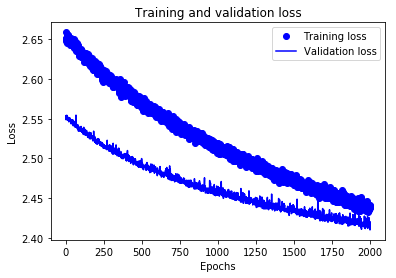

In [99]:
plt.clf()
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

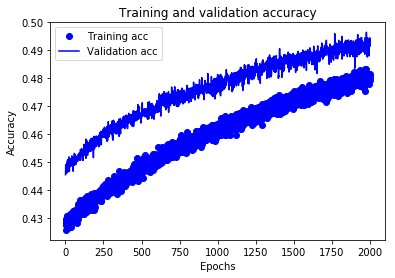

In [100]:
plt.clf()
acc = history2.history['acc']
val_acc = history2.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [101]:
results = model2.evaluate(x_test, one_hot_test_labels)
results

16147/16147 [==============================] - ETA: 2s - loss: 5.5914 - acc: 0.062 - ETA: 1s - loss: 3.1158 - acc: 0.389 - ETA: 1s - loss: 3.0911 - acc: 0.349 - ETA: 0s - loss: 2.8163 - acc: 0.384 - ETA: 0s - loss: 2.3956 - acc: 0.498 - ETA: 0s - loss: 2.1044 - acc: 0.575 - ETA: 0s - loss: 2.0463 - acc: 0.579 - ETA: 0s - loss: 1.9512 - acc: 0.597 - ETA: 0s - loss: 1.9731 - acc: 0.605 - ETA: 0s - loss: 2.0652 - acc: 0.575 - ETA: 0s - loss: 2.0638 - acc: 0.574 - ETA: 0s - loss: 2.1617 - acc: 0.551 - ETA: 0s - loss: 2.2464 - acc: 0.517 - ETA: 0s - loss: 2.2376 - acc: 0.526 - ETA: 0s - loss: 2.3014 - acc: 0.513 - ETA: 0s - loss: 2.3329 - acc: 0.510 - ETA: 0s - loss: 2.3999 - acc: 0.500 - ETA: 0s - loss: 2.4132 - acc: 0.498 - ETA: 0s - loss: 2.4456 - acc: 0.488 - ETA: 0s - loss: 2.4580 - acc: 0.481 - ETA: 0s - loss: 2.4073 - acc: 0.496 - 1s 66us/sample - loss: 2.4380 - acc: 0.4915


[2.4380197331301012, 0.49154642]

In [102]:
y_pred_one_hot = model2.predict(x_test)
y_pred = np.argmax(y_pred_one_hot, axis=1)
print(classification_report(y_test_idx, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.08      0.13        78
           1       0.38      0.47      0.42       182
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00        19
           4       0.00      0.00      0.00        22
           5       0.00      0.00      0.00        25
           6       0.00      0.00      0.00        15
           7       0.46      0.84      0.59       161
           8       0.75      0.45      0.57        33
           9       0.00      0.00      0.00        24
          10       0.00      0.00      0.00        22
          11       0.36      0.68      0.47        82
          12       0.00      0.00      0.00        23
          13       0.22      0.06      0.09        34
          14       0.33      0.07      0.12        55
          15       1.00      0.06      0.12        16
          16       0.58      0.30      0.40       109
          17       0.70    